In [1]:
from platform import python_version
print(python_version())

3.9.12


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf
from PIL import Image
import os 
import random
from glob import glob
import cv2
from tqdm import tqdm 
from skimage.io import imread
import warnings
from PIL import Image
warnings.filterwarnings('ignore')

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
mask_files = glob('lgg-mri-segmentation/kaggle_3m/*/*_mask*')
len(mask_files)

3929

In [5]:
train_files = []
for i in mask_files:
    train_files.append(i.replace('_mask', ''))
len(train_files)

3929

In [6]:
train_files[0], mask_files[0]

('lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif',
 'lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10_mask.tif')

In [7]:
seed = 77
np.random.seed = seed

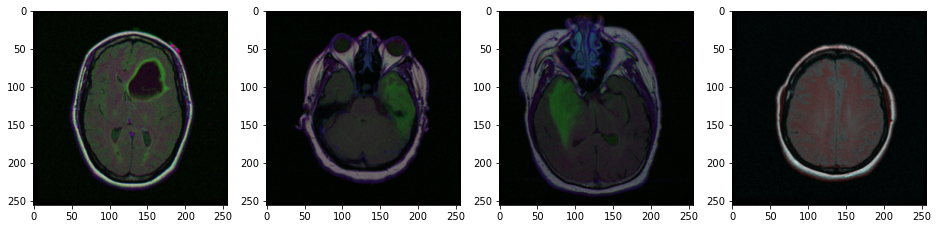

In [8]:
plt.figure(figsize=(16,20))

for i in range(4):
    file = random.choice(train_files)
    img = imread(file)
    plt.subplot(1,4,i+1)
    plt.imshow(img)

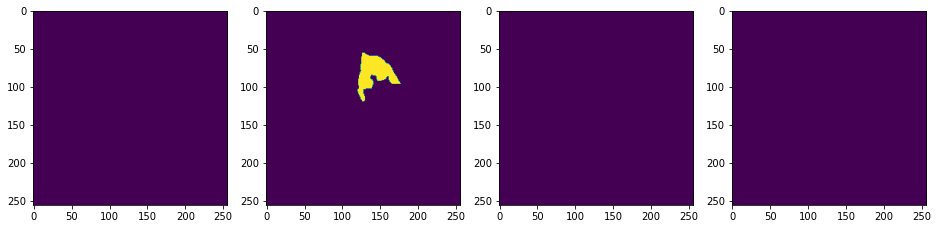

In [9]:
plt.figure(figsize=(16,20))

for i in range(4):
    file = random.choice(mask_files)
    img = imread(file)
    plt.subplot(1,4,i+1)
    plt.imshow(img)

In [10]:
train_images = []

for image_name in tqdm(train_files):
    if image_name.split('.')[1] == 'tif':
        img = cv2.imread(image_name, cv2.IMREAD_COLOR)
        img = Image.fromarray(img)
        img = img.resize((128,128)) #coz else we get resource exhausted error!
        train_images.append(np.array(img))

train_images = np.array(train_images) 

100%|██████████████████████████████████████████████████████████████████████████████| 3929/3929 [00:46<00:00, 84.83it/s]


In [11]:
train_images.shape

(3929, 128, 128, 3)

In [12]:
train_masks=[]
for mask_name in tqdm(mask_files):
    if mask_name.split('.')[1] == 'tif':
        img = cv2.imread(mask_name, 0)
        img = Image.fromarray(img)
        img = img.resize((128,128)) #coz else we get resource exhausted error!
        train_masks.append(np.array(img))

train_masks = np.array(train_masks) 

100%|█████████████████████████████████████████████████████████████████████████████| 3929/3929 [00:24<00:00, 157.65it/s]


In [13]:
train_masks.shape

(3929, 128, 128)

In [14]:
type(train_images), type(train_masks)

(numpy.ndarray, numpy.ndarray)

In [15]:
#Normalize images
train_images = train_images/255.

train_masks = np.expand_dims(train_masks, axis=-1)/255.

In [16]:
train_images.shape, train_masks.shape

((3929, 128, 128, 3), (3929, 128, 128, 1))

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks, test_size=0.15, random_state=77)

In [19]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.15, random_state=77)

In [20]:
X_train.shape, X_validation.shape, X_test.shape

((2838, 128, 128, 3), (501, 128, 128, 3), (590, 128, 128, 3))

In [21]:
y_train.shape, y_validation.shape, y_test.shape

((2838, 128, 128, 1), (501, 128, 128, 1), (590, 128, 128, 1))

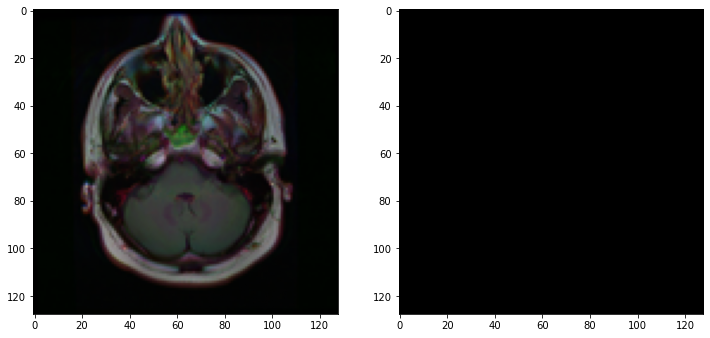

In [22]:
#Sanity check

image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (128, 128, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (128, 128)), cmap='gray')
plt.show()

In [23]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

In [24]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [25]:
def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

In [26]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    conv = layers.SeparableConv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.SeparableConv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    conv = layers.SeparableConv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.SeparableConv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.SeparableConv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    x = layers.SeparableConv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = layers.SeparableConv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.SeparableConv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.SeparableConv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [27]:
def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [28]:
# input_shape = (128,128,3)
# Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)

In [29]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 16

In [30]:
input_shape

(128, 128, 3)

In [31]:
from tensorflow.keras.utils import plot_model

In [32]:
model = Attention_ResUNet(input_shape)


optimizer_ = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer_, loss=jacard_coef_loss, metrics=['accuracy', jacard_coef])
print(model.summary())

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 128, 128, 64  283        ['input_1[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['separable_conv2d[0][0]']       
 alization)                     )                                                  

                                                                  'batch_normalization_7[0][0]']  
                                                                                                  
 activation_5 (Activation)      (None, 32, 32, 256)  0           ['add_2[0][0]']                  
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 256)  0          ['activation_5[0][0]']           
                                                                                                  
 separable_conv2d_9 (SeparableC  (None, 16, 16, 512)  133888     ['max_pooling2d_2[0][0]']        
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 16, 16, 512)  2048       ['separable_conv2d_9[0][0]']     
 rmalizati

 activation_12 (Activation)     (None, 8, 8, 1)      0           ['separable_conv2d_18[0][0]']    
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 16, 16, 1)    0           ['activation_12[0][0]']          
                                                                                                  
 lambda (Lambda)                (None, 16, 16, 512)  0           ['up_sampling2d[0][0]']          
                                                                                                  
 multiply (Multiply)            (None, 16, 16, 512)  0           ['lambda[0][0]',                 
                                                                  'activation_7[0][0]']           
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 512)  262656      ['multiply[0][0]']               
          

 batch_normalization_21 (BatchN  (None, 32, 32, 256)  1024       ['conv2d_1[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 concatenate_1 (Concatenate)    (None, 32, 32, 768)  0           ['up_sampling2d_3[0][0]',        
                                                                  'batch_normalization_21[0][0]'] 
                                                                                                  
 separable_conv2d_26 (Separable  (None, 32, 32, 256)  203776     ['concatenate_1[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_22 (BatchN  (None, 32, 32, 256)  1024       ['separable_conv2d_26[0][0]']    
 ormalizat

 separable_conv2d_35 (Separable  (None, 64, 64, 128)  49664      ['concatenate_2[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 separable_conv2d_34 (Separable  (None, 64, 64, 128)  17664      ['activation_23[0][0]']          
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_29 (BatchN  (None, 64, 64, 128)  512        ['separable_conv2d_35[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_28 (BatchN  (None, 64, 64, 128)  512        ['separable_conv2d_34[0][0]']    
 ormalizat

 ormalization)                  )                                                                 
                                                                                                  
 add_12 (Add)                   (None, 128, 128, 64  0           ['batch_normalization_34[0][0]', 
                                )                                 'batch_normalization_33[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 128, 128, 64  0           ['add_12[0][0]']                 
                                )                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 128, 128, 1)  65          ['activation_29[0][0]']          
                                                                                                  
 batch_nor

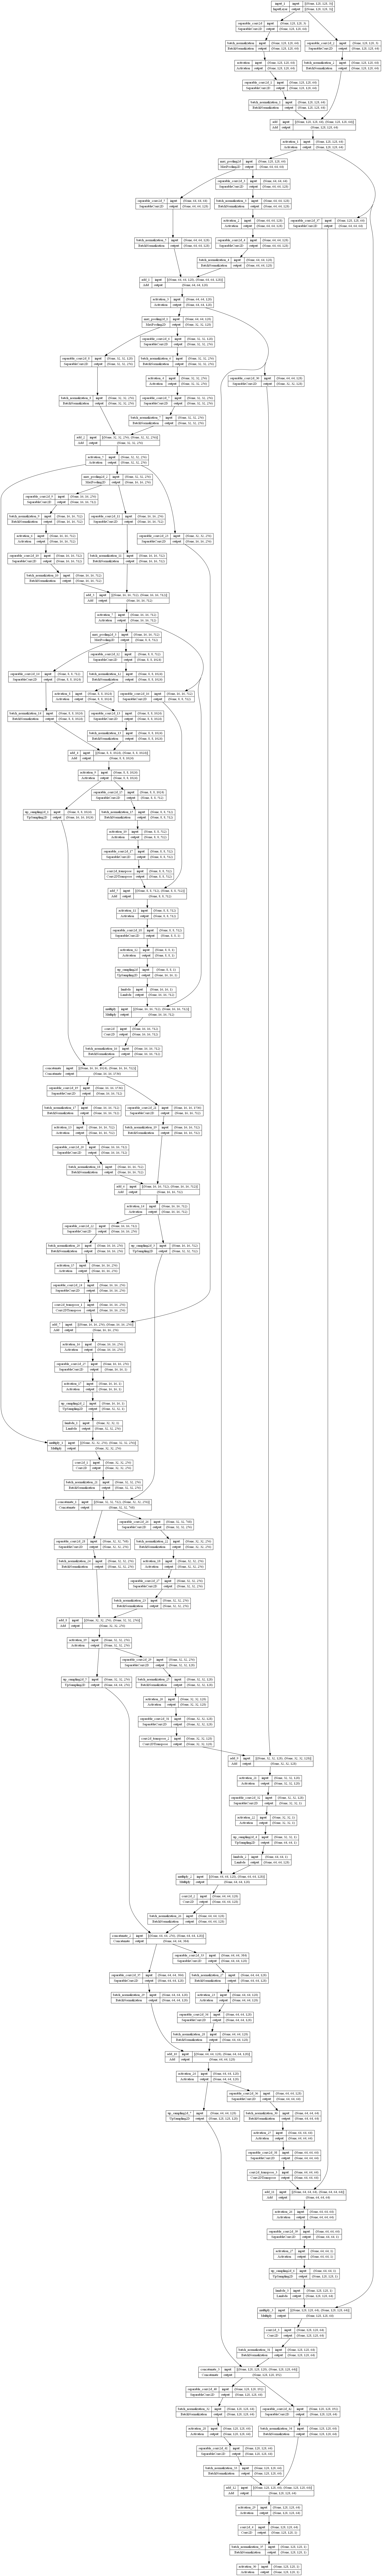

In [33]:
plot_model(model, to_file='AttentionBasedResidualUNetforBrainMRISegmentation.png', show_shapes=True, show_layer_names=True)

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from datetime import datetime 

In [38]:
checkpointer = ModelCheckpoint(filepath = 'saved_checkpoints/AttentionBasedResidualUNetforBrainMRISegmentation_2/checkpoint', 
                               verbose=1, save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)


reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=10, verbose=1, min_lr=0.00005)


start = datetime.now()


trained_model = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_data=(X_validation, y_validation), 
          callbacks=[checkpointer, early_stop, reduce_lr_on_plateau], shuffle=False, verbose=1)


duration = datetime.now() - start

print("Training completed in {}".format(duration))

Epoch 1/100
178/178 [==============================] - ETA: 0s - loss: -0.0398 - accuracy: 0.8796 - jacard_coef: 0.0399
Epoch 1: val_loss improved from inf to -0.06596, saving model to saved_checkpoints/AttentionBasedResidualUNetforBrainMRISegmentation_2\checkpoint
178/178 [==============================] - 74s 352ms/step - loss: -0.0398 - accuracy: 0.8796 - jacard_coef: 0.0399 - val_loss: -0.0660 - val_accuracy: 0.9338 - val_jacard_coef: 0.0665 - lr: 0.0100
Epoch 2/100
178/178 [==============================] - ETA: 0s - loss: -0.1765 - accuracy: 0.9763 - jacard_coef: 0.1764
Epoch 2: val_loss did not improve from -0.06596
178/178 [==============================] - 61s 344ms/step - loss: -0.1765 - accuracy: 0.9763 - jacard_coef: 0.1764 - val_loss: -0.0031 - val_accuracy: 0.9874 - val_jacard_coef: 0.0031 - lr: 0.0100
Epoch 3/100
178/178 [==============================] - ETA: 0s - loss: -0.3809 - accuracy: 0.9893 - jacard_coef: 0.3805
Epoch 3: val_loss improved from -0.06596 to -0.17672

178/178 [==============================] - 66s 370ms/step - loss: -0.6902 - accuracy: 0.9943 - jacard_coef: 0.6905 - val_loss: -0.6659 - val_accuracy: 0.9942 - val_jacard_coef: 0.6641 - lr: 0.0100
Epoch 22/100
178/178 [==============================] - ETA: 0s - loss: -0.6356 - accuracy: 0.9936 - jacard_coef: 0.6356
Epoch 22: val_loss did not improve from -0.66585
178/178 [==============================] - 62s 346ms/step - loss: -0.6356 - accuracy: 0.9936 - jacard_coef: 0.6356 - val_loss: -0.4110 - val_accuracy: 0.9921 - val_jacard_coef: 0.4108 - lr: 0.0100
Epoch 23/100
178/178 [==============================] - ETA: 0s - loss: -0.6850 - accuracy: 0.9942 - jacard_coef: 0.6854
Epoch 23: val_loss did not improve from -0.66585
178/178 [==============================] - 60s 338ms/step - loss: -0.6850 - accuracy: 0.9942 - jacard_coef: 0.6854 - val_loss: -0.5966 - val_accuracy: 0.9938 - val_jacard_coef: 0.5936 - lr: 0.0100
Epoch 24/100
178/178 [==============================] - ETA: 0s - los

178/178 [==============================] - 70s 392ms/step - loss: -0.8072 - accuracy: 0.9955 - jacard_coef: 0.8074 - val_loss: -0.7584 - val_accuracy: 0.9952 - val_jacard_coef: 0.7603 - lr: 0.0050
Epoch 43/100
178/178 [==============================] - ETA: 0s - loss: -0.8081 - accuracy: 0.9955 - jacard_coef: 0.8084
Epoch 43: val_loss did not improve from -0.75838
178/178 [==============================] - 71s 400ms/step - loss: -0.8081 - accuracy: 0.9955 - jacard_coef: 0.8084 - val_loss: -0.7554 - val_accuracy: 0.9952 - val_jacard_coef: 0.7575 - lr: 0.0050
Epoch 44/100
178/178 [==============================] - ETA: 0s - loss: -0.7978 - accuracy: 0.9953 - jacard_coef: 0.7979
Epoch 44: val_loss did not improve from -0.75838
178/178 [==============================] - 61s 342ms/step - loss: -0.7978 - accuracy: 0.9953 - jacard_coef: 0.7979 - val_loss: -0.7507 - val_accuracy: 0.9952 - val_jacard_coef: 0.7530 - lr: 0.0050
Epoch 45/100
178/178 [==============================] - ETA: 0s - los

Epoch 64/100
178/178 [==============================] - ETA: 0s - loss: -0.8428 - accuracy: 0.9958 - jacard_coef: 0.8430
Epoch 64: val_loss did not improve from -0.76807
178/178 [==============================] - 60s 339ms/step - loss: -0.8428 - accuracy: 0.9958 - jacard_coef: 0.8430 - val_loss: -0.7627 - val_accuracy: 0.9952 - val_jacard_coef: 0.7646 - lr: 0.0050
Epoch 65/100
178/178 [==============================] - ETA: 0s - loss: -0.8404 - accuracy: 0.9958 - jacard_coef: 0.8406
Epoch 65: val_loss did not improve from -0.76807
178/178 [==============================] - 61s 340ms/step - loss: -0.8404 - accuracy: 0.9958 - jacard_coef: 0.8406 - val_loss: -0.7074 - val_accuracy: 0.9946 - val_jacard_coef: 0.7107 - lr: 0.0050
Epoch 66/100
178/178 [==============================] - ETA: 0s - loss: -0.8379 - accuracy: 0.9957 - jacard_coef: 0.8381
Epoch 66: val_loss did not improve from -0.76807
178/178 [==============================] - 60s 339ms/step - loss: -0.8379 - accuracy: 0.9957 - j

Epoch 85/100
178/178 [==============================] - ETA: 0s - loss: -0.8471 - accuracy: 0.9958 - jacard_coef: 0.8473
Epoch 85: val_loss did not improve from -0.78287
178/178 [==============================] - 61s 343ms/step - loss: -0.8471 - accuracy: 0.9958 - jacard_coef: 0.8473 - val_loss: -0.7667 - val_accuracy: 0.9954 - val_jacard_coef: 0.7679 - lr: 0.0050
Epoch 86/100
178/178 [==============================] - ETA: 0s - loss: -0.8555 - accuracy: 0.9959 - jacard_coef: 0.8557
Epoch 86: val_loss did not improve from -0.78287
178/178 [==============================] - 60s 338ms/step - loss: -0.8555 - accuracy: 0.9959 - jacard_coef: 0.8557 - val_loss: -0.7022 - val_accuracy: 0.9948 - val_jacard_coef: 0.7059 - lr: 0.0050
Epoch 87/100
178/178 [==============================] - ETA: 0s - loss: -0.8531 - accuracy: 0.9959 - jacard_coef: 0.8533
Epoch 87: val_loss did not improve from -0.78287
178/178 [==============================] - 61s 342ms/step - loss: -0.8531 - accuracy: 0.9959 - j

In [35]:
model.load_weights('saved_checkpoints/AttentionBasedResidualUNetforBrainMRISegmentation_2/checkpoint')

In [40]:
# model.save("models/AttentionBasedResidualUNetforBrainMRISegmentation_2.h5")

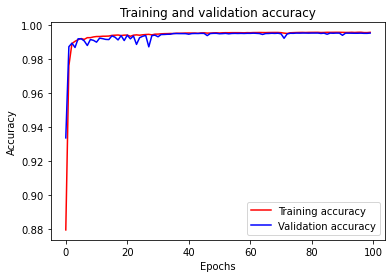

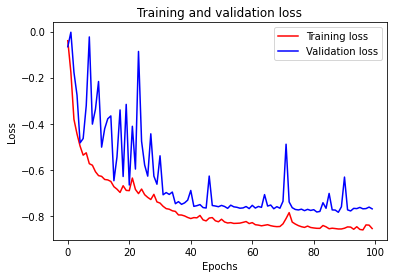

In [42]:
accuracy = trained_model.history['accuracy']
val_accuracy = trained_model.history['val_accuracy']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
epochs = list(range(0,100))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2

In [41]:
IoU_values = []
for img in tqdm(range(0, X_test.shape[0])):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.75).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU) 

  0%|                                                                                          | 0/590 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  0%|▏                                                                                 | 1/590 [00:00<02:27,  4.00it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.49954224
1/1 [==============================] - 0s 37ms/step


  1%|▍                                                                                 | 3/590 [00:00<01:18,  7.44it/s]

1.0
1/1 [==============================] - 0s 44ms/step


  1%|▌                                                                                 | 4/590 [00:00<01:16,  7.67it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.8935647
1/1 [==============================] - 0s 35ms/step


  1%|▊                                                                                 | 6/590 [00:00<01:04,  9.00it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 36ms/step


  1%|█                                                                                 | 8/590 [00:00<01:00,  9.57it/s]

0.77456164
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 37ms/step


  2%|█▎                                                                               | 10/590 [00:01<00:58,  9.98it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 35ms/step


  2%|█▋                                                                               | 12/590 [00:01<00:57, 10.02it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 37ms/step


  2%|█▉                                                                               | 14/590 [00:01<00:56, 10.27it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 33ms/step


  3%|██▏                                                                              | 16/590 [00:01<00:54, 10.46it/s]

0.87421167
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                              | 18/590 [00:01<00:57, 10.00it/s]

1.0
1/1 [==============================] - 0s 41ms/step
1.0
1/1 [==============================] - 0s 37ms/step


  3%|██▋                                                                              | 20/590 [00:02<00:59,  9.56it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 35ms/step


  4%|███                                                                              | 22/590 [00:02<00:57,  9.83it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 35ms/step


  4%|███▎                                                                             | 24/590 [00:02<00:57,  9.76it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  4%|███▍                                                                             | 25/590 [00:02<00:58,  9.74it/s]

0.7190675
1/1 [==============================] - 0s 33ms/step


  4%|███▌                                                                             | 26/590 [00:02<00:57,  9.74it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 36ms/step
1.0

  5%|███▊                                                                             | 28/590 [00:02<00:56,  9.91it/s]


1/1 [==============================] - 0s 38ms/step


  5%|███▉                                                                             | 29/590 [00:03<00:57,  9.80it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  5%|████                                                                             | 30/590 [00:03<00:57,  9.80it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 37ms/step


  5%|████▍                                                                            | 32/590 [00:03<00:55, 10.01it/s]

0.78529155
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 31ms/step


  6%|████▋                                                                            | 34/590 [00:03<00:54, 10.12it/s]

1.0
1/1 [==============================] - 0s 53ms/step
1.0
1/1 [==============================] - 0s 40ms/step


  6%|████▉                                                                            | 36/590 [00:03<00:57,  9.63it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 32ms/step


  6%|█████▏                                                                           | 38/590 [00:03<00:56,  9.82it/s]

1.0
1/1 [==============================] - 0s 32ms/step
0.85491014
1/1 [==============================] - 0s 40ms/step


  7%|█████▍                                                                           | 40/590 [00:04<00:55,  9.94it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.9059806
1/1 [==============================] - 0s 40ms/step


  7%|█████▊                                                                           | 42/590 [00:04<00:55,  9.93it/s]

1.0
1/1 [==============================] - 0s 37ms/step


  7%|█████▉                                                                           | 43/590 [00:04<00:55,  9.91it/s]

0.8149478
1/1 [==============================] - 0s 39ms/step


  7%|██████                                                                           | 44/590 [00:04<00:55,  9.81it/s]

1.0
1/1 [==============================] - 0s 50ms/step


  8%|██████▏                                                                          | 45/590 [00:04<00:58,  9.38it/s]

0.7849804
1/1 [==============================] - 0s 42ms/step


  8%|██████▎                                                                          | 46/590 [00:04<00:58,  9.37it/s]

0.82632244
1/1 [==============================] - 0s 51ms/step


  8%|██████▍                                                                          | 47/590 [00:04<01:04,  8.36it/s]

1.0
1/1 [==============================] - 0s 45ms/step


  8%|██████▌                                                                          | 48/590 [00:05<01:06,  8.14it/s]

1.0
1/1 [==============================] - 0s 36ms/step


  8%|██████▋                                                                          | 49/590 [00:05<01:07,  8.05it/s]

1.0
1/1 [==============================] - 0s 36ms/step


  8%|██████▊                                                                          | 50/590 [00:05<01:07,  7.95it/s]

1.0
1/1 [==============================] - 0s 36ms/step


  9%|███████                                                                          | 51/590 [00:05<01:08,  7.92it/s]

0.8118222
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 54ms/step


  9%|███████▎                                                                         | 53/590 [00:05<01:03,  8.49it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 37ms/step


  9%|███████▌                                                                         | 55/590 [00:05<00:58,  9.22it/s]

0.8851327
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 10%|███████▊                                                                         | 57/590 [00:06<00:56,  9.50it/s]

0.8990245
1/1 [==============================] - 0s 30ms/step
1.0
1/1 [==============================] - 0s 41ms/step


 10%|████████                                                                         | 59/590 [00:06<00:54,  9.81it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 10%|████████▏                                                                        | 60/590 [00:06<00:53,  9.82it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 41ms/step


 11%|████████▌                                                                        | 62/590 [00:06<00:52,  9.98it/s]

0.49395752
1/1 [==============================] - 0s 58ms/step


 11%|████████▋                                                                        | 63/590 [00:06<00:56,  9.25it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 11%|████████▊                                                                        | 64/590 [00:06<00:59,  8.78it/s]

0.49987793
1/1 [==============================] - 0s 36ms/step


 11%|████████▉                                                                        | 65/590 [00:06<00:58,  8.90it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 11%|█████████▏                                                                       | 67/590 [00:07<00:56,  9.26it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 12%|█████████▎                                                                       | 68/590 [00:07<00:55,  9.33it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 12%|█████████▍                                                                       | 69/590 [00:07<00:58,  8.88it/s]

0.89046293
1/1 [==============================] - 0s 56ms/step


 12%|█████████▌                                                                       | 70/590 [00:07<01:04,  8.04it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 12%|█████████▋                                                                       | 71/590 [00:07<01:11,  7.26it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 12%|█████████▉                                                                       | 72/590 [00:07<01:12,  7.12it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 12%|██████████                                                                       | 73/590 [00:07<01:06,  7.75it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 13%|██████████▏                                                                      | 74/590 [00:08<01:02,  8.25it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 41ms/step


 13%|██████████▍                                                                      | 76/590 [00:08<00:57,  8.96it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 13%|██████████▌                                                                      | 77/590 [00:08<00:55,  9.17it/s]

0.9118199
1/1 [==============================] - 0s 58ms/step


 13%|██████████▋                                                                      | 78/590 [00:08<00:57,  8.85it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 14%|██████████▉                                                                      | 80/590 [00:08<00:53,  9.57it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 14%|███████████                                                                      | 81/590 [00:08<00:53,  9.56it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 14%|███████████▍                                                                     | 83/590 [00:08<00:50,  9.95it/s]

0.8618368
1/1 [==============================] - 0s 44ms/step


 14%|███████████▌                                                                     | 84/590 [00:09<00:51,  9.75it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 14%|███████████▋                                                                     | 85/590 [00:09<00:51,  9.78it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 15%|███████████▉                                                                     | 87/590 [00:09<00:48, 10.29it/s]

0.79234004
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 15%|████████████▏                                                                    | 89/590 [00:09<00:48, 10.41it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 15%|████████████▍                                                                    | 91/590 [00:09<00:48, 10.32it/s]

0.6530216
1/1 [==============================] - 0s 38ms/step
0.49987793
1/1 [==============================] - 0s 33ms/step


 16%|████████████▊                                                                    | 93/590 [00:09<00:50,  9.94it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 16%|████████████▉                                                                    | 94/590 [00:10<00:51,  9.68it/s]

0.86042047
1/1 [==============================] - 0s 38ms/step


 16%|█████████████                                                                    | 95/590 [00:10<00:52,  9.48it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 16%|█████████████▏                                                                   | 96/590 [00:10<00:52,  9.42it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 16%|█████████████▎                                                                   | 97/590 [00:10<00:52,  9.30it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 17%|█████████████▍                                                                   | 98/590 [00:10<00:52,  9.29it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 17%|█████████████▌                                                                   | 99/590 [00:10<00:52,  9.32it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 17%|█████████████▌                                                                  | 100/590 [00:10<00:52,  9.31it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 17%|█████████████▋                                                                  | 101/590 [00:10<00:52,  9.40it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 17%|█████████████▊                                                                  | 102/590 [00:10<00:56,  8.69it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 17%|█████████████▉                                                                  | 103/590 [00:11<00:59,  8.21it/s]

0.86417234
1/1 [==============================] - 0s 35ms/step


 18%|██████████████                                                                  | 104/590 [00:11<00:59,  8.16it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 18%|██████████████▏                                                                 | 105/590 [00:11<00:59,  8.10it/s]

0.88520026
1/1 [==============================] - 0s 36ms/step


 18%|██████████████▎                                                                 | 106/590 [00:11<01:01,  7.89it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 52ms/step


 18%|██████████████▋                                                                 | 108/590 [00:11<00:55,  8.63it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 18%|██████████████▊                                                                 | 109/590 [00:11<00:54,  8.84it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 43ms/step


 19%|███████████████                                                                 | 111/590 [00:11<00:50,  9.41it/s]

0.87083435
1/1 [==============================] - 0s 35ms/step
0.8190726
1/1 [==============================] - 0s 40ms/step


 19%|███████████████▎                                                                | 113/590 [00:12<00:48,  9.74it/s]

0.4977417
1/1 [==============================] - 0s 34ms/step
0.8564148
1/1 [==============================] - 0s 34ms/step


 19%|███████████████▌                                                                | 115/590 [00:12<00:47, 10.09it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 20%|███████████████▋                                                                | 116/590 [00:12<00:47,  9.92it/s]

0.82320535
1/1 [==============================] - 0s 50ms/step


 20%|███████████████▊                                                                | 117/590 [00:12<00:50,  9.32it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 20%|████████████████                                                                | 118/590 [00:12<00:50,  9.41it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.7386832
1/1 [==============================] - 0s 33ms/step


 20%|████████████████▎                                                               | 120/590 [00:12<00:47, 10.00it/s]

0.91829026
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 47ms/step


 21%|████████████████▌                                                               | 122/590 [00:13<00:45, 10.18it/s]

0.8479934
1/1 [==============================] - 0s 57ms/step
1.0
1/1 [==============================] - 0s 54ms/step


 21%|████████████████▊                                                               | 124/590 [00:13<00:47,  9.73it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 21%|████████████████▉                                                               | 125/590 [00:13<00:50,  9.19it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 21%|█████████████████                                                               | 126/590 [00:13<00:52,  8.80it/s]

0.875798
1/1 [==============================] - 0s 64ms/step


 22%|█████████████████▏                                                              | 127/590 [00:13<00:58,  7.96it/s]

0.901203
1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▎                                                              | 128/590 [00:13<00:58,  7.93it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 22%|█████████████████▍                                                              | 129/590 [00:13<00:58,  7.95it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 22%|█████████████████▋                                                              | 130/590 [00:14<00:59,  7.79it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 22%|█████████████████▊                                                              | 131/590 [00:14<00:57,  7.94it/s]

0.86375606
1/1 [==============================] - 0s 31ms/step
1.0
1/1 [==============================] - 0s 52ms/step


 23%|██████████████████                                                              | 133/590 [00:14<00:53,  8.49it/s]

0.9226371
1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▏                                                             | 134/590 [00:14<00:53,  8.57it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 41ms/step


 23%|██████████████████▍                                                             | 136/590 [00:14<00:48,  9.37it/s]

0.8869902
1/1 [==============================] - 0s 41ms/step


 23%|██████████████████▌                                                             | 137/590 [00:14<00:48,  9.35it/s]

0.8463048
1/1 [==============================] - 0s 58ms/step


 23%|██████████████████▋                                                             | 138/590 [00:14<00:51,  8.79it/s]

0.9367746
1/1 [==============================] - 0s 57ms/step


 24%|██████████████████▊                                                             | 139/590 [00:15<00:53,  8.46it/s]

0.8893427
1/1 [==============================] - 0s 33ms/step


 24%|██████████████████▉                                                             | 140/590 [00:15<00:51,  8.79it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 24%|███████████████████                                                             | 141/590 [00:15<00:49,  9.02it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 24%|███████████████████▎                                                            | 142/590 [00:15<00:48,  9.23it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 42ms/step


 24%|███████████████████▌                                                            | 144/590 [00:15<00:46,  9.58it/s]

0.8708068
1/1 [==============================] - 0s 37ms/step
0.82932115
1/1 [==============================] - 0s 40ms/step


 25%|███████████████████▊                                                            | 146/590 [00:15<00:45,  9.86it/s]

0.9146164
1/1 [==============================] - 0s 45ms/step


 25%|███████████████████▉                                                            | 147/590 [00:15<00:45,  9.73it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 25%|████████████████████                                                            | 148/590 [00:16<00:49,  8.87it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 25%|████████████████████▏                                                           | 149/590 [00:16<00:52,  8.45it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 25%|████████████████████▎                                                           | 150/590 [00:16<00:53,  8.15it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 26%|████████████████████▍                                                           | 151/590 [00:16<00:55,  7.94it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 26%|████████████████████▌                                                           | 152/590 [00:16<00:54,  8.00it/s]

0.82794297
1/1 [==============================] - 0s 53ms/step


 26%|████████████████████▋                                                           | 153/590 [00:16<00:57,  7.54it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 26%|████████████████████▉                                                           | 154/590 [00:16<00:54,  7.98it/s]

0.88068426
1/1 [==============================] - 0s 55ms/step


 26%|█████████████████████                                                           | 155/590 [00:16<00:53,  8.08it/s]

0.7685056
1/1 [==============================] - 0s 52ms/step


 26%|█████████████████████▏                                                          | 156/590 [00:17<00:53,  8.07it/s]

0.8171682
1/1 [==============================] - 0s 34ms/step
0.8215712
1/1 [==============================] - 0s 48ms/step


 27%|█████████████████████▍                                                          | 158/590 [00:17<00:48,  8.88it/s]

0.75626826
1/1 [==============================] - 0s 39ms/step
0.91717434
1/1 [==============================] - 0s 41ms/step


 27%|█████████████████████▋                                                          | 160/590 [00:17<00:46,  9.30it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 27%|█████████████████████▊                                                          | 161/590 [00:17<00:45,  9.43it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.9196535
1/1 [==============================] - 0s 43ms/step


 28%|██████████████████████                                                          | 163/590 [00:17<00:43,  9.79it/s]

1.0
1/1 [==============================] - 0s 44ms/step
0.9234561
1/1 [==============================] - 0s 33ms/step


 28%|██████████████████████▎                                                         | 165/590 [00:17<00:42, 10.06it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 53ms/step


 28%|██████████████████████▋                                                         | 167/590 [00:18<00:42,  9.88it/s]

1.0
1/1 [==============================] - 0s 35ms/step
0.8667517
1/1 [==============================] - 0s 36ms/step


 29%|██████████████████████▉                                                         | 169/590 [00:18<00:41, 10.20it/s]

1.0
1/1 [==============================] - 0s 43ms/step
0.8662305
1/1 [==============================] - 0s 33ms/step


 29%|███████████████████████▏                                                        | 171/590 [00:18<00:41,  9.98it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.78340685
1/1 [==============================] - 0s 40ms/step


 29%|███████████████████████▍                                                        | 173/590 [00:18<00:42,  9.91it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 29%|███████████████████████▌                                                        | 174/590 [00:18<00:42,  9.88it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 30%|███████████████████████▋                                                        | 175/590 [00:18<00:42,  9.81it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 30%|███████████████████████▊                                                        | 176/590 [00:19<00:42,  9.81it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████▏                                                       | 178/590 [00:19<00:41,  9.88it/s]

0.84111965
1/1 [==============================] - 0s 34ms/step


 30%|████████████████████████▎                                                       | 179/590 [00:19<00:42,  9.77it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 31%|████████████████████████▍                                                       | 180/590 [00:19<00:42,  9.59it/s]

0.863636
1/1 [==============================] - 0s 38ms/step


 31%|████████████████████████▌                                                       | 181/590 [00:19<00:43,  9.35it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 31%|████████████████████████▋                                                       | 182/590 [00:19<00:43,  9.41it/s]

0.8954029
1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████▊                                                       | 183/590 [00:19<00:42,  9.52it/s]

0.87481064
1/1 [==============================] - 0s 43ms/step


 31%|████████████████████████▉                                                       | 184/590 [00:19<00:43,  9.38it/s]

0.5377035
1/1 [==============================] - 0s 51ms/step


 31%|█████████████████████████                                                       | 185/590 [00:20<00:48,  8.33it/s]

0.9187212
1/1 [==============================] - 0s 55ms/step


 32%|█████████████████████████▏                                                      | 186/590 [00:20<00:51,  7.87it/s]

0.8937274
1/1 [==============================] - 0s 36ms/step


 32%|█████████████████████████▎                                                      | 187/590 [00:20<00:51,  7.87it/s]

0.49920654
1/1 [==============================] - 0s 58ms/step


 32%|█████████████████████████▍                                                      | 188/590 [00:20<00:52,  7.62it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 32%|█████████████████████████▋                                                      | 189/590 [00:20<00:53,  7.43it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 32%|█████████████████████████▊                                                      | 190/590 [00:20<00:53,  7.54it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 32%|█████████████████████████▉                                                      | 191/590 [00:20<00:59,  6.72it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 33%|██████████████████████████                                                      | 192/590 [00:21<01:00,  6.63it/s]

0.91869235
1/1 [==============================] - 0s 35ms/step


 33%|██████████████████████████▏                                                     | 193/590 [00:21<00:56,  6.98it/s]

0.901536
1/1 [==============================] - 0s 34ms/step


 33%|██████████████████████████▎                                                     | 194/590 [00:21<00:54,  7.26it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 33%|██████████████████████████▌                                                     | 196/590 [00:21<00:46,  8.56it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 33%|██████████████████████████▋                                                     | 197/590 [00:21<00:44,  8.87it/s]

0.49996948
1/1 [==============================] - 0s 41ms/step


 34%|██████████████████████████▊                                                     | 198/590 [00:21<00:43,  9.07it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 34%|██████████████████████████▉                                                     | 199/590 [00:21<00:45,  8.50it/s]

0.9217706
1/1 [==============================] - 0s 38ms/step


 34%|███████████████████████████                                                     | 200/590 [00:22<00:45,  8.59it/s]

0.9059388
1/1 [==============================] - 0s 66ms/step


 34%|███████████████████████████▎                                                    | 201/590 [00:22<00:46,  8.39it/s]

0.92102545
1/1 [==============================] - 0s 35ms/step


 34%|███████████████████████████▍                                                    | 202/590 [00:22<00:44,  8.71it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 35%|███████████████████████████▋                                                    | 204/590 [00:22<00:41,  9.34it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 35%|███████████████████████████▊                                                    | 205/590 [00:22<00:42,  9.03it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 35%|███████████████████████████▉                                                    | 206/590 [00:22<00:45,  8.50it/s]

0.88585013
1/1 [==============================] - 0s 36ms/step
0.9413333
1/1 [==============================] - 0s 42ms/step


 35%|████████████████████████████▏                                                   | 208/590 [00:22<00:41,  9.12it/s]

0.83346206
1/1 [==============================] - 0s 35ms/step


 35%|████████████████████████████▎                                                   | 209/590 [00:23<00:41,  9.19it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 39ms/step


 36%|████████████████████████████▌                                                   | 211/590 [00:23<00:40,  9.34it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 36%|████████████████████████████▋                                                   | 212/590 [00:23<00:44,  8.46it/s]

0.74587345
1/1 [==============================] - 0s 31ms/step


 36%|████████████████████████████▉                                                   | 213/590 [00:23<00:45,  8.35it/s]

0.82947075
1/1 [==============================] - 0s 33ms/step


 36%|█████████████████████████████                                                   | 214/590 [00:23<00:45,  8.20it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 36%|█████████████████████████████▏                                                  | 215/590 [00:23<00:48,  7.78it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 37%|█████████████████████████████▍                                                  | 217/590 [00:23<00:42,  8.74it/s]

0.9300252
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 37%|█████████████████████████████▋                                                  | 219/590 [00:24<00:39,  9.29it/s]

0.497406
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 37%|█████████████████████████████▉                                                  | 221/590 [00:24<00:38,  9.59it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 38%|██████████████████████████████▏                                                 | 223/590 [00:24<00:36, 10.04it/s]

0.634499
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 56ms/step


 38%|██████████████████████████████▌                                                 | 225/590 [00:24<00:36,  9.89it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 38%|██████████████████████████████▊                                                 | 227/590 [00:24<00:36,  9.97it/s]

0.879013
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 51ms/step


 39%|███████████████████████████████                                                 | 229/590 [00:25<00:36,  9.76it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 39%|███████████████████████████████▏                                                | 230/590 [00:25<00:37,  9.64it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.7927996
1/1 [==============================] - 0s 59ms/step


 39%|███████████████████████████████▍                                                | 232/590 [00:25<00:37,  9.55it/s]

0.8475153
1/1 [==============================] - 0s 35ms/step


 39%|███████████████████████████████▌                                                | 233/590 [00:25<00:37,  9.62it/s]

0.7071323
1/1 [==============================] - 0s 38ms/step


 40%|███████████████████████████████▋                                                | 234/590 [00:25<00:36,  9.63it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 40%|███████████████████████████████▊                                                | 235/590 [00:25<00:37,  9.55it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 40%|████████████████████████████████                                                | 236/590 [00:25<00:36,  9.59it/s]

0.7194635
1/1 [==============================] - 0s 40ms/step


 40%|████████████████████████████████▏                                               | 237/590 [00:25<00:36,  9.57it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 40%|████████████████████████████████▎                                               | 238/590 [00:26<00:37,  9.45it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 41%|████████████████████████████████▍                                               | 239/590 [00:26<00:38,  9.05it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 41%|████████████████████████████████▌                                               | 240/590 [00:26<00:41,  8.35it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 41%|████████████████████████████████▋                                               | 241/590 [00:26<00:43,  8.06it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 41%|████████████████████████████████▊                                               | 242/590 [00:26<00:41,  8.46it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████▉                                               | 243/590 [00:26<00:39,  8.74it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 41%|█████████████████████████████████                                               | 244/590 [00:26<00:39,  8.78it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 42%|█████████████████████████████████▏                                              | 245/590 [00:26<00:39,  8.67it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 42%|█████████████████████████████████▎                                              | 246/590 [00:27<00:39,  8.82it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 42%|█████████████████████████████████▍                                              | 247/590 [00:27<00:38,  8.99it/s]

0.9387204
1/1 [==============================] - 0s 36ms/step


 42%|█████████████████████████████████▋                                              | 248/590 [00:27<00:37,  9.01it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 42%|█████████████████████████████████▊                                              | 249/590 [00:27<00:37,  9.08it/s]

0.49569702
1/1 [==============================] - 0s 35ms/step


 42%|█████████████████████████████████▉                                              | 250/590 [00:27<00:37,  8.96it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 43%|██████████████████████████████████                                              | 251/590 [00:27<00:37,  9.10it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 43%|██████████████████████████████████▏                                             | 252/590 [00:27<00:36,  9.30it/s]

0.8322854
1/1 [==============================] - 0s 52ms/step


 43%|██████████████████████████████████▎                                             | 253/590 [00:27<00:37,  8.98it/s]

0.893777
1/1 [==============================] - 0s 35ms/step


 43%|██████████████████████████████████▍                                             | 254/590 [00:27<00:37,  8.92it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████▌                                             | 255/590 [00:28<00:38,  8.73it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 43%|██████████████████████████████████▋                                             | 256/590 [00:28<00:38,  8.79it/s]

0.6213837
1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████▊                                             | 257/590 [00:28<00:37,  8.76it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████▉                                             | 258/590 [00:28<00:37,  8.80it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 44%|███████████████████████████████████                                             | 259/590 [00:28<00:37,  8.82it/s]

0.8596775
1/1 [==============================] - 0s 38ms/step


 44%|███████████████████████████████████▎                                            | 260/590 [00:28<00:37,  8.81it/s]

0.6340395
1/1 [==============================] - 0s 39ms/step


 44%|███████████████████████████████████▍                                            | 261/590 [00:28<00:36,  8.90it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 44%|███████████████████████████████████▌                                            | 262/590 [00:28<00:36,  8.88it/s]

0.53637064
1/1 [==============================] - 0s 38ms/step


 45%|███████████████████████████████████▋                                            | 263/590 [00:28<00:36,  8.87it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 45%|███████████████████████████████████▊                                            | 264/590 [00:29<00:36,  8.84it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 45%|███████████████████████████████████▉                                            | 265/590 [00:29<00:36,  8.94it/s]

0.869684
1/1 [==============================] - 0s 38ms/step


 45%|████████████████████████████████████                                            | 266/590 [00:29<00:36,  8.93it/s]

0.9369414
1/1 [==============================] - 0s 36ms/step


 45%|████████████████████████████████████▏                                           | 267/590 [00:29<00:36,  8.96it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 45%|████████████████████████████████████▎                                           | 268/590 [00:29<00:35,  9.05it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 46%|████████████████████████████████████▍                                           | 269/590 [00:29<00:35,  8.93it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 46%|████████████████████████████████████▌                                           | 270/590 [00:29<00:37,  8.49it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 46%|████████████████████████████████████▋                                           | 271/590 [00:29<00:36,  8.64it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 46%|████████████████████████████████████▉                                           | 272/590 [00:29<00:36,  8.75it/s]

0.49575806
1/1 [==============================] - 0s 33ms/step


 46%|█████████████████████████████████████                                           | 273/590 [00:30<00:35,  8.97it/s]

0.8030524
1/1 [==============================] - 0s 32ms/step


 46%|█████████████████████████████████████▏                                          | 274/590 [00:30<00:34,  9.16it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 47%|█████████████████████████████████████▎                                          | 275/590 [00:30<00:36,  8.60it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 47%|█████████████████████████████████████▍                                          | 276/590 [00:30<00:38,  8.15it/s]

0.80039
1/1 [==============================] - 0s 34ms/step


 47%|█████████████████████████████████████▌                                          | 277/590 [00:30<00:42,  7.31it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 47%|█████████████████████████████████████▋                                          | 278/590 [00:30<00:43,  7.21it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 47%|█████████████████████████████████████▊                                          | 279/590 [00:30<00:43,  7.17it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 47%|█████████████████████████████████████▉                                          | 280/590 [00:31<00:42,  7.25it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 48%|██████████████████████████████████████                                          | 281/590 [00:31<00:40,  7.72it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 48%|██████████████████████████████████████▏                                         | 282/590 [00:31<00:37,  8.17it/s]

0.9346626
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 48%|██████████████████████████████████████▌                                         | 284/590 [00:31<00:32,  9.29it/s]

0.6778707
1/1 [==============================] - 0s 33ms/step
0.94577384
1/1 [==============================] - 0s 38ms/step


 48%|██████████████████████████████████████▊                                         | 286/590 [00:31<00:31,  9.78it/s]

0.8731971
1/1 [==============================] - 0s 38ms/step


 49%|██████████████████████████████████████▉                                         | 287/590 [00:31<00:30,  9.80it/s]

0.8538444
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 49%|███████████████████████████████████████▏                                        | 289/590 [00:31<00:29, 10.17it/s]

0.881351
1/1 [==============================] - 0s 31ms/step
0.86932755
1/1 [==============================] - 0s 38ms/step


 49%|███████████████████████████████████████▍                                        | 291/590 [00:32<00:28, 10.41it/s]

0.84614456
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 45ms/step


 50%|███████████████████████████████████████▋                                        | 293/590 [00:32<00:29,  9.97it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 45ms/step


 50%|████████████████████████████████████████                                        | 295/590 [00:32<00:29,  9.96it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 50%|████████████████████████████████████████▎                                       | 297/590 [00:32<00:28, 10.14it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 51%|████████████████████████████████████████▌                                       | 299/590 [00:32<00:28, 10.06it/s]

1.0
1/1 [==============================] - 0s 40ms/step
0.9567816
1/1 [==============================] - 0s 32ms/step


 51%|████████████████████████████████████████▊                                       | 301/590 [00:33<00:29,  9.86it/s]

1.0
1/1 [==============================] - 0s 32ms/step
0.8975455
1/1 [==============================] - 0s 40ms/step


 51%|█████████████████████████████████████████                                       | 303/590 [00:33<00:30,  9.52it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 52%|█████████████████████████████████████████▏                                      | 304/590 [00:33<00:31,  9.14it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 52%|█████████████████████████████████████████▎                                      | 305/590 [00:33<00:32,  8.78it/s]

0.595555
1/1 [==============================] - 0s 32ms/step


 52%|█████████████████████████████████████████▍                                      | 306/590 [00:33<00:33,  8.57it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 52%|█████████████████████████████████████████▋                                      | 307/590 [00:33<00:33,  8.34it/s]

0.7358505
1/1 [==============================] - 0s 41ms/step


 52%|█████████████████████████████████████████▊                                      | 308/590 [00:33<00:34,  8.13it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 52%|█████████████████████████████████████████▉                                      | 309/590 [00:34<00:34,  8.15it/s]

0.8330926
1/1 [==============================] - 0s 45ms/step


 53%|██████████████████████████████████████████                                      | 310/590 [00:34<00:35,  7.90it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 53%|██████████████████████████████████████████▏                                     | 311/590 [00:34<00:34,  8.11it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 53%|██████████████████████████████████████████▍                                     | 313/590 [00:34<00:30,  9.14it/s]

1.0
1/1 [==============================] - 0s 35ms/step
0.7199228
1/1 [==============================] - 0s 37ms/step


 53%|██████████████████████████████████████████▋                                     | 315/590 [00:34<00:28,  9.56it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 54%|██████████████████████████████████████████▊                                     | 316/590 [00:34<00:28,  9.49it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 54%|██████████████████████████████████████████▉                                     | 317/590 [00:34<00:29,  9.32it/s]

1.0
1/1 [==============================] - 0s 37ms/step
0.89715695
1/1 [==============================] - 0s 36ms/step


 54%|███████████████████████████████████████████▎                                    | 319/590 [00:35<00:28,  9.55it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 54%|███████████████████████████████████████████▍                                    | 320/590 [00:35<00:28,  9.56it/s]

0.92939365
1/1 [==============================] - 0s 34ms/step
0.8669008
1/1 [==============================] - 0s 36ms/step


 55%|███████████████████████████████████████████▋                                    | 322/590 [00:35<00:27,  9.80it/s]

0.4996643
1/1 [==============================] - 0s 39ms/step


 55%|███████████████████████████████████████████▊                                    | 323/590 [00:35<00:27,  9.66it/s]

0.7881017
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 55%|████████████████████████████████████████████                                    | 325/590 [00:35<00:26,  9.97it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 55%|████████████████████████████████████████████▏                                   | 326/590 [00:35<00:26,  9.97it/s]

0.91081077
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 56%|████████████████████████████████████████████▍                                   | 328/590 [00:36<00:26,  9.90it/s]

0.6833346
1/1 [==============================] - 0s 36ms/step


 56%|████████████████████████████████████████████▌                                   | 329/590 [00:36<00:27,  9.40it/s]

0.8526182
1/1 [==============================] - 0s 58ms/step


 56%|████████████████████████████████████████████▋                                   | 330/590 [00:36<00:30,  8.65it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 56%|████████████████████████████████████████████▉                                   | 331/590 [00:36<00:30,  8.39it/s]

0.9269607
1/1 [==============================] - 0s 41ms/step


 56%|█████████████████████████████████████████████                                   | 332/590 [00:36<00:31,  8.09it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 56%|█████████████████████████████████████████████▏                                  | 333/590 [00:36<00:32,  7.83it/s]

0.9368629
1/1 [==============================] - 0s 33ms/step


 57%|█████████████████████████████████████████████▎                                  | 334/590 [00:36<00:32,  7.89it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 57%|█████████████████████████████████████████████▌                                  | 336/590 [00:37<00:28,  8.86it/s]

0.91198957
1/1 [==============================] - 0s 33ms/step
0.8948906
1/1 [==============================] - 0s 42ms/step


 57%|█████████████████████████████████████████████▊                                  | 338/590 [00:37<00:27,  9.24it/s]

0.89405596
1/1 [==============================] - 0s 46ms/step


 57%|█████████████████████████████████████████████▉                                  | 339/590 [00:37<00:26,  9.30it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 58%|██████████████████████████████████████████████                                  | 340/590 [00:37<00:28,  8.66it/s]

0.9064295
1/1 [==============================] - 0s 32ms/step


 58%|██████████████████████████████████████████████▏                                 | 341/590 [00:37<00:28,  8.62it/s]

1.0
1/1 [==============================] - 0s 38ms/step
0.7229624
1/1 [==============================] - 0s 36ms/step


 58%|██████████████████████████████████████████████▌                                 | 343/590 [00:37<00:26,  9.25it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 58%|██████████████████████████████████████████████▊                                 | 345/590 [00:38<00:25,  9.68it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 59%|███████████████████████████████████████████████                                 | 347/590 [00:38<00:24, 10.03it/s]

0.9192446
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 59%|███████████████████████████████████████████████▎                                | 349/590 [00:38<00:23, 10.33it/s]

1.0
1/1 [==============================] - 0s 30ms/step
0.6336296
1/1 [==============================] - 0s 41ms/step


 59%|███████████████████████████████████████████████▌                                | 351/590 [00:38<00:22, 10.43it/s]

0.75713927
1/1 [==============================] - 0s 34ms/step
0.7660952
1/1 [==============================] - 0s 65ms/step


 60%|███████████████████████████████████████████████▊                                | 353/590 [00:38<00:24,  9.78it/s]

0.79017556
1/1 [==============================] - 0s 31ms/step


 60%|████████████████████████████████████████████████                                | 354/590 [00:38<00:24,  9.75it/s]

0.78071845
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 60%|████████████████████████████████████████████████▎                               | 356/590 [00:39<00:24,  9.75it/s]

0.86703277
1/1 [==============================] - 0s 34ms/step


 61%|████████████████████████████████████████████████▍                               | 357/590 [00:39<00:23,  9.78it/s]

1.0
1/1 [==============================] - 0s 55ms/step


 61%|████████████████████████████████████████████████▌                               | 358/590 [00:39<00:25,  9.07it/s]

0.92209613
1/1 [==============================] - 0s 35ms/step


 61%|████████████████████████████████████████████████▋                               | 359/590 [00:39<00:26,  8.70it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 61%|████████████████████████████████████████████████▊                               | 360/590 [00:39<00:27,  8.45it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 61%|████████████████████████████████████████████████▉                               | 361/590 [00:39<00:27,  8.34it/s]

0.63809496
1/1 [==============================] - 0s 38ms/step


 61%|█████████████████████████████████████████████████                               | 362/590 [00:39<00:27,  8.26it/s]

0.8114343
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 62%|█████████████████████████████████████████████████▎                              | 364/590 [00:40<00:24,  9.21it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 64ms/step


 62%|█████████████████████████████████████████████████▋                              | 366/590 [00:40<00:25,  8.77it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 31ms/step


 62%|█████████████████████████████████████████████████▉                              | 368/590 [00:40<00:23,  9.50it/s]

0.87645423
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 63%|██████████████████████████████████████████████████▏                             | 370/590 [00:40<00:22,  9.90it/s]

0.4982605
1/1 [==============================] - 0s 62ms/step


 63%|██████████████████████████████████████████████████▎                             | 371/590 [00:40<00:23,  9.35it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 63%|██████████████████████████████████████████████████▍                             | 372/590 [00:40<00:23,  9.15it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 43ms/step


 63%|██████████████████████████████████████████████████▋                             | 374/590 [00:41<00:23,  9.33it/s]

0.49926758
1/1 [==============================] - 0s 39ms/step


 64%|██████████████████████████████████████████████████▊                             | 375/590 [00:41<00:23,  9.30it/s]

0.7801857
1/1 [==============================] - 0s 33ms/step
0.8625461
1/1 [==============================] - 0s 34ms/step


 64%|███████████████████████████████████████████████████                             | 377/590 [00:41<00:21,  9.69it/s]

1.0
1/1 [==============================] - 0s 39ms/step
0.660871
1/1 [==============================] - 0s 34ms/step


 64%|███████████████████████████████████████████████████▍                            | 379/590 [00:41<00:21,  9.99it/s]

0.89811134
1/1 [==============================] - 0s 43ms/step


 64%|███████████████████████████████████████████████████▌                            | 380/590 [00:41<00:21,  9.92it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 45ms/step


 65%|███████████████████████████████████████████████████▊                            | 382/590 [00:41<00:21,  9.77it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 37ms/step


 65%|████████████████████████████████████████████████████                            | 384/590 [00:42<00:21,  9.78it/s]

0.71028495
1/1 [==============================] - 0s 34ms/step


 65%|████████████████████████████████████████████████████▏                           | 385/590 [00:42<00:20,  9.82it/s]

0.8796329
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 66%|████████████████████████████████████████████████████▍                           | 387/590 [00:42<00:20,  9.90it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 66%|████████████████████████████████████████████████████▌                           | 388/590 [00:42<00:20,  9.92it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 66%|████████████████████████████████████████████████████▋                           | 389/590 [00:42<00:21,  9.49it/s]

0.4985962
1/1 [==============================] - 0s 49ms/step


 66%|████████████████████████████████████████████████████▉                           | 390/590 [00:42<00:21,  9.20it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 66%|█████████████████████████████████████████████████████                           | 391/590 [00:42<00:22,  8.80it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 66%|█████████████████████████████████████████████████████▏                          | 392/590 [00:43<00:22,  8.72it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 67%|█████████████████████████████████████████████████████▎                          | 393/590 [00:43<00:21,  9.03it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 67%|█████████████████████████████████████████████████████▌                          | 395/590 [00:43<00:20,  9.52it/s]

1.0
1/1 [==============================] - 0s 31ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 67%|█████████████████████████████████████████████████████▊                          | 397/590 [00:43<00:19,  9.75it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 67%|█████████████████████████████████████████████████████▉                          | 398/590 [00:43<00:21,  8.93it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 68%|██████████████████████████████████████████████████████                          | 399/590 [00:43<00:22,  8.60it/s]

0.86909914
1/1 [==============================] - 0s 38ms/step


 68%|██████████████████████████████████████████████████████▏                         | 400/590 [00:43<00:22,  8.33it/s]

0.8439988
1/1 [==============================] - 0s 43ms/step


 68%|██████████████████████████████████████████████████████▎                         | 401/590 [00:44<00:23,  8.00it/s]

0.91233647
1/1 [==============================] - 0s 65ms/step


 68%|██████████████████████████████████████████████████████▌                         | 402/590 [00:44<00:24,  7.61it/s]

0.8251293
1/1 [==============================] - 0s 42ms/step


 68%|██████████████████████████████████████████████████████▋                         | 403/590 [00:44<00:24,  7.63it/s]

0.91450655
1/1 [==============================] - 0s 35ms/step
0.7073321
1/1 [==============================] - 0s 32ms/step


 69%|██████████████████████████████████████████████████████▉                         | 405/590 [00:44<00:20,  8.89it/s]

1.0
1/1 [==============================] - 0s 39ms/step
0.5571736
1/1 [==============================] - 0s 32ms/step


 69%|███████████████████████████████████████████████████████▏                        | 407/590 [00:44<00:19,  9.52it/s]

0.88875127
1/1 [==============================] - 0s 31ms/step
1.0
1/1 [==============================] - 0s 41ms/step


 69%|███████████████████████████████████████████████████████▍                        | 409/590 [00:44<00:18,  9.89it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.8893556
1/1 [==============================] - 0s 32ms/step


 70%|███████████████████████████████████████████████████████▋                        | 411/590 [00:45<00:17, 10.01it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 70%|███████████████████████████████████████████████████████▊                        | 412/590 [00:45<00:18,  9.40it/s]

0.8615416
1/1 [==============================] - 0s 46ms/step


 70%|████████████████████████████████████████████████████████                        | 413/590 [00:45<00:18,  9.39it/s]

0.90999645
1/1 [==============================] - 0s 32ms/step
0.64950484
1/1 [==============================] - 0s 39ms/step


 70%|████████████████████████████████████████████████████████▎                       | 415/590 [00:45<00:17,  9.78it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 71%|████████████████████████████████████████████████████████▍                       | 416/590 [00:45<00:18,  9.41it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.79509926
1/1 [==============================] - 0s 33ms/step


 71%|████████████████████████████████████████████████████████▋                       | 418/590 [00:45<00:17,  9.85it/s]

0.49893188
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 71%|████████████████████████████████████████████████████████▉                       | 420/590 [00:46<00:16, 10.05it/s]

0.9631644
1/1 [==============================] - 0s 53ms/step


 71%|█████████████████████████████████████████████████████████                       | 421/590 [00:46<00:17,  9.40it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 72%|█████████████████████████████████████████████████████████▏                      | 422/590 [00:46<00:19,  8.43it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 423/590 [00:46<00:20,  8.29it/s]

0.93070406
1/1 [==============================] - 0s 57ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 424/590 [00:46<00:20,  7.99it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 72%|█████████████████████████████████████████████████████████▋                      | 425/590 [00:46<00:20,  7.88it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 426/590 [00:46<00:20,  7.90it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 427/590 [00:46<00:21,  7.50it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 73%|██████████████████████████████████████████████████████████                      | 428/590 [00:47<00:22,  7.23it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 429/590 [00:47<00:21,  7.41it/s]

0.58348876
1/1 [==============================] - 0s 46ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 430/590 [00:47<00:21,  7.48it/s]

0.82811624
1/1 [==============================] - 0s 34ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 431/590 [00:47<00:21,  7.57it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 432/590 [00:47<00:19,  8.10it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 31ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 434/590 [00:47<00:17,  9.11it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 39ms/step


 74%|███████████████████████████████████████████████████████████                     | 436/590 [00:47<00:16,  9.54it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 50ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 438/590 [00:48<00:15,  9.51it/s]

0.49664307
1/1 [==============================] - 0s 44ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 439/590 [00:48<00:15,  9.50it/s]

0.90015864
1/1 [==============================] - 0s 42ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 440/590 [00:48<00:15,  9.51it/s]

0.9028112
1/1 [==============================] - 0s 38ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 441/590 [00:48<00:15,  9.62it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 442/590 [00:48<00:15,  9.66it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 75%|████████████████████████████████████████████████████████████                    | 443/590 [00:48<00:15,  9.25it/s]

0.6732413
1/1 [==============================] - 0s 46ms/step
0.9172679
1/1 [==============================] - 0s 54ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 445/590 [00:48<00:15,  9.30it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 446/590 [00:49<00:15,  9.43it/s]

0.4956665
1/1 [==============================] - 0s 40ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 448/590 [00:49<00:14,  9.92it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 51ms/step


 76%|█████████████████████████████████████████████████████████████                   | 450/590 [00:49<00:14,  9.40it/s]

0.49975586
1/1 [==============================] - 0s 41ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 451/590 [00:49<00:15,  8.89it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 452/590 [00:49<00:16,  8.41it/s]

0.9324265
1/1 [==============================] - 0s 34ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 453/590 [00:49<00:16,  8.31it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 454/590 [00:49<00:16,  8.27it/s]

1.0
1/1 [==============================] - 0s 30ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 455/590 [00:50<00:16,  8.25it/s]

0.8657637
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 457/590 [00:50<00:14,  9.28it/s]

0.90322304
1/1 [==============================] - 0s 56ms/step


 78%|██████████████████████████████████████████████████████████████                  | 458/590 [00:50<00:14,  9.09it/s]

1.0
1/1 [==============================] - 0s 69ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 459/590 [00:50<00:15,  8.47it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 460/590 [00:50<00:15,  8.45it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 461/590 [00:50<00:14,  8.78it/s]

0.5487072
1/1 [==============================] - 0s 55ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 462/590 [00:50<00:14,  8.59it/s]

0.61924267
1/1 [==============================] - 0s 38ms/step
0.9371793
1/1 [==============================] - 0s 35ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 464/590 [00:51<00:13,  9.40it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 41ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 466/590 [00:51<00:12,  9.66it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 57ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 468/590 [00:51<00:12,  9.55it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 469/590 [00:51<00:12,  9.57it/s]

0.8951447
1/1 [==============================] - 0s 33ms/step
0.8212515
1/1 [==============================] - 0s 42ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 471/590 [00:51<00:11,  9.93it/s]

1.0
1/1 [==============================] - 0s 35ms/step
0.559877
1/1 [==============================] - 0s 33ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 473/590 [00:52<00:12,  9.44it/s]

0.7894205
1/1 [==============================] - 0s 35ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 474/590 [00:52<00:12,  9.11it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 475/590 [00:52<00:13,  8.44it/s]

0.5626952
1/1 [==============================] - 0s 35ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 476/590 [00:52<00:13,  8.26it/s]

0.69213486
1/1 [==============================] - 0s 52ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 477/590 [00:52<00:14,  8.00it/s]

0.7028453
1/1 [==============================] - 0s 55ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 478/590 [00:52<00:14,  7.82it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 479/590 [00:53<00:22,  4.88it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 81%|█████████████████████████████████████████████████████████████████               | 480/590 [00:53<00:20,  5.34it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 57ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 482/590 [00:53<00:16,  6.67it/s]

0.90273154
1/1 [==============================] - 0s 64ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 483/590 [00:53<00:15,  6.75it/s]

0.9488301
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 485/590 [00:53<00:13,  7.94it/s]

0.9274975
1/1 [==============================] - 0s 64ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 486/590 [00:53<00:13,  7.72it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 83%|██████████████████████████████████████████████████████████████████              | 487/590 [00:54<00:12,  8.11it/s]

0.93594176
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 44ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 489/590 [00:54<00:11,  8.76it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 490/590 [00:54<00:12,  8.22it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 491/590 [00:54<00:12,  8.13it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 492/590 [00:54<00:12,  7.95it/s]

0.5985341
1/1 [==============================] - 0s 32ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 493/590 [00:54<00:12,  7.80it/s]

0.5890837
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 51ms/step


 84%|███████████████████████████████████████████████████████████████████             | 495/590 [00:54<00:11,  8.45it/s]

0.6323716
1/1 [==============================] - 0s 50ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 496/590 [00:55<00:10,  8.61it/s]

0.76714575
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 498/590 [00:55<00:09,  9.30it/s]

1.0
1/1 [==============================] - 0s 32ms/step
0.92818
1/1 [==============================] - 0s 48ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 500/590 [00:55<00:09,  9.43it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 85%|███████████████████████████████████████████████████████████████████▉            | 501/590 [00:55<00:09,  9.53it/s]

0.9008894
1/1 [==============================] - 0s 48ms/step


 85%|████████████████████████████████████████████████████████████████████            | 502/590 [00:55<00:09,  9.50it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 503/590 [00:55<00:10,  8.50it/s]

0.81321406
1/1 [==============================] - 0s 46ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 504/590 [00:55<00:10,  8.45it/s]

0.4993286
1/1 [==============================] - 0s 40ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 505/590 [00:56<00:09,  8.68it/s]

1.0
1/1 [==============================] - 0s 35ms/step
0.88299656
1/1 [==============================] - 0s 33ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 507/590 [00:56<00:08,  9.56it/s]

1.0
1/1 [==============================] - 0s 40ms/step
1.0
1/1 [==============================] - 0s 49ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 509/590 [00:56<00:08,  9.47it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 86%|█████████████████████████████████████████████████████████████████████▏          | 510/590 [00:56<00:08,  9.57it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 511/590 [00:56<00:08,  9.04it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 512/590 [00:56<00:08,  8.71it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 513/590 [00:56<00:08,  8.90it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 64ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 515/590 [00:57<00:08,  8.62it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 516/590 [00:57<00:08,  8.43it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 517/590 [00:57<00:09,  8.01it/s]

0.4984131
1/1 [==============================] - 0s 36ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 518/590 [00:57<00:09,  7.95it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 519/590 [00:57<00:09,  7.47it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 520/590 [00:57<00:09,  7.55it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 521/590 [00:57<00:09,  7.65it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 522/590 [00:58<00:08,  8.08it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 524/590 [00:58<00:07,  9.09it/s]

1.0
1/1 [==============================] - 0s 36ms/step
0.90150964
1/1 [==============================] - 0s 42ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 526/590 [00:58<00:06,  9.59it/s]

0.8153235
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 45ms/step


 89%|███████████████████████████████████████████████████████████████████████▌        | 528/590 [00:58<00:06,  9.47it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 529/590 [00:58<00:06,  9.24it/s]

0.85335684
1/1 [==============================] - 0s 47ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 530/590 [00:58<00:06,  9.12it/s]

0.8911847
1/1 [==============================] - 0s 52ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 531/590 [00:59<00:06,  8.80it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 532/590 [00:59<00:06,  9.00it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 51ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 534/590 [00:59<00:06,  9.04it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 535/590 [00:59<00:06,  8.90it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 58ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 537/590 [00:59<00:06,  8.76it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 538/590 [00:59<00:06,  8.54it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 539/590 [00:59<00:06,  8.23it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 92%|█████████████████████████████████████████████████████████████████████████▏      | 540/590 [01:00<00:06,  8.09it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 541/590 [01:00<00:06,  8.00it/s]

0.85485506
1/1 [==============================] - 0s 39ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 542/590 [01:00<00:06,  7.91it/s]

0.81804395
1/1 [==============================] - 0s 50ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 543/590 [01:00<00:05,  7.86it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 544/590 [01:00<00:05,  7.93it/s]

0.49804688
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 546/590 [01:00<00:04,  8.91it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 55ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 548/590 [01:01<00:04,  8.98it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 549/590 [01:01<00:04,  9.07it/s]

0.4996338
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 551/590 [01:01<00:04,  9.44it/s]

0.8894464
1/1 [==============================] - 0s 46ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 552/590 [01:01<00:04,  9.14it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 553/590 [01:01<00:04,  9.16it/s]

0.84400374
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 39ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 555/590 [01:01<00:03,  9.66it/s]

0.88492876
1/1 [==============================] - 0s 38ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 556/590 [01:01<00:03,  9.69it/s]

0.9048702
1/1 [==============================] - 0s 33ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 557/590 [01:01<00:03,  9.71it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 558/590 [01:02<00:03,  9.63it/s]

0.7909021
1/1 [==============================] - 0s 50ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 559/590 [01:02<00:03,  9.44it/s]

0.49920654
1/1 [==============================] - 0s 39ms/step
0.91545135
1/1 [==============================] - 0s 61ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 561/590 [01:02<00:03,  9.15it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 562/590 [01:02<00:03,  8.54it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 563/590 [01:02<00:03,  8.21it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 564/590 [01:02<00:03,  8.10it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 565/590 [01:02<00:03,  8.02it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 566/590 [01:03<00:02,  8.02it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 567/590 [01:03<00:02,  7.87it/s]

1.0
1/1 [==============================] - 0s 30ms/step
0.80291647
1/1 [==============================] - 0s 48ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 569/590 [01:03<00:02,  8.74it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 570/590 [01:03<00:02,  8.93it/s]

0.6050043
1/1 [==============================] - 0s 36ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 571/590 [01:03<00:02,  9.02it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 572/590 [01:03<00:01,  9.23it/s]

0.9153451
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 574/590 [01:03<00:01,  9.81it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 575/590 [01:04<00:01,  9.84it/s]

0.85693604
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 54ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 577/590 [01:04<00:01,  9.59it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 579/590 [01:04<00:01,  9.98it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 580/590 [01:04<00:01,  9.88it/s]

0.49990845
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 582/590 [01:04<00:00, 10.02it/s]

0.49957275
1/1 [==============================] - 0s 46ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 583/590 [01:04<00:00,  9.70it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.91455805
1/1 [==============================] - 0s 47ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 585/590 [01:05<00:00,  9.68it/s]

0.8363153
1/1 [==============================] - 0s 32ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 586/590 [01:05<00:00,  8.98it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 587/590 [01:05<00:00,  8.61it/s]

1.0
1/1 [==============================] - 0s 33ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 588/590 [01:05<00:00,  8.42it/s]

0.8645082
1/1 [==============================] - 0s 33ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 589/590 [01:05<00:00,  8.31it/s]

1.0
1/1 [==============================] - 0s 39ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 590/590 [01:05<00:00,  8.19it/s]

1.0


100%|████████████████████████████████████████████████████████████████████████████████| 590/590 [01:05<00:00,  8.98it/s]

Mean IoU is:  [0.79218775]


In [42]:
IoU_values = []
for img in tqdm(range(0, X_validation.shape[0])):
    temp_img = X_validation[img]
    ground_truth=y_validation[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.75).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df_val = pd.DataFrame(IoU_values, columns=["IoU"])
df_val = df_val[df_val.IoU != 1.0]    
mean_IoU_val = df_val.mean().values
print("Mean IoU is: ", mean_IoU_val) 

  0%|                                                                                          | 0/501 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


  0%|▏                                                                                 | 1/501 [00:00<01:10,  7.08it/s]

1.0
1/1 [==============================] - 0s 38ms/step


  0%|▎                                                                                 | 2/501 [00:00<01:08,  7.30it/s]

0.8630326
1/1 [==============================] - 0s 33ms/step


  1%|▍                                                                                 | 3/501 [00:00<01:06,  7.48it/s]

1.0
1/1 [==============================] - 0s 34ms/step


  1%|▋                                                                                 | 4/501 [00:00<01:05,  7.56it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.4994812
1/1 [==============================] - 0s 34ms/step


  1%|▉                                                                                 | 6/501 [00:00<00:55,  8.96it/s]

1.0
1/1 [==============================] - 0s 31ms/step
1.0
1/1 [==============================] - 0s 37ms/step


  2%|█▎                                                                                | 8/501 [00:00<00:50,  9.74it/s]

0.83738816
1/1 [==============================] - 0s 44ms/step
1.0
1/1 [==============================] - 0s 38ms/step


  2%|█▌                                                                               | 10/501 [00:01<00:49,  9.85it/s]

1.0
1/1 [==============================] - 0s 50ms/step


  2%|█▊                                                                               | 11/501 [00:01<00:51,  9.49it/s]

1.0
1/1 [==============================] - 0s 57ms/step


  2%|█▉                                                                               | 12/501 [00:01<00:52,  9.40it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 31ms/step


  3%|██▎                                                                              | 14/501 [00:01<00:48,  9.98it/s]

1.0
1/1 [==============================] - 0s 38ms/step


  3%|██▍                                                                              | 15/501 [00:01<00:49,  9.89it/s]

0.5290583
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 58ms/step


  3%|██▋                                                                              | 17/501 [00:01<00:50,  9.66it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 39ms/step


  4%|███                                                                              | 19/501 [00:02<00:47, 10.13it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 42ms/step


  4%|███▍                                                                             | 21/501 [00:02<00:47, 10.11it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 32ms/step


  5%|███▋                                                                             | 23/501 [00:02<00:50,  9.55it/s]

0.586103
1/1 [==============================] - 0s 38ms/step


  5%|███▉                                                                             | 24/501 [00:02<00:51,  9.18it/s]

0.8657361
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 36ms/step


  5%|████▏                                                                            | 26/501 [00:02<00:49,  9.58it/s]

0.91796607
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 35ms/step


  6%|████▌                                                                            | 28/501 [00:02<00:47,  9.90it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.9006053
1/1 [==============================] - 0s 35ms/step


  6%|████▊                                                                            | 30/501 [00:03<00:46, 10.12it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 36ms/step


  6%|█████▏                                                                           | 32/501 [00:03<00:45, 10.30it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 36ms/step


  7%|█████▍                                                                           | 34/501 [00:03<00:45, 10.25it/s]

1.0
1/1 [==============================] - 0s 31ms/step
1.0
1/1 [==============================] - 0s 40ms/step


  7%|█████▊                                                                           | 36/501 [00:03<00:45, 10.23it/s]

0.839764
1/1 [==============================] - 0s 33ms/step
0.49832153
1/1 [==============================] - 0s 33ms/step


  8%|██████▏                                                                          | 38/501 [00:03<00:44, 10.31it/s]

1.0
1/1 [==============================] - 0s 38ms/step
0.8061584
1/1 [==============================] - 0s 36ms/step


  8%|██████▍                                                                          | 40/501 [00:04<00:44, 10.31it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 40ms/step


  8%|██████▊                                                                          | 42/501 [00:04<00:44, 10.22it/s]

1.0
1/1 [==============================] - 0s 55ms/step
0.8677424
1/1 [==============================] - 0s 34ms/step


  9%|███████                                                                          | 44/501 [00:04<00:46,  9.82it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 47ms/step


  9%|███████▍                                                                         | 46/501 [00:04<00:46,  9.77it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 10%|███████▊                                                                         | 48/501 [00:04<00:45,  9.94it/s]

0.752166
1/1 [==============================] - 0s 43ms/step


 10%|███████▉                                                                         | 49/501 [00:05<00:46,  9.81it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.92980504
1/1 [==============================] - 0s 40ms/step


 10%|████████▏                                                                        | 51/501 [00:05<00:45,  9.79it/s]

1.0
1/1 [==============================] - 0s 35ms/step
0.768666
1/1 [==============================] - 0s 47ms/step


 11%|████████▌                                                                        | 53/501 [00:05<00:46,  9.62it/s]

0.88456166
1/1 [==============================] - 0s 32ms/step


 11%|████████▋                                                                        | 54/501 [00:05<00:46,  9.65it/s]

0.8957635
1/1 [==============================] - 0s 40ms/step


 11%|████████▉                                                                        | 55/501 [00:05<00:46,  9.64it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 11%|█████████                                                                        | 56/501 [00:05<00:47,  9.41it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 11%|█████████▏                                                                       | 57/501 [00:05<00:48,  9.07it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 12%|█████████▍                                                                       | 58/501 [00:06<00:48,  9.20it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 12%|█████████▌                                                                       | 59/501 [00:06<00:47,  9.31it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 12%|█████████▋                                                                       | 60/501 [00:06<00:50,  8.74it/s]

0.90724075
1/1 [==============================] - 0s 39ms/step


 12%|█████████▊                                                                       | 61/501 [00:06<00:52,  8.44it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 12%|██████████                                                                       | 62/501 [00:06<00:52,  8.29it/s]

0.8750042
1/1 [==============================] - 0s 40ms/step


 13%|██████████▏                                                                      | 63/501 [00:06<00:54,  8.10it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 13%|██████████▎                                                                      | 64/501 [00:06<00:54,  7.97it/s]

1.0
1/1 [==============================] - 0s 37ms/step
0.8634766
1/1 [==============================] - 0s 34ms/step


 13%|██████████▋                                                                      | 66/501 [00:06<00:48,  8.98it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.9294398
1/1 [==============================] - 0s 31ms/step


 14%|██████████▉                                                                      | 68/501 [00:07<00:45,  9.53it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 60ms/step


 14%|███████████▎                                                                     | 70/501 [00:07<00:46,  9.33it/s]

0.9058556
1/1 [==============================] - 0s 47ms/step


 14%|███████████▍                                                                     | 71/501 [00:07<00:46,  9.29it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 43ms/step


 15%|███████████▊                                                                     | 73/501 [00:07<00:43,  9.76it/s]

1.0
1/1 [==============================] - 0s 32ms/step
0.9012172
1/1 [==============================] - 0s 36ms/step


 15%|████████████▏                                                                    | 75/501 [00:07<00:42, 10.02it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 15%|████████████▎                                                                    | 76/501 [00:07<00:42,  9.98it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 15%|████████████▍                                                                    | 77/501 [00:08<00:43,  9.76it/s]

1.0
1/1 [==============================] - 0s 40ms/step
1.0
1/1 [==============================] - 0s 41ms/step


 16%|████████████▊                                                                    | 79/501 [00:08<00:43,  9.75it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 16%|████████████▉                                                                    | 80/501 [00:08<00:43,  9.79it/s]

0.90041703
1/1 [==============================] - 0s 64ms/step


 16%|█████████████                                                                    | 81/501 [00:08<00:47,  8.83it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 16%|█████████████▎                                                                   | 82/501 [00:08<00:48,  8.60it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 17%|█████████████▍                                                                   | 83/501 [00:08<00:49,  8.40it/s]

0.74593914
1/1 [==============================] - 0s 43ms/step


 17%|█████████████▌                                                                   | 84/501 [00:08<00:51,  8.13it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 17%|█████████████▋                                                                   | 85/501 [00:09<00:51,  8.05it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 17%|█████████████▉                                                                   | 86/501 [00:09<00:52,  7.91it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 17%|██████████████                                                                   | 87/501 [00:09<00:52,  7.84it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 18%|██████████████▏                                                                  | 88/501 [00:09<00:53,  7.75it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 18%|██████████████▍                                                                  | 89/501 [00:09<00:56,  7.28it/s]

0.6571317
1/1 [==============================] - 0s 56ms/step


 18%|██████████████▌                                                                  | 90/501 [00:09<00:56,  7.23it/s]

0.4992981
1/1 [==============================] - 0s 33ms/step


 18%|██████████████▋                                                                  | 91/501 [00:09<00:55,  7.41it/s]

0.9359277
1/1 [==============================] - 0s 37ms/step


 18%|██████████████▊                                                                  | 92/501 [00:09<00:54,  7.48it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 19%|███████████████                                                                  | 93/501 [00:10<00:50,  8.05it/s]

0.73804605
1/1 [==============================] - 0s 42ms/step


 19%|███████████████▏                                                                 | 94/501 [00:10<00:47,  8.52it/s]

1.0
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 19%|███████████████▌                                                                 | 96/501 [00:10<00:42,  9.48it/s]

0.79984665
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 20%|███████████████▊                                                                 | 98/501 [00:10<00:40, 10.01it/s]

0.9082679
1/1 [==============================] - 0s 29ms/step
0.64508367
1/1 [==============================] - 0s 39ms/step


 20%|███████████████▉                                                                | 100/501 [00:10<00:39, 10.20it/s]

1.0
1/1 [==============================] - 0s 43ms/step
1.0
1/1 [==============================] - 0s 31ms/step


 20%|████████████████▎                                                               | 102/501 [00:10<00:38, 10.27it/s]

0.84397006
1/1 [==============================] - 0s 43ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 21%|████████████████▌                                                               | 104/501 [00:11<00:38, 10.27it/s]

1.0
1/1 [==============================] - 0s 55ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 21%|████████████████▉                                                               | 106/501 [00:11<00:40,  9.86it/s]

0.8688196
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▏                                                              | 108/501 [00:11<00:39, 10.04it/s]

0.892467
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 53ms/step


 22%|█████████████████▌                                                              | 110/501 [00:11<00:39,  9.85it/s]

0.92595077
1/1 [==============================] - 0s 55ms/step


 22%|█████████████████▋                                                              | 111/501 [00:11<00:42,  9.11it/s]

0.85207176
1/1 [==============================] - 0s 41ms/step


 22%|█████████████████▉                                                              | 112/501 [00:12<00:43,  8.88it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 23%|██████████████████                                                              | 113/501 [00:12<00:43,  9.00it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▏                                                             | 114/501 [00:12<00:42,  9.14it/s]

0.850477
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 23%|██████████████████▌                                                             | 116/501 [00:12<00:40,  9.48it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 23%|██████████████████▋                                                             | 117/501 [00:12<00:42,  9.01it/s]

0.85356086
1/1 [==============================] - 0s 62ms/step


 24%|██████████████████▊                                                             | 118/501 [00:12<00:44,  8.51it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 24%|███████████████████                                                             | 119/501 [00:12<00:49,  7.79it/s]

0.906374
1/1 [==============================] - 0s 48ms/step


 24%|███████████████████▏                                                            | 120/501 [00:13<00:52,  7.24it/s]

0.85141754
1/1 [==============================] - 0s 60ms/step


 24%|███████████████████▎                                                            | 121/501 [00:13<00:55,  6.86it/s]

0.86629903
1/1 [==============================] - 0s 35ms/step


 24%|███████████████████▍                                                            | 122/501 [00:13<00:54,  6.93it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 25%|███████████████████▋                                                            | 123/501 [00:13<00:53,  7.00it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 25%|███████████████████▊                                                            | 124/501 [00:13<00:52,  7.17it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 25%|███████████████████▉                                                            | 125/501 [00:13<00:51,  7.37it/s]

0.6673967
1/1 [==============================] - 0s 35ms/step


 25%|████████████████████                                                            | 126/501 [00:13<00:49,  7.58it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 25%|████████████████████▎                                                           | 127/501 [00:13<00:51,  7.26it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 26%|████████████████████▍                                                           | 128/501 [00:14<00:50,  7.40it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 26%|████████████████████▌                                                           | 129/501 [00:14<00:49,  7.56it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 31ms/step


 26%|████████████████████▉                                                           | 131/501 [00:14<00:42,  8.80it/s]

0.7943828
1/1 [==============================] - 0s 35ms/step
0.81865454
1/1 [==============================] - 0s 42ms/step


 27%|█████████████████████▏                                                          | 133/501 [00:14<00:39,  9.23it/s]

0.7954372
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████▌                                                          | 135/501 [00:14<00:37,  9.66it/s]

1.0
1/1 [==============================] - 0s 40ms/step
1.0
1/1 [==============================] - 0s 54ms/step


 27%|█████████████████████▉                                                          | 137/501 [00:15<00:37,  9.59it/s]

0.8192049
1/1 [==============================] - 0s 45ms/step


 28%|██████████████████████                                                          | 138/501 [00:15<00:38,  9.54it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 28%|██████████████████████▏                                                         | 139/501 [00:15<00:38,  9.37it/s]

0.691926
1/1 [==============================] - 0s 44ms/step


 28%|██████████████████████▎                                                         | 140/501 [00:15<00:38,  9.45it/s]

1.0
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 46ms/step


 28%|██████████████████████▋                                                         | 142/501 [00:15<00:37,  9.54it/s]

0.8838585
1/1 [==============================] - 0s 38ms/step


 29%|██████████████████████▊                                                         | 143/501 [00:15<00:37,  9.58it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 46ms/step


 29%|███████████████████████▏                                                        | 145/501 [00:15<00:36,  9.81it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 29%|███████████████████████▎                                                        | 146/501 [00:15<00:38,  9.22it/s]

0.86890066
1/1 [==============================] - 0s 49ms/step


 29%|███████████████████████▍                                                        | 147/501 [00:16<00:43,  8.18it/s]

0.89815885
1/1 [==============================] - 0s 50ms/step


 30%|███████████████████████▋                                                        | 148/501 [00:16<00:45,  7.73it/s]

0.8295326
1/1 [==============================] - 0s 66ms/step


 30%|███████████████████████▊                                                        | 149/501 [00:16<00:47,  7.39it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 30%|███████████████████████▉                                                        | 150/501 [00:16<00:44,  7.95it/s]

0.8435128
1/1 [==============================] - 0s 51ms/step


 30%|████████████████████████                                                        | 151/501 [00:16<00:43,  7.99it/s]

1.0
1/1 [==============================] - 0s 55ms/step


 30%|████████████████████████▎                                                       | 152/501 [00:16<00:44,  7.88it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 31%|████████████████████████▍                                                       | 153/501 [00:16<00:42,  8.20it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 31%|████████████████████████▌                                                       | 154/501 [00:17<00:40,  8.60it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 31%|████████████████████████▊                                                       | 155/501 [00:17<00:39,  8.74it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 31%|████████████████████████▉                                                       | 156/501 [00:17<00:38,  8.88it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████                                                       | 157/501 [00:17<00:38,  9.03it/s]

0.8094032
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 60ms/step


 32%|█████████████████████████▍                                                      | 159/501 [00:17<00:38,  8.99it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 32%|█████████████████████████▌                                                      | 160/501 [00:17<00:38,  8.92it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 32%|█████████████████████████▋                                                      | 161/501 [00:17<00:40,  8.33it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 32%|█████████████████████████▊                                                      | 162/501 [00:17<00:42,  8.01it/s]

1.0
1/1 [==============================] - 0s 71ms/step


 33%|██████████████████████████                                                      | 163/501 [00:18<00:45,  7.35it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 33%|██████████████████████████▏                                                     | 164/501 [00:18<00:44,  7.53it/s]

1.0
1/1 [==============================] - 0s 31ms/step
1.0
1/1 [==============================] - 0s 59ms/step


 33%|██████████████████████████▌                                                     | 166/501 [00:18<00:40,  8.17it/s]

0.87068164
1/1 [==============================] - 0s 51ms/step


 33%|██████████████████████████▋                                                     | 167/501 [00:18<00:41,  8.13it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 34%|██████████████████████████▊                                                     | 168/501 [00:18<00:39,  8.48it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 34%|██████████████████████████▉                                                     | 169/501 [00:18<00:38,  8.63it/s]

0.9063598
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▎                                                    | 171/501 [00:19<00:36,  8.99it/s]

0.93118644
1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▍                                                    | 172/501 [00:19<00:38,  8.55it/s]

0.89081275
1/1 [==============================] - 0s 32ms/step


 35%|███████████████████████████▌                                                    | 173/501 [00:19<00:36,  8.87it/s]

1.0
1/1 [==============================] - 0s 43ms/step
1.0
1/1 [==============================] - 0s 52ms/step


 35%|███████████████████████████▉                                                    | 175/501 [00:19<00:35,  9.08it/s]

1.0
1/1 [==============================] - 0s 37ms/step
0.8759449
1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▎                                                   | 177/501 [00:19<00:33,  9.59it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.54532117
1/1 [==============================] - 0s 34ms/step


 36%|████████████████████████████▌                                                   | 179/501 [00:19<00:32,  9.91it/s]

0.8930994
1/1 [==============================] - 0s 31ms/step
0.764665
1/1 [==============================] - 0s 32ms/step


 36%|████████████████████████████▉                                                   | 181/501 [00:20<00:31, 10.29it/s]

0.9185182
1/1 [==============================] - 0s 35ms/step
0.88918465
1/1 [==============================] - 0s 32ms/step


 37%|█████████████████████████████▏                                                  | 183/501 [00:20<00:31, 10.05it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 37%|█████████████████████████████▌                                                  | 185/501 [00:20<00:31, 10.03it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 32ms/step


 37%|█████████████████████████████▊                                                  | 187/501 [00:20<00:31, 10.02it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 38%|██████████████████████████████▏                                                 | 189/501 [00:20<00:34,  9.14it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 38%|██████████████████████████████▎                                                 | 190/501 [00:21<00:35,  8.85it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 38%|██████████████████████████████▍                                                 | 191/501 [00:21<00:36,  8.60it/s]

0.9196823
1/1 [==============================] - 0s 35ms/step


 38%|██████████████████████████████▋                                                 | 192/501 [00:21<00:36,  8.41it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 39%|██████████████████████████████▊                                                 | 193/501 [00:21<00:37,  8.24it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 39%|██████████████████████████████▉                                                 | 194/501 [00:21<00:37,  8.19it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████▏                                                | 195/501 [00:21<00:37,  8.07it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 39%|███████████████████████████████▎                                                | 196/501 [00:21<00:36,  8.42it/s]

0.91205275
1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████▍                                                | 197/501 [00:21<00:34,  8.70it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 40%|███████████████████████████████▊                                                | 199/501 [00:22<00:32,  9.23it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 40%|███████████████████████████████▉                                                | 200/501 [00:22<00:32,  9.21it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 40%|████████████████████████████████                                                | 201/501 [00:22<00:34,  8.64it/s]

1.0
1/1 [==============================] - 0s 37ms/step
0.93861836
1/1 [==============================] - 0s 60ms/step


 41%|████████████████████████████████▍                                               | 203/501 [00:22<00:33,  8.95it/s]

1.0
1/1 [==============================] - 0s 41ms/step
0.8792971
1/1 [==============================] - 0s 44ms/step


 41%|████████████████████████████████▋                                               | 205/501 [00:22<00:31,  9.48it/s]

0.49798584
1/1 [==============================] - 0s 36ms/step
0.49847412
1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████                                               | 207/501 [00:22<00:31,  9.41it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 42%|█████████████████████████████████▏                                              | 208/501 [00:23<00:31,  9.28it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 42%|█████████████████████████████████▎                                              | 209/501 [00:23<00:31,  9.26it/s]

0.9354001
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 53ms/step


 42%|█████████████████████████████████▋                                              | 211/501 [00:23<00:30,  9.43it/s]

0.92738456
1/1 [==============================] - 0s 42ms/step


 42%|█████████████████████████████████▊                                              | 212/501 [00:23<00:30,  9.52it/s]

0.89085567
1/1 [==============================] - 0s 65ms/step


 43%|██████████████████████████████████                                              | 213/501 [00:23<00:34,  8.45it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 43%|██████████████████████████████████▏                                             | 214/501 [00:23<00:34,  8.31it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 43%|██████████████████████████████████▎                                             | 215/501 [00:23<00:35,  8.08it/s]

0.6613731
1/1 [==============================] - 0s 42ms/step


 43%|██████████████████████████████████▍                                             | 216/501 [00:24<00:36,  7.86it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 43%|██████████████████████████████████▋                                             | 217/501 [00:24<00:36,  7.82it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████▊                                             | 218/501 [00:24<00:36,  7.83it/s]

0.8167667
1/1 [==============================] - 0s 40ms/step


 44%|██████████████████████████████████▉                                             | 219/501 [00:24<00:34,  8.25it/s]

0.8557495
1/1 [==============================] - 0s 36ms/step
0.7658484
1/1 [==============================] - 0s 47ms/step


 44%|███████████████████████████████████▎                                            | 221/501 [00:24<00:31,  8.96it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 44%|███████████████████████████████████▍                                            | 222/501 [00:24<00:30,  9.19it/s]

1.0
1/1 [==============================] - 0s 29ms/step
0.8681717
1/1 [==============================] - 0s 40ms/step


 45%|███████████████████████████████████▊                                            | 224/501 [00:24<00:28,  9.82it/s]

1.0
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 41ms/step


 45%|████████████████████████████████████                                            | 226/501 [00:25<00:27,  9.93it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 45%|████████████████████████████████████▏                                           | 227/501 [00:25<00:28,  9.73it/s]

0.8739399
1/1 [==============================] - 0s 38ms/step


 46%|████████████████████████████████████▍                                           | 228/501 [00:25<00:28,  9.73it/s]

0.905412
1/1 [==============================] - 0s 50ms/step


 46%|████████████████████████████████████▌                                           | 229/501 [00:25<00:28,  9.47it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 46%|████████████████████████████████████▋                                           | 230/501 [00:25<00:29,  9.27it/s]

1.0
1/1 [==============================] - 0s 33ms/step
0.89289296
1/1 [==============================] - 0s 43ms/step


 46%|█████████████████████████████████████                                           | 232/501 [00:25<00:27,  9.68it/s]

0.9305428
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 61ms/step


 47%|█████████████████████████████████████▎                                          | 234/501 [00:25<00:28,  9.35it/s]

0.9252939
1/1 [==============================] - 0s 34ms/step


 47%|█████████████████████████████████████▌                                          | 235/501 [00:26<00:28,  9.43it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 47%|█████████████████████████████████████▋                                          | 236/501 [00:26<00:29,  8.97it/s]

0.7923759
1/1 [==============================] - 0s 34ms/step


 47%|█████████████████████████████████████▊                                          | 237/501 [00:26<00:31,  8.46it/s]

1.0
1/1 [==============================] - 0s 39ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 48%|██████████████████████████████████████▏                                         | 239/501 [00:26<00:28,  9.16it/s]

0.9373368
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 48%|██████████████████████████████████████▍                                         | 241/501 [00:26<00:26,  9.74it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 49%|██████████████████████████████████████▊                                         | 243/501 [00:26<00:25,  9.96it/s]

0.9295563
1/1 [==============================] - 0s 39ms/step
0.6749867
1/1 [==============================] - 0s 39ms/step


 49%|███████████████████████████████████████                                         | 245/501 [00:27<00:25, 10.02it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 49%|███████████████████████████████████████▎                                        | 246/501 [00:27<00:25,  9.86it/s]

0.6705469
1/1 [==============================] - 0s 44ms/step


 49%|███████████████████████████████████████▍                                        | 247/501 [00:27<00:26,  9.71it/s]

0.6227077
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 31ms/step


 50%|███████████████████████████████████████▊                                        | 249/501 [00:27<00:25, 10.02it/s]

0.88808787
1/1 [==============================] - 0s 53ms/step


 50%|███████████████████████████████████████▉                                        | 250/501 [00:27<00:26,  9.44it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 50%|████████████████████████████████████████                                        | 251/501 [00:27<00:26,  9.51it/s]

0.9046984
1/1 [==============================] - 0s 49ms/step


 50%|████████████████████████████████████████▏                                       | 252/501 [00:27<00:26,  9.43it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 50%|████████████████████████████████████████▍                                       | 253/501 [00:27<00:27,  8.91it/s]

1.0
1/1 [==============================] - 0s 34ms/step
0.92805254
1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████▋                                       | 255/501 [00:28<00:26,  9.16it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 51%|████████████████████████████████████████▉                                       | 256/501 [00:28<00:28,  8.61it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 51%|█████████████████████████████████████████                                       | 257/501 [00:28<00:29,  8.36it/s]

0.49447632
1/1 [==============================] - 0s 33ms/step


 51%|█████████████████████████████████████████▏                                      | 258/501 [00:28<00:28,  8.45it/s]

0.82694685
1/1 [==============================] - 0s 63ms/step


 52%|█████████████████████████████████████████▎                                      | 259/501 [00:28<00:29,  8.26it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 52%|█████████████████████████████████████████▌                                      | 260/501 [00:28<00:29,  8.19it/s]

1.0
1/1 [==============================] - 0s 40ms/step
1.0
1/1 [==============================] - 0s 43ms/step


 52%|█████████████████████████████████████████▊                                      | 262/501 [00:29<00:27,  8.83it/s]

0.7613913
1/1 [==============================] - 0s 38ms/step


 52%|█████████████████████████████████████████▉                                      | 263/501 [00:29<00:26,  9.01it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 53%|██████████████████████████████████████████▏                                     | 264/501 [00:29<00:26,  8.98it/s]

0.8438905
1/1 [==============================] - 0s 44ms/step


 53%|██████████████████████████████████████████▎                                     | 265/501 [00:29<00:26,  8.91it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 53%|██████████████████████████████████████████▍                                     | 266/501 [00:29<00:26,  8.82it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 53%|██████████████████████████████████████████▋                                     | 267/501 [00:29<00:26,  8.85it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 53%|██████████████████████████████████████████▊                                     | 268/501 [00:29<00:26,  8.65it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 54%|██████████████████████████████████████████▉                                     | 269/501 [00:29<00:26,  8.84it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 54%|███████████████████████████████████████████                                     | 270/501 [00:29<00:26,  8.81it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 54%|███████████████████████████████████████████▎                                    | 271/501 [00:30<00:26,  8.68it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 54%|███████████████████████████████████████████▍                                    | 272/501 [00:30<00:26,  8.60it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 54%|███████████████████████████████████████████▌                                    | 273/501 [00:30<00:26,  8.54it/s]

1.0
1/1 [==============================] - 0s 70ms/step


 55%|███████████████████████████████████████████▊                                    | 274/501 [00:30<00:30,  7.48it/s]

0.8978331
1/1 [==============================] - 0s 46ms/step


 55%|███████████████████████████████████████████▉                                    | 275/501 [00:30<00:30,  7.36it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 55%|████████████████████████████████████████████                                    | 276/501 [00:30<00:30,  7.46it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 55%|████████████████████████████████████████████▏                                   | 277/501 [00:30<00:29,  7.60it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 55%|████████████████████████████████████████████▍                                   | 278/501 [00:30<00:29,  7.60it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 56%|████████████████████████████████████████████▌                                   | 279/501 [00:31<00:29,  7.44it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 56%|████████████████████████████████████████████▋                                   | 280/501 [00:31<00:28,  7.62it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 56%|████████████████████████████████████████████▊                                   | 281/501 [00:31<00:28,  7.66it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 56%|█████████████████████████████████████████████                                   | 282/501 [00:31<00:30,  7.27it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 56%|█████████████████████████████████████████████▏                                  | 283/501 [00:31<00:29,  7.43it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 57%|█████████████████████████████████████████████▎                                  | 284/501 [00:31<00:29,  7.38it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 57%|█████████████████████████████████████████████▌                                  | 285/501 [00:31<00:28,  7.53it/s]

0.9308711
1/1 [==============================] - 0s 36ms/step


 57%|█████████████████████████████████████████████▋                                  | 286/501 [00:32<00:28,  7.64it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 57%|█████████████████████████████████████████████▊                                  | 287/501 [00:32<00:28,  7.59it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 57%|█████████████████████████████████████████████▉                                  | 288/501 [00:32<00:26,  8.17it/s]

1.0
1/1 [==============================] - 0s 31ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 58%|██████████████████████████████████████████████▎                                 | 290/501 [00:32<00:22,  9.24it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 58%|██████████████████████████████████████████████▍                                 | 291/501 [00:32<00:23,  9.10it/s]

1.0
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 61ms/step


 58%|██████████████████████████████████████████████▊                                 | 293/501 [00:32<00:22,  9.11it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 59%|██████████████████████████████████████████████▉                                 | 294/501 [00:32<00:22,  9.14it/s]

1.0
1/1 [==============================] - 0s 37ms/step
0.9138969
1/1 [==============================] - 0s 37ms/step


 59%|███████████████████████████████████████████████▎                                | 296/501 [00:33<00:21,  9.57it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 59%|███████████████████████████████████████████████▍                                | 297/501 [00:33<00:21,  9.38it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 59%|███████████████████████████████████████████████▌                                | 298/501 [00:33<00:21,  9.35it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 60%|███████████████████████████████████████████████▋                                | 299/501 [00:33<00:21,  9.43it/s]

1.0
1/1 [==============================] - 0s 41ms/step
0.8687113
1/1 [==============================] - 0s 50ms/step


 60%|████████████████████████████████████████████████                                | 301/501 [00:33<00:21,  9.44it/s]

1.0
1/1 [==============================] - 0s 53ms/step


 60%|████████████████████████████████████████████████▏                               | 302/501 [00:33<00:21,  9.40it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 65ms/step


 61%|████████████████████████████████████████████████▌                               | 304/501 [00:33<00:22,  8.93it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 61%|████████████████████████████████████████████████▋                               | 305/501 [00:34<00:23,  8.32it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 61%|████████████████████████████████████████████████▊                               | 306/501 [00:34<00:23,  8.13it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 61%|█████████████████████████████████████████████████                               | 307/501 [00:34<00:26,  7.41it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 61%|█████████████████████████████████████████████████▏                              | 308/501 [00:34<00:25,  7.48it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 62%|█████████████████████████████████████████████████▎                              | 309/501 [00:34<00:25,  7.60it/s]

1.0
1/1 [==============================] - 0s 50ms/step


 62%|█████████████████████████████████████████████████▌                              | 310/501 [00:34<00:25,  7.59it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 62%|█████████████████████████████████████████████████▋                              | 311/501 [00:34<00:24,  7.69it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 62%|█████████████████████████████████████████████████▉                              | 313/501 [00:35<00:21,  8.63it/s]

0.49945068
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 61ms/step


 63%|██████████████████████████████████████████████████▎                             | 315/501 [00:35<00:21,  8.70it/s]

1.0
1/1 [==============================] - 0s 49ms/step


 63%|██████████████████████████████████████████████████▍                             | 316/501 [00:35<00:22,  8.33it/s]

0.64953005
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 39ms/step


 63%|██████████████████████████████████████████████████▊                             | 318/501 [00:35<00:20,  9.12it/s]

0.901284
1/1 [==============================] - 0s 36ms/step


 64%|██████████████████████████████████████████████████▉                             | 319/501 [00:35<00:19,  9.30it/s]

1.0
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 31ms/step


 64%|███████████████████████████████████████████████████▎                            | 321/501 [00:35<00:18,  9.77it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 64%|███████████████████████████████████████████████████▍                            | 322/501 [00:36<00:18,  9.71it/s]

0.56706524
1/1 [==============================] - 0s 52ms/step


 64%|███████████████████████████████████████████████████▌                            | 323/501 [00:36<00:19,  9.28it/s]

0.88942873
1/1 [==============================] - 0s 62ms/step


 65%|███████████████████████████████████████████████████▋                            | 324/501 [00:36<00:20,  8.78it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 65%|███████████████████████████████████████████████████▉                            | 325/501 [00:36<00:20,  8.60it/s]

0.4970398
1/1 [==============================] - 0s 46ms/step


 65%|████████████████████████████████████████████████████                            | 326/501 [00:36<00:19,  8.92it/s]

1.0
1/1 [==============================] - 0s 38ms/step
1.0
1/1 [==============================] - 0s 33ms/step


 65%|████████████████████████████████████████████████████▍                           | 328/501 [00:36<00:17,  9.63it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 66%|████████████████████████████████████████████████████▌                           | 329/501 [00:36<00:18,  9.07it/s]

1.0
1/1 [==============================] - 0s 57ms/step


 66%|████████████████████████████████████████████████████▋                           | 330/501 [00:37<00:20,  8.28it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 66%|████████████████████████████████████████████████████▊                           | 331/501 [00:37<00:21,  7.96it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 66%|█████████████████████████████████████████████████████                           | 332/501 [00:37<00:21,  7.75it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 66%|█████████████████████████████████████████████████████▏                          | 333/501 [00:37<00:22,  7.31it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 67%|█████████████████████████████████████████████████████▎                          | 334/501 [00:37<00:23,  7.23it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 67%|█████████████████████████████████████████████████████▍                          | 335/501 [00:37<00:23,  7.16it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 67%|█████████████████████████████████████████████████████▋                          | 336/501 [00:37<00:22,  7.38it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 67%|█████████████████████████████████████████████████████▊                          | 337/501 [00:38<00:21,  7.49it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 67%|█████████████████████████████████████████████████████▉                          | 338/501 [00:38<00:20,  7.86it/s]

0.7713931
1/1 [==============================] - 0s 36ms/step


 68%|██████████████████████████████████████████████████████▏                         | 339/501 [00:38<00:19,  8.19it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 68%|██████████████████████████████████████████████████████▎                         | 340/501 [00:38<00:18,  8.61it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 68%|██████████████████████████████████████████████████████▍                         | 341/501 [00:38<00:19,  8.34it/s]

1.0
1/1 [==============================] - 0s 36ms/step
0.8952123
1/1 [==============================] - 0s 56ms/step


 68%|██████████████████████████████████████████████████████▊                         | 343/501 [00:38<00:17,  8.94it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 69%|██████████████████████████████████████████████████████▉                         | 344/501 [00:38<00:17,  9.14it/s]

0.49682617
1/1 [==============================] - 0s 46ms/step


 69%|███████████████████████████████████████████████████████                         | 345/501 [00:38<00:17,  9.13it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 69%|███████████████████████████████████████████████████████▏                        | 346/501 [00:38<00:16,  9.17it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 69%|███████████████████████████████████████████████████████▍                        | 347/501 [00:39<00:16,  9.17it/s]

0.81357217
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 47ms/step


 70%|███████████████████████████████████████████████████████▋                        | 349/501 [00:39<00:15,  9.70it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 70%|███████████████████████████████████████████████████████▉                        | 350/501 [00:39<00:16,  9.11it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 70%|████████████████████████████████████████████████████████                        | 351/501 [00:39<00:16,  9.26it/s]

0.9262827
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 31ms/step


 70%|████████████████████████████████████████████████████████▎                       | 353/501 [00:39<00:14,  9.95it/s]

0.7518327
1/1 [==============================] - 0s 41ms/step
0.4982605
1/1 [==============================] - 0s 38ms/step


 71%|████████████████████████████████████████████████████████▋                       | 355/501 [00:39<00:15,  9.52it/s]

1.0
1/1 [==============================] - 0s 51ms/step


 71%|████████████████████████████████████████████████████████▊                       | 356/501 [00:40<00:16,  8.87it/s]

0.6874729
1/1 [==============================] - 0s 61ms/step


 71%|█████████████████████████████████████████████████████████                       | 357/501 [00:40<00:17,  8.41it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 71%|█████████████████████████████████████████████████████████▏                      | 358/501 [00:40<00:17,  8.24it/s]

0.92506015
1/1 [==============================] - 0s 33ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 359/501 [00:40<00:17,  8.25it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 360/501 [00:40<00:17,  8.25it/s]

1.0
1/1 [==============================] - 0s 44ms/step
1.0
1/1 [==============================] - 0s 43ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 362/501 [00:40<00:15,  9.11it/s]

0.49536133
1/1 [==============================] - 0s 35ms/step
0.9228968
1/1 [==============================] - 0s 34ms/step


 73%|██████████████████████████████████████████████████████████                      | 364/501 [00:40<00:14,  9.55it/s]

0.7459823
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 366/501 [00:41<00:13,  9.92it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 73%|██████████████████████████████████████████████████████████▊                     | 368/501 [00:41<00:13, 10.21it/s]

0.8957279
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 34ms/step
0.8954804

 74%|███████████████████████████████████████████████████████████                     | 370/501 [00:41<00:12, 10.32it/s]


1/1 [==============================] - 0s 46ms/step
1.0
1/1 [==============================] - 0s 51ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 372/501 [00:41<00:13,  9.91it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 373/501 [00:41<00:13,  9.82it/s]

0.82515836
1/1 [==============================] - 0s 42ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 374/501 [00:41<00:12,  9.78it/s]

0.8521919
1/1 [==============================] - 0s 46ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 375/501 [00:42<00:13,  9.62it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 75%|████████████████████████████████████████████████████████████                    | 376/501 [00:42<00:12,  9.66it/s]

0.86711985
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 38ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 378/501 [00:42<00:12,  9.98it/s]

0.7921715
1/1 [==============================] - 0s 35ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 379/501 [00:42<00:12,  9.63it/s]

0.89568484
1/1 [==============================] - 0s 42ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 380/501 [00:42<00:13,  8.83it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 381/501 [00:42<00:14,  8.44it/s]

0.853538
1/1 [==============================] - 0s 34ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 382/501 [00:42<00:14,  8.13it/s]

0.88674444
1/1 [==============================] - 0s 36ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 383/501 [00:43<00:15,  7.73it/s]

0.4881897
1/1 [==============================] - 0s 36ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 384/501 [00:43<00:14,  8.25it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 385/501 [00:43<00:13,  8.68it/s]

1.0
1/1 [==============================] - 0s 42ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 387/501 [00:43<00:12,  9.39it/s]

0.834761
1/1 [==============================] - 0s 48ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 388/501 [00:43<00:12,  9.16it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 78%|██████████████████████████████████████████████████████████████                  | 389/501 [00:43<00:12,  9.02it/s]

0.9061099
1/1 [==============================] - 0s 34ms/step
1.0
1/1 [==============================] - 0s 40ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 391/501 [00:43<00:11,  9.60it/s]

0.90836954
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 64ms/step


 78%|██████████████████████████████████████████████████████████████▊                 | 393/501 [00:44<00:11,  9.40it/s]

1.0
1/1 [==============================] - 0s 37ms/step
0.9379279
1/1 [==============================] - 0s 52ms/step


 79%|███████████████████████████████████████████████████████████████                 | 395/501 [00:44<00:11,  9.41it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 396/501 [00:44<00:11,  8.97it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 46ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 398/501 [00:44<00:11,  9.32it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 399/501 [00:44<00:11,  8.94it/s]

1.0
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 46ms/step


 80%|████████████████████████████████████████████████████████████████                | 401/501 [00:44<00:11,  8.70it/s]

0.93597853
1/1 [==============================] - 0s 37ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 402/501 [00:45<00:11,  8.27it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 403/501 [00:45<00:12,  8.13it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 404/501 [00:45<00:12,  7.62it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 405/501 [00:45<00:12,  7.42it/s]

0.9419482
1/1 [==============================] - 0s 41ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 406/501 [00:45<00:12,  7.43it/s]

0.6334407
1/1 [==============================] - 0s 47ms/step


 81%|████████████████████████████████████████████████████████████████▉               | 407/501 [00:45<00:12,  7.43it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 408/501 [00:45<00:12,  7.39it/s]

0.8574067
1/1 [==============================] - 0s 70ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 409/501 [00:46<00:12,  7.20it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 410/501 [00:46<00:12,  7.39it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 43ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 412/501 [00:46<00:10,  8.45it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 413/501 [00:46<00:10,  8.72it/s]

1.0
1/1 [==============================] - 0s 37ms/step
0.93724406
1/1 [==============================] - 0s 33ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 415/501 [00:46<00:09,  9.37it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 416/501 [00:46<00:09,  9.29it/s]

0.8736384
1/1 [==============================] - 0s 37ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 417/501 [00:46<00:08,  9.39it/s]

1.0
1/1 [==============================] - 0s 35ms/step
1.0
1/1 [==============================] - 0s 52ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 419/501 [00:47<00:08,  9.44it/s]

1.0
1/1 [==============================] - 0s 29ms/step
1.0
1/1 [==============================] - 0s 41ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 421/501 [00:47<00:08,  9.88it/s]

0.86994344
1/1 [==============================] - 0s 44ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 422/501 [00:47<00:08,  9.80it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 423/501 [00:47<00:08,  9.73it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 424/501 [00:47<00:08,  9.57it/s]

1.0
1/1 [==============================] - 0s 36ms/step
1.0
1/1 [==============================] - 0s 36ms/step


 85%|████████████████████████████████████████████████████████████████████            | 426/501 [00:47<00:07,  9.86it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 427/501 [00:47<00:07,  9.70it/s]

0.49664307
1/1 [==============================] - 0s 46ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 428/501 [00:48<00:07,  9.55it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 429/501 [00:48<00:07,  9.61it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 430/501 [00:48<00:07,  9.37it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 431/501 [00:48<00:07,  9.32it/s]

0.8014213
1/1 [==============================] - 0s 36ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 432/501 [00:48<00:07,  8.99it/s]

0.79805255
1/1 [==============================] - 0s 44ms/step


 86%|█████████████████████████████████████████████████████████████████████▏          | 433/501 [00:48<00:07,  8.52it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 434/501 [00:48<00:08,  8.37it/s]

0.9289299
1/1 [==============================] - 0s 50ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 435/501 [00:48<00:08,  7.99it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 436/501 [00:49<00:08,  7.85it/s]

1.0
1/1 [==============================] - 0s 47ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 437/501 [00:49<00:08,  7.75it/s]

0.49832153
1/1 [==============================] - 0s 40ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 438/501 [00:49<00:08,  7.76it/s]

0.8660623
1/1 [==============================] - 0s 35ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 439/501 [00:49<00:08,  7.68it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 440/501 [00:49<00:07,  7.79it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 441/501 [00:49<00:07,  7.81it/s]

0.7143658
1/1 [==============================] - 0s 32ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 443/501 [00:49<00:06,  9.05it/s]

1.0
1/1 [==============================] - 0s 52ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 444/501 [00:49<00:06,  9.05it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 445/501 [00:50<00:06,  9.27it/s]

0.91451585
1/1 [==============================] - 0s 39ms/step
0.7701609
1/1 [==============================] - 0s 43ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 447/501 [00:50<00:05,  9.66it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 89%|███████████████████████████████████████████████████████████████████████▌        | 448/501 [00:50<00:05,  9.61it/s]

0.9357255
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 35ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 450/501 [00:50<00:05,  9.96it/s]

0.84565914
1/1 [==============================] - 0s 45ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 451/501 [00:50<00:05,  9.85it/s]

1.0
1/1 [==============================] - 0s 42ms/step
1.0
1/1 [==============================] - 0s 49ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 453/501 [00:50<00:04,  9.69it/s]

0.69336826
1/1 [==============================] - 0s 64ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 454/501 [00:51<00:05,  8.87it/s]

0.8382078
1/1 [==============================] - 0s 38ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 455/501 [00:51<00:05,  9.11it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 456/501 [00:51<00:04,  9.12it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 457/501 [00:51<00:04,  8.98it/s]

0.8661014
1/1 [==============================] - 0s 39ms/step
0.87906075
1/1 [==============================] - 0s 30ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 459/501 [00:51<00:04,  9.02it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 460/501 [00:51<00:04,  8.58it/s]

0.90825963
1/1 [==============================] - 0s 34ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 461/501 [00:51<00:04,  8.19it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 462/501 [00:51<00:04,  8.12it/s]

0.76895535
1/1 [==============================] - 0s 34ms/step


 92%|█████████████████████████████████████████████████████████████████████████▉      | 463/501 [00:52<00:04,  8.09it/s]

0.85942733
1/1 [==============================] - 0s 48ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 464/501 [00:52<00:04,  8.31it/s]

1.0
1/1 [==============================] - 0s 55ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 465/501 [00:52<00:04,  8.27it/s]

0.90924037
1/1 [==============================] - 0s 37ms/step
1.0
1/1 [==============================] - 0s 63ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 467/501 [00:52<00:04,  8.44it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 468/501 [00:52<00:03,  8.61it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 469/501 [00:52<00:03,  8.90it/s]

0.87725866
1/1 [==============================] - 0s 37ms/step
0.89592725
1/1 [==============================] - 0s 55ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 471/501 [00:52<00:03,  8.98it/s]

0.9138476
1/1 [==============================] - 0s 33ms/step
0.7935718
1/1 [==============================] - 0s 37ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 473/501 [00:53<00:02,  9.55it/s]

0.9438771
1/1 [==============================] - 0s 49ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 474/501 [00:53<00:02,  9.07it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 475/501 [00:53<00:02,  8.87it/s]

0.9399817
1/1 [==============================] - 0s 39ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 476/501 [00:53<00:02,  9.10it/s]

0.8919111
1/1 [==============================] - 0s 44ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 477/501 [00:53<00:02,  9.07it/s]

0.93147767
1/1 [==============================] - 0s 58ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 478/501 [00:53<00:02,  8.55it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 479/501 [00:53<00:02,  8.15it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 480/501 [00:54<00:02,  7.23it/s]

0.85042477
1/1 [==============================] - 0s 33ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 481/501 [00:54<00:02,  7.33it/s]

0.8198175
1/1 [==============================] - 0s 32ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 482/501 [00:54<00:02,  7.40it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 483/501 [00:54<00:02,  7.40it/s]

0.81327885
1/1 [==============================] - 0s 51ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 484/501 [00:54<00:02,  7.20it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 485/501 [00:54<00:02,  7.19it/s]

0.9015683
1/1 [==============================] - 0s 69ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 486/501 [00:54<00:02,  6.96it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 487/501 [00:55<00:01,  7.08it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 488/501 [00:55<00:01,  7.26it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 98%|██████████████████████████████████████████████████████████████████████████████  | 489/501 [00:55<00:01,  7.48it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 490/501 [00:55<00:01,  8.05it/s]

0.9114652
1/1 [==============================] - 0s 40ms/step
1.0
1/1 [==============================] - 0s 34ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 492/501 [00:55<00:00,  9.06it/s]

1.0
1/1 [==============================] - 0s 46ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 493/501 [00:55<00:00,  9.07it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 494/501 [00:55<00:00,  9.26it/s]

0.4960022
1/1 [==============================] - 0s 33ms/step
1.0
1/1 [==============================] - 0s 37ms/step
1.0


 99%|███████████████████████████████████████████████████████████████████████████████▏| 496/501 [00:56<00:00,  9.59it/s]

1/1 [==============================] - 0s 37ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 497/501 [00:56<00:00,  9.66it/s]

0.88980234
1/1 [==============================] - 0s 30ms/step
1.0
1/1 [==============================] - 0s 34ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 499/501 [00:56<00:00, 10.12it/s]

0.867968
1/1 [==============================] - 0s 35ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 500/501 [00:56<00:00, 10.07it/s]

0.724822
1/1 [==============================] - 0s 61ms/step


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:56<00:00,  8.86it/s]

0.8861674
Mean IoU is:  [0.81601435]


In [47]:
IoU_values = []
for img in tqdm(range(0, X_train.shape[0])):
    temp_img = X_train[img]
    ground_truth=y_train[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.75).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df_train = pd.DataFrame(IoU_values, columns=["IoU"])
df_train = df_train[df_train.IoU != 1.0]    
mean_IoU_train = df_train.mean().values
print("Mean IoU is: ", mean_IoU_train) 

  0%|                                                                                         | 0/2838 [00:00<?, ?it/s]

1/1 [==============================] - 0s 104ms/step


  0%|                                                                                 | 1/2838 [00:01<56:16,  1.19s/it]

1.0
1/1 [==============================] - 0s 83ms/step


  0%|                                                                                 | 2/2838 [00:01<28:46,  1.64it/s]

0.4961548
1/1 [==============================] - 0s 72ms/step


  0%|                                                                                 | 3/2838 [00:01<18:48,  2.51it/s]

0.88759226
1/1 [==============================] - 0s 72ms/step


  0%|                                                                                 | 4/2838 [00:01<14:11,  3.33it/s]

1.0
1/1 [==============================] - 0s 63ms/step


  0%|▏                                                                                | 5/2838 [00:01<11:57,  3.95it/s]

1.0
1/1 [==============================] - 0s 77ms/step


  0%|▏                                                                                | 6/2838 [00:02<11:33,  4.08it/s]

0.9061508
1/1 [==============================] - 0s 121ms/step


  0%|▏                                                                                | 7/2838 [00:03<37:11,  1.27it/s]

1.0
1/1 [==============================] - 0s 70ms/step


  0%|▏                                                                                | 8/2838 [00:04<28:14,  1.67it/s]

0.8797482
1/1 [==============================] - 0s 104ms/step


  0%|▎                                                                                | 9/2838 [00:04<22:44,  2.07it/s]

1.0
1/1 [==============================] - 0s 69ms/step


  0%|▎                                                                               | 10/2838 [00:04<18:10,  2.59it/s]

1.0
1/1 [==============================] - 0s 92ms/step


  0%|▎                                                                               | 11/2838 [00:04<15:11,  3.10it/s]

1.0
1/1 [==============================] - 0s 64ms/step


  0%|▎                                                                               | 12/2838 [00:06<36:07,  1.30it/s]

0.75496995
1/1 [==============================] - 0s 76ms/step


  0%|▎                                                                               | 13/2838 [00:06<27:44,  1.70it/s]

1.0
1/1 [==============================] - 0s 70ms/step


  0%|▍                                                                               | 14/2838 [00:06<21:27,  2.19it/s]

1.0
1/1 [==============================] - 0s 87ms/step


  1%|▍                                                                               | 15/2838 [00:07<18:16,  2.58it/s]

0.9176923
1/1 [==============================] - 0s 60ms/step


  1%|▍                                                                               | 16/2838 [00:07<15:01,  3.13it/s]

1.0
1/1 [==============================] - 0s 76ms/step


  1%|▍                                                                               | 17/2838 [00:09<35:54,  1.31it/s]

0.9325492
1/1 [==============================] - 0s 64ms/step


  1%|▌                                                                               | 18/2838 [00:09<27:18,  1.72it/s]

1.0
1/1 [==============================] - 0s 63ms/step


  1%|▌                                                                               | 19/2838 [00:09<21:40,  2.17it/s]

1.0
1/1 [==============================] - 0s 80ms/step


  1%|▌                                                                               | 20/2838 [00:09<17:37,  2.66it/s]

1.0
1/1 [==============================] - 0s 71ms/step


  1%|▌                                                                               | 21/2838 [00:09<14:49,  3.17it/s]

0.89645994
1/1 [==============================] - 0s 67ms/step


  1%|▌                                                                               | 22/2838 [00:09<12:04,  3.89it/s]

1.0
1/1 [==============================] - 0s 64ms/step


  1%|▋                                                                               | 23/2838 [00:10<10:14,  4.58it/s]

1.0
1/1 [==============================] - 2s 2s/step


  1%|▋                                                                               | 24/2838 [00:11<31:41,  1.48it/s]

1.0
1/1 [==============================] - 0s 124ms/step


  1%|▋                                                                               | 25/2838 [00:12<26:01,  1.80it/s]

1.0
1/1 [==============================] - 0s 70ms/step


  1%|▋                                                                               | 26/2838 [00:12<20:14,  2.31it/s]

0.7719617
1/1 [==============================] - 0s 72ms/step


  1%|▊                                                                               | 27/2838 [00:12<16:42,  2.80it/s]

0.65754575
1/1 [==============================] - 0s 60ms/step


  1%|▊                                                                               | 28/2838 [00:12<13:23,  3.50it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  1%|▊                                                                               | 29/2838 [00:12<11:07,  4.21it/s]

1.0
1/1 [==============================] - 0s 58ms/step


  1%|▊                                                                               | 30/2838 [00:14<32:02,  1.46it/s]

1.0
1/1 [==============================] - 0s 56ms/step


  1%|▊                                                                               | 31/2838 [00:14<24:03,  1.94it/s]

1.0
1/1 [==============================] - 0s 57ms/step


  1%|▉                                                                               | 32/2838 [00:14<18:30,  2.53it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  1%|▉                                                                               | 33/2838 [00:14<14:45,  3.17it/s]

1.0
1/1 [==============================] - 0s 67ms/step


  1%|▉                                                                               | 34/2838 [00:14<12:02,  3.88it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  1%|▉                                                                               | 35/2838 [00:14<10:03,  4.65it/s]

1.0
1/1 [==============================] - 0s 63ms/step


  1%|█                                                                               | 36/2838 [00:15<08:43,  5.35it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  1%|█                                                                               | 37/2838 [00:15<07:51,  5.94it/s]

0.8584853
1/1 [==============================] - 0s 87ms/step


  1%|█                                                                               | 38/2838 [00:16<30:16,  1.54it/s]

0.90326357
1/1 [==============================] - 0s 63ms/step


  1%|█                                                                               | 39/2838 [00:17<22:55,  2.04it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  1%|█▏                                                                              | 40/2838 [00:17<18:08,  2.57it/s]

1.0
1/1 [==============================] - 0s 68ms/step


  1%|█▏                                                                              | 41/2838 [00:17<15:07,  3.08it/s]

0.94927955
1/1 [==============================] - 0s 74ms/step


  1%|█▏                                                                              | 42/2838 [00:17<12:28,  3.74it/s]

1.0
1/1 [==============================] - 0s 66ms/step


  2%|█▏                                                                              | 43/2838 [00:17<10:30,  4.43it/s]

1.0
1/1 [==============================] - 0s 71ms/step


  2%|█▏                                                                              | 44/2838 [00:17<09:14,  5.04it/s]

1.0
1/1 [==============================] - 0s 80ms/step


  2%|█▎                                                                              | 45/2838 [00:17<08:26,  5.51it/s]

0.903594
1/1 [==============================] - 2s 2s/step


  2%|█▎                                                                              | 46/2838 [00:19<30:11,  1.54it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  2%|█▎                                                                              | 47/2838 [00:19<22:53,  2.03it/s]

1.0
1/1 [==============================] - 0s 69ms/step


  2%|█▎                                                                              | 48/2838 [00:19<17:48,  2.61it/s]

1.0
1/1 [==============================] - 0s 59ms/step


  2%|█▍                                                                              | 49/2838 [00:20<17:12,  2.70it/s]

0.9134196
1/1 [==============================] - 0s 73ms/step


  2%|█▍                                                                              | 50/2838 [00:20<13:55,  3.34it/s]

0.4998474
1/1 [==============================] - 0s 89ms/step


  2%|█▍                                                                              | 51/2838 [00:20<11:47,  3.94it/s]

1.0
1/1 [==============================] - 0s 52ms/step


  2%|█▍                                                                              | 52/2838 [00:22<33:06,  1.40it/s]

0.88437057
1/1 [==============================] - 0s 66ms/step


  2%|█▍                                                                              | 53/2838 [00:22<25:10,  1.84it/s]

1.0
1/1 [==============================] - 0s 66ms/step


  2%|█▌                                                                              | 54/2838 [00:22<19:32,  2.37it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  2%|█▌                                                                              | 55/2838 [00:22<15:33,  2.98it/s]

1.0
1/1 [==============================] - 0s 71ms/step


  2%|█▌                                                                              | 56/2838 [00:22<13:12,  3.51it/s]

0.89915586
1/1 [==============================] - 0s 77ms/step


  2%|█▌                                                                              | 57/2838 [00:23<11:21,  4.08it/s]

0.8822967
1/1 [==============================] - 0s 70ms/step


  2%|█▋                                                                              | 58/2838 [00:23<09:54,  4.67it/s]

1.0
1/1 [==============================] - 0s 64ms/step


  2%|█▋                                                                              | 59/2838 [00:24<31:22,  1.48it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  2%|█▋                                                                              | 60/2838 [00:25<23:42,  1.95it/s]

0.8342561
1/1 [==============================] - 0s 64ms/step


  2%|█▋                                                                              | 61/2838 [00:25<20:21,  2.27it/s]

0.7459075
1/1 [==============================] - 0s 59ms/step


  2%|█▋                                                                              | 62/2838 [00:25<16:33,  2.79it/s]

0.80202764
1/1 [==============================] - 0s 65ms/step


  2%|█▊                                                                              | 63/2838 [00:25<13:51,  3.34it/s]

0.7087608
1/1 [==============================] - 0s 65ms/step


  2%|█▊                                                                              | 64/2838 [00:25<11:53,  3.89it/s]

0.92443407
1/1 [==============================] - 0s 60ms/step


  2%|█▊                                                                              | 65/2838 [00:26<10:31,  4.39it/s]

1.0
1/1 [==============================] - 0s 58ms/step


  2%|█▊                                                                              | 66/2838 [00:27<31:35,  1.46it/s]

0.8907844
1/1 [==============================] - 0s 83ms/step


  2%|█▉                                                                              | 67/2838 [00:27<24:11,  1.91it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  2%|█▉                                                                              | 68/2838 [00:28<19:17,  2.39it/s]

1.0
1/1 [==============================] - 0s 73ms/step


  2%|█▉                                                                              | 69/2838 [00:28<16:03,  2.87it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  2%|█▉                                                                              | 70/2838 [00:28<13:47,  3.34it/s]

1.0
1/1 [==============================] - 0s 71ms/step


  3%|██                                                                              | 71/2838 [00:30<33:50,  1.36it/s]

0.863739
1/1 [==============================] - 0s 62ms/step


  3%|██                                                                              | 72/2838 [00:30<26:54,  1.71it/s]

1.0
1/1 [==============================] - 0s 62ms/step


  3%|██                                                                              | 73/2838 [00:30<22:45,  2.02it/s]

1.0
1/1 [==============================] - 0s 66ms/step


  3%|██                                                                              | 74/2838 [00:30<19:44,  2.33it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  3%|██                                                                              | 75/2838 [00:32<38:02,  1.21it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  3%|██▏                                                                             | 76/2838 [00:33<30:33,  1.51it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  3%|██▏                                                                             | 77/2838 [00:33<26:01,  1.77it/s]

0.86333394
1/1 [==============================] - 0s 62ms/step


  3%|██▏                                                                             | 78/2838 [00:33<22:19,  2.06it/s]

1.0
1/1 [==============================] - 0s 68ms/step


  3%|██▏                                                                             | 79/2838 [00:35<40:04,  1.15it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  3%|██▎                                                                             | 80/2838 [00:35<31:24,  1.46it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  3%|██▎                                                                             | 81/2838 [00:35<25:06,  1.83it/s]

1.0
1/1 [==============================] - 0s 67ms/step


  3%|██▎                                                                             | 82/2838 [00:36<21:44,  2.11it/s]

0.90943336
1/1 [==============================] - 0s 66ms/step


  3%|██▎                                                                             | 83/2838 [00:38<39:57,  1.15it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  3%|██▎                                                                             | 84/2838 [00:38<32:07,  1.43it/s]

1.0
1/1 [==============================] - 0s 69ms/step


  3%|██▍                                                                             | 85/2838 [00:38<27:29,  1.67it/s]

1.0
1/1 [==============================] - 0s 81ms/step


  3%|██▍                                                                             | 86/2838 [00:38<21:27,  2.14it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  3%|██▍                                                                             | 87/2838 [00:40<38:14,  1.20it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  3%|██▍                                                                             | 88/2838 [00:40<30:36,  1.50it/s]

1.0
1/1 [==============================] - 0s 68ms/step


  3%|██▌                                                                             | 89/2838 [00:41<25:15,  1.81it/s]

0.60204345
1/1 [==============================] - 0s 60ms/step


  3%|██▌                                                                             | 90/2838 [00:41<21:03,  2.17it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  3%|██▌                                                                             | 91/2838 [00:43<38:58,  1.17it/s]

1.0
1/1 [==============================] - 0s 84ms/step


  3%|██▌                                                                             | 92/2838 [00:43<31:20,  1.46it/s]

1.0
1/1 [==============================] - 0s 71ms/step


  3%|██▌                                                                             | 93/2838 [00:43<25:40,  1.78it/s]

1.0
1/1 [==============================] - 0s 68ms/step


  3%|██▋                                                                             | 94/2838 [00:43<21:43,  2.10it/s]

1.0
1/1 [==============================] - 0s 71ms/step


  3%|██▋                                                                             | 95/2838 [00:45<40:15,  1.14it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  3%|██▋                                                                             | 96/2838 [00:46<31:35,  1.45it/s]

1.0
1/1 [==============================] - 0s 72ms/step


  3%|██▋                                                                             | 97/2838 [00:46<24:20,  1.88it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  3%|██▊                                                                             | 98/2838 [00:46<19:30,  2.34it/s]

0.8687196
1/1 [==============================] - 0s 56ms/step


  3%|██▊                                                                             | 99/2838 [00:46<16:48,  2.72it/s]

1.0
1/1 [==============================] - 0s 82ms/step


  4%|██▊                                                                            | 100/2838 [00:48<36:37,  1.25it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  4%|██▊                                                                            | 101/2838 [00:48<29:10,  1.56it/s]

0.9429923
1/1 [==============================] - 0s 63ms/step


  4%|██▊                                                                            | 102/2838 [00:48<23:43,  1.92it/s]

0.9145793
1/1 [==============================] - 0s 67ms/step


  4%|██▊                                                                            | 103/2838 [00:49<21:02,  2.17it/s]

0.9016727
1/1 [==============================] - 0s 61ms/step


  4%|██▉                                                                            | 104/2838 [00:50<38:28,  1.18it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  4%|██▉                                                                            | 105/2838 [00:51<30:16,  1.50it/s]

1.0
1/1 [==============================] - 0s 64ms/step


  4%|██▉                                                                            | 106/2838 [00:51<24:40,  1.85it/s]

0.8046683
1/1 [==============================] - 0s 58ms/step


  4%|██▉                                                                            | 107/2838 [00:51<20:41,  2.20it/s]

1.0
1/1 [==============================] - 0s 72ms/step


  4%|███                                                                            | 108/2838 [00:53<39:14,  1.16it/s]

1.0
1/1 [==============================] - 0s 57ms/step


  4%|███                                                                            | 109/2838 [00:53<30:55,  1.47it/s]

1.0
1/1 [==============================] - 0s 59ms/step


  4%|███                                                                            | 110/2838 [00:54<25:38,  1.77it/s]

1.0
1/1 [==============================] - 0s 57ms/step


  4%|███                                                                            | 111/2838 [00:54<21:35,  2.11it/s]

1.0
1/1 [==============================] - 0s 78ms/step


  4%|███                                                                            | 112/2838 [00:56<38:28,  1.18it/s]

1.0
1/1 [==============================] - 0s 74ms/step


  4%|███▏                                                                           | 113/2838 [00:56<30:41,  1.48it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  4%|███▏                                                                           | 114/2838 [00:56<23:12,  1.96it/s]

0.92092526
1/1 [==============================] - 0s 61ms/step


  4%|███▏                                                                           | 115/2838 [00:56<19:51,  2.29it/s]

1.0
1/1 [==============================] - 0s 62ms/step


  4%|███▏                                                                           | 116/2838 [00:56<15:32,  2.92it/s]

1.0
1/1 [==============================] - 0s 64ms/step


  4%|███▎                                                                           | 117/2838 [00:58<33:38,  1.35it/s]

1.0
1/1 [==============================] - 0s 58ms/step


  4%|███▎                                                                           | 118/2838 [00:58<26:42,  1.70it/s]

1.0
1/1 [==============================] - 0s 63ms/step


  4%|███▎                                                                           | 119/2838 [00:59<22:13,  2.04it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  4%|███▎                                                                           | 120/2838 [00:59<19:15,  2.35it/s]

1.0
1/1 [==============================] - 0s 64ms/step


  4%|███▎                                                                           | 121/2838 [01:01<37:13,  1.22it/s]

1.0
1/1 [==============================] - 0s 69ms/step


  4%|███▍                                                                           | 122/2838 [01:01<29:36,  1.53it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  4%|███▍                                                                           | 123/2838 [01:01<24:15,  1.86it/s]

1.0
1/1 [==============================] - 0s 68ms/step


  4%|███▍                                                                           | 124/2838 [01:01<20:13,  2.24it/s]

1.0
1/1 [==============================] - 0s 74ms/step


  4%|███▍                                                                           | 125/2838 [01:03<38:15,  1.18it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  4%|███▌                                                                           | 126/2838 [01:03<30:13,  1.50it/s]

1.0
1/1 [==============================] - 0s 63ms/step


  4%|███▌                                                                           | 127/2838 [01:04<24:31,  1.84it/s]

1.0
1/1 [==============================] - 0s 68ms/step


  5%|███▌                                                                           | 128/2838 [01:04<20:39,  2.19it/s]

1.0
1/1 [==============================] - 0s 59ms/step


  5%|███▌                                                                           | 129/2838 [01:06<40:42,  1.11it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  5%|███▌                                                                           | 130/2838 [01:06<31:32,  1.43it/s]

0.88479435
1/1 [==============================] - 0s 62ms/step


  5%|███▋                                                                           | 131/2838 [01:06<26:24,  1.71it/s]

0.8825819
1/1 [==============================] - 0s 82ms/step


  5%|███▋                                                                           | 132/2838 [01:09<55:31,  1.23s/it]

1.0
1/1 [==============================] - 0s 67ms/step


  5%|███▋                                                                           | 133/2838 [01:09<43:19,  1.04it/s]

0.8916478
1/1 [==============================] - 0s 61ms/step


  5%|███▋                                                                           | 134/2838 [01:10<34:00,  1.33it/s]

1.0
1/1 [==============================] - 2s 2s/step


  5%|███▊                                                                           | 135/2838 [01:12<48:55,  1.09s/it]

1.0
1/1 [==============================] - 0s 64ms/step


  5%|███▊                                                                           | 136/2838 [01:12<37:40,  1.20it/s]

1.0
1/1 [==============================] - 0s 67ms/step


  5%|███▊                                                                           | 137/2838 [01:12<30:13,  1.49it/s]

0.7888987
1/1 [==============================] - 0s 70ms/step


  5%|███▊                                                                           | 138/2838 [01:12<25:06,  1.79it/s]

0.80783904
1/1 [==============================] - 0s 71ms/step


  5%|███▊                                                                           | 139/2838 [01:14<43:22,  1.04it/s]

0.9437391
1/1 [==============================] - 0s 88ms/step


  5%|███▉                                                                           | 140/2838 [01:15<35:14,  1.28it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  5%|███▉                                                                           | 141/2838 [01:17<52:46,  1.17s/it]

1.0
1/1 [==============================] - 0s 75ms/step


  5%|███▉                                                                           | 142/2838 [01:17<41:41,  1.08it/s]

0.932213
1/1 [==============================] - 0s 66ms/step


  5%|███▉                                                                           | 143/2838 [01:17<32:53,  1.37it/s]

0.941743
1/1 [==============================] - 0s 89ms/step


  5%|████                                                                           | 144/2838 [01:18<27:16,  1.65it/s]

0.7359251
1/1 [==============================] - 0s 67ms/step


  5%|████                                                                           | 145/2838 [01:19<42:20,  1.06it/s]

1.0
1/1 [==============================] - 0s 58ms/step


  5%|████                                                                           | 146/2838 [01:20<33:33,  1.34it/s]

1.0
1/1 [==============================] - 0s 62ms/step


  5%|████                                                                           | 147/2838 [01:20<26:46,  1.68it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  5%|████                                                                           | 148/2838 [01:20<22:27,  2.00it/s]

1.0
1/1 [==============================] - 0s 99ms/step


  5%|████▏                                                                          | 149/2838 [01:22<40:40,  1.10it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  5%|████▏                                                                          | 150/2838 [01:22<34:02,  1.32it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  5%|████▏                                                                          | 151/2838 [01:23<27:49,  1.61it/s]

1.0
1/1 [==============================] - 0s 89ms/step


  5%|████▏                                                                          | 152/2838 [01:25<44:26,  1.01it/s]

1.0
1/1 [==============================] - 0s 64ms/step


  5%|████▎                                                                          | 153/2838 [01:25<35:04,  1.28it/s]

0.91019183
1/1 [==============================] - 0s 88ms/step


  5%|████▎                                                                          | 154/2838 [01:25<29:29,  1.52it/s]

1.0
1/1 [==============================] - 0s 59ms/step


  5%|████▎                                                                          | 155/2838 [01:27<44:19,  1.01it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  5%|████▎                                                                          | 156/2838 [01:27<34:47,  1.28it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  6%|████▎                                                                          | 157/2838 [01:28<28:25,  1.57it/s]

0.933385
1/1 [==============================] - 0s 62ms/step


  6%|████▍                                                                          | 158/2838 [01:28<23:50,  1.87it/s]

1.0
1/1 [==============================] - 0s 67ms/step


  6%|████▍                                                                          | 159/2838 [01:30<39:19,  1.14it/s]

0.8768693
1/1 [==============================] - 0s 65ms/step


  6%|████▍                                                                          | 160/2838 [01:30<32:47,  1.36it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  6%|████▍                                                                          | 161/2838 [01:30<28:34,  1.56it/s]

1.0
1/1 [==============================] - 0s 62ms/step


  6%|████▌                                                                          | 162/2838 [01:32<43:50,  1.02it/s]

0.8234325
1/1 [==============================] - 0s 62ms/step


  6%|████▌                                                                          | 163/2838 [01:33<34:56,  1.28it/s]

0.91130143
1/1 [==============================] - 0s 67ms/step


  6%|████▌                                                                          | 164/2838 [01:33<27:58,  1.59it/s]

1.0
1/1 [==============================] - 2s 2s/step


  6%|████▌                                                                          | 165/2838 [01:35<45:26,  1.02s/it]

1.0
1/1 [==============================] - 0s 63ms/step


  6%|████▌                                                                          | 166/2838 [01:35<35:19,  1.26it/s]

0.66527677
1/1 [==============================] - 0s 59ms/step


  6%|████▋                                                                          | 167/2838 [01:35<28:31,  1.56it/s]

1.0
1/1 [==============================] - 0s 56ms/step


  6%|████▋                                                                          | 168/2838 [01:36<23:24,  1.90it/s]

1.0
1/1 [==============================] - 0s 58ms/step


  6%|████▋                                                                          | 169/2838 [01:37<40:32,  1.10it/s]

0.7667566
1/1 [==============================] - 0s 59ms/step


  6%|████▋                                                                          | 170/2838 [01:38<32:09,  1.38it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  6%|████▊                                                                          | 171/2838 [01:38<25:47,  1.72it/s]

1.0
1/1 [==============================] - 0s 62ms/step


  6%|████▊                                                                          | 172/2838 [01:38<21:30,  2.07it/s]

1.0
1/1 [==============================] - 0s 58ms/step


  6%|████▊                                                                          | 173/2838 [01:40<38:09,  1.16it/s]

1.0
1/1 [==============================] - 0s 62ms/step


  6%|████▊                                                                          | 174/2838 [01:40<30:25,  1.46it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  6%|████▊                                                                          | 175/2838 [01:40<24:22,  1.82it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  6%|████▉                                                                          | 176/2838 [01:41<20:55,  2.12it/s]

1.0
1/1 [==============================] - 0s 75ms/step


  6%|████▉                                                                          | 177/2838 [01:42<38:24,  1.15it/s]

1.0
1/1 [==============================] - 0s 64ms/step


  6%|████▉                                                                          | 178/2838 [01:43<31:00,  1.43it/s]

1.0
1/1 [==============================] - 0s 93ms/step


  6%|████▉                                                                          | 179/2838 [01:43<27:05,  1.64it/s]

1.0
1/1 [==============================] - 0s 68ms/step


  6%|█████                                                                          | 180/2838 [01:45<42:46,  1.04it/s]

1.0
1/1 [==============================] - 0s 63ms/step


  6%|█████                                                                          | 181/2838 [01:45<33:38,  1.32it/s]

1.0
1/1 [==============================] - 0s 71ms/step


  6%|█████                                                                          | 182/2838 [01:46<27:47,  1.59it/s]

0.9324355
1/1 [==============================] - 0s 58ms/step


  6%|█████                                                                          | 183/2838 [01:47<43:39,  1.01it/s]

0.7924218
1/1 [==============================] - 0s 68ms/step


  6%|█████                                                                          | 184/2838 [01:48<34:33,  1.28it/s]

0.92523897
1/1 [==============================] - 0s 62ms/step


  7%|█████▏                                                                         | 185/2838 [01:48<28:08,  1.57it/s]

1.0
1/1 [==============================] - 0s 103ms/step


  7%|█████▏                                                                         | 186/2838 [01:50<46:06,  1.04s/it]

1.0
1/1 [==============================] - 0s 63ms/step


  7%|█████▏                                                                         | 187/2838 [01:50<36:04,  1.22it/s]

1.0
1/1 [==============================] - 0s 64ms/step


  7%|█████▏                                                                         | 188/2838 [01:51<29:10,  1.51it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  7%|█████▎                                                                         | 189/2838 [01:51<24:34,  1.80it/s]

0.84869576
1/1 [==============================] - 0s 58ms/step


  7%|█████▎                                                                         | 190/2838 [01:53<40:20,  1.09it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  7%|█████▎                                                                         | 191/2838 [01:53<31:57,  1.38it/s]

1.0
1/1 [==============================] - 0s 66ms/step


  7%|█████▎                                                                         | 192/2838 [01:53<26:23,  1.67it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  7%|█████▎                                                                         | 193/2838 [01:55<42:42,  1.03it/s]

0.90550864
1/1 [==============================] - 0s 64ms/step


  7%|█████▍                                                                         | 194/2838 [01:55<34:06,  1.29it/s]

1.0
1/1 [==============================] - 0s 59ms/step


  7%|█████▍                                                                         | 195/2838 [01:56<28:27,  1.55it/s]

0.92265767
1/1 [==============================] - 0s 62ms/step


  7%|█████▍                                                                         | 196/2838 [01:56<23:43,  1.86it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  7%|█████▍                                                                         | 197/2838 [01:58<39:13,  1.12it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  7%|█████▌                                                                         | 198/2838 [01:58<31:02,  1.42it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  7%|█████▌                                                                         | 199/2838 [01:58<25:36,  1.72it/s]

0.9213195
1/1 [==============================] - 0s 63ms/step


  7%|█████▌                                                                         | 200/2838 [01:59<21:40,  2.03it/s]

0.618557
1/1 [==============================] - 0s 65ms/step


  7%|█████▌                                                                         | 201/2838 [02:00<39:12,  1.12it/s]

0.8843335
1/1 [==============================] - 0s 60ms/step


  7%|█████▌                                                                         | 202/2838 [02:01<31:29,  1.39it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  7%|█████▋                                                                         | 203/2838 [02:01<25:16,  1.74it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  7%|█████▋                                                                         | 204/2838 [02:01<19:13,  2.28it/s]

1.0
1/1 [==============================] - 0s 64ms/step


  7%|█████▋                                                                         | 205/2838 [02:03<36:47,  1.19it/s]

1.0
1/1 [==============================] - 0s 57ms/step


  7%|█████▋                                                                         | 206/2838 [02:03<27:21,  1.60it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  7%|█████▊                                                                         | 207/2838 [02:03<22:19,  1.96it/s]

1.0
1/1 [==============================] - 0s 57ms/step


  7%|█████▊                                                                         | 208/2838 [02:04<19:19,  2.27it/s]

1.0
1/1 [==============================] - 0s 59ms/step


  7%|█████▊                                                                         | 209/2838 [02:04<17:21,  2.52it/s]

0.7297654
1/1 [==============================] - 0s 59ms/step


  7%|█████▊                                                                         | 210/2838 [02:06<35:04,  1.25it/s]

0.49954224
1/1 [==============================] - 0s 65ms/step


  7%|█████▊                                                                         | 211/2838 [02:06<28:28,  1.54it/s]

0.7937393
1/1 [==============================] - 0s 64ms/step


  7%|█████▉                                                                         | 212/2838 [02:06<23:15,  1.88it/s]

1.0
1/1 [==============================] - 0s 62ms/step


  8%|█████▉                                                                         | 213/2838 [02:06<19:25,  2.25it/s]

1.0
1/1 [==============================] - 0s 57ms/step


  8%|█████▉                                                                         | 214/2838 [02:08<36:00,  1.21it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  8%|█████▉                                                                         | 215/2838 [02:08<28:37,  1.53it/s]

1.0
1/1 [==============================] - 0s 59ms/step


  8%|██████                                                                         | 216/2838 [02:09<23:05,  1.89it/s]

1.0
1/1 [==============================] - 0s 58ms/step


  8%|██████                                                                         | 217/2838 [02:09<19:44,  2.21it/s]

0.85927653
1/1 [==============================] - 0s 60ms/step


  8%|██████                                                                         | 218/2838 [02:11<37:27,  1.17it/s]

0.7770337
1/1 [==============================] - 0s 63ms/step


  8%|██████                                                                         | 219/2838 [02:11<29:42,  1.47it/s]

0.9252733
1/1 [==============================] - 0s 59ms/step


  8%|██████                                                                         | 220/2838 [02:11<23:28,  1.86it/s]

1.0
1/1 [==============================] - 0s 76ms/step


  8%|██████▏                                                                        | 221/2838 [02:11<18:16,  2.39it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  8%|██████▏                                                                        | 222/2838 [02:12<16:18,  2.67it/s]

0.9417212
1/1 [==============================] - 0s 71ms/step


  8%|██████▏                                                                        | 223/2838 [02:13<33:00,  1.32it/s]

1.0
1/1 [==============================] - 0s 64ms/step


  8%|██████▏                                                                        | 224/2838 [02:13<26:15,  1.66it/s]

1.0
1/1 [==============================] - 0s 63ms/step


  8%|██████▎                                                                        | 225/2838 [02:14<21:17,  2.05it/s]

1.0
1/1 [==============================] - 0s 70ms/step


  8%|██████▎                                                                        | 226/2838 [02:14<18:17,  2.38it/s]

1.0
1/1 [==============================] - 0s 67ms/step


  8%|██████▎                                                                        | 227/2838 [02:16<36:31,  1.19it/s]

1.0
1/1 [==============================] - 0s 85ms/step


  8%|██████▎                                                                        | 228/2838 [02:16<29:07,  1.49it/s]

1.0
1/1 [==============================] - 0s 63ms/step


  8%|██████▎                                                                        | 229/2838 [02:16<23:08,  1.88it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  8%|██████▍                                                                        | 230/2838 [02:16<19:46,  2.20it/s]

1.0
1/1 [==============================] - 0s 56ms/step


  8%|██████▍                                                                        | 231/2838 [02:18<37:06,  1.17it/s]

0.88902915
1/1 [==============================] - 0s 59ms/step


  8%|██████▍                                                                        | 232/2838 [02:18<28:58,  1.50it/s]

1.0
1/1 [==============================] - 0s 58ms/step


  8%|██████▍                                                                        | 233/2838 [02:19<24:06,  1.80it/s]

0.91325116
1/1 [==============================] - 0s 65ms/step


  8%|██████▌                                                                        | 234/2838 [02:19<19:54,  2.18it/s]

1.0
1/1 [==============================] - 0s 64ms/step


  8%|██████▌                                                                        | 235/2838 [02:21<37:17,  1.16it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  8%|██████▌                                                                        | 236/2838 [02:21<29:03,  1.49it/s]

1.0
1/1 [==============================] - 0s 59ms/step


  8%|██████▌                                                                        | 237/2838 [02:21<23:10,  1.87it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  8%|██████▋                                                                        | 238/2838 [02:21<19:22,  2.24it/s]

0.8665316
1/1 [==============================] - 0s 63ms/step


  8%|██████▋                                                                        | 239/2838 [02:23<36:16,  1.19it/s]

1.0
1/1 [==============================] - 0s 77ms/step


  8%|██████▋                                                                        | 240/2838 [02:24<28:53,  1.50it/s]

0.86506605
1/1 [==============================] - 0s 79ms/step


  8%|██████▋                                                                        | 241/2838 [02:24<23:46,  1.82it/s]

1.0
1/1 [==============================] - 0s 63ms/step


  9%|██████▋                                                                        | 242/2838 [02:24<19:29,  2.22it/s]

1.0
1/1 [==============================] - 2s 2s/step


  9%|██████▊                                                                        | 243/2838 [02:26<36:40,  1.18it/s]

1.0
1/1 [==============================] - 0s 71ms/step


  9%|██████▊                                                                        | 244/2838 [02:26<29:04,  1.49it/s]

0.8141979
1/1 [==============================] - 0s 64ms/step


  9%|██████▊                                                                        | 245/2838 [02:26<23:24,  1.85it/s]

0.86240137
1/1 [==============================] - 0s 56ms/step


  9%|██████▊                                                                        | 246/2838 [02:26<19:15,  2.24it/s]

1.0
1/1 [==============================] - 0s 61ms/step


  9%|██████▉                                                                        | 247/2838 [02:27<16:25,  2.63it/s]

1.0
1/1 [==============================] - 0s 116ms/step


  9%|██████▉                                                                        | 248/2838 [02:29<35:05,  1.23it/s]

1.0
1/1 [==============================] - 0s 94ms/step


  9%|██████▉                                                                        | 249/2838 [02:29<28:18,  1.52it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  9%|██████▉                                                                        | 250/2838 [02:29<22:12,  1.94it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  9%|██████▉                                                                        | 251/2838 [02:29<17:57,  2.40it/s]

1.0
1/1 [==============================] - 2s 2s/step


  9%|███████                                                                        | 252/2838 [02:31<35:04,  1.23it/s]

1.0
1/1 [==============================] - 0s 59ms/step


  9%|███████                                                                        | 253/2838 [02:31<26:33,  1.62it/s]

0.8394501
1/1 [==============================] - 0s 62ms/step


  9%|███████                                                                        | 254/2838 [02:31<20:37,  2.09it/s]

1.0
1/1 [==============================] - 0s 62ms/step


  9%|███████                                                                        | 255/2838 [02:31<16:40,  2.58it/s]

1.0
1/1 [==============================] - 0s 62ms/step


  9%|███████▏                                                                       | 256/2838 [02:32<13:32,  3.18it/s]

1.0
1/1 [==============================] - 0s 57ms/step


  9%|███████▏                                                                       | 257/2838 [02:32<11:20,  3.79it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  9%|███████▏                                                                       | 258/2838 [02:33<29:52,  1.44it/s]

0.9044129
1/1 [==============================] - 0s 61ms/step


  9%|███████▏                                                                       | 259/2838 [02:34<22:53,  1.88it/s]

1.0
1/1 [==============================] - 0s 65ms/step


  9%|███████▏                                                                       | 260/2838 [02:34<18:01,  2.38it/s]

1.0
1/1 [==============================] - 0s 66ms/step


  9%|███████▎                                                                       | 261/2838 [02:34<14:47,  2.91it/s]

0.91050136
1/1 [==============================] - 0s 57ms/step
0.891731


  9%|███████▎                                                                       | 262/2838 [02:34<12:14,  3.51it/s]

1/1 [==============================] - 0s 61ms/step


  9%|███████▎                                                                       | 263/2838 [02:34<10:03,  4.27it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  9%|███████▎                                                                       | 264/2838 [02:34<08:33,  5.01it/s]

1.0
1/1 [==============================] - 0s 64ms/step


  9%|███████▍                                                                       | 265/2838 [02:36<27:22,  1.57it/s]

1.0
1/1 [==============================] - 0s 74ms/step


  9%|███████▍                                                                       | 266/2838 [02:36<22:10,  1.93it/s]

1.0
1/1 [==============================] - 0s 60ms/step


  9%|███████▍                                                                       | 267/2838 [02:36<18:24,  2.33it/s]

1.0
1/1 [==============================] - 0s 63ms/step


  9%|███████▍                                                                       | 268/2838 [02:37<15:44,  2.72it/s]

0.9036283
1/1 [==============================] - 0s 64ms/step


  9%|███████▍                                                                       | 269/2838 [02:37<13:52,  3.09it/s]

1.0
1/1 [==============================] - 2s 2s/step


 10%|███████▌                                                                       | 270/2838 [02:39<31:51,  1.34it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 10%|███████▌                                                                       | 271/2838 [02:39<24:22,  1.76it/s]

0.88953626
1/1 [==============================] - 0s 80ms/step


 10%|███████▌                                                                       | 272/2838 [02:39<19:12,  2.23it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 10%|███████▌                                                                       | 273/2838 [02:39<15:33,  2.75it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 10%|███████▋                                                                       | 274/2838 [02:39<12:55,  3.31it/s]

0.7872137
1/1 [==============================] - 0s 66ms/step


 10%|███████▋                                                                       | 275/2838 [02:39<11:06,  3.84it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 10%|███████▋                                                                       | 276/2838 [02:41<29:24,  1.45it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 10%|███████▋                                                                       | 277/2838 [02:41<22:41,  1.88it/s]

1.0
1/1 [==============================] - 0s 89ms/step


 10%|███████▋                                                                       | 278/2838 [02:41<18:16,  2.34it/s]

0.8737703
1/1 [==============================] - 0s 60ms/step


 10%|███████▊                                                                       | 279/2838 [02:42<14:46,  2.89it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 10%|███████▊                                                                       | 280/2838 [02:42<12:27,  3.42it/s]

1.0
1/1 [==============================] - 0s 88ms/step


 10%|███████▊                                                                       | 281/2838 [02:42<11:07,  3.83it/s]

1.0
1/1 [==============================] - 0s 77ms/step


 10%|███████▊                                                                       | 282/2838 [02:42<10:09,  4.20it/s]

0.6795114
1/1 [==============================] - 0s 61ms/step


 10%|███████▉                                                                       | 283/2838 [02:44<28:31,  1.49it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 10%|███████▉                                                                       | 284/2838 [02:44<21:58,  1.94it/s]

1.0
1/1 [==============================] - 0s 125ms/step


 10%|███████▉                                                                       | 285/2838 [02:44<18:19,  2.32it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 10%|███████▉                                                                       | 286/2838 [02:44<14:56,  2.85it/s]

0.89089537
1/1 [==============================] - 0s 82ms/step


 10%|███████▉                                                                       | 287/2838 [02:45<12:41,  3.35it/s]

0.4996643
1/1 [==============================] - 0s 59ms/step


 10%|████████                                                                       | 288/2838 [02:46<30:08,  1.41it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 10%|████████                                                                       | 289/2838 [02:46<23:20,  1.82it/s]

0.9384947
1/1 [==============================] - 0s 68ms/step


 10%|████████                                                                       | 290/2838 [02:47<18:10,  2.34it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 10%|████████                                                                       | 291/2838 [02:47<14:38,  2.90it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 10%|████████▏                                                                      | 292/2838 [02:47<12:35,  3.37it/s]

0.90696126
1/1 [==============================] - 0s 63ms/step


 10%|████████▏                                                                      | 293/2838 [02:47<10:59,  3.86it/s]

0.87116385
1/1 [==============================] - 0s 58ms/step


 10%|████████▏                                                                      | 294/2838 [02:47<09:11,  4.61it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 10%|████████▏                                                                      | 295/2838 [02:49<28:04,  1.51it/s]

0.81496763
1/1 [==============================] - 0s 56ms/step


 10%|████████▏                                                                      | 296/2838 [02:49<21:42,  1.95it/s]

0.4993286
1/1 [==============================] - 0s 68ms/step


 10%|████████▎                                                                      | 297/2838 [02:49<17:25,  2.43it/s]

0.8750702
1/1 [==============================] - 0s 87ms/step


 11%|████████▎                                                                      | 298/2838 [02:49<14:32,  2.91it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 11%|████████▎                                                                      | 299/2838 [02:50<11:53,  3.56it/s]

0.9011142
1/1 [==============================] - 0s 71ms/step


 11%|████████▎                                                                      | 300/2838 [02:50<10:27,  4.04it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 11%|████████▍                                                                      | 301/2838 [02:51<29:47,  1.42it/s]

0.86408764
1/1 [==============================] - 0s 60ms/step


 11%|████████▍                                                                      | 302/2838 [02:52<23:30,  1.80it/s]

1.0
1/1 [==============================] - 0s 78ms/step


 11%|████████▍                                                                      | 303/2838 [02:52<19:01,  2.22it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 11%|████████▍                                                                      | 304/2838 [02:52<15:46,  2.68it/s]

0.93509847
1/1 [==============================] - 0s 67ms/step


 11%|████████▍                                                                      | 305/2838 [02:52<12:41,  3.32it/s]

0.6697728
1/1 [==============================] - 2s 2s/step


 11%|████████▌                                                                      | 306/2838 [02:54<30:46,  1.37it/s]

0.74430335
1/1 [==============================] - 0s 65ms/step


 11%|████████▌                                                                      | 307/2838 [02:54<23:55,  1.76it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 11%|████████▌                                                                      | 308/2838 [02:54<20:25,  2.07it/s]

0.7647329
1/1 [==============================] - 0s 74ms/step


 11%|████████▌                                                                      | 309/2838 [02:55<16:40,  2.53it/s]

1.0
1/1 [==============================] - 0s 68ms/step


 11%|████████▋                                                                      | 310/2838 [02:55<14:11,  2.97it/s]

0.907416
1/1 [==============================] - 0s 87ms/step


 11%|████████▋                                                                      | 311/2838 [02:57<31:45,  1.33it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 11%|████████▋                                                                      | 312/2838 [02:57<24:33,  1.71it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 11%|████████▋                                                                      | 313/2838 [02:57<19:30,  2.16it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 11%|████████▋                                                                      | 314/2838 [02:57<17:03,  2.47it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 11%|████████▊                                                                      | 315/2838 [02:57<14:26,  2.91it/s]

1.0
1/1 [==============================] - 0s 61ms/step


 11%|████████▊                                                                      | 316/2838 [02:59<31:24,  1.34it/s]

1.0
1/1 [==============================] - 0s 81ms/step


 11%|████████▊                                                                      | 317/2838 [02:59<24:20,  1.73it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 11%|████████▊                                                                      | 318/2838 [02:59<19:00,  2.21it/s]

1.0
1/1 [==============================] - 0s 64ms/step


 11%|████████▉                                                                      | 319/2838 [03:00<15:32,  2.70it/s]

1.0
1/1 [==============================] - 0s 77ms/step


 11%|████████▉                                                                      | 320/2838 [03:00<12:58,  3.23it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 11%|████████▉                                                                      | 321/2838 [03:00<11:06,  3.78it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 11%|████████▉                                                                      | 322/2838 [03:02<28:45,  1.46it/s]

1.0
1/1 [==============================] - 0s 67ms/step


 11%|████████▉                                                                      | 323/2838 [03:02<22:10,  1.89it/s]

0.9211923
1/1 [==============================] - 0s 59ms/step


 11%|█████████                                                                      | 324/2838 [03:02<17:36,  2.38it/s]

1.0
1/1 [==============================] - 0s 60ms/step


 11%|█████████                                                                      | 325/2838 [03:02<13:54,  3.01it/s]

0.89776343
1/1 [==============================] - 0s 59ms/step


 11%|█████████                                                                      | 326/2838 [03:02<11:24,  3.67it/s]

0.76889074
1/1 [==============================] - 0s 62ms/step


 12%|█████████                                                                      | 327/2838 [03:02<10:19,  4.05it/s]

1.0
1/1 [==============================] - 0s 99ms/step


 12%|█████████▏                                                                     | 328/2838 [03:05<36:34,  1.14it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 12%|█████████▏                                                                     | 329/2838 [03:05<29:17,  1.43it/s]

0.94425666
1/1 [==============================] - 0s 35ms/step


 12%|█████████▏                                                                     | 330/2838 [03:05<24:09,  1.73it/s]

0.89600265
1/1 [==============================] - 0s 31ms/step


 12%|█████████▏                                                                     | 331/2838 [03:08<47:34,  1.14s/it]

1.0
1/1 [==============================] - 0s 46ms/step


 12%|█████████▏                                                                     | 332/2838 [03:08<36:54,  1.13it/s]

1.0
1/1 [==============================] - 0s 130ms/step


 12%|█████████▎                                                                     | 333/2838 [03:08<29:09,  1.43it/s]

1.0
1/1 [==============================] - 0s 123ms/step


 12%|█████████▎                                                                     | 334/2838 [03:09<25:04,  1.66it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 12%|█████████▎                                                                     | 335/2838 [03:11<49:04,  1.18s/it]

1.0
1/1 [==============================] - 0s 45ms/step


 12%|█████████▎                                                                     | 336/2838 [03:11<37:04,  1.12it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 12%|█████████▍                                                                     | 337/2838 [03:12<29:39,  1.41it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 12%|█████████▍                                                                     | 338/2838 [03:12<27:12,  1.53it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 12%|█████████▍                                                                     | 339/2838 [03:15<49:46,  1.19s/it]

0.82660806
1/1 [==============================] - 0s 106ms/step


 12%|█████████▍                                                                     | 340/2838 [03:15<38:07,  1.09it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 12%|█████████▍                                                                     | 341/2838 [03:15<30:22,  1.37it/s]

1.0
1/1 [==============================] - 0s 65ms/step


 12%|█████████▌                                                                     | 342/2838 [03:15<24:11,  1.72it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 12%|█████████▌                                                                     | 343/2838 [03:18<46:28,  1.12s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 12%|█████████▌                                                                     | 344/2838 [03:18<35:47,  1.16it/s]

0.9393821
1/1 [==============================] - 0s 39ms/step


 12%|█████████▌                                                                     | 345/2838 [03:18<28:48,  1.44it/s]

0.87094164
1/1 [==============================] - 2s 2s/step


 12%|█████████▋                                                                     | 346/2838 [03:21<49:08,  1.18s/it]

0.856542
1/1 [==============================] - 0s 35ms/step


 12%|█████████▋                                                                     | 347/2838 [03:21<37:52,  1.10it/s]

0.88307226
1/1 [==============================] - 0s 31ms/step


 12%|█████████▋                                                                     | 348/2838 [03:21<30:31,  1.36it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 12%|█████████▋                                                                     | 349/2838 [03:24<51:06,  1.23s/it]

1.0
1/1 [==============================] - 0s 34ms/step


 12%|█████████▋                                                                     | 350/2838 [03:24<37:58,  1.09it/s]

1.0
1/1 [==============================] - 0s 89ms/step


 12%|█████████▊                                                                     | 351/2838 [03:24<30:09,  1.37it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 12%|█████████▊                                                                     | 352/2838 [03:24<24:40,  1.68it/s]

1.0
1/1 [==============================] - 0s 97ms/step


 12%|█████████▊                                                                     | 353/2838 [03:27<46:03,  1.11s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 12%|█████████▊                                                                     | 354/2838 [03:27<35:53,  1.15it/s]

0.837317
1/1 [==============================] - 0s 35ms/step


 13%|█████████▉                                                                     | 355/2838 [03:27<27:53,  1.48it/s]

1.0
1/1 [==============================] - 0s 54ms/step


 13%|█████████▉                                                                     | 356/2838 [03:28<22:43,  1.82it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 13%|█████████▉                                                                     | 357/2838 [03:30<47:21,  1.15s/it]

0.9001235
1/1 [==============================] - 0s 34ms/step


 13%|█████████▉                                                                     | 358/2838 [03:30<36:05,  1.15it/s]

1.0
1/1 [==============================] - 0s 38ms/step
0.7211523


 13%|█████████▉                                                                     | 359/2838 [03:31<28:55,  1.43it/s]

1/1 [==============================] - 0s 33ms/step


 13%|██████████                                                                     | 360/2838 [03:33<50:56,  1.23s/it]

0.86742234
1/1 [==============================] - 0s 33ms/step


 13%|██████████                                                                     | 361/2838 [03:33<38:09,  1.08it/s]

0.9082528
1/1 [==============================] - 0s 36ms/step


 13%|██████████                                                                     | 362/2838 [03:34<29:37,  1.39it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 13%|██████████                                                                     | 363/2838 [03:34<23:37,  1.75it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 13%|██████████▏                                                                    | 364/2838 [03:34<20:13,  2.04it/s]

0.91808784
1/1 [==============================] - 0s 35ms/step


 13%|██████████▏                                                                    | 365/2838 [03:36<42:11,  1.02s/it]

1.0
1/1 [==============================] - 0s 34ms/step


 13%|██████████▏                                                                    | 366/2838 [03:37<35:12,  1.17it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 13%|██████████▏                                                                    | 367/2838 [03:37<28:07,  1.46it/s]

0.49926758
1/1 [==============================] - 0s 37ms/step


 13%|██████████▏                                                                    | 368/2838 [03:40<52:20,  1.27s/it]

1.0
1/1 [==============================] - 0s 52ms/step


 13%|██████████▎                                                                    | 369/2838 [03:40<42:41,  1.04s/it]

0.8126699
1/1 [==============================] - 0s 35ms/step


 13%|██████████▎                                                                    | 370/2838 [03:40<32:56,  1.25it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 13%|██████████▎                                                                    | 371/2838 [03:43<54:02,  1.31s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 13%|██████████▎                                                                    | 372/2838 [03:43<40:16,  1.02it/s]

0.9263022
1/1 [==============================] - 0s 33ms/step


 13%|██████████▍                                                                    | 373/2838 [03:43<30:43,  1.34it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 13%|██████████▍                                                                    | 374/2838 [03:44<25:10,  1.63it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 13%|██████████▍                                                                    | 375/2838 [03:46<48:38,  1.19s/it]

1.0
1/1 [==============================] - 0s 31ms/step


 13%|██████████▍                                                                    | 376/2838 [03:46<37:09,  1.10it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 13%|██████████▍                                                                    | 377/2838 [03:47<28:57,  1.42it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 13%|██████████▌                                                                    | 378/2838 [03:47<23:49,  1.72it/s]

1.0
1/1 [==============================] - 2s 2s/step


 13%|██████████▌                                                                    | 379/2838 [03:49<45:36,  1.11s/it]

0.88630474
1/1 [==============================] - 0s 33ms/step


 13%|██████████▌                                                                    | 380/2838 [03:50<36:00,  1.14it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 13%|██████████▌                                                                    | 381/2838 [03:50<28:58,  1.41it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 13%|██████████▋                                                                    | 382/2838 [03:50<23:20,  1.75it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 13%|██████████▋                                                                    | 383/2838 [03:53<47:05,  1.15s/it]

0.9392874
1/1 [==============================] - 0s 33ms/step


 14%|██████████▋                                                                    | 384/2838 [03:53<36:29,  1.12it/s]

0.74356985
1/1 [==============================] - 0s 128ms/step


 14%|██████████▋                                                                    | 385/2838 [03:53<29:06,  1.40it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 14%|██████████▋                                                                    | 386/2838 [03:56<52:24,  1.28s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 14%|██████████▊                                                                    | 387/2838 [03:56<38:44,  1.05it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 14%|██████████▊                                                                    | 388/2838 [03:57<32:19,  1.26it/s]

0.49972534
1/1 [==============================] - 0s 31ms/step


 14%|██████████▊                                                                    | 389/2838 [03:57<24:45,  1.65it/s]

1.0
1/1 [==============================] - 0s 89ms/step


 14%|██████████▊                                                                    | 390/2838 [03:59<47:41,  1.17s/it]

0.9471283
1/1 [==============================] - 0s 111ms/step


 14%|██████████▉                                                                    | 391/2838 [03:59<36:24,  1.12it/s]

0.8533648
1/1 [==============================] - 0s 60ms/step


 14%|██████████▉                                                                    | 392/2838 [04:00<29:30,  1.38it/s]

0.83651173
1/1 [==============================] - 0s 34ms/step


 14%|██████████▉                                                                    | 393/2838 [04:00<23:02,  1.77it/s]

1.0
1/1 [==============================] - 0s 87ms/step


 14%|██████████▉                                                                    | 394/2838 [04:02<43:50,  1.08s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 14%|██████████▉                                                                    | 395/2838 [04:02<33:56,  1.20it/s]

0.8846728
1/1 [==============================] - 0s 31ms/step


 14%|███████████                                                                    | 396/2838 [04:03<27:20,  1.49it/s]

0.49993896
1/1 [==============================] - 2s 2s/step


 14%|███████████                                                                    | 397/2838 [04:05<47:42,  1.17s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 14%|███████████                                                                    | 398/2838 [04:05<36:17,  1.12it/s]

0.89316916
1/1 [==============================] - 0s 85ms/step


 14%|███████████                                                                    | 399/2838 [04:06<31:12,  1.30it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 14%|███████████▏                                                                   | 400/2838 [04:08<50:22,  1.24s/it]

1.0
1/1 [==============================] - 0s 35ms/step


 14%|███████████▏                                                                   | 401/2838 [04:09<40:36,  1.00it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 14%|███████████▏                                                                   | 402/2838 [04:09<32:09,  1.26it/s]

0.81839323
1/1 [==============================] - 0s 32ms/step


 14%|███████████▏                                                                   | 403/2838 [04:11<50:00,  1.23s/it]

0.9173354
1/1 [==============================] - 0s 32ms/step


 14%|███████████▏                                                                   | 404/2838 [04:12<38:58,  1.04it/s]

0.68389666
1/1 [==============================] - 0s 31ms/step


 14%|███████████▎                                                                   | 405/2838 [04:12<30:48,  1.32it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 14%|███████████▎                                                                   | 406/2838 [04:12<26:17,  1.54it/s]

0.8373086
1/1 [==============================] - 0s 30ms/step


 14%|███████████▎                                                                   | 407/2838 [04:15<50:36,  1.25s/it]

1.0
1/1 [==============================] - 0s 82ms/step


 14%|███████████▎                                                                   | 408/2838 [04:15<38:34,  1.05it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 14%|███████████▍                                                                   | 409/2838 [04:15<31:24,  1.29it/s]

0.86771536
1/1 [==============================] - 0s 32ms/step


 14%|███████████▍                                                                   | 410/2838 [04:16<24:52,  1.63it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 14%|███████████▍                                                                   | 411/2838 [04:18<47:10,  1.17s/it]

1.0
1/1 [==============================] - 0s 34ms/step


 15%|███████████▍                                                                   | 412/2838 [04:18<36:23,  1.11it/s]

0.71822
1/1 [==============================] - 0s 96ms/step


 15%|███████████▍                                                                   | 413/2838 [04:19<28:43,  1.41it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 15%|███████████▌                                                                   | 414/2838 [04:21<48:11,  1.19s/it]

1.0
1/1 [==============================] - 0s 29ms/step


 15%|███████████▌                                                                   | 415/2838 [04:21<38:22,  1.05it/s]

0.8866211
1/1 [==============================] - 0s 32ms/step


 15%|███████████▌                                                                   | 416/2838 [04:22<29:35,  1.36it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 15%|███████████▌                                                                   | 417/2838 [04:22<23:50,  1.69it/s]

0.939885
1/1 [==============================] - 0s 67ms/step


 15%|███████████▋                                                                   | 418/2838 [04:24<47:14,  1.17s/it]

1.0
1/1 [==============================] - 0s 75ms/step


 15%|███████████▋                                                                   | 419/2838 [04:25<36:58,  1.09it/s]

0.80345887
1/1 [==============================] - 0s 31ms/step


 15%|███████████▋                                                                   | 420/2838 [04:25<30:28,  1.32it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 15%|███████████▋                                                                   | 421/2838 [04:28<50:16,  1.25s/it]

0.81696415
1/1 [==============================] - 0s 86ms/step


 15%|███████████▋                                                                   | 422/2838 [04:28<39:32,  1.02it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 15%|███████████▊                                                                   | 423/2838 [04:28<31:46,  1.27it/s]

0.72168684
1/1 [==============================] - 0s 33ms/step


 15%|███████████▊                                                                   | 424/2838 [04:31<51:35,  1.28s/it]

0.9519421
1/1 [==============================] - 0s 35ms/step


 15%|███████████▊                                                                   | 425/2838 [04:31<40:16,  1.00s/it]

1.0
1/1 [==============================] - 0s 36ms/step


 15%|███████████▊                                                                   | 426/2838 [04:31<31:25,  1.28it/s]

1.0
1/1 [==============================] - 0s 40ms/step


 15%|███████████▉                                                                   | 427/2838 [04:33<48:39,  1.21s/it]

1.0
1/1 [==============================] - 0s 31ms/step


 15%|███████████▉                                                                   | 428/2838 [04:34<37:27,  1.07it/s]

0.8948978
1/1 [==============================] - 0s 34ms/step


 15%|███████████▉                                                                   | 429/2838 [04:34<28:40,  1.40it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 15%|███████████▉                                                                   | 430/2838 [04:34<25:27,  1.58it/s]

0.9205742
1/1 [==============================] - 0s 100ms/step


 15%|███████████▉                                                                   | 431/2838 [04:37<48:35,  1.21s/it]

0.9046988
1/1 [==============================] - 0s 89ms/step


 15%|████████████                                                                   | 432/2838 [04:37<37:46,  1.06it/s]

0.8647977
1/1 [==============================] - 0s 36ms/step


 15%|████████████                                                                   | 433/2838 [04:40<54:31,  1.36s/it]

1.0
1/1 [==============================] - 0s 71ms/step


 15%|████████████                                                                   | 434/2838 [04:40<43:33,  1.09s/it]

1.0
1/1 [==============================] - 0s 90ms/step


 15%|████████████                                                                   | 435/2838 [04:40<34:33,  1.16it/s]

0.9564182
1/1 [==============================] - 0s 37ms/step


 15%|████████████▏                                                                  | 436/2838 [04:43<51:38,  1.29s/it]

0.8733699
1/1 [==============================] - 0s 38ms/step


 15%|████████████▏                                                                  | 437/2838 [04:43<40:18,  1.01s/it]

1.0
1/1 [==============================] - 0s 33ms/step


 15%|████████████▏                                                                  | 438/2838 [04:44<33:43,  1.19it/s]

1.0
1/1 [==============================] - 0s 116ms/step


 15%|████████████▏                                                                  | 439/2838 [04:46<52:28,  1.31s/it]

1.0
1/1 [==============================] - 0s 36ms/step


 16%|████████████▏                                                                  | 440/2838 [04:46<41:11,  1.03s/it]

1.0
1/1 [==============================] - 0s 33ms/step


 16%|████████████▎                                                                  | 441/2838 [04:49<59:08,  1.48s/it]

1.0
1/1 [==============================] - 0s 42ms/step


 16%|████████████▎                                                                  | 442/2838 [04:49<44:22,  1.11s/it]

0.7543659
1/1 [==============================] - 0s 78ms/step


 16%|████████████▎                                                                  | 443/2838 [04:49<34:24,  1.16it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 16%|████████████▎                                                                  | 444/2838 [04:50<26:57,  1.48it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 16%|████████████▍                                                                  | 445/2838 [04:52<49:30,  1.24s/it]

1.0
1/1 [==============================] - 0s 52ms/step


 16%|████████████▍                                                                  | 446/2838 [04:53<39:58,  1.00s/it]

1.0
1/1 [==============================] - 0s 34ms/step


 16%|████████████▍                                                                  | 447/2838 [04:53<32:19,  1.23it/s]

0.90685743
1/1 [==============================] - 0s 48ms/step


 16%|████████████▍                                                                  | 448/2838 [04:55<52:32,  1.32s/it]

0.7854551
1/1 [==============================] - 0s 36ms/step


 16%|████████████▍                                                                  | 449/2838 [04:56<41:19,  1.04s/it]

1.0
1/1 [==============================] - 0s 82ms/step


 16%|████████████▌                                                                  | 450/2838 [04:56<31:41,  1.26it/s]

1.0
1/1 [==============================] - 0s 114ms/step


 16%|████████████▌                                                                  | 451/2838 [04:58<49:29,  1.24s/it]

1.0
1/1 [==============================] - 0s 31ms/step


 16%|████████████▌                                                                  | 452/2838 [04:59<38:31,  1.03it/s]

1.0
1/1 [==============================] - 0s 82ms/step


 16%|████████████▌                                                                  | 453/2838 [04:59<30:37,  1.30it/s]

1.0
1/1 [==============================] - 0s 30ms/step


 16%|████████████▋                                                                  | 454/2838 [05:01<50:52,  1.28s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 16%|████████████▋                                                                  | 455/2838 [05:02<37:57,  1.05it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 16%|████████████▋                                                                  | 456/2838 [05:02<28:58,  1.37it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 16%|████████████▋                                                                  | 457/2838 [05:02<23:00,  1.72it/s]

0.8909512
1/1 [==============================] - 0s 33ms/step


 16%|████████████▋                                                                  | 458/2838 [05:02<19:48,  2.00it/s]

0.9416198
1/1 [==============================] - 0s 67ms/step


 16%|████████████▊                                                                  | 459/2838 [05:05<43:18,  1.09s/it]

1.0
1/1 [==============================] - 0s 33ms/step


 16%|████████████▊                                                                  | 460/2838 [05:05<32:38,  1.21it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 16%|████████████▊                                                                  | 461/2838 [05:05<25:08,  1.58it/s]

1.0
1/1 [==============================] - 0s 30ms/step


 16%|████████████▊                                                                  | 462/2838 [05:06<20:25,  1.94it/s]

1.0
1/1 [==============================] - 0s 30ms/step


 16%|████████████▉                                                                  | 463/2838 [05:08<42:16,  1.07s/it]

1.0
1/1 [==============================] - 0s 31ms/step


 16%|████████████▉                                                                  | 464/2838 [05:08<34:16,  1.15it/s]

0.8351797
1/1 [==============================] - 0s 31ms/step


 16%|████████████▉                                                                  | 465/2838 [05:09<28:10,  1.40it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 16%|████████████▉                                                                  | 466/2838 [05:11<48:41,  1.23s/it]

1.0
1/1 [==============================] - 0s 35ms/step


 16%|████████████▉                                                                  | 467/2838 [05:11<36:57,  1.07it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 16%|█████████████                                                                  | 468/2838 [05:12<28:53,  1.37it/s]

0.8675035
1/1 [==============================] - 0s 34ms/step


 17%|█████████████                                                                  | 469/2838 [05:12<23:44,  1.66it/s]

1.0
1/1 [==============================] - 0s 44ms/step


 17%|█████████████                                                                  | 470/2838 [05:14<47:15,  1.20s/it]

0.78156257
1/1 [==============================] - 0s 76ms/step


 17%|█████████████                                                                  | 471/2838 [05:15<35:56,  1.10it/s]

0.49765015
1/1 [==============================] - 0s 34ms/step


 17%|█████████████▏                                                                 | 472/2838 [05:15<27:59,  1.41it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 17%|█████████████▏                                                                 | 473/2838 [05:17<48:02,  1.22s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 17%|█████████████▏                                                                 | 474/2838 [05:18<36:59,  1.07it/s]

0.7689568
1/1 [==============================] - 0s 32ms/step


 17%|█████████████▏                                                                 | 475/2838 [05:18<31:32,  1.25it/s]

0.919675
1/1 [==============================] - 0s 34ms/step


 17%|█████████████▎                                                                 | 476/2838 [05:18<25:03,  1.57it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 17%|█████████████▎                                                                 | 477/2838 [05:21<45:05,  1.15s/it]

0.91981184
1/1 [==============================] - 0s 34ms/step


 17%|█████████████▎                                                                 | 478/2838 [05:21<34:16,  1.15it/s]

1.0
1/1 [==============================] - 0s 30ms/step


 17%|█████████████▎                                                                 | 479/2838 [05:21<27:13,  1.44it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 17%|█████████████▎                                                                 | 480/2838 [05:21<21:54,  1.79it/s]

0.6546087
1/1 [==============================] - 0s 73ms/step


 17%|█████████████▍                                                                 | 481/2838 [05:24<44:58,  1.14s/it]

1.0
1/1 [==============================] - 0s 33ms/step


 17%|█████████████▍                                                                 | 482/2838 [05:24<34:28,  1.14it/s]

1.0
1/1 [==============================] - 0s 110ms/step


 17%|█████████████▍                                                                 | 483/2838 [05:25<28:21,  1.38it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 17%|█████████████▍                                                                 | 484/2838 [05:27<48:22,  1.23s/it]

0.9000319
1/1 [==============================] - 0s 51ms/step


 17%|█████████████▌                                                                 | 485/2838 [05:27<37:56,  1.03it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 17%|█████████████▌                                                                 | 486/2838 [05:28<30:15,  1.30it/s]

0.9064785
1/1 [==============================] - 0s 35ms/step


 17%|█████████████▌                                                                 | 487/2838 [05:30<50:06,  1.28s/it]

0.70101744
1/1 [==============================] - 0s 109ms/step


 17%|█████████████▌                                                                 | 488/2838 [05:31<40:27,  1.03s/it]

0.8799776
1/1 [==============================] - 0s 32ms/step


 17%|█████████████▌                                                                 | 489/2838 [05:31<31:50,  1.23it/s]

0.9098722
1/1 [==============================] - 0s 37ms/step


 17%|█████████████▋                                                                 | 490/2838 [05:33<50:15,  1.28s/it]

0.94333035
1/1 [==============================] - 0s 33ms/step


 17%|█████████████▋                                                                 | 491/2838 [05:34<38:09,  1.02it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 17%|█████████████▋                                                                 | 492/2838 [05:34<32:35,  1.20it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 17%|█████████████▋                                                                 | 493/2838 [05:36<51:50,  1.33s/it]

1.0
1/1 [==============================] - 0s 92ms/step


 17%|█████████████▊                                                                 | 494/2838 [05:37<39:53,  1.02s/it]

1.0
1/1 [==============================] - 0s 33ms/step


 17%|█████████████▊                                                                 | 495/2838 [05:37<31:24,  1.24it/s]

0.767732
1/1 [==============================] - 0s 33ms/step


 17%|█████████████▊                                                                 | 496/2838 [05:39<49:24,  1.27s/it]

1.0
1/1 [==============================] - 0s 33ms/step


 18%|█████████████▊                                                                 | 497/2838 [05:40<38:14,  1.02it/s]

0.6030063
1/1 [==============================] - 0s 31ms/step


 18%|█████████████▊                                                                 | 498/2838 [05:40<30:30,  1.28it/s]

0.80279195
1/1 [==============================] - 0s 34ms/step


 18%|█████████████▉                                                                 | 499/2838 [05:42<49:32,  1.27s/it]

0.92058784
1/1 [==============================] - 0s 77ms/step


 18%|█████████████▉                                                                 | 500/2838 [05:43<38:34,  1.01it/s]

1.0
1/1 [==============================] - 0s 58ms/step


 18%|█████████████▉                                                                 | 501/2838 [05:43<30:39,  1.27it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 18%|█████████████▉                                                                 | 502/2838 [05:43<24:03,  1.62it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 18%|██████████████                                                                 | 503/2838 [05:46<44:46,  1.15s/it]

0.82945395
1/1 [==============================] - 0s 34ms/step


 18%|██████████████                                                                 | 504/2838 [05:46<34:03,  1.14it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 18%|██████████████                                                                 | 505/2838 [05:46<27:20,  1.42it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 18%|██████████████                                                                 | 506/2838 [05:47<21:45,  1.79it/s]

1.0
1/1 [==============================] - 0s 114ms/step


 18%|██████████████                                                                 | 507/2838 [05:49<42:55,  1.10s/it]

1.0
1/1 [==============================] - 0s 49ms/step


 18%|██████████████▏                                                                | 508/2838 [05:49<31:56,  1.22it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 18%|██████████████▏                                                                | 509/2838 [05:49<25:00,  1.55it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 18%|██████████████▏                                                                | 510/2838 [05:50<20:03,  1.93it/s]

1.0
1/1 [==============================] - 0s 72ms/step


 18%|██████████████▏                                                                | 511/2838 [05:52<43:24,  1.12s/it]

0.49990845
1/1 [==============================] - 0s 33ms/step
0.6679168

 18%|██████████████▎                                                                | 512/2838 [05:52<32:32,  1.19it/s]


1/1 [==============================] - 0s 32ms/step


 18%|██████████████▎                                                                | 513/2838 [05:53<26:44,  1.45it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 18%|██████████████▎                                                                | 514/2838 [05:55<44:18,  1.14s/it]

1.0
1/1 [==============================] - 0s 31ms/step


 18%|██████████████▎                                                                | 515/2838 [05:55<33:05,  1.17it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 18%|██████████████▎                                                                | 516/2838 [05:55<28:25,  1.36it/s]

0.8718995
1/1 [==============================] - 0s 34ms/step


 18%|██████████████▍                                                                | 517/2838 [05:56<22:40,  1.71it/s]

1.0
1/1 [==============================] - 0s 93ms/step


 18%|██████████████▍                                                                | 518/2838 [05:58<43:12,  1.12s/it]

1.0
1/1 [==============================] - 0s 30ms/step


 18%|██████████████▍                                                                | 519/2838 [05:58<32:59,  1.17it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 18%|██████████████▍                                                                | 520/2838 [05:59<26:39,  1.45it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 18%|██████████████▌                                                                | 521/2838 [06:01<46:17,  1.20s/it]

1.0
1/1 [==============================] - 0s 33ms/step


 18%|██████████████▌                                                                | 522/2838 [06:01<35:41,  1.08it/s]

1.0
1/1 [==============================] - 0s 42ms/step


 18%|██████████████▌                                                                | 523/2838 [06:02<29:47,  1.29it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 18%|██████████████▌                                                                | 524/2838 [06:02<22:55,  1.68it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 18%|██████████████▌                                                                | 525/2838 [06:04<44:04,  1.14s/it]

0.9034371
1/1 [==============================] - 0s 34ms/step


 19%|██████████████▋                                                                | 526/2838 [06:05<35:08,  1.10it/s]

1.0
1/1 [==============================] - 0s 109ms/step


 19%|██████████████▋                                                                | 527/2838 [06:07<53:55,  1.40s/it]

0.8825988
1/1 [==============================] - 0s 33ms/step


 19%|██████████████▋                                                                | 528/2838 [06:07<40:53,  1.06s/it]

1.0
1/1 [==============================] - 0s 30ms/step


 19%|██████████████▋                                                                | 529/2838 [06:08<31:46,  1.21it/s]

1.0
1/1 [==============================] - 0s 105ms/step


 19%|██████████████▊                                                                | 530/2838 [06:08<26:04,  1.47it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 19%|██████████████▊                                                                | 531/2838 [06:10<43:48,  1.14s/it]

0.8770505
1/1 [==============================] - 0s 32ms/step


 19%|██████████████▊                                                                | 532/2838 [06:10<33:27,  1.15it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 19%|██████████████▊                                                                | 533/2838 [06:11<26:58,  1.42it/s]

1.0
1/1 [==============================] - 2s 2s/step


 19%|██████████████▊                                                                | 534/2838 [06:13<46:32,  1.21s/it]

1.0
1/1 [==============================] - 0s 33ms/step


 19%|██████████████▉                                                                | 535/2838 [06:14<37:21,  1.03it/s]

0.8543728
1/1 [==============================] - 0s 35ms/step


 19%|██████████████▉                                                                | 536/2838 [06:14<28:36,  1.34it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 19%|██████████████▉                                                                | 537/2838 [06:14<21:41,  1.77it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 19%|██████████████▉                                                                | 538/2838 [06:16<41:16,  1.08s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 19%|███████████████                                                                | 539/2838 [06:16<31:17,  1.22it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 19%|███████████████                                                                | 540/2838 [06:17<24:58,  1.53it/s]

0.9115463
1/1 [==============================] - 0s 30ms/step


 19%|███████████████                                                                | 541/2838 [06:17<21:21,  1.79it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 19%|███████████████                                                                | 542/2838 [06:19<42:51,  1.12s/it]

0.81300044
1/1 [==============================] - 0s 88ms/step


 19%|███████████████                                                                | 543/2838 [06:20<33:40,  1.14it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 19%|███████████████▏                                                               | 544/2838 [06:20<26:49,  1.43it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 19%|███████████████▏                                                               | 545/2838 [06:22<43:24,  1.14s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 19%|███████████████▏                                                               | 546/2838 [06:23<35:20,  1.08it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 19%|███████████████▏                                                               | 547/2838 [06:23<27:22,  1.39it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 19%|███████████████▎                                                               | 548/2838 [06:23<22:31,  1.69it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 19%|███████████████▎                                                               | 549/2838 [06:26<43:37,  1.14s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 19%|███████████████▎                                                               | 550/2838 [06:26<35:22,  1.08it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 19%|███████████████▎                                                               | 551/2838 [06:26<27:56,  1.36it/s]

1.0
1/1 [==============================] - 0s 59ms/step


 19%|███████████████▎                                                               | 552/2838 [06:29<49:24,  1.30s/it]

1.0
1/1 [==============================] - 0s 64ms/step


 19%|███████████████▍                                                               | 553/2838 [06:29<38:00,  1.00it/s]

0.9154898
1/1 [==============================] - 0s 78ms/step


 20%|███████████████▍                                                               | 554/2838 [06:32<57:41,  1.52s/it]

0.8933079
1/1 [==============================] - 0s 54ms/step


 20%|███████████████▍                                                               | 555/2838 [06:32<43:36,  1.15s/it]

1.0
1/1 [==============================] - 0s 65ms/step


 20%|███████████████▍                                                               | 556/2838 [06:33<34:29,  1.10it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 20%|███████████████▌                                                               | 557/2838 [06:33<27:27,  1.38it/s]

0.9577879
1/1 [==============================] - 0s 34ms/step


 20%|███████████████▌                                                               | 558/2838 [06:35<45:11,  1.19s/it]

1.0
1/1 [==============================] - 0s 55ms/step


 20%|███████████████▌                                                               | 559/2838 [06:35<34:41,  1.09it/s]

1.0
1/1 [==============================] - 0s 30ms/step


 20%|███████████████▌                                                               | 560/2838 [06:36<26:52,  1.41it/s]

1.0
1/1 [==============================] - 0s 76ms/step


 20%|███████████████▌                                                               | 561/2838 [06:36<21:30,  1.76it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 20%|███████████████▋                                                               | 562/2838 [06:38<41:15,  1.09s/it]

1.0
1/1 [==============================] - 0s 34ms/step


 20%|███████████████▋                                                               | 563/2838 [06:38<31:38,  1.20it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 20%|███████████████▋                                                               | 564/2838 [06:39<26:13,  1.45it/s]

0.7522018
1/1 [==============================] - 0s 32ms/step


 20%|███████████████▋                                                               | 565/2838 [06:41<45:09,  1.19s/it]

1.0
1/1 [==============================] - 0s 31ms/step


 20%|███████████████▊                                                               | 566/2838 [06:42<35:58,  1.05it/s]

0.71281767
1/1 [==============================] - 0s 32ms/step


 20%|███████████████▊                                                               | 567/2838 [06:44<53:42,  1.42s/it]

0.930992
1/1 [==============================] - 0s 33ms/step


 20%|███████████████▊                                                               | 568/2838 [06:44<40:49,  1.08s/it]

0.83788115
1/1 [==============================] - 0s 35ms/step


 20%|███████████████▊                                                               | 569/2838 [06:45<31:23,  1.20it/s]

0.92807424
1/1 [==============================] - 0s 67ms/step


 20%|███████████████▊                                                               | 570/2838 [06:45<24:43,  1.53it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 20%|███████████████▉                                                               | 571/2838 [06:47<43:51,  1.16s/it]

0.8365595
1/1 [==============================] - 0s 33ms/step


 20%|███████████████▉                                                               | 572/2838 [06:48<35:33,  1.06it/s]

1.0
1/1 [==============================] - 0s 48ms/step


 20%|███████████████▉                                                               | 573/2838 [06:48<29:44,  1.27it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 20%|███████████████▉                                                               | 574/2838 [06:51<48:44,  1.29s/it]

1.0
1/1 [==============================] - 0s 107ms/step


 20%|████████████████                                                               | 575/2838 [06:51<38:43,  1.03s/it]

1.0
1/1 [==============================] - 0s 35ms/step


 20%|████████████████                                                               | 576/2838 [06:51<30:31,  1.24it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 20%|████████████████                                                               | 577/2838 [06:54<49:59,  1.33s/it]

1.0
1/1 [==============================] - 0s 42ms/step


 20%|████████████████                                                               | 578/2838 [06:54<38:10,  1.01s/it]

1.0
1/1 [==============================] - 0s 31ms/step


 20%|████████████████                                                               | 579/2838 [06:55<32:03,  1.17it/s]

1.0
1/1 [==============================] - 0s 117ms/step


 20%|████████████████▏                                                              | 580/2838 [06:55<26:50,  1.40it/s]

1.0
1/1 [==============================] - 0s 30ms/step


 20%|████████████████▏                                                              | 581/2838 [06:57<43:11,  1.15s/it]

1.0
1/1 [==============================] - 0s 37ms/step


 21%|████████████████▏                                                              | 582/2838 [06:58<35:11,  1.07it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 21%|████████████████▏                                                              | 583/2838 [06:58<27:13,  1.38it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 21%|████████████████▎                                                              | 584/2838 [07:00<43:46,  1.17s/it]

1.0
1/1 [==============================] - 0s 77ms/step


 21%|████████████████▎                                                              | 585/2838 [07:00<33:55,  1.11it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 21%|████████████████▎                                                              | 586/2838 [07:00<26:39,  1.41it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 21%|████████████████▎                                                              | 587/2838 [07:01<22:12,  1.69it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 21%|████████████████▎                                                              | 588/2838 [07:03<42:04,  1.12s/it]

1.0
1/1 [==============================] - 0s 34ms/step


 21%|████████████████▍                                                              | 589/2838 [07:03<32:27,  1.15it/s]

0.95140326
1/1 [==============================] - 0s 30ms/step


 21%|████████████████▍                                                              | 590/2838 [07:04<27:13,  1.38it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 21%|████████████████▍                                                              | 591/2838 [07:04<22:10,  1.69it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 21%|████████████████▍                                                              | 592/2838 [07:07<43:35,  1.16s/it]

1.0
1/1 [==============================] - 0s 33ms/step


 21%|████████████████▌                                                              | 593/2838 [07:07<32:50,  1.14it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 21%|████████████████▌                                                              | 594/2838 [07:07<25:33,  1.46it/s]

0.8458712
1/1 [==============================] - 0s 34ms/step


 21%|████████████████▌                                                              | 595/2838 [07:07<21:49,  1.71it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 21%|████████████████▌                                                              | 596/2838 [07:10<41:24,  1.11s/it]

1.0
1/1 [==============================] - 0s 36ms/step


 21%|████████████████▌                                                              | 597/2838 [07:10<32:17,  1.16it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 21%|████████████████▋                                                              | 598/2838 [07:10<26:44,  1.40it/s]

0.8775995
1/1 [==============================] - 2s 2s/step


 21%|████████████████▋                                                              | 599/2838 [07:13<45:30,  1.22s/it]

1.0
1/1 [==============================] - 0s 96ms/step


 21%|████████████████▋                                                              | 600/2838 [07:13<37:33,  1.01s/it]

0.9144904
1/1 [==============================] - 0s 34ms/step


 21%|████████████████▋                                                              | 601/2838 [07:16<54:31,  1.46s/it]

0.73394156
1/1 [==============================] - 0s 50ms/step


 21%|████████████████▊                                                              | 602/2838 [07:16<40:09,  1.08s/it]

1.0
1/1 [==============================] - 0s 35ms/step


 21%|████████████████▊                                                              | 603/2838 [07:16<30:54,  1.21it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 21%|████████████████▊                                                              | 604/2838 [07:17<25:02,  1.49it/s]

1.0
1/1 [==============================] - 2s 2s/step


 21%|████████████████▊                                                              | 605/2838 [07:19<46:34,  1.25s/it]

1.0
1/1 [==============================] - 0s 35ms/step


 21%|████████████████▊                                                              | 606/2838 [07:20<36:12,  1.03it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 21%|████████████████▉                                                              | 607/2838 [07:20<28:22,  1.31it/s]

1.0
1/1 [==============================] - 2s 2s/step


 21%|████████████████▉                                                              | 608/2838 [07:22<44:37,  1.20s/it]

1.0
1/1 [==============================] - 0s 30ms/step


 21%|████████████████▉                                                              | 609/2838 [07:22<35:01,  1.06it/s]

1.0
1/1 [==============================] - 0s 41ms/step


 21%|████████████████▉                                                              | 610/2838 [07:23<29:39,  1.25it/s]

0.84962547
1/1 [==============================] - 2s 2s/step


 22%|█████████████████                                                              | 611/2838 [07:25<45:59,  1.24s/it]

0.94452804
1/1 [==============================] - 0s 38ms/step


 22%|█████████████████                                                              | 612/2838 [07:25<36:28,  1.02it/s]

0.88798743
1/1 [==============================] - 0s 65ms/step


 22%|█████████████████                                                              | 613/2838 [07:26<29:12,  1.27it/s]

1.0
1/1 [==============================] - 0s 97ms/step


 22%|█████████████████                                                              | 614/2838 [07:28<48:10,  1.30s/it]

1.0
1/1 [==============================] - 0s 30ms/step


 22%|█████████████████                                                              | 615/2838 [07:29<37:38,  1.02s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 22%|█████████████████▏                                                             | 616/2838 [07:29<30:51,  1.20it/s]

0.82974184
1/1 [==============================] - 0s 33ms/step


 22%|█████████████████▏                                                             | 617/2838 [07:31<45:58,  1.24s/it]

0.83054215
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▏                                                             | 618/2838 [07:32<35:34,  1.04it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▏                                                             | 619/2838 [07:32<27:21,  1.35it/s]

1.0
1/1 [==============================] - 0s 32ms/step


 22%|█████████████████▎                                                             | 620/2838 [07:32<21:47,  1.70it/s]

0.88971984
1/1 [==============================] - 0s 72ms/step


 22%|█████████████████▎                                                             | 621/2838 [07:34<42:13,  1.14s/it]

0.73122585
1/1 [==============================] - 0s 33ms/step


 22%|█████████████████▎                                                             | 622/2838 [07:35<34:16,  1.08it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 22%|█████████████████▎                                                             | 623/2838 [07:35<26:27,  1.40it/s]

1.0
1/1 [==============================] - 0s 33ms/step


 22%|█████████████████▎                                                             | 624/2838 [07:37<44:07,  1.20s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 22%|█████████████████▍                                                             | 625/2838 [07:38<36:55,  1.00s/it]

0.77300847
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▍                                                             | 626/2838 [07:40<52:48,  1.43s/it]

0.9190885
1/1 [==============================] - 0s 42ms/step


 22%|█████████████████▍                                                             | 627/2838 [07:41<41:36,  1.13s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 22%|█████████████████▍                                                             | 628/2838 [07:41<32:10,  1.14it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▌                                                             | 629/2838 [07:44<50:58,  1.38s/it]

1.0
1/1 [==============================] - 0s 45ms/step


 22%|█████████████████▌                                                             | 630/2838 [07:44<40:12,  1.09s/it]

0.93327993
1/1 [==============================] - 0s 89ms/step


 22%|█████████████████▌                                                             | 631/2838 [07:47<58:00,  1.58s/it]

0.9028145
1/1 [==============================] - 0s 46ms/step


 22%|█████████████████▌                                                             | 632/2838 [07:47<44:26,  1.21s/it]

0.896799
1/1 [==============================] - 0s 45ms/step


 22%|█████████████████▌                                                             | 633/2838 [07:47<34:54,  1.05it/s]

0.49993896
1/1 [==============================] - 0s 36ms/step


 22%|█████████████████▋                                                             | 634/2838 [07:50<52:35,  1.43s/it]

0.9371624
1/1 [==============================] - 0s 67ms/step


 22%|█████████████████▋                                                             | 635/2838 [07:51<42:41,  1.16s/it]

1.0
1/1 [==============================] - 0s 114ms/step


 22%|█████████████████▋                                                             | 636/2838 [07:53<58:25,  1.59s/it]

1.0
1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▋                                                             | 637/2838 [07:54<47:01,  1.28s/it]

1.0
1/1 [==============================] - 0s 44ms/step


 22%|█████████████████▊                                                             | 638/2838 [07:56<59:01,  1.61s/it]

1.0
1/1 [==============================] - 0s 65ms/step


 23%|█████████████████▊                                                             | 639/2838 [07:57<46:12,  1.26s/it]

0.8656293
1/1 [==============================] - 0s 64ms/step


 23%|█████████████████▊                                                             | 640/2838 [07:57<35:54,  1.02it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 23%|█████████████████▊                                                             | 641/2838 [07:59<51:23,  1.40s/it]

1.0
1/1 [==============================] - 0s 36ms/step


 23%|█████████████████▊                                                             | 642/2838 [08:00<38:55,  1.06s/it]

1.0
1/1 [==============================] - 0s 37ms/step


 23%|█████████████████▉                                                             | 643/2838 [08:00<30:28,  1.20it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 23%|█████████████████▉                                                             | 644/2838 [08:02<47:38,  1.30s/it]

1.0
1/1 [==============================] - 0s 37ms/step


 23%|█████████████████▉                                                             | 645/2838 [08:03<36:28,  1.00it/s]

0.8836462
1/1 [==============================] - 0s 63ms/step


 23%|█████████████████▉                                                             | 646/2838 [08:03<29:59,  1.22it/s]

1.0
1/1 [==============================] - 2s 2s/step


 23%|██████████████████                                                             | 647/2838 [08:05<46:18,  1.27s/it]

1.0
1/1 [==============================] - 0s 36ms/step


 23%|██████████████████                                                             | 648/2838 [08:05<34:34,  1.06it/s]

1.0
1/1 [==============================] - 0s 66ms/step


 23%|██████████████████                                                             | 649/2838 [08:06<30:08,  1.21it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 23%|██████████████████                                                             | 650/2838 [08:08<46:16,  1.27s/it]

1.0
1/1 [==============================] - 0s 49ms/step


 23%|██████████████████                                                             | 651/2838 [08:09<37:09,  1.02s/it]

1.0
1/1 [==============================] - 0s 35ms/step


 23%|██████████████████▏                                                            | 652/2838 [08:09<29:23,  1.24it/s]

0.7220384
1/1 [==============================] - 0s 52ms/step


 23%|██████████████████▏                                                            | 653/2838 [08:11<46:00,  1.26s/it]

1.0
1/1 [==============================] - 0s 65ms/step


 23%|██████████████████▏                                                            | 654/2838 [08:12<36:50,  1.01s/it]

1.0
1/1 [==============================] - 0s 45ms/step


 23%|██████████████████▏                                                            | 655/2838 [08:12<28:43,  1.27it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 23%|██████████████████▎                                                            | 656/2838 [08:14<45:03,  1.24s/it]

1.0
1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▎                                                            | 657/2838 [08:15<37:59,  1.05s/it]

1.0
1/1 [==============================] - 0s 32ms/step


 23%|██████████████████▎                                                            | 658/2838 [08:17<52:36,  1.45s/it]

0.49972534
1/1 [==============================] - 0s 34ms/step


 23%|██████████████████▎                                                            | 659/2838 [08:18<39:37,  1.09s/it]

0.8546204
1/1 [==============================] - 0s 107ms/step


 23%|██████████████████▎                                                            | 660/2838 [08:18<31:45,  1.14it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 23%|██████████████████▍                                                            | 661/2838 [08:20<44:11,  1.22s/it]

1.0
1/1 [==============================] - 0s 28ms/step


 23%|██████████████████▍                                                            | 662/2838 [08:20<32:02,  1.13it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 23%|██████████████████▍                                                            | 663/2838 [08:20<24:15,  1.49it/s]

0.6478176
1/1 [==============================] - 0s 25ms/step


 23%|██████████████████▍                                                            | 664/2838 [08:20<18:48,  1.93it/s]

1.0
1/1 [==============================] - 0s 30ms/step


 23%|██████████████████▌                                                            | 665/2838 [08:21<14:44,  2.46it/s]

1.0
1/1 [==============================] - 0s 29ms/step


 23%|██████████████████▌                                                            | 666/2838 [08:21<12:00,  3.02it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 24%|██████████████████▌                                                            | 667/2838 [08:21<09:47,  3.70it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 24%|██████████████████▌                                                            | 668/2838 [08:22<24:43,  1.46it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 24%|██████████████████▌                                                            | 669/2838 [08:23<18:50,  1.92it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 24%|██████████████████▋                                                            | 670/2838 [08:23<14:48,  2.44it/s]

0.9242806
1/1 [==============================] - 0s 27ms/step


 24%|██████████████████▋                                                            | 671/2838 [08:23<12:00,  3.01it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▋                                                            | 672/2838 [08:23<10:01,  3.60it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 24%|██████████████████▋                                                            | 673/2838 [08:23<09:01,  4.00it/s]

0.94945526
1/1 [==============================] - 0s 25ms/step


 24%|██████████████████▊                                                            | 674/2838 [08:23<08:06,  4.45it/s]

0.90998423
1/1 [==============================] - 0s 26ms/step


 24%|██████████████████▊                                                            | 675/2838 [08:25<22:41,  1.59it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 24%|██████████████████▊                                                            | 676/2838 [08:25<17:34,  2.05it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▊                                                            | 677/2838 [08:25<13:54,  2.59it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▊                                                            | 678/2838 [08:25<11:38,  3.09it/s]

0.9242479
1/1 [==============================] - 0s 36ms/step


 24%|██████████████████▉                                                            | 679/2838 [08:26<12:11,  2.95it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 24%|██████████████████▉                                                            | 680/2838 [08:28<26:23,  1.36it/s]

0.9197534
1/1 [==============================] - 0s 24ms/step


 24%|██████████████████▉                                                            | 681/2838 [08:28<20:07,  1.79it/s]

0.4996643
1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▉                                                            | 682/2838 [08:28<15:54,  2.26it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 24%|███████████████████                                                            | 683/2838 [08:28<13:03,  2.75it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████                                                            | 684/2838 [08:28<10:51,  3.30it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████                                                            | 685/2838 [08:28<09:14,  3.88it/s]

1.0
1/1 [==============================] - 2s 2s/step


 24%|███████████████████                                                            | 686/2838 [08:30<24:38,  1.46it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 24%|███████████████████                                                            | 687/2838 [08:30<18:46,  1.91it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 24%|███████████████████▏                                                           | 688/2838 [08:30<14:36,  2.45it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 24%|███████████████████▏                                                           | 689/2838 [08:30<11:53,  3.01it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 24%|███████████████████▏                                                           | 690/2838 [08:31<10:15,  3.49it/s]

0.7744839
1/1 [==============================] - 0s 26ms/step


 24%|███████████████████▏                                                           | 691/2838 [08:31<08:55,  4.01it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▎                                                           | 692/2838 [08:31<08:05,  4.42it/s]

0.92323536
1/1 [==============================] - 0s 26ms/step


 24%|███████████████████▎                                                           | 693/2838 [08:33<22:41,  1.58it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 24%|███████████████████▎                                                           | 694/2838 [08:33<17:27,  2.05it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 24%|███████████████████▎                                                           | 695/2838 [08:33<13:58,  2.55it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 25%|███████████████████▎                                                           | 696/2838 [08:33<11:34,  3.09it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 25%|███████████████████▍                                                           | 697/2838 [08:33<09:57,  3.59it/s]

0.8654226
1/1 [==============================] - 0s 27ms/step


 25%|███████████████████▍                                                           | 698/2838 [08:33<08:53,  4.01it/s]

1.0
1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▍                                                           | 699/2838 [08:35<23:28,  1.52it/s]

0.92701834
1/1 [==============================] - 0s 26ms/step


 25%|███████████████████▍                                                           | 700/2838 [08:35<17:58,  1.98it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▌                                                           | 701/2838 [08:35<14:21,  2.48it/s]

0.8895418
1/1 [==============================] - 0s 25ms/step


 25%|███████████████████▌                                                           | 702/2838 [08:35<11:55,  2.99it/s]

0.9029602
1/1 [==============================] - 0s 24ms/step


 25%|███████████████████▌                                                           | 703/2838 [08:36<09:52,  3.60it/s]

0.8650491
1/1 [==============================] - 0s 25ms/step


 25%|███████████████████▌                                                           | 704/2838 [08:36<08:33,  4.16it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 25%|███████████████████▌                                                           | 705/2838 [08:36<07:38,  4.65it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 25%|███████████████████▋                                                           | 706/2838 [08:38<22:40,  1.57it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 25%|███████████████████▋                                                           | 707/2838 [08:38<17:26,  2.04it/s]

1.0
1/1 [==============================] - 0s 26ms/step
1.0
1/1 [==============================] - 0s 25ms/step


 25%|███████████████████▋                                                           | 709/2838 [08:38<11:06,  3.19it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 25%|███████████████████▊                                                           | 710/2838 [08:38<09:37,  3.68it/s]

0.49710083
1/1 [==============================] - 0s 26ms/step


 25%|███████████████████▊                                                           | 711/2838 [08:38<08:59,  3.95it/s]

0.92790735
1/1 [==============================] - 0s 24ms/step


 25%|███████████████████▊                                                           | 712/2838 [08:38<08:00,  4.43it/s]

0.83717394
1/1 [==============================] - 0s 30ms/step


 25%|███████████████████▊                                                           | 713/2838 [08:39<07:32,  4.70it/s]

0.8889992
1/1 [==============================] - 0s 27ms/step


 25%|███████████████████▉                                                           | 714/2838 [08:39<07:09,  4.95it/s]

0.9331015
1/1 [==============================] - 0s 25ms/step


 25%|███████████████████▉                                                           | 715/2838 [08:39<06:40,  5.30it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 25%|███████████████████▉                                                           | 716/2838 [08:39<06:16,  5.64it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 25%|███████████████████▉                                                           | 717/2838 [08:39<05:57,  5.94it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 25%|███████████████████▉                                                           | 718/2838 [08:39<05:47,  6.10it/s]

1.0
1/1 [==============================] - 0s 27ms/step
1.0
1/1 [==============================] - 0s 25ms/step


 25%|████████████████████                                                           | 720/2838 [08:40<05:20,  6.60it/s]

1.0
1/1 [==============================] - 0s 23ms/step


 25%|████████████████████                                                           | 721/2838 [08:40<05:40,  6.21it/s]

0.92320436
1/1 [==============================] - 0s 23ms/step


 25%|████████████████████                                                           | 722/2838 [08:40<05:56,  5.94it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 25%|████████████████████▏                                                          | 723/2838 [08:40<06:04,  5.81it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 26%|████████████████████▏                                                          | 724/2838 [08:40<06:03,  5.82it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 26%|████████████████████▏                                                          | 725/2838 [08:41<06:07,  5.76it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 26%|████████████████████▏                                                          | 726/2838 [08:41<06:24,  5.50it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 26%|████████████████████▏                                                          | 727/2838 [08:41<05:44,  6.12it/s]

0.8782139
1/1 [==============================] - 0s 25ms/step


 26%|████████████████████▎                                                          | 728/2838 [08:41<06:04,  5.80it/s]

0.49951172
1/1 [==============================] - 0s 26ms/step


 26%|████████████████████▎                                                          | 729/2838 [08:41<06:15,  5.61it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 26%|████████████████████▎                                                          | 730/2838 [08:41<06:36,  5.31it/s]

0.4998474
1/1 [==============================] - 0s 24ms/step


 26%|████████████████████▎                                                          | 731/2838 [08:42<06:22,  5.50it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 26%|████████████████████▍                                                          | 732/2838 [08:42<06:45,  5.20it/s]

0.9199071
1/1 [==============================] - 0s 25ms/step


 26%|████████████████████▍                                                          | 733/2838 [08:42<06:43,  5.21it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 26%|████████████████████▍                                                          | 734/2838 [08:42<06:45,  5.18it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 26%|████████████████████▍                                                          | 735/2838 [08:42<06:45,  5.19it/s]

0.81772375
1/1 [==============================] - 0s 25ms/step


 26%|████████████████████▍                                                          | 736/2838 [08:43<06:46,  5.18it/s]

0.9098804
1/1 [==============================] - 0s 25ms/step


 26%|████████████████████▌                                                          | 737/2838 [08:43<06:41,  5.23it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 26%|████████████████████▌                                                          | 738/2838 [08:43<06:45,  5.17it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 26%|████████████████████▌                                                          | 739/2838 [08:43<06:42,  5.22it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 26%|████████████████████▌                                                          | 740/2838 [08:43<06:57,  5.03it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 26%|████████████████████▋                                                          | 741/2838 [08:44<06:58,  5.02it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 26%|████████████████████▋                                                          | 742/2838 [08:44<07:22,  4.74it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 26%|████████████████████▋                                                          | 743/2838 [08:44<07:16,  4.80it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 26%|████████████████████▋                                                          | 744/2838 [08:44<07:10,  4.87it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 26%|████████████████████▋                                                          | 745/2838 [08:44<07:00,  4.97it/s]

0.91466534
1/1 [==============================] - 0s 26ms/step


 26%|████████████████████▊                                                          | 746/2838 [08:45<06:57,  5.01it/s]

0.8992424
1/1 [==============================] - 0s 25ms/step


 26%|████████████████████▊                                                          | 747/2838 [08:45<06:33,  5.32it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 26%|████████████████████▊                                                          | 748/2838 [08:45<06:22,  5.47it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 26%|████████████████████▊                                                          | 749/2838 [08:45<06:23,  5.45it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 26%|████████████████████▉                                                          | 750/2838 [08:45<06:28,  5.37it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 26%|████████████████████▉                                                          | 751/2838 [08:46<06:27,  5.39it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 26%|████████████████████▉                                                          | 752/2838 [08:46<06:30,  5.34it/s]

0.83011395
1/1 [==============================] - 0s 25ms/step


 27%|████████████████████▉                                                          | 753/2838 [08:46<07:16,  4.77it/s]

0.8554802
1/1 [==============================] - 0s 24ms/step


 27%|████████████████████▉                                                          | 754/2838 [08:46<07:42,  4.51it/s]

0.89410543
1/1 [==============================] - 0s 26ms/step


 27%|█████████████████████                                                          | 755/2838 [08:46<07:29,  4.64it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 27%|█████████████████████                                                          | 756/2838 [08:47<07:24,  4.69it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 27%|█████████████████████                                                          | 757/2838 [08:47<07:02,  4.93it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 27%|█████████████████████                                                          | 758/2838 [08:47<06:53,  5.03it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 27%|█████████████████████▏                                                         | 759/2838 [08:47<06:38,  5.21it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 27%|█████████████████████▏                                                         | 760/2838 [08:47<06:37,  5.23it/s]

0.93667245
1/1 [==============================] - 0s 25ms/step


 27%|█████████████████████▏                                                         | 761/2838 [08:48<05:47,  5.98it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 27%|█████████████████████▏                                                         | 762/2838 [08:48<05:55,  5.85it/s]

0.88723135
1/1 [==============================] - 0s 26ms/step


 27%|█████████████████████▏                                                         | 763/2838 [08:48<05:19,  6.50it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 27%|█████████████████████▎                                                         | 764/2838 [08:48<04:48,  7.20it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 27%|█████████████████████▎                                                         | 765/2838 [08:48<04:27,  7.76it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 27%|█████████████████████▎                                                         | 766/2838 [08:48<04:11,  8.24it/s]

1.0
1/1 [==============================] - 0s 26ms/step
1.0
1/1 [==============================] - 0s 26ms/step


 27%|█████████████████████▍                                                         | 768/2838 [08:48<04:00,  8.59it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 27%|█████████████████████▍                                                         | 769/2838 [08:48<04:19,  7.97it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 27%|█████████████████████▍                                                         | 770/2838 [08:49<04:34,  7.53it/s]

1.0
1/1 [==============================] - 0s 23ms/step


 27%|█████████████████████▍                                                         | 771/2838 [08:49<04:55,  7.00it/s]

0.90954506
1/1 [==============================] - 0s 26ms/step


 27%|█████████████████████▍                                                         | 772/2838 [08:49<05:50,  5.89it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 27%|█████████████████████▌                                                         | 773/2838 [08:49<06:25,  5.36it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 27%|█████████████████████▌                                                         | 774/2838 [08:50<06:53,  4.99it/s]

1.0
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 26ms/step


 27%|█████████████████████▌                                                         | 776/2838 [08:50<06:23,  5.37it/s]

0.9202273
1/1 [==============================] - 0s 25ms/step


 27%|█████████████████████▋                                                         | 777/2838 [08:50<07:05,  4.84it/s]

0.875445
1/1 [==============================] - 0s 24ms/step


 27%|█████████████████████▋                                                         | 778/2838 [08:50<07:30,  4.57it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 27%|█████████████████████▋                                                         | 779/2838 [08:51<07:48,  4.39it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▋                                                         | 780/2838 [08:51<08:30,  4.03it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 28%|█████████████████████▋                                                         | 781/2838 [08:51<08:46,  3.91it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 28%|█████████████████████▊                                                         | 782/2838 [08:51<07:24,  4.62it/s]

1.0
1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▊                                                         | 783/2838 [08:52<08:05,  4.24it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 28%|█████████████████████▊                                                         | 784/2838 [08:52<08:46,  3.90it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 28%|█████████████████████▊                                                         | 785/2838 [08:52<08:58,  3.81it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 28%|█████████████████████▉                                                         | 786/2838 [08:52<09:20,  3.66it/s]

0.83010256
1/1 [==============================] - 0s 26ms/step


 28%|█████████████████████▉                                                         | 787/2838 [08:53<09:33,  3.58it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 28%|█████████████████████▉                                                         | 788/2838 [08:53<09:32,  3.58it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 28%|█████████████████████▉                                                         | 789/2838 [08:53<09:37,  3.55it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▉                                                         | 790/2838 [08:54<10:16,  3.32it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 28%|██████████████████████                                                         | 791/2838 [08:54<10:39,  3.20it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 28%|██████████████████████                                                         | 792/2838 [08:54<09:14,  3.69it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 28%|██████████████████████                                                         | 793/2838 [08:54<08:50,  3.85it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 28%|██████████████████████                                                         | 794/2838 [08:55<08:56,  3.81it/s]

0.9216898
1/1 [==============================] - 0s 26ms/step


 28%|██████████████████████▏                                                        | 795/2838 [08:55<08:14,  4.13it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 28%|██████████████████████▏                                                        | 796/2838 [08:55<08:14,  4.13it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 28%|██████████████████████▏                                                        | 797/2838 [08:55<08:31,  3.99it/s]

0.9168896
1/1 [==============================] - 0s 35ms/step


 28%|██████████████████████▏                                                        | 798/2838 [08:56<08:33,  3.98it/s]

1.0
1/1 [==============================] - 0s 29ms/step
1.0
1/1 [==============================] - 0s 25ms/step


 28%|██████████████████████▎                                                        | 800/2838 [08:56<05:57,  5.70it/s]

0.919448
1/1 [==============================] - 0s 24ms/step


 28%|██████████████████████▎                                                        | 801/2838 [08:56<06:44,  5.03it/s]

0.8659771
1/1 [==============================] - 0s 27ms/step


 28%|██████████████████████▎                                                        | 802/2838 [08:56<07:12,  4.71it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 28%|██████████████████████▎                                                        | 803/2838 [08:57<07:49,  4.34it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 28%|██████████████████████▍                                                        | 804/2838 [08:57<08:33,  3.96it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 28%|██████████████████████▍                                                        | 805/2838 [08:57<09:06,  3.72it/s]

0.9528682
1/1 [==============================] - 0s 28ms/step


 28%|██████████████████████▍                                                        | 806/2838 [08:58<09:22,  3.61it/s]

0.6820076
1/1 [==============================] - 0s 24ms/step


 28%|██████████████████████▍                                                        | 807/2838 [08:58<09:16,  3.65it/s]

0.9312563
1/1 [==============================] - 0s 24ms/step


 28%|██████████████████████▍                                                        | 808/2838 [08:58<08:27,  4.00it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 29%|██████████████████████▌                                                        | 809/2838 [08:58<07:51,  4.30it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▌                                                        | 810/2838 [08:58<07:33,  4.48it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 29%|██████████████████████▌                                                        | 811/2838 [08:59<07:20,  4.60it/s]

0.70911384
1/1 [==============================] - 0s 25ms/step


 29%|██████████████████████▌                                                        | 812/2838 [08:59<07:14,  4.66it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 29%|██████████████████████▋                                                        | 813/2838 [08:59<07:24,  4.55it/s]

0.9024584
1/1 [==============================] - 0s 26ms/step


 29%|██████████████████████▋                                                        | 814/2838 [08:59<07:18,  4.61it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▋                                                        | 815/2838 [09:00<07:52,  4.28it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 29%|██████████████████████▋                                                        | 816/2838 [09:00<08:13,  4.10it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 29%|██████████████████████▋                                                        | 817/2838 [09:00<07:53,  4.27it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 29%|██████████████████████▊                                                        | 818/2838 [09:00<07:37,  4.42it/s]

0.65927756
1/1 [==============================] - 0s 25ms/step


 29%|██████████████████████▊                                                        | 819/2838 [09:00<07:21,  4.57it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 29%|██████████████████████▊                                                        | 820/2838 [09:01<07:07,  4.72it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▊                                                        | 821/2838 [09:01<06:09,  5.46it/s]

0.8503964
1/1 [==============================] - 0s 26ms/step


 29%|██████████████████████▉                                                        | 822/2838 [09:01<06:31,  5.16it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 29%|██████████████████████▉                                                        | 823/2838 [09:01<06:36,  5.08it/s]

0.94280416
1/1 [==============================] - 0s 26ms/step


 29%|██████████████████████▉                                                        | 824/2838 [09:01<05:41,  5.90it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 29%|██████████████████████▉                                                        | 825/2838 [09:02<06:19,  5.31it/s]

0.91798395
1/1 [==============================] - 0s 24ms/step


 29%|██████████████████████▉                                                        | 826/2838 [09:02<07:12,  4.65it/s]

0.7801727
1/1 [==============================] - 0s 25ms/step


 29%|███████████████████████                                                        | 827/2838 [09:02<07:05,  4.73it/s]

0.76248056
1/1 [==============================] - 0s 26ms/step


 29%|███████████████████████                                                        | 828/2838 [09:02<07:13,  4.64it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 29%|███████████████████████                                                        | 829/2838 [09:02<06:05,  5.50it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 29%|███████████████████████                                                        | 830/2838 [09:03<06:27,  5.18it/s]

1.0
1/1 [==============================] - 0s 45ms/step


 29%|███████████████████████▏                                                       | 831/2838 [09:03<06:37,  5.05it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 29%|███████████████████████▏                                                       | 832/2838 [09:03<06:33,  5.09it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 29%|███████████████████████▏                                                       | 833/2838 [09:03<06:28,  5.16it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 29%|███████████████████████▏                                                       | 834/2838 [09:03<06:21,  5.25it/s]

0.49978638
1/1 [==============================] - 0s 26ms/step


 29%|███████████████████████▏                                                       | 835/2838 [09:03<06:12,  5.38it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 29%|███████████████████████▎                                                       | 836/2838 [09:04<06:53,  4.84it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 29%|███████████████████████▎                                                       | 837/2838 [09:04<07:20,  4.54it/s]

0.9061237
1/1 [==============================] - 0s 25ms/step


 30%|███████████████████████▎                                                       | 838/2838 [09:04<07:08,  4.67it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 30%|███████████████████████▎                                                       | 839/2838 [09:04<07:05,  4.69it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 30%|███████████████████████▍                                                       | 840/2838 [09:05<07:02,  4.73it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 30%|███████████████████████▍                                                       | 841/2838 [09:05<07:00,  4.75it/s]

0.6325942
1/1 [==============================] - 0s 25ms/step


 30%|███████████████████████▍                                                       | 842/2838 [09:05<07:09,  4.64it/s]

0.87241244
1/1 [==============================] - 0s 25ms/step


 30%|███████████████████████▍                                                       | 843/2838 [09:05<07:11,  4.62it/s]

0.8024976
1/1 [==============================] - 0s 26ms/step


 30%|███████████████████████▍                                                       | 844/2838 [09:05<07:06,  4.67it/s]

0.925717
1/1 [==============================] - 0s 26ms/step


 30%|███████████████████████▌                                                       | 845/2838 [09:06<07:29,  4.43it/s]

0.91601586
1/1 [==============================] - 0s 25ms/step


 30%|███████████████████████▌                                                       | 846/2838 [09:06<08:00,  4.15it/s]

0.85261583
1/1 [==============================] - 0s 26ms/step


 30%|███████████████████████▌                                                       | 847/2838 [09:06<07:42,  4.30it/s]

0.9179946
1/1 [==============================] - 0s 27ms/step


 30%|███████████████████████▌                                                       | 848/2838 [09:06<07:23,  4.48it/s]

0.9042618
1/1 [==============================] - 0s 27ms/step


 30%|███████████████████████▋                                                       | 849/2838 [09:07<07:14,  4.58it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 30%|███████████████████████▋                                                       | 850/2838 [09:07<07:31,  4.41it/s]

0.9179953
1/1 [==============================] - 0s 26ms/step


 30%|███████████████████████▋                                                       | 851/2838 [09:07<07:08,  4.64it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 30%|███████████████████████▋                                                       | 852/2838 [09:07<06:58,  4.74it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 30%|███████████████████████▋                                                       | 853/2838 [09:07<06:55,  4.78it/s]

0.8509085
1/1 [==============================] - 0s 28ms/step


 30%|███████████████████████▊                                                       | 854/2838 [09:08<06:51,  4.83it/s]

0.8715265
1/1 [==============================] - 0s 27ms/step


 30%|███████████████████████▊                                                       | 855/2838 [09:08<06:40,  4.95it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 30%|███████████████████████▊                                                       | 856/2838 [09:08<07:17,  4.53it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 30%|███████████████████████▊                                                       | 857/2838 [09:08<07:34,  4.36it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 30%|███████████████████████▉                                                       | 858/2838 [09:09<08:09,  4.05it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 30%|███████████████████████▉                                                       | 859/2838 [09:09<07:29,  4.41it/s]

0.8786396
1/1 [==============================] - 0s 38ms/step


 30%|███████████████████████▉                                                       | 860/2838 [09:09<07:10,  4.60it/s]

0.84400374
1/1 [==============================] - 0s 25ms/step


 30%|███████████████████████▉                                                       | 861/2838 [09:09<06:44,  4.88it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 30%|███████████████████████▉                                                       | 862/2838 [09:09<06:32,  5.04it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 30%|████████████████████████                                                       | 863/2838 [09:10<06:20,  5.18it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 30%|████████████████████████                                                       | 864/2838 [09:10<06:12,  5.30it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████                                                       | 865/2838 [09:10<06:05,  5.40it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 31%|████████████████████████                                                       | 866/2838 [09:10<06:12,  5.29it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 31%|████████████████████████▏                                                      | 867/2838 [09:10<05:20,  6.14it/s]

0.91368675
1/1 [==============================] - 0s 24ms/step


 31%|████████████████████████▏                                                      | 868/2838 [09:10<05:30,  5.95it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 31%|████████████████████████▏                                                      | 869/2838 [09:11<05:58,  5.49it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 31%|████████████████████████▏                                                      | 870/2838 [09:11<06:13,  5.26it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 31%|████████████████████████▏                                                      | 871/2838 [09:11<06:38,  4.94it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 31%|████████████████████████▎                                                      | 872/2838 [09:11<06:40,  4.91it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 31%|████████████████████████▎                                                      | 873/2838 [09:12<07:09,  4.58it/s]

0.9066789
1/1 [==============================] - 0s 26ms/step


 31%|████████████████████████▎                                                      | 874/2838 [09:12<07:39,  4.27it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 31%|████████████████████████▎                                                      | 875/2838 [09:12<08:20,  3.92it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 31%|████████████████████████▍                                                      | 876/2838 [09:12<08:54,  3.67it/s]

0.8400862
1/1 [==============================] - 0s 24ms/step


 31%|████████████████████████▍                                                      | 877/2838 [09:13<09:13,  3.54it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 31%|████████████████████████▍                                                      | 878/2838 [09:13<10:03,  3.25it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 31%|████████████████████████▍                                                      | 879/2838 [09:13<10:35,  3.08it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 31%|████████████████████████▍                                                      | 880/2838 [09:14<10:12,  3.20it/s]

0.76685077
1/1 [==============================] - 0s 25ms/step


 31%|████████████████████████▌                                                      | 881/2838 [09:14<09:50,  3.31it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 31%|████████████████████████▌                                                      | 882/2838 [09:14<09:28,  3.44it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 31%|████████████████████████▌                                                      | 883/2838 [09:15<09:19,  3.49it/s]

0.88742965
1/1 [==============================] - 0s 26ms/step


 31%|████████████████████████▌                                                      | 884/2838 [09:15<09:23,  3.47it/s]

0.7374483
1/1 [==============================] - 0s 27ms/step


 31%|████████████████████████▋                                                      | 885/2838 [09:15<09:11,  3.54it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 31%|████████████████████████▋                                                      | 886/2838 [09:15<09:45,  3.33it/s]

0.8782388
1/1 [==============================] - 0s 25ms/step


 31%|████████████████████████▋                                                      | 887/2838 [09:16<09:56,  3.27it/s]

0.6564099
1/1 [==============================] - 0s 26ms/step


 31%|████████████████████████▋                                                      | 888/2838 [09:16<09:59,  3.26it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 31%|████████████████████████▋                                                      | 889/2838 [09:16<09:58,  3.25it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 31%|████████████████████████▊                                                      | 890/2838 [09:17<10:06,  3.21it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 31%|████████████████████████▊                                                      | 891/2838 [09:17<10:37,  3.05it/s]

0.87838036
1/1 [==============================] - 0s 26ms/step


 31%|████████████████████████▊                                                      | 892/2838 [09:17<11:04,  2.93it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 31%|████████████████████████▊                                                      | 893/2838 [09:18<10:44,  3.02it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 32%|████████████████████████▉                                                      | 894/2838 [09:18<10:29,  3.09it/s]

0.49996948
1/1 [==============================] - 0s 42ms/step


 32%|████████████████████████▉                                                      | 895/2838 [09:18<10:26,  3.10it/s]

1.0
1/1 [==============================] - 0s 29ms/step


 32%|████████████████████████▉                                                      | 896/2838 [09:19<10:14,  3.16it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 32%|████████████████████████▉                                                      | 897/2838 [09:19<10:04,  3.21it/s]

0.8338355
1/1 [==============================] - 0s 27ms/step


 32%|████████████████████████▉                                                      | 898/2838 [09:19<09:44,  3.32it/s]

0.85410213
1/1 [==============================] - 0s 26ms/step


 32%|█████████████████████████                                                      | 899/2838 [09:20<10:19,  3.13it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 32%|█████████████████████████                                                      | 900/2838 [09:20<11:00,  2.94it/s]

0.7290552
1/1 [==============================] - 0s 27ms/step


 32%|█████████████████████████                                                      | 901/2838 [09:20<11:24,  2.83it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 32%|█████████████████████████                                                      | 902/2838 [09:21<11:21,  2.84it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 32%|█████████████████████████▏                                                     | 903/2838 [09:21<11:08,  2.90it/s]

0.903503
1/1 [==============================] - 0s 33ms/step


 32%|█████████████████████████▏                                                     | 904/2838 [09:21<11:00,  2.93it/s]

0.79928464
1/1 [==============================] - 0s 26ms/step


 32%|█████████████████████████▏                                                     | 905/2838 [09:22<10:43,  3.00it/s]

0.740288
1/1 [==============================] - 0s 25ms/step


 32%|█████████████████████████▏                                                     | 906/2838 [09:22<10:13,  3.15it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 32%|█████████████████████████▏                                                     | 907/2838 [09:22<09:46,  3.29it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 32%|█████████████████████████▎                                                     | 908/2838 [09:23<09:39,  3.33it/s]

0.86967283
1/1 [==============================] - 0s 26ms/step


 32%|█████████████████████████▎                                                     | 909/2838 [09:23<09:58,  3.22it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 32%|█████████████████████████▎                                                     | 910/2838 [09:23<10:13,  3.14it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 32%|█████████████████████████▎                                                     | 911/2838 [09:24<09:47,  3.28it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 32%|█████████████████████████▍                                                     | 912/2838 [09:24<09:38,  3.33it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 32%|█████████████████████████▍                                                     | 913/2838 [09:24<09:48,  3.27it/s]

0.8515554
1/1 [==============================] - 0s 26ms/step


 32%|█████████████████████████▍                                                     | 914/2838 [09:24<09:57,  3.22it/s]

0.80605245
1/1 [==============================] - 0s 24ms/step


 32%|█████████████████████████▍                                                     | 915/2838 [09:25<09:39,  3.32it/s]

0.49990845
1/1 [==============================] - 0s 26ms/step


 32%|█████████████████████████▍                                                     | 916/2838 [09:25<09:33,  3.35it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 32%|█████████████████████████▌                                                     | 917/2838 [09:25<10:15,  3.12it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 32%|█████████████████████████▌                                                     | 918/2838 [09:26<10:39,  3.00it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 32%|█████████████████████████▌                                                     | 919/2838 [09:26<10:34,  3.03it/s]

0.8633821
1/1 [==============================] - 0s 28ms/step


 32%|█████████████████████████▌                                                     | 920/2838 [09:26<10:38,  3.01it/s]

0.8021255
1/1 [==============================] - 0s 27ms/step


 32%|█████████████████████████▋                                                     | 921/2838 [09:27<10:20,  3.09it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 32%|█████████████████████████▋                                                     | 922/2838 [09:27<10:05,  3.16it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▋                                                     | 923/2838 [09:27<10:09,  3.14it/s]

0.8284023
1/1 [==============================] - 0s 25ms/step


 33%|█████████████████████████▋                                                     | 924/2838 [09:28<10:47,  2.96it/s]

0.6764487
1/1 [==============================] - 0s 25ms/step


 33%|█████████████████████████▋                                                     | 925/2838 [09:28<10:26,  3.05it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 33%|█████████████████████████▊                                                     | 926/2838 [09:28<10:17,  3.10it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 33%|█████████████████████████▊                                                     | 927/2838 [09:29<10:17,  3.09it/s]

0.75787234
1/1 [==============================] - 0s 25ms/step


 33%|█████████████████████████▊                                                     | 928/2838 [09:29<10:04,  3.16it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 33%|█████████████████████████▊                                                     | 929/2838 [09:29<09:54,  3.21it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 33%|█████████████████████████▉                                                     | 930/2838 [09:30<10:04,  3.16it/s]

0.89762205
1/1 [==============================] - 0s 25ms/step


 33%|█████████████████████████▉                                                     | 931/2838 [09:30<10:44,  2.96it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 33%|█████████████████████████▉                                                     | 932/2838 [09:30<11:04,  2.87it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 33%|█████████████████████████▉                                                     | 933/2838 [09:30<09:04,  3.50it/s]

0.8312222
1/1 [==============================] - 0s 26ms/step


 33%|█████████████████████████▉                                                     | 934/2838 [09:31<09:14,  3.43it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 33%|██████████████████████████                                                     | 935/2838 [09:31<07:28,  4.24it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 33%|██████████████████████████                                                     | 936/2838 [09:31<08:21,  3.79it/s]

0.93192554
1/1 [==============================] - 0s 28ms/step


 33%|██████████████████████████                                                     | 937/2838 [09:32<08:53,  3.56it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 33%|██████████████████████████                                                     | 938/2838 [09:32<09:09,  3.46it/s]

0.86169386
1/1 [==============================] - 0s 26ms/step


 33%|██████████████████████████▏                                                    | 939/2838 [09:32<09:19,  3.39it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 33%|██████████████████████████▏                                                    | 940/2838 [09:33<09:57,  3.18it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 33%|██████████████████████████▏                                                    | 941/2838 [09:33<09:54,  3.19it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 33%|██████████████████████████▏                                                    | 942/2838 [09:33<09:55,  3.19it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 33%|██████████████████████████▏                                                    | 943/2838 [09:33<09:42,  3.26it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 33%|██████████████████████████▎                                                    | 944/2838 [09:34<09:44,  3.24it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 33%|██████████████████████████▎                                                    | 945/2838 [09:34<09:50,  3.21it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 33%|██████████████████████████▎                                                    | 946/2838 [09:34<09:53,  3.19it/s]

0.8510331
1/1 [==============================] - 0s 25ms/step


 33%|██████████████████████████▎                                                    | 947/2838 [09:35<10:36,  2.97it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 33%|██████████████████████████▍                                                    | 948/2838 [09:35<08:35,  3.67it/s]

0.7809268
1/1 [==============================] - 0s 26ms/step


 33%|██████████████████████████▍                                                    | 949/2838 [09:35<09:11,  3.43it/s]

0.82686377
1/1 [==============================] - 0s 28ms/step


 33%|██████████████████████████▍                                                    | 950/2838 [09:36<09:31,  3.30it/s]

0.4975586
1/1 [==============================] - 0s 28ms/step


 34%|██████████████████████████▍                                                    | 951/2838 [09:36<09:38,  3.26it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 34%|██████████████████████████▌                                                    | 952/2838 [09:36<09:41,  3.24it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 34%|██████████████████████████▌                                                    | 953/2838 [09:37<10:01,  3.13it/s]

0.9362744
1/1 [==============================] - 0s 25ms/step


 34%|██████████████████████████▌                                                    | 954/2838 [09:37<08:36,  3.65it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 34%|██████████████████████████▌                                                    | 955/2838 [09:37<09:14,  3.40it/s]

0.874681
1/1 [==============================] - 0s 27ms/step


 34%|██████████████████████████▌                                                    | 956/2838 [09:37<09:24,  3.33it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 34%|██████████████████████████▋                                                    | 957/2838 [09:38<09:31,  3.29it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 34%|██████████████████████████▋                                                    | 958/2838 [09:38<07:54,  3.96it/s]

0.94473755
1/1 [==============================] - 0s 26ms/step


 34%|██████████████████████████▋                                                    | 959/2838 [09:38<08:43,  3.59it/s]

0.92467695
1/1 [==============================] - 0s 25ms/step


 34%|██████████████████████████▋                                                    | 960/2838 [09:38<09:00,  3.47it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 34%|██████████████████████████▊                                                    | 961/2838 [09:39<09:07,  3.43it/s]

0.89713943
1/1 [==============================] - 0s 26ms/step


 34%|██████████████████████████▊                                                    | 962/2838 [09:39<09:29,  3.30it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 34%|██████████████████████████▊                                                    | 963/2838 [09:39<09:33,  3.27it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 34%|██████████████████████████▊                                                    | 964/2838 [09:40<07:43,  4.04it/s]

0.87219626
1/1 [==============================] - 0s 27ms/step


 34%|██████████████████████████▊                                                    | 965/2838 [09:40<09:06,  3.43it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 34%|██████████████████████████▉                                                    | 966/2838 [09:40<09:24,  3.31it/s]

0.8241483
1/1 [==============================] - 0s 26ms/step


 34%|██████████████████████████▉                                                    | 967/2838 [09:41<09:35,  3.25it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 34%|██████████████████████████▉                                                    | 968/2838 [09:41<09:38,  3.23it/s]

1.0
1/1 [==============================] - 0s 29ms/step


 34%|██████████████████████████▉                                                    | 969/2838 [09:41<09:41,  3.21it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 34%|███████████████████████████                                                    | 970/2838 [09:42<09:58,  3.12it/s]

0.80372846
1/1 [==============================] - 0s 26ms/step


 34%|███████████████████████████                                                    | 971/2838 [09:42<10:20,  3.01it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 34%|███████████████████████████                                                    | 972/2838 [09:42<10:57,  2.84it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 34%|███████████████████████████                                                    | 973/2838 [09:43<11:21,  2.74it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 34%|███████████████████████████                                                    | 974/2838 [09:43<09:26,  3.29it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 34%|███████████████████████████▏                                                   | 975/2838 [09:43<09:31,  3.26it/s]

0.7981589
1/1 [==============================] - 0s 25ms/step


 34%|███████████████████████████▏                                                   | 976/2838 [09:43<09:20,  3.32it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 34%|███████████████████████████▏                                                   | 977/2838 [09:44<09:17,  3.34it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 34%|███████████████████████████▏                                                   | 978/2838 [09:44<09:16,  3.34it/s]

0.49899292
1/1 [==============================] - 0s 26ms/step


 34%|███████████████████████████▎                                                   | 979/2838 [09:44<09:15,  3.35it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 35%|███████████████████████████▎                                                   | 980/2838 [09:45<09:19,  3.32it/s]

0.9285152
1/1 [==============================] - 0s 26ms/step


 35%|███████████████████████████▎                                                   | 981/2838 [09:45<09:32,  3.24it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 35%|███████████████████████████▎                                                   | 982/2838 [09:45<10:21,  2.98it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 35%|███████████████████████████▎                                                   | 983/2838 [09:46<10:57,  2.82it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 35%|███████████████████████████▍                                                   | 984/2838 [09:46<08:35,  3.59it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 35%|███████████████████████████▍                                                   | 985/2838 [09:46<08:41,  3.55it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 35%|███████████████████████████▍                                                   | 986/2838 [09:46<07:03,  4.37it/s]

0.8767171
1/1 [==============================] - 0s 26ms/step


 35%|███████████████████████████▍                                                   | 987/2838 [09:47<07:48,  3.95it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 35%|███████████████████████████▌                                                   | 988/2838 [09:47<07:59,  3.86it/s]

1.0
1/1 [==============================] - 0s 34ms/step


 35%|███████████████████████████▌                                                   | 989/2838 [09:47<08:27,  3.64it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 35%|███████████████████████████▌                                                   | 990/2838 [09:47<08:35,  3.59it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 35%|███████████████████████████▌                                                   | 991/2838 [09:48<09:18,  3.30it/s]

0.72938126
1/1 [==============================] - 0s 27ms/step


 35%|███████████████████████████▌                                                   | 992/2838 [09:48<09:50,  3.12it/s]

0.92648447
1/1 [==============================] - 0s 24ms/step


 35%|███████████████████████████▋                                                   | 993/2838 [09:48<10:03,  3.06it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 35%|███████████████████████████▋                                                   | 994/2838 [09:49<10:09,  3.03it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 35%|███████████████████████████▋                                                   | 995/2838 [09:49<10:47,  2.85it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 35%|███████████████████████████▋                                                   | 996/2838 [09:50<11:14,  2.73it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 35%|███████████████████████████▊                                                   | 997/2838 [09:50<11:05,  2.77it/s]

0.72518235
1/1 [==============================] - 0s 25ms/step


 35%|███████████████████████████▊                                                   | 998/2838 [09:50<10:13,  3.00it/s]

0.66258544
1/1 [==============================] - 0s 25ms/step


 35%|███████████████████████████▊                                                   | 999/2838 [09:51<10:02,  3.05it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 35%|███████████████████████████▍                                                  | 1000/2838 [09:51<10:09,  3.02it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 35%|███████████████████████████▌                                                  | 1001/2838 [09:51<10:03,  3.04it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 35%|███████████████████████████▌                                                  | 1002/2838 [09:52<10:39,  2.87it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 35%|███████████████████████████▌                                                  | 1003/2838 [09:52<10:21,  2.95it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 35%|███████████████████████████▌                                                  | 1004/2838 [09:52<10:29,  2.91it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 35%|███████████████████████████▌                                                  | 1005/2838 [09:53<10:25,  2.93it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 35%|███████████████████████████▋                                                  | 1006/2838 [09:53<10:34,  2.89it/s]

0.895401
1/1 [==============================] - 0s 26ms/step


 35%|███████████████████████████▋                                                  | 1007/2838 [09:53<10:37,  2.87it/s]

0.8484584
1/1 [==============================] - 0s 26ms/step


 36%|███████████████████████████▋                                                  | 1008/2838 [09:54<11:19,  2.69it/s]

0.90789557
1/1 [==============================] - 0s 25ms/step


 36%|███████████████████████████▋                                                  | 1009/2838 [09:54<11:36,  2.63it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 36%|███████████████████████████▊                                                  | 1010/2838 [09:55<11:14,  2.71it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 36%|███████████████████████████▊                                                  | 1011/2838 [09:55<10:59,  2.77it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 36%|███████████████████████████▊                                                  | 1012/2838 [09:55<10:54,  2.79it/s]

0.922206
1/1 [==============================] - 0s 25ms/step


 36%|███████████████████████████▊                                                  | 1013/2838 [09:55<08:52,  3.43it/s]

0.79252434
1/1 [==============================] - 0s 27ms/step


 36%|███████████████████████████▊                                                  | 1014/2838 [09:55<07:11,  4.22it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 36%|███████████████████████████▉                                                  | 1015/2838 [09:56<05:58,  5.08it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 36%|███████████████████████████▉                                                  | 1016/2838 [09:56<05:07,  5.92it/s]

1.0
1/1 [==============================] - 0s 24ms/step
0.49905396
1/1 [==============================] - 0s 25ms/step


 36%|███████████████████████████▉                                                  | 1018/2838 [09:56<04:46,  6.36it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 36%|████████████████████████████                                                  | 1019/2838 [09:56<05:57,  5.08it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 36%|████████████████████████████                                                  | 1020/2838 [09:57<06:56,  4.36it/s]

0.7916423
1/1 [==============================] - 0s 25ms/step


 36%|████████████████████████████                                                  | 1021/2838 [09:57<07:50,  3.86it/s]

0.94740796
1/1 [==============================] - 0s 26ms/step


 36%|████████████████████████████                                                  | 1022/2838 [09:57<08:06,  3.74it/s]

0.88813156
1/1 [==============================] - 0s 25ms/step


 36%|████████████████████████████                                                  | 1023/2838 [09:58<08:52,  3.41it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 36%|████████████████████████████▏                                                 | 1024/2838 [09:58<09:28,  3.19it/s]

0.93548346
1/1 [==============================] - 0s 26ms/step


 36%|████████████████████████████▏                                                 | 1025/2838 [09:58<07:43,  3.92it/s]

0.8844508
1/1 [==============================] - 0s 25ms/step


 36%|████████████████████████████▏                                                 | 1026/2838 [09:58<08:23,  3.60it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 36%|████████████████████████████▏                                                 | 1027/2838 [09:59<08:48,  3.42it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 36%|████████████████████████████▎                                                 | 1028/2838 [09:59<09:08,  3.30it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 36%|████████████████████████████▎                                                 | 1029/2838 [09:59<09:58,  3.02it/s]

0.90712047
1/1 [==============================] - 0s 38ms/step


 36%|████████████████████████████▎                                                 | 1030/2838 [10:00<10:09,  2.97it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 36%|████████████████████████████▎                                                 | 1031/2838 [10:00<10:17,  2.92it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 36%|████████████████████████████▎                                                 | 1032/2838 [10:00<10:14,  2.94it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 36%|████████████████████████████▍                                                 | 1033/2838 [10:01<10:10,  2.96it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 36%|████████████████████████████▍                                                 | 1034/2838 [10:01<10:13,  2.94it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 36%|████████████████████████████▍                                                 | 1035/2838 [10:02<10:50,  2.77it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 37%|████████████████████████████▍                                                 | 1036/2838 [10:02<11:13,  2.67it/s]

0.7600614
1/1 [==============================] - 0s 25ms/step


 37%|████████████████████████████▌                                                 | 1037/2838 [10:02<11:35,  2.59it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 37%|████████████████████████████▌                                                 | 1038/2838 [10:03<11:46,  2.55it/s]

0.7033373
1/1 [==============================] - 0s 27ms/step


 37%|████████████████████████████▌                                                 | 1039/2838 [10:03<11:51,  2.53it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 37%|████████████████████████████▌                                                 | 1040/2838 [10:04<11:48,  2.54it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 37%|████████████████████████████▌                                                 | 1041/2838 [10:04<12:02,  2.49it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 37%|████████████████████████████▋                                                 | 1042/2838 [10:04<11:15,  2.66it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 37%|████████████████████████████▋                                                 | 1043/2838 [10:04<09:00,  3.32it/s]

0.9102546
1/1 [==============================] - 0s 25ms/step


 37%|████████████████████████████▋                                                 | 1044/2838 [10:05<07:15,  4.12it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 37%|████████████████████████████▋                                                 | 1045/2838 [10:05<08:14,  3.63it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 37%|████████████████████████████▋                                                 | 1046/2838 [10:05<08:42,  3.43it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 37%|████████████████████████████▊                                                 | 1047/2838 [10:06<09:27,  3.15it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 37%|████████████████████████████▊                                                 | 1048/2838 [10:06<10:06,  2.95it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 37%|████████████████████████████▊                                                 | 1049/2838 [10:06<10:47,  2.76it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 37%|████████████████████████████▊                                                 | 1050/2838 [10:07<10:45,  2.77it/s]

0.8744968
1/1 [==============================] - 0s 26ms/step


 37%|████████████████████████████▉                                                 | 1051/2838 [10:07<10:41,  2.78it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 37%|████████████████████████████▉                                                 | 1052/2838 [10:07<10:38,  2.80it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 37%|████████████████████████████▉                                                 | 1053/2838 [10:08<10:44,  2.77it/s]

0.9340774
1/1 [==============================] - 0s 25ms/step


 37%|████████████████████████████▉                                                 | 1054/2838 [10:08<10:37,  2.80it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 37%|████████████████████████████▉                                                 | 1055/2838 [10:09<11:01,  2.69it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 37%|█████████████████████████████                                                 | 1056/2838 [10:09<10:56,  2.71it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 37%|█████████████████████████████                                                 | 1057/2838 [10:09<09:09,  3.24it/s]

1.0
1/1 [==============================] - 0s 25ms/step
0.9397783
1/1 [==============================] - 0s 24ms/step


 37%|█████████████████████████████                                                 | 1059/2838 [10:09<06:01,  4.92it/s]

1.0
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 24ms/step


 37%|█████████████████████████████▏                                                | 1061/2838 [10:09<04:26,  6.67it/s]

1.0
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 25ms/step


 37%|█████████████████████████████▏                                                | 1063/2838 [10:10<03:34,  8.29it/s]

1.0
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 24ms/step


 38%|█████████████████████████████▎                                                | 1065/2838 [10:10<03:04,  9.62it/s]

0.4984131
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 26ms/step


 38%|█████████████████████████████▎                                                | 1067/2838 [10:10<03:48,  7.75it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 38%|█████████████████████████████▎                                                | 1068/2838 [10:10<04:52,  6.06it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 38%|█████████████████████████████▍                                                | 1069/2838 [10:11<05:45,  5.12it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 38%|█████████████████████████████▍                                                | 1070/2838 [10:11<06:43,  4.38it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 38%|█████████████████████████████▍                                                | 1071/2838 [10:11<07:45,  3.80it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 38%|█████████████████████████████▍                                                | 1072/2838 [10:12<08:40,  3.39it/s]

0.94358563
1/1 [==============================] - 0s 27ms/step


 38%|█████████████████████████████▍                                                | 1073/2838 [10:12<09:29,  3.10it/s]

0.8117324
1/1 [==============================] - 0s 25ms/step


 38%|█████████████████████████████▌                                                | 1074/2838 [10:13<10:17,  2.85it/s]

0.8636967
1/1 [==============================] - 0s 26ms/step


 38%|█████████████████████████████▌                                                | 1075/2838 [10:13<10:43,  2.74it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 38%|█████████████████████████████▌                                                | 1076/2838 [10:13<11:21,  2.59it/s]

0.9033505
1/1 [==============================] - 0s 25ms/step


 38%|█████████████████████████████▌                                                | 1077/2838 [10:14<11:37,  2.53it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 38%|█████████████████████████████▋                                                | 1078/2838 [10:14<11:51,  2.47it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 38%|█████████████████████████████▋                                                | 1079/2838 [10:15<11:22,  2.58it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████▋                                                | 1080/2838 [10:15<11:20,  2.58it/s]

0.8798096
1/1 [==============================] - 0s 26ms/step


 38%|█████████████████████████████▋                                                | 1081/2838 [10:15<08:53,  3.29it/s]

1.0
1/1 [==============================] - 0s 30ms/step


 38%|█████████████████████████████▋                                                | 1082/2838 [10:15<09:16,  3.16it/s]

0.5864402
1/1 [==============================] - 0s 26ms/step


 38%|█████████████████████████████▊                                                | 1083/2838 [10:16<09:24,  3.11it/s]

0.49694824
1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████▊                                                | 1084/2838 [10:16<09:06,  3.21it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 38%|█████████████████████████████▊                                                | 1085/2838 [10:16<09:19,  3.13it/s]

0.7299135
1/1 [==============================] - 0s 25ms/step


 38%|█████████████████████████████▊                                                | 1086/2838 [10:17<09:41,  3.01it/s]

0.87710583
1/1 [==============================] - 0s 26ms/step


 38%|█████████████████████████████▉                                                | 1087/2838 [10:17<10:09,  2.87it/s]

0.7684784
1/1 [==============================] - 0s 26ms/step


 38%|█████████████████████████████▉                                                | 1088/2838 [10:17<09:18,  3.13it/s]

0.49484253
1/1 [==============================] - 0s 25ms/step


 38%|█████████████████████████████▉                                                | 1089/2838 [10:18<07:46,  3.75it/s]

0.8532491
1/1 [==============================] - 0s 25ms/step


 38%|█████████████████████████████▉                                                | 1090/2838 [10:18<06:22,  4.57it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 38%|█████████████████████████████▉                                                | 1091/2838 [10:18<05:25,  5.37it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 38%|██████████████████████████████                                                | 1092/2838 [10:18<04:45,  6.11it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 39%|██████████████████████████████                                                | 1093/2838 [10:18<04:42,  6.18it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 39%|██████████████████████████████                                                | 1094/2838 [10:18<06:43,  4.32it/s]

0.85328496
1/1 [==============================] - 0s 26ms/step


 39%|██████████████████████████████                                                | 1095/2838 [10:19<05:40,  5.12it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 39%|██████████████████████████████                                                | 1096/2838 [10:19<06:45,  4.29it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 39%|██████████████████████████████▏                                               | 1097/2838 [10:19<07:48,  3.72it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 39%|██████████████████████████████▏                                               | 1098/2838 [10:20<08:32,  3.40it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 39%|██████████████████████████████▏                                               | 1099/2838 [10:20<06:59,  4.14it/s]

0.8022349
1/1 [==============================] - 0s 26ms/step


 39%|██████████████████████████████▏                                               | 1100/2838 [10:20<05:49,  4.97it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 39%|██████████████████████████████▎                                               | 1101/2838 [10:20<05:01,  5.77it/s]

1.0
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 22ms/step


 39%|██████████████████████████████▎                                               | 1103/2838 [10:20<03:55,  7.36it/s]

0.81239414
1/1 [==============================] - 0s 26ms/step


 39%|██████████████████████████████▎                                               | 1104/2838 [10:20<04:31,  6.39it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 39%|██████████████████████████████▎                                               | 1105/2838 [10:21<05:59,  4.82it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 39%|██████████████████████████████▍                                               | 1106/2838 [10:21<07:14,  3.99it/s]

0.8427732
1/1 [==============================] - 0s 26ms/step


 39%|██████████████████████████████▍                                               | 1107/2838 [10:21<07:59,  3.61it/s]

0.796063
1/1 [==============================] - 0s 25ms/step


 39%|██████████████████████████████▍                                               | 1108/2838 [10:22<08:20,  3.45it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 39%|██████████████████████████████▍                                               | 1109/2838 [10:22<08:53,  3.24it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 39%|██████████████████████████████▌                                               | 1110/2838 [10:22<09:32,  3.02it/s]

1.0
1/1 [==============================] - 0s 23ms/step


 39%|██████████████████████████████▌                                               | 1111/2838 [10:23<09:46,  2.94it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 39%|██████████████████████████████▌                                               | 1112/2838 [10:23<10:05,  2.85it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 39%|██████████████████████████████▌                                               | 1113/2838 [10:23<08:44,  3.29it/s]

0.77886593
1/1 [==============================] - 0s 26ms/step


 39%|██████████████████████████████▌                                               | 1114/2838 [10:24<09:56,  2.89it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 39%|██████████████████████████████▋                                               | 1115/2838 [10:24<08:34,  3.35it/s]

0.77855885
1/1 [==============================] - 0s 26ms/step


 39%|██████████████████████████████▋                                               | 1116/2838 [10:24<08:46,  3.27it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 39%|██████████████████████████████▋                                               | 1117/2838 [10:25<09:05,  3.16it/s]

0.64188695
1/1 [==============================] - 0s 23ms/step


 39%|██████████████████████████████▋                                               | 1118/2838 [10:25<09:11,  3.12it/s]

0.49291992
1/1 [==============================] - 0s 25ms/step


 39%|██████████████████████████████▊                                               | 1119/2838 [10:25<09:17,  3.09it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 39%|██████████████████████████████▊                                               | 1120/2838 [10:26<09:24,  3.04it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 39%|██████████████████████████████▊                                               | 1121/2838 [10:26<09:45,  2.93it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 40%|██████████████████████████████▊                                               | 1122/2838 [10:26<10:00,  2.86it/s]

1.0
1/1 [==============================] - 0s 56ms/step


 40%|██████████████████████████████▊                                               | 1123/2838 [10:27<10:47,  2.65it/s]

0.49908447
1/1 [==============================] - 0s 25ms/step


 40%|██████████████████████████████▉                                               | 1124/2838 [10:27<11:13,  2.54it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 40%|██████████████████████████████▉                                               | 1125/2838 [10:28<11:23,  2.50it/s]

1.0
1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▉                                               | 1126/2838 [10:28<11:34,  2.46it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 40%|██████████████████████████████▉                                               | 1127/2838 [10:28<11:04,  2.57it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 40%|███████████████████████████████                                               | 1128/2838 [10:29<10:44,  2.65it/s]

0.8074081
1/1 [==============================] - 0s 25ms/step


 40%|███████████████████████████████                                               | 1129/2838 [10:29<10:21,  2.75it/s]

0.8542808
1/1 [==============================] - 0s 26ms/step


 40%|███████████████████████████████                                               | 1130/2838 [10:30<10:08,  2.81it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 40%|███████████████████████████████                                               | 1131/2838 [10:30<09:57,  2.86it/s]

1.0
1/1 [==============================] - 0s 26ms/step
1.0
1/1 [==============================] - 0s 26ms/step


 40%|███████████████████████████████▏                                              | 1133/2838 [10:30<08:20,  3.41it/s]

0.8260952
1/1 [==============================] - 0s 27ms/step


 40%|███████████████████████████████▏                                              | 1134/2838 [10:31<08:52,  3.20it/s]

1.0
1/1 [==============================] - 0s 29ms/step


 40%|███████████████████████████████▏                                              | 1135/2838 [10:31<09:28,  3.00it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 40%|███████████████████████████████▏                                              | 1136/2838 [10:31<10:08,  2.80it/s]

0.7975715
1/1 [==============================] - 0s 27ms/step


 40%|███████████████████████████████▏                                              | 1137/2838 [10:32<10:20,  2.74it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 40%|███████████████████████████████▎                                              | 1138/2838 [10:32<10:43,  2.64it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 40%|███████████████████████████████▎                                              | 1139/2838 [10:33<11:08,  2.54it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 40%|███████████████████████████████▎                                              | 1140/2838 [10:33<11:26,  2.47it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 40%|███████████████████████████████▎                                              | 1141/2838 [10:34<11:46,  2.40it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 40%|███████████████████████████████▍                                              | 1142/2838 [10:34<11:29,  2.46it/s]

0.8306875
1/1 [==============================] - 0s 25ms/step


 40%|███████████████████████████████▍                                              | 1143/2838 [10:34<11:30,  2.45it/s]

0.89747036
1/1 [==============================] - 0s 27ms/step


 40%|███████████████████████████████▍                                              | 1144/2838 [10:35<11:08,  2.54it/s]

0.82908535
1/1 [==============================] - 0s 26ms/step


 40%|███████████████████████████████▍                                              | 1145/2838 [10:35<10:46,  2.62it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 40%|███████████████████████████████▍                                              | 1146/2838 [10:36<11:10,  2.52it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 40%|███████████████████████████████▌                                              | 1147/2838 [10:36<11:32,  2.44it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 40%|███████████████████████████████▌                                              | 1148/2838 [10:36<11:03,  2.55it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 40%|███████████████████████████████▌                                              | 1149/2838 [10:37<11:01,  2.55it/s]

0.7568666
1/1 [==============================] - 0s 26ms/step


 41%|███████████████████████████████▌                                              | 1150/2838 [10:37<10:52,  2.59it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 41%|███████████████████████████████▋                                              | 1151/2838 [10:37<08:43,  3.22it/s]

0.75148714
1/1 [==============================] - 0s 26ms/step


 41%|███████████████████████████████▋                                              | 1152/2838 [10:38<09:08,  3.07it/s]

1.0
1/1 [==============================] - 0s 35ms/step


 41%|███████████████████████████████▋                                              | 1153/2838 [10:38<09:37,  2.92it/s]

0.9424018
1/1 [==============================] - 0s 25ms/step


 41%|███████████████████████████████▋                                              | 1154/2838 [10:38<09:40,  2.90it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 41%|███████████████████████████████▋                                              | 1155/2838 [10:39<09:44,  2.88it/s]

1.0
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 27ms/step


 41%|███████████████████████████████▊                                              | 1157/2838 [10:39<08:09,  3.43it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 41%|███████████████████████████████▊                                              | 1158/2838 [10:39<08:48,  3.18it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 41%|███████████████████████████████▊                                              | 1159/2838 [10:40<09:24,  2.97it/s]

0.796086
1/1 [==============================] - 0s 25ms/step


 41%|███████████████████████████████▉                                              | 1160/2838 [10:40<10:06,  2.77it/s]

0.8970032
1/1 [==============================] - 0s 26ms/step


 41%|███████████████████████████████▉                                              | 1161/2838 [10:41<10:31,  2.66it/s]

0.78748596
1/1 [==============================] - 0s 26ms/step


 41%|███████████████████████████████▉                                              | 1162/2838 [10:41<10:48,  2.59it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▉                                              | 1163/2838 [10:42<11:18,  2.47it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 41%|███████████████████████████████▉                                              | 1164/2838 [10:42<11:36,  2.40it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 41%|████████████████████████████████                                              | 1165/2838 [10:42<09:02,  3.08it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 41%|████████████████████████████████                                              | 1166/2838 [10:43<09:27,  2.95it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 41%|████████████████████████████████                                              | 1167/2838 [10:43<10:08,  2.75it/s]

0.8123219
1/1 [==============================] - 0s 26ms/step


 41%|████████████████████████████████                                              | 1168/2838 [10:43<10:34,  2.63it/s]

0.8221451
1/1 [==============================] - 0s 25ms/step


 41%|████████████████████████████████▏                                             | 1169/2838 [10:44<10:37,  2.62it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 41%|████████████████████████████████▏                                             | 1170/2838 [10:44<11:19,  2.45it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 41%|████████████████████████████████▏                                             | 1171/2838 [10:45<11:23,  2.44it/s]

0.8637415
1/1 [==============================] - 0s 26ms/step


 41%|████████████████████████████████▏                                             | 1172/2838 [10:45<11:16,  2.46it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 41%|████████████████████████████████▏                                             | 1173/2838 [10:45<08:45,  3.17it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 41%|████████████████████████████████▎                                             | 1174/2838 [10:45<07:00,  3.95it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 41%|████████████████████████████████▎                                             | 1175/2838 [10:45<05:45,  4.82it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 41%|████████████████████████████████▎                                             | 1176/2838 [10:45<04:54,  5.65it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 41%|████████████████████████████████▎                                             | 1177/2838 [10:46<04:26,  6.23it/s]

0.9157357
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 25ms/step


 42%|████████████████████████████████▍                                             | 1179/2838 [10:46<04:56,  5.60it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 42%|████████████████████████████████▍                                             | 1180/2838 [10:46<06:32,  4.23it/s]

0.8682808
1/1 [==============================] - 0s 26ms/step


 42%|████████████████████████████████▍                                             | 1181/2838 [10:47<07:23,  3.74it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 42%|████████████████████████████████▍                                             | 1182/2838 [10:47<08:03,  3.42it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 42%|████████████████████████████████▌                                             | 1183/2838 [10:47<08:51,  3.11it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 42%|████████████████████████████████▌                                             | 1184/2838 [10:48<09:46,  2.82it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 42%|████████████████████████████████▌                                             | 1185/2838 [10:48<10:28,  2.63it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 42%|████████████████████████████████▌                                             | 1186/2838 [10:49<11:22,  2.42it/s]

0.8967482
1/1 [==============================] - 0s 28ms/step


 42%|████████████████████████████████▌                                             | 1187/2838 [10:49<11:34,  2.38it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 42%|████████████████████████████████▋                                             | 1188/2838 [10:49<09:00,  3.05it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 42%|████████████████████████████████▋                                             | 1189/2838 [10:50<09:20,  2.94it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 42%|████████████████████████████████▋                                             | 1190/2838 [10:50<09:46,  2.81it/s]

0.81735706
1/1 [==============================] - 0s 28ms/step


 42%|████████████████████████████████▋                                             | 1191/2838 [10:51<10:15,  2.67it/s]

0.83398914
1/1 [==============================] - 0s 25ms/step


 42%|████████████████████████████████▊                                             | 1192/2838 [10:51<10:18,  2.66it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 42%|████████████████████████████████▊                                             | 1193/2838 [10:51<11:02,  2.48it/s]

0.90699726
1/1 [==============================] - 0s 25ms/step


 42%|████████████████████████████████▊                                             | 1194/2838 [10:52<11:33,  2.37it/s]

0.7874517
1/1 [==============================] - 0s 25ms/step


 42%|████████████████████████████████▊                                             | 1195/2838 [10:52<11:10,  2.45it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 42%|████████████████████████████████▊                                             | 1196/2838 [10:53<11:06,  2.46it/s]

0.92892545
1/1 [==============================] - 0s 26ms/step


 42%|████████████████████████████████▉                                             | 1197/2838 [10:53<10:35,  2.58it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 42%|████████████████████████████████▉                                             | 1198/2838 [10:53<10:16,  2.66it/s]

0.7324781
1/1 [==============================] - 0s 26ms/step


 42%|████████████████████████████████▉                                             | 1199/2838 [10:54<10:36,  2.58it/s]

0.9338331
1/1 [==============================] - 0s 24ms/step


 42%|████████████████████████████████▉                                             | 1200/2838 [10:54<09:25,  2.90it/s]

1.0
1/1 [==============================] - 0s 23ms/step


 42%|█████████████████████████████████                                             | 1201/2838 [10:54<07:30,  3.63it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 42%|█████████████████████████████████                                             | 1202/2838 [10:54<06:08,  4.44it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 42%|█████████████████████████████████                                             | 1203/2838 [10:54<05:11,  5.25it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 42%|█████████████████████████████████                                             | 1204/2838 [10:54<04:29,  6.06it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 42%|█████████████████████████████████                                             | 1205/2838 [10:55<04:27,  6.11it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 42%|█████████████████████████████████▏                                            | 1206/2838 [10:55<06:25,  4.23it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 43%|█████████████████████████████████▏                                            | 1207/2838 [10:55<07:33,  3.60it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 43%|█████████████████████████████████▏                                            | 1208/2838 [10:56<08:32,  3.18it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 43%|█████████████████████████████████▏                                            | 1209/2838 [10:56<09:13,  2.94it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 43%|█████████████████████████████████▎                                            | 1210/2838 [10:57<10:24,  2.61it/s]

0.8971846
1/1 [==============================] - 0s 26ms/step


 43%|█████████████████████████████████▎                                            | 1211/2838 [10:57<10:49,  2.50it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 43%|█████████████████████████████████▎                                            | 1212/2838 [10:58<10:47,  2.51it/s]

0.71728706
1/1 [==============================] - 0s 25ms/step


 43%|█████████████████████████████████▎                                            | 1213/2838 [10:58<10:45,  2.52it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 43%|█████████████████████████████████▎                                            | 1214/2838 [10:58<10:36,  2.55it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 43%|█████████████████████████████████▍                                            | 1215/2838 [10:59<10:59,  2.46it/s]

0.9386463
1/1 [==============================] - 0s 27ms/step


 43%|█████████████████████████████████▍                                            | 1216/2838 [10:59<11:33,  2.34it/s]

0.49978638
1/1 [==============================] - 0s 26ms/step


 43%|█████████████████████████████████▍                                            | 1217/2838 [11:00<11:56,  2.26it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 43%|█████████████████████████████████▍                                            | 1218/2838 [11:00<12:05,  2.23it/s]

0.91473436
1/1 [==============================] - 0s 25ms/step


 43%|█████████████████████████████████▌                                            | 1219/2838 [11:01<11:22,  2.37it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 43%|█████████████████████████████████▌                                            | 1220/2838 [11:01<11:09,  2.42it/s]

0.8512272
1/1 [==============================] - 0s 25ms/step
0.496521
1/1 [==============================] - 0s 26ms/step


 43%|█████████████████████████████████▌                                            | 1222/2838 [11:01<08:58,  3.00it/s]

0.93436944
1/1 [==============================] - 0s 27ms/step


 43%|█████████████████████████████████▌                                            | 1223/2838 [11:02<09:12,  2.93it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 43%|█████████████████████████████████▋                                            | 1224/2838 [11:02<09:54,  2.72it/s]

0.82173514
1/1 [==============================] - 0s 26ms/step


 43%|█████████████████████████████████▋                                            | 1225/2838 [11:03<10:20,  2.60it/s]

0.7352813
1/1 [==============================] - 0s 28ms/step


 43%|█████████████████████████████████▋                                            | 1226/2838 [11:03<10:53,  2.47it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 43%|█████████████████████████████████▋                                            | 1227/2838 [11:04<11:19,  2.37it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 43%|█████████████████████████████████▊                                            | 1228/2838 [11:04<11:12,  2.39it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 43%|█████████████████████████████████▊                                            | 1229/2838 [11:04<11:00,  2.44it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 43%|█████████████████████████████████▊                                            | 1230/2838 [11:05<11:15,  2.38it/s]

0.89500654
1/1 [==============================] - 0s 26ms/step


 43%|█████████████████████████████████▊                                            | 1231/2838 [11:05<11:10,  2.40it/s]

0.9252738
1/1 [==============================] - 0s 26ms/step


 43%|█████████████████████████████████▊                                            | 1232/2838 [11:06<11:47,  2.27it/s]

0.9333155
1/1 [==============================] - 0s 27ms/step


 43%|█████████████████████████████████▉                                            | 1233/2838 [11:06<11:48,  2.27it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 43%|█████████████████████████████████▉                                            | 1234/2838 [11:07<11:50,  2.26it/s]

0.9187441
1/1 [==============================] - 0s 26ms/step


 44%|█████████████████████████████████▉                                            | 1235/2838 [11:07<11:27,  2.33it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 44%|█████████████████████████████████▉                                            | 1236/2838 [11:07<11:21,  2.35it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 44%|█████████████████████████████████▉                                            | 1237/2838 [11:08<11:09,  2.39it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 44%|██████████████████████████████████                                            | 1238/2838 [11:08<11:42,  2.28it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 44%|██████████████████████████████████                                            | 1239/2838 [11:09<11:17,  2.36it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 44%|██████████████████████████████████                                            | 1240/2838 [11:09<11:16,  2.36it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 44%|██████████████████████████████████                                            | 1241/2838 [11:10<11:07,  2.39it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 44%|██████████████████████████████████▏                                           | 1242/2838 [11:10<11:05,  2.40it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 44%|██████████████████████████████████▏                                           | 1243/2838 [11:10<11:40,  2.28it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 44%|██████████████████████████████████▏                                           | 1244/2838 [11:11<12:13,  2.17it/s]

0.9217288
1/1 [==============================] - 0s 26ms/step


 44%|██████████████████████████████████▏                                           | 1245/2838 [11:11<12:11,  2.18it/s]

0.8036076
1/1 [==============================] - 0s 26ms/step


 44%|██████████████████████████████████▏                                           | 1246/2838 [11:12<11:46,  2.25it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 44%|██████████████████████████████████▎                                           | 1247/2838 [11:12<11:18,  2.35it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 44%|██████████████████████████████████▎                                           | 1248/2838 [11:13<11:10,  2.37it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████▎                                           | 1249/2838 [11:13<11:00,  2.41it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 44%|██████████████████████████████████▎                                           | 1250/2838 [11:13<11:25,  2.32it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 44%|██████████████████████████████████▍                                           | 1251/2838 [11:14<11:48,  2.24it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 44%|██████████████████████████████████▍                                           | 1252/2838 [11:14<11:58,  2.21it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 44%|██████████████████████████████████▍                                           | 1253/2838 [11:15<11:33,  2.29it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 44%|██████████████████████████████████▍                                           | 1254/2838 [11:15<11:20,  2.33it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 44%|██████████████████████████████████▍                                           | 1255/2838 [11:16<11:18,  2.33it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 44%|██████████████████████████████████▌                                           | 1256/2838 [11:16<11:05,  2.38it/s]

0.8919642
1/1 [==============================] - 0s 26ms/step


 44%|██████████████████████████████████▌                                           | 1257/2838 [11:16<11:23,  2.31it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 44%|██████████████████████████████████▌                                           | 1258/2838 [11:17<11:37,  2.26it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 44%|██████████████████████████████████▌                                           | 1259/2838 [11:17<08:57,  2.94it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 44%|██████████████████████████████████▋                                           | 1260/2838 [11:17<07:07,  3.69it/s]

1.0
1/1 [==============================] - 0s 25ms/step
0.7441025
1/1 [==============================] - 0s 25ms/step


 44%|██████████████████████████████████▋                                           | 1262/2838 [11:17<04:46,  5.50it/s]

1.0
1/1 [==============================] - 0s 25ms/step
0.80954385
1/1 [==============================] - 0s 24ms/step


 45%|██████████████████████████████████▋                                           | 1264/2838 [11:18<04:49,  5.43it/s]

0.8873813
1/1 [==============================] - 0s 26ms/step


 45%|██████████████████████████████████▊                                           | 1265/2838 [11:18<05:57,  4.40it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 45%|██████████████████████████████████▊                                           | 1266/2838 [11:18<06:56,  3.78it/s]

0.91227853
1/1 [==============================] - 0s 25ms/step


 45%|██████████████████████████████████▊                                           | 1267/2838 [11:19<07:31,  3.48it/s]

1.0
1/1 [==============================] - 0s 28ms/step
1.0
1/1 [==============================] - 0s 24ms/step


 45%|██████████████████████████████████▉                                           | 1269/2838 [11:19<07:04,  3.70it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 45%|██████████████████████████████████▉                                           | 1270/2838 [11:19<06:14,  4.19it/s]

0.8526305
1/1 [==============================] - 0s 26ms/step


 45%|██████████████████████████████████▉                                           | 1271/2838 [11:20<07:34,  3.44it/s]

0.7999244
1/1 [==============================] - 0s 25ms/step


 45%|██████████████████████████████████▉                                           | 1272/2838 [11:20<08:25,  3.10it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 45%|██████████████████████████████████▉                                           | 1273/2838 [11:21<08:56,  2.91it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 45%|███████████████████████████████████                                           | 1274/2838 [11:21<09:30,  2.74it/s]

0.6310539
1/1 [==============================] - 0s 27ms/step


 45%|███████████████████████████████████                                           | 1275/2838 [11:22<10:14,  2.54it/s]

0.9075407
1/1 [==============================] - 0s 24ms/step


 45%|███████████████████████████████████                                           | 1276/2838 [11:22<11:07,  2.34it/s]

0.86281914
1/1 [==============================] - 0s 25ms/step


 45%|███████████████████████████████████                                           | 1277/2838 [11:23<11:23,  2.28it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 45%|███████████████████████████████████                                           | 1278/2838 [11:23<11:45,  2.21it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 45%|███████████████████████████████████▏                                          | 1279/2838 [11:24<11:52,  2.19it/s]

0.49960327
1/1 [==============================] - 0s 27ms/step


 45%|███████████████████████████████████▏                                          | 1280/2838 [11:24<11:31,  2.25it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 45%|███████████████████████████████████▏                                          | 1281/2838 [11:24<09:01,  2.88it/s]

0.8281076
1/1 [==============================] - 0s 25ms/step


 45%|███████████████████████████████████▏                                          | 1282/2838 [11:24<09:45,  2.66it/s]

0.78234166
1/1 [==============================] - 0s 26ms/step


 45%|███████████████████████████████████▎                                          | 1283/2838 [11:25<09:56,  2.61it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 45%|███████████████████████████████████▎                                          | 1284/2838 [11:25<10:03,  2.57it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 45%|███████████████████████████████████▎                                          | 1285/2838 [11:26<10:16,  2.52it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 45%|███████████████████████████████████▎                                          | 1286/2838 [11:26<10:58,  2.36it/s]

0.841663
1/1 [==============================] - 0s 25ms/step


 45%|███████████████████████████████████▎                                          | 1287/2838 [11:27<11:15,  2.29it/s]

0.6796768
1/1 [==============================] - 0s 26ms/step


 45%|███████████████████████████████████▍                                          | 1288/2838 [11:27<11:06,  2.33it/s]

0.884938
1/1 [==============================] - 0s 24ms/step


 45%|███████████████████████████████████▍                                          | 1289/2838 [11:27<10:48,  2.39it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 45%|███████████████████████████████████▍                                          | 1290/2838 [11:28<11:00,  2.34it/s]

0.7895547
1/1 [==============================] - 0s 25ms/step


 45%|███████████████████████████████████▍                                          | 1291/2838 [11:28<10:51,  2.37it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 46%|███████████████████████████████████▌                                          | 1292/2838 [11:29<11:22,  2.26it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 46%|███████████████████████████████████▌                                          | 1293/2838 [11:29<11:23,  2.26it/s]

0.9110409
1/1 [==============================] - 0s 26ms/step


 46%|███████████████████████████████████▌                                          | 1294/2838 [11:30<11:06,  2.32it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 46%|███████████████████████████████████▌                                          | 1295/2838 [11:30<11:21,  2.26it/s]

0.85298514
1/1 [==============================] - 0s 26ms/step


 46%|███████████████████████████████████▌                                          | 1296/2838 [11:31<11:17,  2.28it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 46%|███████████████████████████████████▋                                          | 1297/2838 [11:31<11:36,  2.21it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 46%|███████████████████████████████████▋                                          | 1298/2838 [11:32<11:40,  2.20it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 46%|███████████████████████████████████▋                                          | 1299/2838 [11:32<11:23,  2.25it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 46%|███████████████████████████████████▋                                          | 1300/2838 [11:32<12:05,  2.12it/s]

0.9020436
1/1 [==============================] - 0s 25ms/step


 46%|███████████████████████████████████▊                                          | 1301/2838 [11:33<11:10,  2.29it/s]

0.8213916
1/1 [==============================] - 0s 24ms/step


 46%|███████████████████████████████████▊                                          | 1302/2838 [11:33<08:37,  2.97it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 46%|███████████████████████████████████▊                                          | 1303/2838 [11:33<06:49,  3.75it/s]

1.0
1/1 [==============================] - 0s 24ms/step
0.7108252
1/1 [==============================] - 0s 23ms/step


 46%|███████████████████████████████████▊                                          | 1305/2838 [11:33<04:36,  5.54it/s]

1.0
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 26ms/step


 46%|███████████████████████████████████▉                                          | 1307/2838 [11:34<04:56,  5.16it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 46%|███████████████████████████████████▉                                          | 1308/2838 [11:34<05:54,  4.32it/s]

0.4979248
1/1 [==============================] - 0s 40ms/step


 46%|███████████████████████████████████▉                                          | 1309/2838 [11:34<06:52,  3.71it/s]

1.0
1/1 [==============================] - 0s 26ms/step
0.86417234
1/1 [==============================] - 0s 25ms/step


 46%|████████████████████████████████████                                          | 1311/2838 [11:35<06:36,  3.85it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 46%|████████████████████████████████████                                          | 1312/2838 [11:35<07:29,  3.39it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 46%|████████████████████████████████████                                          | 1313/2838 [11:36<08:26,  3.01it/s]

0.84782714
1/1 [==============================] - 0s 24ms/step


 46%|████████████████████████████████████                                          | 1314/2838 [11:36<09:30,  2.67it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 46%|████████████████████████████████████▏                                         | 1315/2838 [11:37<10:24,  2.44it/s]

0.8853637
1/1 [==============================] - 0s 26ms/step


 46%|████████████████████████████████████▏                                         | 1316/2838 [11:37<10:46,  2.36it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 46%|████████████████████████████████████▏                                         | 1317/2838 [11:38<10:50,  2.34it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 46%|████████████████████████████████████▏                                         | 1318/2838 [11:38<10:57,  2.31it/s]

0.7435138
1/1 [==============================] - 0s 26ms/step


 46%|████████████████████████████████████▎                                         | 1319/2838 [11:39<11:10,  2.26it/s]

0.8719119
1/1 [==============================] - 0s 26ms/step


 47%|████████████████████████████████████▎                                         | 1320/2838 [11:39<11:03,  2.29it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 47%|████████████████████████████████████▎                                         | 1321/2838 [11:39<11:32,  2.19it/s]

0.82558334
1/1 [==============================] - 0s 25ms/step


 47%|████████████████████████████████████▎                                         | 1322/2838 [11:40<11:12,  2.26it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 47%|████████████████████████████████████▎                                         | 1323/2838 [11:40<10:55,  2.31it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 47%|████████████████████████████████████▍                                         | 1324/2838 [11:41<10:48,  2.33it/s]

0.49871826
1/1 [==============================] - 0s 26ms/step


 47%|████████████████████████████████████▍                                         | 1325/2838 [11:41<08:23,  3.01it/s]

0.4986267
1/1 [==============================] - 0s 26ms/step


 47%|████████████████████████████████████▍                                         | 1326/2838 [11:41<09:02,  2.79it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 47%|████████████████████████████████████▍                                         | 1327/2838 [11:42<09:56,  2.53it/s]

0.4989624
1/1 [==============================] - 0s 26ms/step


 47%|████████████████████████████████████▍                                         | 1328/2838 [11:42<10:31,  2.39it/s]

0.88532436
1/1 [==============================] - 0s 23ms/step


 47%|████████████████████████████████████▌                                         | 1329/2838 [11:43<10:08,  2.48it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 47%|████████████████████████████████████▌                                         | 1330/2838 [11:43<10:17,  2.44it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 47%|████████████████████████████████████▌                                         | 1331/2838 [11:43<10:27,  2.40it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 47%|████████████████████████████████████▌                                         | 1332/2838 [11:44<11:04,  2.27it/s]

0.73773575
1/1 [==============================] - 0s 26ms/step


 47%|████████████████████████████████████▋                                         | 1333/2838 [11:44<10:36,  2.36it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 47%|████████████████████████████████████▋                                         | 1334/2838 [11:45<10:24,  2.41it/s]

1.0
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 25ms/step


 47%|████████████████████████████████████▋                                         | 1336/2838 [11:45<08:27,  2.96it/s]

0.9380119
1/1 [==============================] - 0s 25ms/step


 47%|████████████████████████████████████▋                                         | 1337/2838 [11:46<08:51,  2.83it/s]

1.0
1/1 [==============================] - 0s 23ms/step


 47%|████████████████████████████████████▊                                         | 1338/2838 [11:46<09:03,  2.76it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 47%|████████████████████████████████████▊                                         | 1339/2838 [11:46<10:03,  2.48it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 47%|████████████████████████████████████▊                                         | 1340/2838 [11:47<10:46,  2.32it/s]

0.9193752
1/1 [==============================] - 0s 25ms/step


 47%|████████████████████████████████████▊                                         | 1341/2838 [11:47<11:22,  2.19it/s]

0.8609729
1/1 [==============================] - 0s 25ms/step


 47%|████████████████████████████████████▉                                         | 1342/2838 [11:48<11:14,  2.22it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 47%|████████████████████████████████████▉                                         | 1343/2838 [11:48<11:14,  2.22it/s]

0.852554
1/1 [==============================] - 0s 24ms/step


 47%|████████████████████████████████████▉                                         | 1344/2838 [11:49<10:58,  2.27it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 47%|████████████████████████████████████▉                                         | 1345/2838 [11:49<08:30,  2.93it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 47%|████████████████████████████████████▉                                         | 1346/2838 [11:49<09:04,  2.74it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 47%|█████████████████████████████████████                                         | 1347/2838 [11:50<09:21,  2.65it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 47%|█████████████████████████████████████                                         | 1348/2838 [11:50<09:39,  2.57it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 48%|█████████████████████████████████████                                         | 1349/2838 [11:51<09:42,  2.56it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 48%|█████████████████████████████████████                                         | 1350/2838 [11:51<10:36,  2.34it/s]

0.93849266
1/1 [==============================] - 0s 26ms/step


 48%|█████████████████████████████████████▏                                        | 1351/2838 [11:52<10:40,  2.32it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 48%|█████████████████████████████████████▏                                        | 1352/2838 [11:52<10:50,  2.28it/s]

1.0
1/1 [==============================] - 0s 29ms/step


 48%|█████████████████████████████████████▏                                        | 1353/2838 [11:52<11:00,  2.25it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 48%|█████████████████████████████████████▏                                        | 1354/2838 [11:53<11:17,  2.19it/s]

0.80424273
1/1 [==============================] - 0s 27ms/step


 48%|█████████████████████████████████████▏                                        | 1355/2838 [11:53<11:33,  2.14it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 48%|█████████████████████████████████████▎                                        | 1356/2838 [11:54<12:00,  2.06it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 48%|█████████████████████████████████████▎                                        | 1357/2838 [11:54<12:13,  2.02it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 48%|█████████████████████████████████████▎                                        | 1358/2838 [11:55<11:25,  2.16it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 48%|█████████████████████████████████████▎                                        | 1359/2838 [11:55<11:13,  2.20it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 48%|█████████████████████████████████████▍                                        | 1360/2838 [11:56<11:11,  2.20it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 48%|█████████████████████████████████████▍                                        | 1361/2838 [11:56<11:13,  2.19it/s]

0.7261721
1/1 [==============================] - 0s 25ms/step


 48%|█████████████████████████████████████▍                                        | 1362/2838 [11:57<11:25,  2.15it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 48%|█████████████████████████████████████▍                                        | 1363/2838 [11:57<11:42,  2.10it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 48%|█████████████████████████████████████▍                                        | 1364/2838 [11:58<11:38,  2.11it/s]

0.49978638
1/1 [==============================] - 0s 27ms/step


 48%|█████████████████████████████████████▌                                        | 1365/2838 [11:58<11:56,  2.06it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 48%|█████████████████████████████████████▌                                        | 1366/2838 [11:59<11:22,  2.16it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 48%|█████████████████████████████████████▌                                        | 1367/2838 [11:59<10:43,  2.28it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 48%|█████████████████████████████████████▌                                        | 1368/2838 [11:59<10:34,  2.32it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 48%|█████████████████████████████████████▋                                        | 1369/2838 [12:00<10:33,  2.32it/s]

0.72288144
1/1 [==============================] - 0s 26ms/step


 48%|█████████████████████████████████████▋                                        | 1370/2838 [12:00<11:08,  2.20it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 48%|█████████████████████████████████████▋                                        | 1371/2838 [12:01<11:33,  2.12it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 48%|█████████████████████████████████████▋                                        | 1372/2838 [12:01<11:41,  2.09it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 48%|█████████████████████████████████████▋                                        | 1373/2838 [12:02<11:35,  2.11it/s]

0.7106217
1/1 [==============================] - 0s 26ms/step


 48%|█████████████████████████████████████▊                                        | 1374/2838 [12:02<11:19,  2.15it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 48%|█████████████████████████████████████▊                                        | 1375/2838 [12:03<11:03,  2.21it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 48%|█████████████████████████████████████▊                                        | 1376/2838 [12:03<10:45,  2.26it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 49%|█████████████████████████████████████▊                                        | 1377/2838 [12:04<11:23,  2.14it/s]

0.869056
1/1 [==============================] - 0s 37ms/step


 49%|█████████████████████████████████████▊                                        | 1378/2838 [12:04<11:08,  2.19it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 49%|█████████████████████████████████████▉                                        | 1379/2838 [12:04<11:14,  2.16it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 49%|█████████████████████████████████████▉                                        | 1380/2838 [12:05<10:58,  2.21it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 49%|█████████████████████████████████████▉                                        | 1381/2838 [12:05<11:10,  2.17it/s]

0.90577924
1/1 [==============================] - 0s 25ms/step


 49%|█████████████████████████████████████▉                                        | 1382/2838 [12:06<11:29,  2.11it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 49%|██████████████████████████████████████                                        | 1383/2838 [12:06<12:06,  2.00it/s]

0.8836227
1/1 [==============================] - 0s 26ms/step


 49%|██████████████████████████████████████                                        | 1384/2838 [12:07<12:06,  2.00it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 49%|██████████████████████████████████████                                        | 1385/2838 [12:07<11:49,  2.05it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 49%|██████████████████████████████████████                                        | 1386/2838 [12:08<13:23,  1.81it/s]

0.8186332
1/1 [==============================] - 0s 26ms/step


 49%|██████████████████████████████████████                                        | 1387/2838 [12:09<12:21,  1.96it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 49%|██████████████████████████████████████▏                                       | 1388/2838 [12:09<12:23,  1.95it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 49%|██████████████████████████████████████▏                                       | 1389/2838 [12:10<12:23,  1.95it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 49%|██████████████████████████████████████▏                                       | 1390/2838 [12:10<12:03,  2.00it/s]

0.49935913
1/1 [==============================] - 0s 25ms/step


 49%|██████████████████████████████████████▏                                       | 1391/2838 [12:10<11:26,  2.11it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 49%|██████████████████████████████████████▎                                       | 1392/2838 [12:11<11:42,  2.06it/s]

0.70328474
1/1 [==============================] - 0s 25ms/step


 49%|██████████████████████████████████████▎                                       | 1393/2838 [12:11<11:26,  2.11it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 49%|██████████████████████████████████████▎                                       | 1394/2838 [12:12<12:14,  1.97it/s]

0.9203106
1/1 [==============================] - 0s 25ms/step


 49%|██████████████████████████████████████▎                                       | 1395/2838 [12:13<12:48,  1.88it/s]

0.9208095
1/1 [==============================] - 0s 26ms/step


 49%|██████████████████████████████████████▎                                       | 1396/2838 [12:13<12:36,  1.91it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 49%|██████████████████████████████████████▍                                       | 1397/2838 [12:14<12:28,  1.92it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 49%|██████████████████████████████████████▍                                       | 1398/2838 [12:14<12:23,  1.94it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 49%|██████████████████████████████████████▍                                       | 1399/2838 [12:15<13:10,  1.82it/s]

0.89957607
1/1 [==============================] - 0s 25ms/step


 49%|██████████████████████████████████████▍                                       | 1400/2838 [12:15<10:40,  2.24it/s]

0.8404304
1/1 [==============================] - 0s 24ms/step


 49%|██████████████████████████████████████▌                                       | 1401/2838 [12:15<11:24,  2.10it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 49%|██████████████████████████████████████▌                                       | 1402/2838 [12:16<11:43,  2.04it/s]

0.90704
1/1 [==============================] - 0s 25ms/step


 49%|██████████████████████████████████████▌                                       | 1403/2838 [12:17<11:59,  1.99it/s]

0.881389
1/1 [==============================] - 0s 25ms/step


 49%|██████████████████████████████████████▌                                       | 1404/2838 [12:17<12:22,  1.93it/s]

0.9291421
1/1 [==============================] - 0s 25ms/step


 50%|██████████████████████████████████████▌                                       | 1405/2838 [12:18<12:22,  1.93it/s]

0.4989624
1/1 [==============================] - 0s 26ms/step


 50%|██████████████████████████████████████▋                                       | 1406/2838 [12:18<13:18,  1.79it/s]

0.93963456
1/1 [==============================] - 0s 24ms/step


 50%|██████████████████████████████████████▋                                       | 1407/2838 [12:19<13:16,  1.80it/s]

0.81211185
1/1 [==============================] - 0s 49ms/step


 50%|██████████████████████████████████████▋                                       | 1408/2838 [12:19<13:01,  1.83it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 50%|██████████████████████████████████████▋                                       | 1409/2838 [12:20<13:11,  1.80it/s]

0.8519908
1/1 [==============================] - 0s 25ms/step


 50%|██████████████████████████████████████▊                                       | 1410/2838 [12:21<13:52,  1.71it/s]

0.9478495
1/1 [==============================] - 0s 25ms/step


 50%|██████████████████████████████████████▊                                       | 1411/2838 [12:21<14:14,  1.67it/s]

0.49902344
1/1 [==============================] - 0s 26ms/step


 50%|██████████████████████████████████████▊                                       | 1412/2838 [12:22<14:12,  1.67it/s]

0.8790736
1/1 [==============================] - 0s 27ms/step


 50%|██████████████████████████████████████▊                                       | 1413/2838 [12:22<13:40,  1.74it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 50%|██████████████████████████████████████▊                                       | 1414/2838 [12:23<13:36,  1.74it/s]

0.9074198
1/1 [==============================] - 0s 27ms/step


 50%|██████████████████████████████████████▉                                       | 1415/2838 [12:23<12:59,  1.82it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 50%|██████████████████████████████████████▉                                       | 1416/2838 [12:24<13:17,  1.78it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 50%|██████████████████████████████████████▉                                       | 1417/2838 [12:24<10:00,  2.36it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 50%|██████████████████████████████████████▉                                       | 1418/2838 [12:25<10:44,  2.20it/s]

0.7863207
1/1 [==============================] - 0s 25ms/step


 50%|███████████████████████████████████████                                       | 1419/2838 [12:25<10:43,  2.21it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 50%|███████████████████████████████████████                                       | 1420/2838 [12:26<11:13,  2.11it/s]

0.8587905
1/1 [==============================] - 0s 25ms/step


 50%|███████████████████████████████████████                                       | 1421/2838 [12:26<11:18,  2.09it/s]

0.85431004
1/1 [==============================] - 0s 26ms/step


 50%|███████████████████████████████████████                                       | 1422/2838 [12:27<11:46,  2.00it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 50%|███████████████████████████████████████                                       | 1423/2838 [12:27<12:13,  1.93it/s]

0.49838257
1/1 [==============================] - 0s 27ms/step


 50%|███████████████████████████████████████▏                                      | 1424/2838 [12:28<12:50,  1.84it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 50%|███████████████████████████████████████▏                                      | 1425/2838 [12:28<14:01,  1.68it/s]

0.89232314
1/1 [==============================] - 0s 27ms/step


 50%|███████████████████████████████████████▏                                      | 1426/2838 [12:29<13:35,  1.73it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 50%|███████████████████████████████████████▏                                      | 1427/2838 [12:29<10:15,  2.29it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 50%|███████████████████████████████████████▏                                      | 1428/2838 [12:30<10:47,  2.18it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 50%|███████████████████████████████████████▎                                      | 1429/2838 [12:30<11:27,  2.05it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 50%|███████████████████████████████████████▎                                      | 1430/2838 [12:31<12:14,  1.92it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 50%|███████████████████████████████████████▎                                      | 1431/2838 [12:31<12:50,  1.83it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 50%|███████████████████████████████████████▎                                      | 1432/2838 [12:32<13:02,  1.80it/s]

0.9255201
1/1 [==============================] - 0s 25ms/step


 50%|███████████████████████████████████████▍                                      | 1433/2838 [12:33<13:16,  1.76it/s]

0.899431
1/1 [==============================] - 0s 25ms/step


 51%|███████████████████████████████████████▍                                      | 1434/2838 [12:33<13:26,  1.74it/s]

0.8502482
1/1 [==============================] - 0s 25ms/step


 51%|███████████████████████████████████████▍                                      | 1435/2838 [12:34<13:43,  1.70it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 51%|███████████████████████████████████████▍                                      | 1436/2838 [12:34<14:12,  1.64it/s]

0.7549993
1/1 [==============================] - 0s 26ms/step


 51%|███████████████████████████████████████▍                                      | 1437/2838 [12:35<13:43,  1.70it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 51%|███████████████████████████████████████▌                                      | 1438/2838 [12:36<13:33,  1.72it/s]

0.90751594
1/1 [==============================] - 0s 26ms/step


 51%|███████████████████████████████████████▌                                      | 1439/2838 [12:36<13:34,  1.72it/s]

0.7068348
1/1 [==============================] - 0s 27ms/step


 51%|███████████████████████████████████████▌                                      | 1440/2838 [12:37<13:42,  1.70it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 51%|███████████████████████████████████████▌                                      | 1441/2838 [12:37<10:48,  2.15it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 51%|███████████████████████████████████████▋                                      | 1442/2838 [12:37<11:17,  2.06it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 51%|███████████████████████████████████████▋                                      | 1443/2838 [12:38<11:17,  2.06it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 51%|███████████████████████████████████████▋                                      | 1444/2838 [12:39<11:56,  1.94it/s]

0.90950936
1/1 [==============================] - 0s 26ms/step


 51%|███████████████████████████████████████▋                                      | 1445/2838 [12:39<12:34,  1.85it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 51%|███████████████████████████████████████▋                                      | 1446/2838 [12:40<13:25,  1.73it/s]

0.9041092
1/1 [==============================] - 0s 25ms/step


 51%|███████████████████████████████████████▊                                      | 1447/2838 [12:40<13:30,  1.72it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 51%|███████████████████████████████████████▊                                      | 1448/2838 [12:41<13:12,  1.75it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 51%|███████████████████████████████████████▊                                      | 1449/2838 [12:41<10:01,  2.31it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 51%|███████████████████████████████████████▊                                      | 1450/2838 [12:42<10:38,  2.17it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 51%|███████████████████████████████████████▉                                      | 1451/2838 [12:42<11:56,  1.94it/s]

0.71514523
1/1 [==============================] - 0s 27ms/step


 51%|███████████████████████████████████████▉                                      | 1452/2838 [12:43<12:56,  1.78it/s]

0.95793384
1/1 [==============================] - 0s 25ms/step


 51%|███████████████████████████████████████▉                                      | 1453/2838 [12:44<13:35,  1.70it/s]

0.8960837
1/1 [==============================] - 0s 26ms/step


 51%|███████████████████████████████████████▉                                      | 1454/2838 [12:44<13:38,  1.69it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 51%|███████████████████████████████████████▉                                      | 1455/2838 [12:45<13:34,  1.70it/s]

0.7983439
1/1 [==============================] - 0s 26ms/step


 51%|████████████████████████████████████████                                      | 1456/2838 [12:45<13:41,  1.68it/s]

0.879746
1/1 [==============================] - 0s 39ms/step


 51%|████████████████████████████████████████                                      | 1457/2838 [12:46<13:35,  1.69it/s]

0.8505137
1/1 [==============================] - 0s 25ms/step


 51%|████████████████████████████████████████                                      | 1458/2838 [12:47<13:53,  1.66it/s]

0.52576643
1/1 [==============================] - 0s 24ms/step


 51%|████████████████████████████████████████                                      | 1459/2838 [12:47<11:16,  2.04it/s]

0.8378181
1/1 [==============================] - 0s 27ms/step


 51%|████████████████████████████████████████▏                                     | 1460/2838 [12:47<11:40,  1.97it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 51%|████████████████████████████████████████▏                                     | 1461/2838 [12:48<11:55,  1.93it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▏                                     | 1462/2838 [12:48<12:20,  1.86it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▏                                     | 1463/2838 [12:49<13:34,  1.69it/s]

0.83259356
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▏                                     | 1464/2838 [12:49<10:40,  2.14it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 52%|████████████████████████████████████████▎                                     | 1465/2838 [12:50<11:46,  1.94it/s]

0.9056858
1/1 [==============================] - 0s 25ms/step


 52%|████████████████████████████████████████▎                                     | 1466/2838 [12:50<11:58,  1.91it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▎                                     | 1467/2838 [12:51<12:12,  1.87it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▎                                     | 1468/2838 [12:52<13:15,  1.72it/s]

0.8514869
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▎                                     | 1469/2838 [12:52<12:57,  1.76it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 52%|████████████████████████████████████████▍                                     | 1470/2838 [12:53<13:10,  1.73it/s]

0.48999023
1/1 [==============================] - 0s 25ms/step


 52%|████████████████████████████████████████▍                                     | 1471/2838 [12:53<13:00,  1.75it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▍                                     | 1472/2838 [12:54<10:19,  2.21it/s]

0.91192377
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▍                                     | 1473/2838 [12:54<11:10,  2.03it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▌                                     | 1474/2838 [12:55<11:45,  1.93it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 52%|████████████████████████████████████████▌                                     | 1475/2838 [12:55<11:43,  1.94it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▌                                     | 1476/2838 [12:56<12:30,  1.81it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▌                                     | 1477/2838 [12:57<12:53,  1.76it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 52%|████████████████████████████████████████▌                                     | 1478/2838 [12:57<13:15,  1.71it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▋                                     | 1479/2838 [12:58<13:23,  1.69it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▋                                     | 1480/2838 [12:58<13:47,  1.64it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▋                                     | 1481/2838 [12:59<14:18,  1.58it/s]

0.8489882
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▋                                     | 1482/2838 [12:59<11:11,  2.02it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 52%|████████████████████████████████████████▊                                     | 1483/2838 [13:00<11:34,  1.95it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▊                                     | 1484/2838 [13:00<11:57,  1.89it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▊                                     | 1485/2838 [13:01<09:17,  2.43it/s]

0.841766
1/1 [==============================] - 0s 27ms/step


 52%|████████████████████████████████████████▊                                     | 1486/2838 [13:01<10:32,  2.14it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 52%|████████████████████████████████████████▊                                     | 1487/2838 [13:02<11:49,  1.90it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 52%|████████████████████████████████████████▉                                     | 1488/2838 [13:02<12:31,  1.80it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 52%|████████████████████████████████████████▉                                     | 1489/2838 [13:03<13:42,  1.64it/s]

0.7863724
1/1 [==============================] - 0s 26ms/step


 53%|████████████████████████████████████████▉                                     | 1490/2838 [13:04<13:38,  1.65it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 53%|████████████████████████████████████████▉                                     | 1491/2838 [13:04<13:46,  1.63it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 53%|█████████████████████████████████████████                                     | 1492/2838 [13:05<13:38,  1.64it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 53%|█████████████████████████████████████████                                     | 1493/2838 [13:06<13:43,  1.63it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 53%|█████████████████████████████████████████                                     | 1494/2838 [13:06<14:02,  1.60it/s]

0.8390764
1/1 [==============================] - 0s 25ms/step


 53%|█████████████████████████████████████████                                     | 1495/2838 [13:07<13:53,  1.61it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 53%|█████████████████████████████████████████                                     | 1496/2838 [13:07<10:26,  2.14it/s]

1.0
1/1 [==============================] - 0s 36ms/step


 53%|█████████████████████████████████████████▏                                    | 1497/2838 [13:08<11:58,  1.87it/s]

0.94622046
1/1 [==============================] - 0s 26ms/step


 53%|█████████████████████████████████████████▏                                    | 1498/2838 [13:08<09:07,  2.45it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 53%|█████████████████████████████████████████▏                                    | 1499/2838 [13:08<10:50,  2.06it/s]

0.9034281
1/1 [==============================] - 0s 25ms/step


 53%|█████████████████████████████████████████▏                                    | 1500/2838 [13:09<12:03,  1.85it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 53%|█████████████████████████████████████████▎                                    | 1501/2838 [13:10<13:03,  1.71it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 53%|█████████████████████████████████████████▎                                    | 1502/2838 [13:10<13:09,  1.69it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 53%|█████████████████████████████████████████▎                                    | 1503/2838 [13:11<13:17,  1.67it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 53%|█████████████████████████████████████████▎                                    | 1504/2838 [13:11<11:01,  2.02it/s]

0.8794931
1/1 [==============================] - 0s 26ms/step


 53%|█████████████████████████████████████████▎                                    | 1505/2838 [13:12<12:08,  1.83it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 53%|█████████████████████████████████████████▍                                    | 1506/2838 [13:13<13:09,  1.69it/s]

0.766295
1/1 [==============================] - 0s 25ms/step


 53%|█████████████████████████████████████████▍                                    | 1507/2838 [13:13<13:00,  1.71it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 53%|█████████████████████████████████████████▍                                    | 1508/2838 [13:14<13:08,  1.69it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 53%|█████████████████████████████████████████▍                                    | 1509/2838 [13:14<13:19,  1.66it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 53%|█████████████████████████████████████████▌                                    | 1510/2838 [13:15<13:37,  1.62it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 53%|█████████████████████████████████████████▌                                    | 1511/2838 [13:16<14:06,  1.57it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 53%|█████████████████████████████████████████▌                                    | 1512/2838 [13:16<14:20,  1.54it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 53%|█████████████████████████████████████████▌                                    | 1513/2838 [13:17<14:50,  1.49it/s]

0.91396236
1/1 [==============================] - 0s 24ms/step


 53%|█████████████████████████████████████████▌                                    | 1514/2838 [13:18<14:36,  1.51it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 53%|█████████████████████████████████████████▋                                    | 1515/2838 [13:18<14:28,  1.52it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 53%|█████████████████████████████████████████▋                                    | 1516/2838 [13:19<14:19,  1.54it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 53%|█████████████████████████████████████████▋                                    | 1517/2838 [13:20<14:45,  1.49it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 53%|█████████████████████████████████████████▋                                    | 1518/2838 [13:21<15:02,  1.46it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 54%|█████████████████████████████████████████▋                                    | 1519/2838 [13:21<15:15,  1.44it/s]

0.855556
1/1 [==============================] - 0s 27ms/step


 54%|█████████████████████████████████████████▊                                    | 1520/2838 [13:22<14:56,  1.47it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 54%|█████████████████████████████████████████▊                                    | 1521/2838 [13:23<14:41,  1.49it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 54%|█████████████████████████████████████████▊                                    | 1522/2838 [13:23<15:30,  1.41it/s]

0.91268086
1/1 [==============================] - 0s 25ms/step


 54%|█████████████████████████████████████████▊                                    | 1523/2838 [13:24<15:34,  1.41it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 54%|█████████████████████████████████████████▉                                    | 1524/2838 [13:25<15:05,  1.45it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 54%|█████████████████████████████████████████▉                                    | 1525/2838 [13:25<14:45,  1.48it/s]

0.882608
1/1 [==============================] - 0s 25ms/step


 54%|█████████████████████████████████████████▉                                    | 1526/2838 [13:26<15:00,  1.46it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 54%|█████████████████████████████████████████▉                                    | 1527/2838 [13:26<11:39,  1.87it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 54%|█████████████████████████████████████████▉                                    | 1528/2838 [13:27<12:30,  1.74it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 54%|██████████████████████████████████████████                                    | 1529/2838 [13:28<13:09,  1.66it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 54%|██████████████████████████████████████████                                    | 1530/2838 [13:28<14:18,  1.52it/s]

0.924888
1/1 [==============================] - 0s 26ms/step


 54%|██████████████████████████████████████████                                    | 1531/2838 [13:29<15:17,  1.42it/s]

0.9020416
1/1 [==============================] - 0s 26ms/step


 54%|██████████████████████████████████████████                                    | 1532/2838 [13:29<11:39,  1.87it/s]

0.89694315
1/1 [==============================] - 0s 25ms/step


 54%|██████████████████████████████████████████▏                                   | 1533/2838 [13:30<12:36,  1.72it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 54%|██████████████████████████████████████████▏                                   | 1534/2838 [13:31<13:06,  1.66it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 54%|██████████████████████████████████████████▏                                   | 1535/2838 [13:31<13:58,  1.55it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 54%|██████████████████████████████████████████▏                                   | 1536/2838 [13:32<14:46,  1.47it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 54%|██████████████████████████████████████████▏                                   | 1537/2838 [13:33<15:16,  1.42it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 54%|██████████████████████████████████████████▎                                   | 1538/2838 [13:34<15:37,  1.39it/s]

0.8860105
1/1 [==============================] - 0s 40ms/step


 54%|██████████████████████████████████████████▎                                   | 1539/2838 [13:34<15:31,  1.40it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 54%|██████████████████████████████████████████▎                                   | 1540/2838 [13:35<15:16,  1.42it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 54%|██████████████████████████████████████████▎                                   | 1541/2838 [13:36<15:53,  1.36it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 54%|██████████████████████████████████████████▍                                   | 1542/2838 [13:37<16:08,  1.34it/s]

0.91111267
1/1 [==============================] - 0s 24ms/step


 54%|██████████████████████████████████████████▍                                   | 1543/2838 [13:37<16:03,  1.34it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 54%|██████████████████████████████████████████▍                                   | 1544/2838 [13:38<16:01,  1.35it/s]

0.8164784
1/1 [==============================] - 0s 26ms/step


 54%|██████████████████████████████████████████▍                                   | 1545/2838 [13:39<16:06,  1.34it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 54%|██████████████████████████████████████████▍                                   | 1546/2838 [13:40<16:26,  1.31it/s]

0.68474436
1/1 [==============================] - 0s 25ms/step


 55%|██████████████████████████████████████████▌                                   | 1547/2838 [13:40<16:30,  1.30it/s]

0.93673146
1/1 [==============================] - 0s 25ms/step


 55%|██████████████████████████████████████████▌                                   | 1548/2838 [13:41<16:03,  1.34it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 55%|██████████████████████████████████████████▌                                   | 1549/2838 [13:42<16:30,  1.30it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 55%|██████████████████████████████████████████▌                                   | 1550/2838 [13:43<16:57,  1.27it/s]

0.8491861
1/1 [==============================] - 0s 25ms/step


 55%|██████████████████████████████████████████▋                                   | 1551/2838 [13:44<17:19,  1.24it/s]

0.90304923
1/1 [==============================] - 0s 26ms/step


 55%|██████████████████████████████████████████▋                                   | 1552/2838 [13:44<17:11,  1.25it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 55%|██████████████████████████████████████████▋                                   | 1553/2838 [13:45<16:27,  1.30it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 55%|██████████████████████████████████████████▋                                   | 1554/2838 [13:46<16:07,  1.33it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 55%|██████████████████████████████████████████▋                                   | 1555/2838 [13:47<16:22,  1.31it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 55%|██████████████████████████████████████████▊                                   | 1556/2838 [13:48<17:08,  1.25it/s]

0.84516644
1/1 [==============================] - 0s 26ms/step


 55%|██████████████████████████████████████████▊                                   | 1557/2838 [13:48<16:42,  1.28it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 55%|██████████████████████████████████████████▊                                   | 1558/2838 [13:49<16:39,  1.28it/s]

0.892004
1/1 [==============================] - 0s 24ms/step


 55%|██████████████████████████████████████████▊                                   | 1559/2838 [13:50<16:41,  1.28it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 55%|██████████████████████████████████████████▉                                   | 1560/2838 [13:51<16:46,  1.27it/s]

0.8562361
1/1 [==============================] - 0s 24ms/step


 55%|██████████████████████████████████████████▉                                   | 1561/2838 [13:51<17:07,  1.24it/s]

0.7284472
1/1 [==============================] - 0s 27ms/step


 55%|██████████████████████████████████████████▉                                   | 1562/2838 [13:52<13:05,  1.62it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 55%|██████████████████████████████████████████▉                                   | 1563/2838 [13:52<10:11,  2.09it/s]

0.9338827
1/1 [==============================] - 0s 26ms/step


 55%|██████████████████████████████████████████▉                                   | 1564/2838 [13:53<11:32,  1.84it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 55%|███████████████████████████████████████████                                   | 1565/2838 [13:53<12:35,  1.69it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████████████████████████                                   | 1566/2838 [13:54<13:16,  1.60it/s]

0.49987793
1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████████████████████████                                   | 1567/2838 [13:55<14:23,  1.47it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 55%|███████████████████████████████████████████                                   | 1568/2838 [13:55<14:52,  1.42it/s]

1.0
1/1 [==============================] - 0s 23ms/step


 55%|███████████████████████████████████████████                                   | 1569/2838 [13:56<15:09,  1.40it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████████████████████████▏                                  | 1570/2838 [13:57<15:30,  1.36it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████████████████████████▏                                  | 1571/2838 [13:57<11:55,  1.77it/s]

0.8933507
1/1 [==============================] - 0s 25ms/step


 55%|███████████████████████████████████████████▏                                  | 1572/2838 [13:58<13:20,  1.58it/s]

0.8876112
1/1 [==============================] - 0s 24ms/step


 55%|███████████████████████████████████████████▏                                  | 1573/2838 [13:59<14:21,  1.47it/s]

0.94595695
1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████████████████████████▎                                  | 1574/2838 [14:00<15:21,  1.37it/s]

0.8389677
1/1 [==============================] - 0s 26ms/step


 55%|███████████████████████████████████████████▎                                  | 1575/2838 [14:00<15:51,  1.33it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 56%|███████████████████████████████████████████▎                                  | 1576/2838 [14:01<16:14,  1.29it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 56%|███████████████████████████████████████████▎                                  | 1577/2838 [14:02<16:27,  1.28it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 56%|███████████████████████████████████████████▎                                  | 1578/2838 [14:03<16:48,  1.25it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 56%|███████████████████████████████████████████▍                                  | 1579/2838 [14:04<17:26,  1.20it/s]

0.9158336
1/1 [==============================] - 0s 24ms/step


 56%|███████████████████████████████████████████▍                                  | 1580/2838 [14:05<17:26,  1.20it/s]

0.8450924
1/1 [==============================] - 0s 25ms/step


 56%|███████████████████████████████████████████▍                                  | 1581/2838 [14:05<17:20,  1.21it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 56%|███████████████████████████████████████████▍                                  | 1582/2838 [14:06<17:36,  1.19it/s]

0.93469036
1/1 [==============================] - 0s 26ms/step


 56%|███████████████████████████████████████████▌                                  | 1583/2838 [14:07<16:57,  1.23it/s]

0.7488066
1/1 [==============================] - 0s 27ms/step


 56%|███████████████████████████████████████████▌                                  | 1584/2838 [14:08<16:34,  1.26it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 56%|███████████████████████████████████████████▌                                  | 1585/2838 [14:09<16:47,  1.24it/s]

0.72712266
1/1 [==============================] - 0s 25ms/step


 56%|███████████████████████████████████████████▌                                  | 1586/2838 [14:09<16:45,  1.25it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 56%|███████████████████████████████████████████▌                                  | 1587/2838 [14:10<16:40,  1.25it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 56%|███████████████████████████████████████████▋                                  | 1588/2838 [14:11<16:39,  1.25it/s]

0.8888931
1/1 [==============================] - 0s 26ms/step


 56%|███████████████████████████████████████████▋                                  | 1589/2838 [14:12<16:06,  1.29it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 56%|███████████████████████████████████████████▋                                  | 1590/2838 [14:13<16:11,  1.28it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 56%|███████████████████████████████████████████▋                                  | 1591/2838 [14:13<16:21,  1.27it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 56%|███████████████████████████████████████████▊                                  | 1592/2838 [14:14<16:26,  1.26it/s]

0.85009605
1/1 [==============================] - 0s 25ms/step


 56%|███████████████████████████████████████████▊                                  | 1593/2838 [14:15<16:44,  1.24it/s]

0.89909786
1/1 [==============================] - 0s 26ms/step


 56%|███████████████████████████████████████████▊                                  | 1594/2838 [14:16<17:18,  1.20it/s]

0.6368233
1/1 [==============================] - 0s 26ms/step


 56%|███████████████████████████████████████████▊                                  | 1595/2838 [14:17<17:02,  1.22it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 56%|███████████████████████████████████████████▊                                  | 1596/2838 [14:17<16:42,  1.24it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 56%|███████████████████████████████████████████▉                                  | 1597/2838 [14:18<16:08,  1.28it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 56%|███████████████████████████████████████████▉                                  | 1598/2838 [14:19<15:59,  1.29it/s]

0.90437055
1/1 [==============================] - 0s 25ms/step


 56%|███████████████████████████████████████████▉                                  | 1599/2838 [14:20<16:56,  1.22it/s]

0.9089282
1/1 [==============================] - 0s 27ms/step


 56%|███████████████████████████████████████████▉                                  | 1600/2838 [14:21<16:51,  1.22it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████████████████████████                                  | 1601/2838 [14:21<16:54,  1.22it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 56%|████████████████████████████████████████████                                  | 1602/2838 [14:22<17:20,  1.19it/s]

0.8588889
1/1 [==============================] - 0s 25ms/step


 56%|████████████████████████████████████████████                                  | 1603/2838 [14:23<17:21,  1.19it/s]

0.85861564
1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████████████████████████                                  | 1604/2838 [14:24<17:41,  1.16it/s]

0.76610607
1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████████████████████████                                  | 1605/2838 [14:25<17:03,  1.20it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████████████████████████▏                                 | 1606/2838 [14:26<16:23,  1.25it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████████████████████████▏                                 | 1607/2838 [14:27<16:59,  1.21it/s]

0.91983706
1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████████████████████████▏                                 | 1608/2838 [14:27<16:52,  1.21it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████████████████████████▏                                 | 1609/2838 [14:27<12:49,  1.60it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████████████████████████▏                                 | 1610/2838 [14:28<13:05,  1.56it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 57%|████████████████████████████████████████████▎                                 | 1611/2838 [14:29<13:36,  1.50it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████████████████████████▎                                 | 1612/2838 [14:30<14:07,  1.45it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████████████████████████▎                                 | 1613/2838 [14:30<14:11,  1.44it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████████████████████████▎                                 | 1614/2838 [14:31<14:34,  1.40it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████████████████████████▍                                 | 1615/2838 [14:32<15:15,  1.34it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████████████████████████▍                                 | 1616/2838 [14:33<15:48,  1.29it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████████████████████████▍                                 | 1617/2838 [14:34<15:43,  1.29it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 57%|████████████████████████████████████████████▍                                 | 1618/2838 [14:34<15:59,  1.27it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 57%|████████████████████████████████████████████▍                                 | 1619/2838 [14:35<15:57,  1.27it/s]

1.0
1/1 [==============================] - 0s 29ms/step


 57%|████████████████████████████████████████████▌                                 | 1620/2838 [14:36<16:37,  1.22it/s]

0.85340905
1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████████████████████████▌                                 | 1621/2838 [14:37<16:29,  1.23it/s]

1.0
1/1 [==============================] - 0s 26ms/step
1.0
1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████████████████████████▌                                 | 1623/2838 [14:38<12:23,  1.63it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████████████████████████▋                                 | 1624/2838 [14:38<13:14,  1.53it/s]

1.0
1/1 [==============================] - 0s 30ms/step


 57%|████████████████████████████████████████████▋                                 | 1625/2838 [14:39<14:14,  1.42it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████████████████████████▋                                 | 1626/2838 [14:40<14:47,  1.37it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████████████████████████▋                                 | 1627/2838 [14:41<15:15,  1.32it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████████████████████████▋                                 | 1628/2838 [14:42<15:13,  1.32it/s]

0.89521074
1/1 [==============================] - 0s 25ms/step


 57%|████████████████████████████████████████████▊                                 | 1629/2838 [14:42<14:49,  1.36it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 57%|████████████████████████████████████████████▊                                 | 1630/2838 [14:42<11:19,  1.78it/s]

0.93909246
1/1 [==============================] - 0s 26ms/step


 57%|████████████████████████████████████████████▊                                 | 1631/2838 [14:43<12:21,  1.63it/s]

1.0
1/1 [==============================] - 0s 38ms/step


 58%|████████████████████████████████████████████▊                                 | 1632/2838 [14:44<13:25,  1.50it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 58%|████████████████████████████████████████████▉                                 | 1633/2838 [14:44<10:27,  1.92it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 58%|████████████████████████████████████████████▉                                 | 1634/2838 [14:44<08:10,  2.46it/s]

0.89058304
1/1 [==============================] - 0s 24ms/step


 58%|████████████████████████████████████████████▉                                 | 1635/2838 [14:45<09:56,  2.02it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 58%|████████████████████████████████████████████▉                                 | 1636/2838 [14:46<11:11,  1.79it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 58%|████████████████████████████████████████████▉                                 | 1637/2838 [14:46<12:33,  1.59it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 58%|█████████████████████████████████████████████                                 | 1638/2838 [14:47<13:33,  1.47it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 58%|█████████████████████████████████████████████                                 | 1639/2838 [14:47<10:42,  1.87it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 58%|█████████████████████████████████████████████                                 | 1640/2838 [14:48<08:08,  2.45it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 58%|█████████████████████████████████████████████                                 | 1641/2838 [14:48<10:29,  1.90it/s]

0.90656805
1/1 [==============================] - 0s 27ms/step
1.0
1/1 [==============================] - 0s 25ms/step


 58%|█████████████████████████████████████████████▏                                | 1643/2838 [14:49<09:24,  2.12it/s]

0.78864
1/1 [==============================] - 0s 25ms/step


 58%|█████████████████████████████████████████████▏                                | 1644/2838 [14:50<11:23,  1.75it/s]

0.9313657
1/1 [==============================] - 0s 26ms/step


 58%|█████████████████████████████████████████████▏                                | 1645/2838 [14:51<13:12,  1.50it/s]

0.9191936
1/1 [==============================] - 0s 27ms/step


 58%|█████████████████████████████████████████████▏                                | 1646/2838 [14:52<14:23,  1.38it/s]

0.76615393
1/1 [==============================] - 0s 26ms/step


 58%|█████████████████████████████████████████████▎                                | 1647/2838 [14:53<14:47,  1.34it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 58%|█████████████████████████████████████████████▎                                | 1648/2838 [14:53<14:36,  1.36it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 58%|█████████████████████████████████████████████▎                                | 1649/2838 [14:54<14:32,  1.36it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 58%|█████████████████████████████████████████████▎                                | 1650/2838 [14:55<15:01,  1.32it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 58%|█████████████████████████████████████████████▍                                | 1651/2838 [14:56<15:16,  1.29it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 58%|█████████████████████████████████████████████▍                                | 1652/2838 [14:56<15:09,  1.30it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 58%|█████████████████████████████████████████████▍                                | 1653/2838 [14:57<14:59,  1.32it/s]

0.869694
1/1 [==============================] - 0s 26ms/step


 58%|█████████████████████████████████████████████▍                                | 1654/2838 [14:58<14:52,  1.33it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 58%|█████████████████████████████████████████████▍                                | 1655/2838 [14:59<15:13,  1.30it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 58%|█████████████████████████████████████████████▌                                | 1656/2838 [15:00<15:03,  1.31it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 58%|█████████████████████████████████████████████▌                                | 1657/2838 [15:00<15:03,  1.31it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 58%|█████████████████████████████████████████████▌                                | 1658/2838 [15:01<15:39,  1.26it/s]

0.8606379
1/1 [==============================] - 0s 27ms/step


 58%|█████████████████████████████████████████████▌                                | 1659/2838 [15:02<15:19,  1.28it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 58%|█████████████████████████████████████████████▌                                | 1660/2838 [15:03<15:59,  1.23it/s]

0.9190713
1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████████████████████████▋                                | 1661/2838 [15:04<15:31,  1.26it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 59%|█████████████████████████████████████████████▋                                | 1662/2838 [15:04<15:37,  1.25it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████████████████████████▋                                | 1663/2838 [15:05<15:42,  1.25it/s]

0.86059296
1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████████████████████████▋                                | 1664/2838 [15:06<14:47,  1.32it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 59%|█████████████████████████████████████████████▊                                | 1665/2838 [15:07<14:40,  1.33it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████████████████████████▊                                | 1666/2838 [15:07<15:03,  1.30it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 59%|█████████████████████████████████████████████▊                                | 1667/2838 [15:08<15:16,  1.28it/s]

0.9163766
1/1 [==============================] - 0s 29ms/step


 59%|█████████████████████████████████████████████▊                                | 1668/2838 [15:08<11:23,  1.71it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████████████████████████▊                                | 1669/2838 [15:09<12:24,  1.57it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████████████████████████▉                                | 1670/2838 [15:10<13:29,  1.44it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 59%|█████████████████████████████████████████████▉                                | 1671/2838 [15:11<14:14,  1.37it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 59%|█████████████████████████████████████████████▉                                | 1672/2838 [15:12<14:51,  1.31it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 59%|█████████████████████████████████████████████▉                                | 1673/2838 [15:12<15:12,  1.28it/s]

0.91422707
1/1 [==============================] - 0s 24ms/step


 59%|██████████████████████████████████████████████                                | 1674/2838 [15:13<15:22,  1.26it/s]

0.8621242
1/1 [==============================] - 0s 25ms/step


 59%|██████████████████████████████████████████████                                | 1675/2838 [15:14<15:18,  1.27it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 59%|██████████████████████████████████████████████                                | 1676/2838 [15:15<15:35,  1.24it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 59%|██████████████████████████████████████████████                                | 1677/2838 [15:16<15:23,  1.26it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 59%|██████████████████████████████████████████████                                | 1678/2838 [15:16<15:09,  1.28it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 59%|██████████████████████████████████████████████▏                               | 1679/2838 [15:17<15:25,  1.25it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 59%|██████████████████████████████████████████████▏                               | 1680/2838 [15:18<15:41,  1.23it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 59%|██████████████████████████████████████████████▏                               | 1681/2838 [15:19<15:41,  1.23it/s]

0.9403152
1/1 [==============================] - 0s 24ms/step


 59%|██████████████████████████████████████████████▏                               | 1682/2838 [15:20<15:05,  1.28it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 59%|██████████████████████████████████████████████▎                               | 1683/2838 [15:20<15:14,  1.26it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 59%|██████████████████████████████████████████████▎                               | 1684/2838 [15:21<15:50,  1.21it/s]

0.84995294
1/1 [==============================] - 0s 24ms/step


 59%|██████████████████████████████████████████████▎                               | 1685/2838 [15:22<15:42,  1.22it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 59%|██████████████████████████████████████████████▎                               | 1686/2838 [15:23<15:52,  1.21it/s]

0.88560545
1/1 [==============================] - 0s 66ms/step


 59%|██████████████████████████████████████████████▎                               | 1687/2838 [15:23<12:17,  1.56it/s]

0.8750315
1/1 [==============================] - 0s 27ms/step


 59%|██████████████████████████████████████████████▍                               | 1688/2838 [15:24<13:20,  1.44it/s]

0.49993896
1/1 [==============================] - 0s 26ms/step


 60%|██████████████████████████████████████████████▍                               | 1689/2838 [15:25<14:21,  1.33it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 60%|██████████████████████████████████████████████▍                               | 1690/2838 [15:26<14:33,  1.31it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 60%|██████████████████████████████████████████████▍                               | 1691/2838 [15:26<14:40,  1.30it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 60%|██████████████████████████████████████████████▌                               | 1692/2838 [15:27<15:03,  1.27it/s]

0.80570877
1/1 [==============================] - 0s 27ms/step


 60%|██████████████████████████████████████████████▌                               | 1693/2838 [15:28<15:10,  1.26it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 60%|██████████████████████████████████████████████▌                               | 1694/2838 [15:29<15:57,  1.19it/s]

0.89932
1/1 [==============================] - 0s 26ms/step


 60%|██████████████████████████████████████████████▌                               | 1695/2838 [15:30<15:38,  1.22it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 60%|██████████████████████████████████████████████▌                               | 1696/2838 [15:31<15:20,  1.24it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 60%|██████████████████████████████████████████████▋                               | 1697/2838 [15:31<15:41,  1.21it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 60%|██████████████████████████████████████████████▋                               | 1698/2838 [15:32<15:52,  1.20it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 60%|██████████████████████████████████████████████▋                               | 1699/2838 [15:33<15:10,  1.25it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 60%|██████████████████████████████████████████████▋                               | 1700/2838 [15:34<14:50,  1.28it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 60%|██████████████████████████████████████████████▊                               | 1701/2838 [15:35<15:00,  1.26it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 60%|██████████████████████████████████████████████▊                               | 1702/2838 [15:35<15:17,  1.24it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 60%|██████████████████████████████████████████████▊                               | 1703/2838 [15:36<15:44,  1.20it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 60%|██████████████████████████████████████████████▊                               | 1704/2838 [15:37<16:29,  1.15it/s]

0.8367455
1/1 [==============================] - 0s 26ms/step


 60%|██████████████████████████████████████████████▊                               | 1705/2838 [15:38<15:55,  1.19it/s]

1.0
1/1 [==============================] - 0s 30ms/step


 60%|██████████████████████████████████████████████▉                               | 1706/2838 [15:39<15:32,  1.21it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 60%|██████████████████████████████████████████████▉                               | 1707/2838 [15:40<15:51,  1.19it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 60%|██████████████████████████████████████████████▉                               | 1708/2838 [15:40<15:35,  1.21it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 60%|██████████████████████████████████████████████▉                               | 1709/2838 [15:41<11:39,  1.61it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 60%|██████████████████████████████████████████████▉                               | 1710/2838 [15:41<12:33,  1.50it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 60%|███████████████████████████████████████████████                               | 1711/2838 [15:42<12:45,  1.47it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 60%|███████████████████████████████████████████████                               | 1712/2838 [15:43<13:48,  1.36it/s]

0.73574483
1/1 [==============================] - 0s 27ms/step


 60%|███████████████████████████████████████████████                               | 1713/2838 [15:44<14:23,  1.30it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 60%|███████████████████████████████████████████████                               | 1714/2838 [15:45<14:34,  1.29it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 60%|███████████████████████████████████████████████▏                              | 1715/2838 [15:45<14:38,  1.28it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 60%|███████████████████████████████████████████████▏                              | 1716/2838 [15:46<15:36,  1.20it/s]

0.88794136
1/1 [==============================] - 0s 24ms/step


 61%|███████████████████████████████████████████████▏                              | 1717/2838 [15:47<15:32,  1.20it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 61%|███████████████████████████████████████████████▏                              | 1718/2838 [15:48<15:47,  1.18it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 61%|███████████████████████████████████████████████▏                              | 1719/2838 [15:49<15:09,  1.23it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 61%|███████████████████████████████████████████████▎                              | 1720/2838 [15:50<15:02,  1.24it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 61%|███████████████████████████████████████████████▎                              | 1721/2838 [15:50<15:30,  1.20it/s]

0.88917553
1/1 [==============================] - 0s 26ms/step


 61%|███████████████████████████████████████████████▎                              | 1722/2838 [15:51<12:24,  1.50it/s]

0.8901989
1/1 [==============================] - 0s 26ms/step


 61%|███████████████████████████████████████████████▎                              | 1723/2838 [15:52<13:41,  1.36it/s]

0.89985883
1/1 [==============================] - 0s 26ms/step


 61%|███████████████████████████████████████████████▍                              | 1724/2838 [15:52<14:16,  1.30it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 61%|███████████████████████████████████████████████▍                              | 1725/2838 [15:53<14:41,  1.26it/s]

0.7653068
1/1 [==============================] - 0s 25ms/step


 61%|███████████████████████████████████████████████▍                              | 1726/2838 [15:54<14:39,  1.26it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 61%|███████████████████████████████████████████████▍                              | 1727/2838 [15:55<15:21,  1.21it/s]

0.87459606
1/1 [==============================] - 0s 26ms/step


 61%|███████████████████████████████████████████████▍                              | 1728/2838 [15:56<15:47,  1.17it/s]

0.88341385
1/1 [==============================] - 0s 26ms/step


 61%|███████████████████████████████████████████████▌                              | 1729/2838 [15:56<12:01,  1.54it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 61%|███████████████████████████████████████████████▌                              | 1730/2838 [15:57<12:41,  1.46it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 61%|███████████████████████████████████████████████▌                              | 1731/2838 [15:58<13:38,  1.35it/s]

0.92462814
1/1 [==============================] - 0s 25ms/step


 61%|███████████████████████████████████████████████▌                              | 1732/2838 [15:59<14:40,  1.26it/s]

0.8899436
1/1 [==============================] - 0s 25ms/step


 61%|███████████████████████████████████████████████▋                              | 1733/2838 [16:00<15:02,  1.22it/s]

0.5606231
1/1 [==============================] - 0s 40ms/step


 61%|███████████████████████████████████████████████▋                              | 1734/2838 [16:01<15:41,  1.17it/s]

0.91107213
1/1 [==============================] - 0s 26ms/step


 61%|███████████████████████████████████████████████▋                              | 1735/2838 [16:01<15:52,  1.16it/s]

0.791076
1/1 [==============================] - 0s 25ms/step


 61%|███████████████████████████████████████████████▋                              | 1736/2838 [16:02<15:44,  1.17it/s]

0.84268147
1/1 [==============================] - 0s 26ms/step


 61%|███████████████████████████████████████████████▋                              | 1737/2838 [16:03<15:10,  1.21it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 61%|███████████████████████████████████████████████▊                              | 1738/2838 [16:04<15:39,  1.17it/s]

0.8780478
1/1 [==============================] - 0s 26ms/step


 61%|███████████████████████████████████████████████▊                              | 1739/2838 [16:05<16:13,  1.13it/s]

0.8972715
1/1 [==============================] - 0s 26ms/step


 61%|███████████████████████████████████████████████▊                              | 1740/2838 [16:06<15:29,  1.18it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 61%|███████████████████████████████████████████████▊                              | 1741/2838 [16:06<15:08,  1.21it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 61%|███████████████████████████████████████████████▉                              | 1742/2838 [16:07<15:25,  1.18it/s]

0.7660979
1/1 [==============================] - 0s 27ms/step


 61%|███████████████████████████████████████████████▉                              | 1743/2838 [16:08<15:42,  1.16it/s]

0.9121395
1/1 [==============================] - 0s 29ms/step


 61%|███████████████████████████████████████████████▉                              | 1744/2838 [16:09<15:50,  1.15it/s]

0.49893188
1/1 [==============================] - 0s 28ms/step


 61%|███████████████████████████████████████████████▉                              | 1745/2838 [16:10<16:08,  1.13it/s]

0.89206713
1/1 [==============================] - 0s 25ms/step


 62%|███████████████████████████████████████████████▉                              | 1746/2838 [16:11<15:18,  1.19it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 62%|████████████████████████████████████████████████                              | 1747/2838 [16:11<14:38,  1.24it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 62%|████████████████████████████████████████████████                              | 1748/2838 [16:12<15:13,  1.19it/s]

0.4994812
1/1 [==============================] - 0s 25ms/step


 62%|████████████████████████████████████████████████                              | 1749/2838 [16:13<15:44,  1.15it/s]

0.95436823
1/1 [==============================] - 0s 26ms/step


 62%|████████████████████████████████████████████████                              | 1750/2838 [16:14<15:07,  1.20it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 62%|████████████████████████████████████████████████                              | 1751/2838 [16:14<11:09,  1.62it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 62%|████████████████████████████████████████████████▏                             | 1752/2838 [16:15<11:45,  1.54it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 62%|████████████████████████████████████████████████▏                             | 1753/2838 [16:16<12:45,  1.42it/s]

0.8314543
1/1 [==============================] - 0s 39ms/step


 62%|████████████████████████████████████████████████▏                             | 1754/2838 [16:17<13:43,  1.32it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 62%|████████████████████████████████████████████████▏                             | 1755/2838 [16:17<14:20,  1.26it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 62%|████████████████████████████████████████████████▎                             | 1756/2838 [16:18<14:55,  1.21it/s]

0.49990845
1/1 [==============================] - 0s 26ms/step


 62%|████████████████████████████████████████████████▎                             | 1757/2838 [16:19<14:50,  1.21it/s]

0.632169
1/1 [==============================] - 0s 26ms/step


 62%|████████████████████████████████████████████████▎                             | 1758/2838 [16:20<14:32,  1.24it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 62%|████████████████████████████████████████████████▎                             | 1759/2838 [16:21<14:46,  1.22it/s]

0.70223594
1/1 [==============================] - 0s 27ms/step


 62%|████████████████████████████████████████████████▎                             | 1760/2838 [16:22<14:48,  1.21it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 62%|████████████████████████████████████████████████▍                             | 1761/2838 [16:23<14:52,  1.21it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 62%|████████████████████████████████████████████████▍                             | 1762/2838 [16:23<15:05,  1.19it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 62%|████████████████████████████████████████████████▍                             | 1763/2838 [16:24<14:56,  1.20it/s]

0.9142293
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 26ms/step


 62%|████████████████████████████████████████████████▌                             | 1765/2838 [16:25<11:08,  1.61it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 62%|████████████████████████████████████████████████▌                             | 1766/2838 [16:26<12:33,  1.42it/s]

0.79959595
1/1 [==============================] - 0s 24ms/step


 62%|████████████████████████████████████████████████▌                             | 1767/2838 [16:27<13:01,  1.37it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 62%|████████████████████████████████████████████████▌                             | 1768/2838 [16:28<13:48,  1.29it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 62%|████████████████████████████████████████████████▌                             | 1769/2838 [16:29<14:32,  1.22it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 62%|████████████████████████████████████████████████▋                             | 1770/2838 [16:29<14:34,  1.22it/s]

1.0
1/1 [==============================] - 0s 29ms/step


 62%|████████████████████████████████████████████████▋                             | 1771/2838 [16:30<15:01,  1.18it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 62%|████████████████████████████████████████████████▋                             | 1772/2838 [16:31<15:07,  1.17it/s]

1.0
1/1 [==============================] - 0s 30ms/step


 62%|████████████████████████████████████████████████▋                             | 1773/2838 [16:32<16:03,  1.11it/s]

0.7767459
1/1 [==============================] - 0s 28ms/step


 63%|████████████████████████████████████████████████▊                             | 1774/2838 [16:33<15:35,  1.14it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 63%|████████████████████████████████████████████████▊                             | 1775/2838 [16:34<15:47,  1.12it/s]

0.95156157
1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▊                             | 1776/2838 [16:35<16:12,  1.09it/s]

0.89514375
1/1 [==============================] - 0s 27ms/step


 63%|████████████████████████████████████████████████▊                             | 1777/2838 [16:36<15:55,  1.11it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 63%|████████████████████████████████████████████████▊                             | 1778/2838 [16:37<15:44,  1.12it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 63%|████████████████████████████████████████████████▉                             | 1779/2838 [16:37<11:43,  1.50it/s]

0.49865723
1/1 [==============================] - 0s 25ms/step


 63%|████████████████████████████████████████████████▉                             | 1780/2838 [16:37<11:55,  1.48it/s]

1.0
1/1 [==============================] - 0s 39ms/step


 63%|████████████████████████████████████████████████▉                             | 1781/2838 [16:38<13:39,  1.29it/s]

0.7353951
1/1 [==============================] - 0s 27ms/step


 63%|████████████████████████████████████████████████▉                             | 1782/2838 [16:39<14:21,  1.23it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 63%|█████████████████████████████████████████████████                             | 1783/2838 [16:40<14:29,  1.21it/s]

0.90761876
1/1 [==============================] - 0s 27ms/step


 63%|█████████████████████████████████████████████████                             | 1784/2838 [16:40<11:31,  1.52it/s]

0.79888666
1/1 [==============================] - 0s 26ms/step


 63%|█████████████████████████████████████████████████                             | 1785/2838 [16:41<12:29,  1.40it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 63%|█████████████████████████████████████████████████                             | 1786/2838 [16:41<09:31,  1.84it/s]

0.8338653
1/1 [==============================] - 0s 26ms/step


 63%|█████████████████████████████████████████████████                             | 1787/2838 [16:42<07:19,  2.39it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 63%|█████████████████████████████████████████████████▏                            | 1788/2838 [16:42<09:47,  1.79it/s]

0.928926
1/1 [==============================] - 0s 25ms/step


 63%|█████████████████████████████████████████████████▏                            | 1789/2838 [16:43<11:52,  1.47it/s]

0.9231533
1/1 [==============================] - 0s 25ms/step


 63%|█████████████████████████████████████████████████▏                            | 1790/2838 [16:44<12:09,  1.44it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 63%|█████████████████████████████████████████████████▏                            | 1791/2838 [16:45<12:56,  1.35it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 63%|█████████████████████████████████████████████████▎                            | 1792/2838 [16:46<13:27,  1.29it/s]

0.8949162
1/1 [==============================] - 0s 27ms/step


 63%|█████████████████████████████████████████████████▎                            | 1793/2838 [16:47<13:29,  1.29it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 63%|█████████████████████████████████████████████████▎                            | 1794/2838 [16:48<13:59,  1.24it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 63%|█████████████████████████████████████████████████▎                            | 1795/2838 [16:48<10:39,  1.63it/s]

0.4996643
1/1 [==============================] - 0s 25ms/step


 63%|█████████████████████████████████████████████████▎                            | 1796/2838 [16:48<11:33,  1.50it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 63%|█████████████████████████████████████████████████▍                            | 1797/2838 [16:49<12:03,  1.44it/s]

0.8519818
1/1 [==============================] - 0s 27ms/step


 63%|█████████████████████████████████████████████████▍                            | 1798/2838 [16:50<13:24,  1.29it/s]

0.66142994
1/1 [==============================] - 0s 26ms/step


 63%|█████████████████████████████████████████████████▍                            | 1799/2838 [16:51<13:42,  1.26it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 63%|█████████████████████████████████████████████████▍                            | 1800/2838 [16:52<13:46,  1.26it/s]

1.0
1/1 [==============================] - 0s 30ms/step


 63%|█████████████████████████████████████████████████▍                            | 1801/2838 [16:53<13:50,  1.25it/s]

0.75929415
1/1 [==============================] - 0s 26ms/step


 63%|█████████████████████████████████████████████████▌                            | 1802/2838 [16:54<14:18,  1.21it/s]

0.8926041
1/1 [==============================] - 0s 27ms/step


 64%|█████████████████████████████████████████████████▌                            | 1803/2838 [16:54<14:16,  1.21it/s]

0.9251538
1/1 [==============================] - 0s 25ms/step


 64%|█████████████████████████████████████████████████▌                            | 1804/2838 [16:55<14:18,  1.20it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 64%|█████████████████████████████████████████████████▌                            | 1805/2838 [16:56<14:42,  1.17it/s]

0.6420937
1/1 [==============================] - 0s 26ms/step


 64%|█████████████████████████████████████████████████▋                            | 1806/2838 [16:57<14:10,  1.21it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 64%|█████████████████████████████████████████████████▋                            | 1807/2838 [16:58<14:00,  1.23it/s]

0.90643835
1/1 [==============================] - 0s 27ms/step


 64%|█████████████████████████████████████████████████▋                            | 1808/2838 [16:59<14:41,  1.17it/s]

0.7357218
1/1 [==============================] - 0s 26ms/step


 64%|█████████████████████████████████████████████████▋                            | 1809/2838 [16:59<14:13,  1.21it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 64%|█████████████████████████████████████████████████▋                            | 1810/2838 [17:00<11:03,  1.55it/s]

0.9288836
1/1 [==============================] - 0s 27ms/step


 64%|█████████████████████████████████████████████████▊                            | 1811/2838 [17:00<11:53,  1.44it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 64%|█████████████████████████████████████████████████▊                            | 1812/2838 [17:01<13:04,  1.31it/s]

0.7850025
1/1 [==============================] - 0s 29ms/step


 64%|█████████████████████████████████████████████████▊                            | 1813/2838 [17:02<13:46,  1.24it/s]

0.8315991
1/1 [==============================] - 0s 26ms/step


 64%|█████████████████████████████████████████████████▊                            | 1814/2838 [17:03<14:03,  1.21it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 64%|█████████████████████████████████████████████████▉                            | 1815/2838 [17:04<14:03,  1.21it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 64%|█████████████████████████████████████████████████▉                            | 1816/2838 [17:05<14:11,  1.20it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 64%|█████████████████████████████████████████████████▉                            | 1817/2838 [17:06<14:18,  1.19it/s]

1.0
1/1 [==============================] - 0s 43ms/step


 64%|█████████████████████████████████████████████████▉                            | 1818/2838 [17:07<14:37,  1.16it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 64%|█████████████████████████████████████████████████▉                            | 1819/2838 [17:07<14:42,  1.16it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 64%|██████████████████████████████████████████████████                            | 1820/2838 [17:08<14:37,  1.16it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 64%|██████████████████████████████████████████████████                            | 1821/2838 [17:09<14:40,  1.15it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 64%|██████████████████████████████████████████████████                            | 1822/2838 [17:09<10:48,  1.57it/s]

0.77475333
1/1 [==============================] - 0s 27ms/step


 64%|██████████████████████████████████████████████████                            | 1823/2838 [17:10<11:30,  1.47it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 64%|██████████████████████████████████████████████████▏                           | 1824/2838 [17:11<12:07,  1.39it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 64%|██████████████████████████████████████████████████▏                           | 1825/2838 [17:12<13:00,  1.30it/s]

0.8216659
1/1 [==============================] - 0s 25ms/step


 64%|██████████████████████████████████████████████████▏                           | 1826/2838 [17:13<13:18,  1.27it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 64%|██████████████████████████████████████████████████▏                           | 1827/2838 [17:13<13:28,  1.25it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 64%|██████████████████████████████████████████████████▏                           | 1828/2838 [17:14<13:26,  1.25it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 64%|██████████████████████████████████████████████████▎                           | 1829/2838 [17:15<13:42,  1.23it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 64%|██████████████████████████████████████████████████▎                           | 1830/2838 [17:16<14:14,  1.18it/s]

0.8788322
1/1 [==============================] - 0s 25ms/step


 65%|██████████████████████████████████████████████████▎                           | 1831/2838 [17:17<14:16,  1.18it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 65%|██████████████████████████████████████████████████▎                           | 1832/2838 [17:18<14:09,  1.18it/s]

0.87395346
1/1 [==============================] - 0s 25ms/step


 65%|██████████████████████████████████████████████████▍                           | 1833/2838 [17:18<14:04,  1.19it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 65%|██████████████████████████████████████████████████▍                           | 1834/2838 [17:19<14:24,  1.16it/s]

0.7119231
1/1 [==============================] - 0s 25ms/step


 65%|██████████████████████████████████████████████████▍                           | 1835/2838 [17:20<14:23,  1.16it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 65%|██████████████████████████████████████████████████▍                           | 1836/2838 [17:20<10:38,  1.57it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 65%|██████████████████████████████████████████████████▍                           | 1837/2838 [17:21<11:35,  1.44it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 65%|██████████████████████████████████████████████████▌                           | 1838/2838 [17:22<12:10,  1.37it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 65%|██████████████████████████████████████████████████▌                           | 1839/2838 [17:23<12:50,  1.30it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 65%|██████████████████████████████████████████████████▌                           | 1840/2838 [17:24<13:19,  1.25it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 65%|██████████████████████████████████████████████████▌                           | 1841/2838 [17:25<13:43,  1.21it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 65%|██████████████████████████████████████████████████▋                           | 1842/2838 [17:25<13:31,  1.23it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 65%|██████████████████████████████████████████████████▋                           | 1843/2838 [17:26<13:30,  1.23it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 65%|██████████████████████████████████████████████████▋                           | 1844/2838 [17:27<14:05,  1.18it/s]

0.8203161
1/1 [==============================] - 0s 29ms/step


 65%|██████████████████████████████████████████████████▋                           | 1845/2838 [17:28<14:44,  1.12it/s]

0.9165908
1/1 [==============================] - 0s 26ms/step


 65%|██████████████████████████████████████████████████▋                           | 1846/2838 [17:28<11:12,  1.47it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 65%|██████████████████████████████████████████████████▊                           | 1847/2838 [17:29<12:09,  1.36it/s]

0.7652422
1/1 [==============================] - 0s 28ms/step


 65%|██████████████████████████████████████████████████▊                           | 1848/2838 [17:30<12:27,  1.33it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 65%|██████████████████████████████████████████████████▊                           | 1849/2838 [17:31<12:45,  1.29it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 65%|██████████████████████████████████████████████████▊                           | 1850/2838 [17:32<13:11,  1.25it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 65%|██████████████████████████████████████████████████▊                           | 1851/2838 [17:33<13:43,  1.20it/s]

0.8303814
1/1 [==============================] - 0s 26ms/step


 65%|██████████████████████████████████████████████████▉                           | 1852/2838 [17:33<13:49,  1.19it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 65%|██████████████████████████████████████████████████▉                           | 1853/2838 [17:34<13:23,  1.23it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 65%|██████████████████████████████████████████████████▉                           | 1854/2838 [17:35<13:04,  1.25it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 65%|██████████████████████████████████████████████████▉                           | 1855/2838 [17:36<13:31,  1.21it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 65%|███████████████████████████████████████████████████                           | 1856/2838 [17:37<13:57,  1.17it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 65%|███████████████████████████████████████████████████                           | 1857/2838 [17:38<13:42,  1.19it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 65%|███████████████████████████████████████████████████                           | 1858/2838 [17:38<10:06,  1.62it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 66%|███████████████████████████████████████████████████                           | 1859/2838 [17:38<11:03,  1.48it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 66%|███████████████████████████████████████████████████                           | 1860/2838 [17:39<11:48,  1.38it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 66%|███████████████████████████████████████████████████▏                          | 1861/2838 [17:40<12:39,  1.29it/s]

0.91595614
1/1 [==============================] - 0s 25ms/step


 66%|███████████████████████████████████████████████████▏                          | 1862/2838 [17:41<13:06,  1.24it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 66%|███████████████████████████████████████████████████▏                          | 1863/2838 [17:42<13:34,  1.20it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 66%|███████████████████████████████████████████████████▏                          | 1864/2838 [17:43<13:12,  1.23it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 66%|███████████████████████████████████████████████████▎                          | 1865/2838 [17:44<13:19,  1.22it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 66%|███████████████████████████████████████████████████▎                          | 1866/2838 [17:45<13:49,  1.17it/s]

0.8701253
1/1 [==============================] - 0s 26ms/step


 66%|███████████████████████████████████████████████████▎                          | 1867/2838 [17:45<13:58,  1.16it/s]

0.86162114
1/1 [==============================] - 0s 25ms/step


 66%|███████████████████████████████████████████████████▎                          | 1868/2838 [17:46<13:52,  1.16it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 66%|███████████████████████████████████████████████████▎                          | 1869/2838 [17:47<13:41,  1.18it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 66%|███████████████████████████████████████████████████▍                          | 1870/2838 [17:48<13:57,  1.16it/s]

0.91369426
1/1 [==============================] - 0s 26ms/step


 66%|███████████████████████████████████████████████████▍                          | 1871/2838 [17:49<14:17,  1.13it/s]

0.91443473
1/1 [==============================] - 0s 27ms/step


 66%|███████████████████████████████████████████████████▍                          | 1872/2838 [17:50<14:19,  1.12it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 66%|███████████████████████████████████████████████████▍                          | 1873/2838 [17:51<14:00,  1.15it/s]

0.8318598
1/1 [==============================] - 0s 25ms/step


 66%|███████████████████████████████████████████████████▌                          | 1874/2838 [17:51<13:37,  1.18it/s]

1.0
1/1 [==============================] - 0s 29ms/step


 66%|███████████████████████████████████████████████████▌                          | 1875/2838 [17:52<10:02,  1.60it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 66%|███████████████████████████████████████████████████▌                          | 1876/2838 [17:52<11:28,  1.40it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 66%|███████████████████████████████████████████████████▌                          | 1877/2838 [17:53<12:07,  1.32it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 66%|███████████████████████████████████████████████████▌                          | 1878/2838 [17:54<12:29,  1.28it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 66%|███████████████████████████████████████████████████▋                          | 1879/2838 [17:55<13:03,  1.22it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 66%|███████████████████████████████████████████████████▋                          | 1880/2838 [17:56<13:24,  1.19it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 66%|███████████████████████████████████████████████████▋                          | 1881/2838 [17:57<13:49,  1.15it/s]

0.9175504
1/1 [==============================] - 0s 27ms/step


 66%|███████████████████████████████████████████████████▋                          | 1882/2838 [17:58<13:14,  1.20it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 66%|███████████████████████████████████████████████████▊                          | 1883/2838 [17:58<13:14,  1.20it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 66%|███████████████████████████████████████████████████▊                          | 1884/2838 [17:59<13:49,  1.15it/s]

0.80631673
1/1 [==============================] - 0s 26ms/step


 66%|███████████████████████████████████████████████████▊                          | 1885/2838 [18:00<14:01,  1.13it/s]

0.92293465
1/1 [==============================] - 0s 26ms/step


 66%|███████████████████████████████████████████████████▊                          | 1886/2838 [18:01<14:33,  1.09it/s]

0.87574244
1/1 [==============================] - 0s 24ms/step


 66%|███████████████████████████████████████████████████▊                          | 1887/2838 [18:02<10:59,  1.44it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 67%|███████████████████████████████████████████████████▉                          | 1888/2838 [18:02<11:26,  1.38it/s]

0.8120415
1/1 [==============================] - 0s 25ms/step


 67%|███████████████████████████████████████████████████▉                          | 1889/2838 [18:03<11:32,  1.37it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 67%|███████████████████████████████████████████████████▉                          | 1890/2838 [18:04<12:01,  1.31it/s]

0.7088437
1/1 [==============================] - 0s 27ms/step


 67%|███████████████████████████████████████████████████▉                          | 1891/2838 [18:05<12:22,  1.27it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 67%|████████████████████████████████████████████████████                          | 1892/2838 [18:06<13:00,  1.21it/s]

0.9183655
1/1 [==============================] - 0s 27ms/step


 67%|████████████████████████████████████████████████████                          | 1893/2838 [18:07<13:32,  1.16it/s]

0.92966163
1/1 [==============================] - 0s 25ms/step


 67%|████████████████████████████████████████████████████                          | 1894/2838 [18:07<13:33,  1.16it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 67%|████████████████████████████████████████████████████                          | 1895/2838 [18:08<13:39,  1.15it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 67%|████████████████████████████████████████████████████                          | 1896/2838 [18:09<13:32,  1.16it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 67%|████████████████████████████████████████████████████▏                         | 1897/2838 [18:10<13:24,  1.17it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 67%|████████████████████████████████████████████████████▏                         | 1898/2838 [18:11<13:14,  1.18it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 67%|████████████████████████████████████████████████████▏                         | 1899/2838 [18:12<13:34,  1.15it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 67%|████████████████████████████████████████████████████▏                         | 1900/2838 [18:13<13:35,  1.15it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 67%|████████████████████████████████████████████████████▏                         | 1901/2838 [18:14<13:46,  1.13it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 67%|████████████████████████████████████████████████████▎                         | 1902/2838 [18:14<13:31,  1.15it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 67%|████████████████████████████████████████████████████▎                         | 1903/2838 [18:15<13:20,  1.17it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 67%|████████████████████████████████████████████████████▎                         | 1904/2838 [18:16<13:43,  1.13it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 67%|████████████████████████████████████████████████████▎                         | 1905/2838 [18:16<10:47,  1.44it/s]

0.81964505
1/1 [==============================] - 0s 25ms/step


 67%|████████████████████████████████████████████████████▍                         | 1906/2838 [18:17<11:55,  1.30it/s]

0.90019274
1/1 [==============================] - 0s 26ms/step


 67%|████████████████████████████████████████████████████▍                         | 1907/2838 [18:17<08:49,  1.76it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 67%|████████████████████████████████████████████████████▍                         | 1908/2838 [18:18<10:43,  1.44it/s]

0.9102504
1/1 [==============================] - 0s 25ms/step


 67%|████████████████████████████████████████████████████▍                         | 1909/2838 [18:19<11:34,  1.34it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 67%|████████████████████████████████████████████████████▍                         | 1910/2838 [18:20<12:03,  1.28it/s]

0.8997606
1/1 [==============================] - 0s 26ms/step


 67%|████████████████████████████████████████████████████▌                         | 1911/2838 [18:21<12:08,  1.27it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 67%|████████████████████████████████████████████████████▌                         | 1912/2838 [18:22<12:41,  1.22it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 67%|████████████████████████████████████████████████████▌                         | 1913/2838 [18:22<09:36,  1.61it/s]

1.0
1/1 [==============================] - 0s 23ms/step


 67%|████████████████████████████████████████████████████▌                         | 1914/2838 [18:22<07:28,  2.06it/s]

0.852595
1/1 [==============================] - 0s 25ms/step


 67%|████████████████████████████████████████████████████▋                         | 1915/2838 [18:23<08:58,  1.71it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 68%|████████████████████████████████████████████████████▋                         | 1916/2838 [18:24<09:53,  1.55it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 68%|████████████████████████████████████████████████████▋                         | 1917/2838 [18:25<11:06,  1.38it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 68%|████████████████████████████████████████████████████▋                         | 1918/2838 [18:26<12:09,  1.26it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 68%|████████████████████████████████████████████████████▋                         | 1919/2838 [18:27<12:26,  1.23it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 68%|████████████████████████████████████████████████████▊                         | 1920/2838 [18:27<12:34,  1.22it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 68%|████████████████████████████████████████████████████▊                         | 1921/2838 [18:28<12:35,  1.21it/s]

0.49954224
1/1 [==============================] - 0s 26ms/step


 68%|████████████████████████████████████████████████████▊                         | 1922/2838 [18:29<12:35,  1.21it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 68%|████████████████████████████████████████████████████▊                         | 1923/2838 [18:30<13:05,  1.16it/s]

0.84994465
1/1 [==============================] - 0s 25ms/step


 68%|████████████████████████████████████████████████████▉                         | 1924/2838 [18:31<12:46,  1.19it/s]

0.83577
1/1 [==============================] - 0s 26ms/step


 68%|████████████████████████████████████████████████████▉                         | 1925/2838 [18:32<12:44,  1.19it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 68%|████████████████████████████████████████████████████▉                         | 1926/2838 [18:33<13:13,  1.15it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 68%|████████████████████████████████████████████████████▉                         | 1927/2838 [18:33<13:19,  1.14it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 68%|████████████████████████████████████████████████████▉                         | 1928/2838 [18:34<13:06,  1.16it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████████████████████████████                         | 1929/2838 [18:35<12:55,  1.17it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████████████████████████████                         | 1930/2838 [18:36<12:56,  1.17it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████████████████████████████                         | 1931/2838 [18:36<09:51,  1.53it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████████████████████████████                         | 1932/2838 [18:37<11:08,  1.35it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1933/2838 [18:38<12:09,  1.24it/s]

0.9100795
1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1934/2838 [18:39<12:09,  1.24it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1935/2838 [18:40<12:37,  1.19it/s]

0.7651324
1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1936/2838 [18:41<13:17,  1.13it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1937/2838 [18:42<13:31,  1.11it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1938/2838 [18:43<13:31,  1.11it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1939/2838 [18:43<13:14,  1.13it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1940/2838 [18:44<12:57,  1.16it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1941/2838 [18:44<09:55,  1.51it/s]

0.49884033
1/1 [==============================] - 0s 26ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1942/2838 [18:45<11:05,  1.35it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████████████████████████████▍                        | 1943/2838 [18:46<11:43,  1.27it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 68%|█████████████████████████████████████████████████████▍                        | 1944/2838 [18:47<12:18,  1.21it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████████████████████████████▍                        | 1945/2838 [18:48<12:33,  1.18it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████████████████████████████▍                        | 1946/2838 [18:49<12:43,  1.17it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1947/2838 [18:50<12:40,  1.17it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1948/2838 [18:51<13:14,  1.12it/s]

0.8256358
1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1949/2838 [18:52<13:15,  1.12it/s]

0.83764637
1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1950/2838 [18:53<13:00,  1.14it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1951/2838 [18:53<12:53,  1.15it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1952/2838 [18:54<13:31,  1.09it/s]

0.86196184
1/1 [==============================] - 0s 61ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1953/2838 [18:55<13:29,  1.09it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1954/2838 [18:56<14:04,  1.05it/s]

0.72121394
1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1955/2838 [18:57<13:57,  1.05it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1956/2838 [18:58<13:39,  1.08it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1957/2838 [18:59<13:17,  1.10it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1958/2838 [19:00<13:48,  1.06it/s]

0.90019417
1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1959/2838 [19:01<13:44,  1.07it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1960/2838 [19:02<13:59,  1.05it/s]

0.87444603
1/1 [==============================] - 0s 26ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1961/2838 [19:02<10:31,  1.39it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1962/2838 [19:03<11:41,  1.25it/s]

0.84737265
1/1 [==============================] - 0s 25ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1963/2838 [19:04<11:39,  1.25it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1964/2838 [19:05<12:36,  1.16it/s]

0.875934
1/1 [==============================] - 0s 25ms/step


 69%|██████████████████████████████████████████████████████                        | 1965/2838 [19:06<12:44,  1.14it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 69%|██████████████████████████████████████████████████████                        | 1966/2838 [19:07<12:38,  1.15it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 69%|██████████████████████████████████████████████████████                        | 1967/2838 [19:08<12:49,  1.13it/s]

0.8901915
1/1 [==============================] - 0s 26ms/step


 69%|██████████████████████████████████████████████████████                        | 1968/2838 [19:08<12:22,  1.17it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 69%|██████████████████████████████████████████████████████                        | 1969/2838 [19:09<12:46,  1.13it/s]

0.69121164
1/1 [==============================] - 0s 27ms/step


 69%|██████████████████████████████████████████████████████▏                       | 1970/2838 [19:10<12:45,  1.13it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 69%|██████████████████████████████████████████████████████▏                       | 1971/2838 [19:10<09:37,  1.50it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 69%|██████████████████████████████████████████████████████▏                       | 1972/2838 [19:11<10:19,  1.40it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████████████████████████████▏                       | 1973/2838 [19:12<10:42,  1.35it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1974/2838 [19:13<11:11,  1.29it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1975/2838 [19:14<12:03,  1.19it/s]

0.8634046
1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1976/2838 [19:15<12:28,  1.15it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1977/2838 [19:16<12:45,  1.12it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1978/2838 [19:17<12:52,  1.11it/s]

0.8828118
1/1 [==============================] - 0s 24ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1979/2838 [19:18<12:48,  1.12it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1980/2838 [19:18<12:57,  1.10it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1981/2838 [19:19<13:02,  1.10it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1982/2838 [19:20<13:17,  1.07it/s]

0.8730507
1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1983/2838 [19:21<12:44,  1.12it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1984/2838 [19:22<12:44,  1.12it/s]

0.94773257
1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1985/2838 [19:23<12:56,  1.10it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1986/2838 [19:24<13:06,  1.08it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1987/2838 [19:25<13:05,  1.08it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1988/2838 [19:26<13:20,  1.06it/s]

0.93807226
1/1 [==============================] - 0s 24ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1989/2838 [19:27<12:57,  1.09it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1990/2838 [19:28<13:05,  1.08it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1991/2838 [19:29<13:05,  1.08it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1992/2838 [19:29<09:53,  1.43it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1993/2838 [19:30<10:43,  1.31it/s]

0.77417433
1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1994/2838 [19:31<11:15,  1.25it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1995/2838 [19:32<11:39,  1.20it/s]

0.49972534
1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1996/2838 [19:32<12:04,  1.16it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1997/2838 [19:33<12:25,  1.13it/s]

0.8931867
1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1998/2838 [19:34<12:42,  1.10it/s]

0.92595077
1/1 [==============================] - 0s 25ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1999/2838 [19:35<09:36,  1.46it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████████████████████████████▉                       | 2000/2838 [19:35<07:21,  1.90it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 71%|██████████████████████████████████████████████████████▉                       | 2001/2838 [19:36<08:43,  1.60it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 71%|███████████████████████████████████████████████████████                       | 2002/2838 [19:36<09:30,  1.47it/s]

1.0
1/1 [==============================] - 0s 23ms/step


 71%|███████████████████████████████████████████████████████                       | 2003/2838 [19:37<10:13,  1.36it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 71%|███████████████████████████████████████████████████████                       | 2004/2838 [19:38<10:51,  1.28it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 71%|███████████████████████████████████████████████████████                       | 2005/2838 [19:39<11:14,  1.23it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2006/2838 [19:40<11:54,  1.16it/s]

0.9315932
1/1 [==============================] - 0s 27ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2007/2838 [19:41<12:17,  1.13it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2008/2838 [19:42<12:24,  1.12it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2009/2838 [19:43<12:28,  1.11it/s]

0.8817524
1/1 [==============================] - 0s 26ms/step


 71%|███████████████████████████████████████████████████████▏                      | 2010/2838 [19:44<12:24,  1.11it/s]

0.8263598
1/1 [==============================] - 0s 36ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2011/2838 [19:45<12:48,  1.08it/s]

0.9333997
1/1 [==============================] - 0s 31ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2012/2838 [19:46<12:56,  1.06it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2013/2838 [19:47<12:53,  1.07it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 71%|███████████████████████████████████████████████████████▎                      | 2014/2838 [19:47<12:49,  1.07it/s]

0.844604
1/1 [==============================] - 0s 28ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2015/2838 [19:48<13:05,  1.05it/s]

0.8837004
1/1 [==============================] - 0s 26ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2016/2838 [19:49<12:39,  1.08it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2017/2838 [19:50<13:11,  1.04it/s]

0.91147894
1/1 [==============================] - 0s 25ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2018/2838 [19:51<12:47,  1.07it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 71%|███████████████████████████████████████████████████████▍                      | 2019/2838 [19:52<12:54,  1.06it/s]

0.9217803
1/1 [==============================] - 0s 25ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2020/2838 [19:53<13:11,  1.03it/s]

0.8598403
1/1 [==============================] - 0s 24ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2021/2838 [19:54<13:19,  1.02it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2022/2838 [19:55<13:10,  1.03it/s]

0.9206122
1/1 [==============================] - 0s 25ms/step


 71%|███████████████████████████████████████████████████████▌                      | 2023/2838 [19:56<12:34,  1.08it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2024/2838 [19:57<12:19,  1.10it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2025/2838 [19:58<12:29,  1.08it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2026/2838 [19:59<12:26,  1.09it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2027/2838 [20:00<12:53,  1.05it/s]

0.7448499
1/1 [==============================] - 0s 26ms/step


 71%|███████████████████████████████████████████████████████▋                      | 2028/2838 [20:01<12:42,  1.06it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 71%|███████████████████████████████████████████████████████▊                      | 2029/2838 [20:01<12:03,  1.12it/s]

1.0
1/1 [==============================] - 0s 37ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2030/2838 [20:02<11:49,  1.14it/s]

0.8684614
1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2031/2838 [20:03<12:08,  1.11it/s]

0.72436726
1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████████████████████████████▊                      | 2032/2838 [20:04<12:16,  1.09it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2033/2838 [20:05<12:20,  1.09it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2034/2838 [20:06<12:11,  1.10it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2035/2838 [20:07<12:09,  1.10it/s]

0.89613014
1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2036/2838 [20:08<12:24,  1.08it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 72%|███████████████████████████████████████████████████████▉                      | 2037/2838 [20:09<12:19,  1.08it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 72%|████████████████████████████████████████████████████████                      | 2038/2838 [20:10<12:25,  1.07it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 72%|████████████████████████████████████████████████████████                      | 2039/2838 [20:11<12:01,  1.11it/s]

0.92815924
1/1 [==============================] - 0s 25ms/step


 72%|████████████████████████████████████████████████████████                      | 2040/2838 [20:11<11:27,  1.16it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 72%|████████████████████████████████████████████████████████                      | 2041/2838 [20:12<11:45,  1.13it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 72%|████████████████████████████████████████████████████████                      | 2042/2838 [20:13<12:08,  1.09it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2043/2838 [20:14<12:11,  1.09it/s]

0.9333076
1/1 [==============================] - 0s 26ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2044/2838 [20:15<12:03,  1.10it/s]

0.8608404
1/1 [==============================] - 0s 26ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2045/2838 [20:16<11:49,  1.12it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 72%|████████████████████████████████████████████████████████▏                     | 2046/2838 [20:17<12:22,  1.07it/s]

0.80670357
1/1 [==============================] - 0s 26ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2047/2838 [20:18<12:49,  1.03it/s]

0.8653975
1/1 [==============================] - 0s 27ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2048/2838 [20:19<12:30,  1.05it/s]

1.0
1/1 [==============================] - 0s 63ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2049/2838 [20:20<13:07,  1.00it/s]

0.86618537
1/1 [==============================] - 0s 27ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2050/2838 [20:21<13:04,  1.00it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 72%|████████████████████████████████████████████████████████▎                     | 2051/2838 [20:22<12:52,  1.02it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2052/2838 [20:23<12:17,  1.07it/s]

0.85368264
1/1 [==============================] - 0s 26ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2053/2838 [20:23<09:01,  1.45it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2054/2838 [20:24<10:00,  1.31it/s]

0.8400427
1/1 [==============================] - 0s 26ms/step


 72%|████████████████████████████████████████████████████████▍                     | 2055/2838 [20:25<10:48,  1.21it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 72%|████████████████████████████████████████████████████████▌                     | 2056/2838 [20:26<11:11,  1.17it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 72%|████████████████████████████████████████████████████████▌                     | 2057/2838 [20:27<11:41,  1.11it/s]

0.88246006
1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████▌                     | 2058/2838 [20:28<11:59,  1.08it/s]

0.8396566
1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████▌                     | 2059/2838 [20:28<08:49,  1.47it/s]

0.49856567
1/1 [==============================] - 0s 25ms/step


 73%|████████████████████████████████████████████████████████▌                     | 2060/2838 [20:29<09:52,  1.31it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2061/2838 [20:30<10:46,  1.20it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2062/2838 [20:31<11:10,  1.16it/s]

0.9017017
1/1 [==============================] - 0s 24ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2063/2838 [20:32<11:25,  1.13it/s]

0.9083477
1/1 [==============================] - 0s 26ms/step


 73%|████████████████████████████████████████████████████████▋                     | 2064/2838 [20:33<12:02,  1.07it/s]

0.81412566
1/1 [==============================] - 0s 25ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2065/2838 [20:34<11:45,  1.10it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2066/2838 [20:34<08:47,  1.46it/s]

0.4996643
1/1 [==============================] - 0s 25ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2067/2838 [20:35<09:27,  1.36it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2068/2838 [20:36<10:08,  1.26it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 73%|████████████████████████████████████████████████████████▊                     | 2069/2838 [20:36<10:34,  1.21it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2070/2838 [20:37<11:16,  1.14it/s]

0.80656415
1/1 [==============================] - 0s 41ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2071/2838 [20:38<11:29,  1.11it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2072/2838 [20:39<11:43,  1.09it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████▉                     | 2073/2838 [20:40<11:41,  1.09it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 73%|█████████████████████████████████████████████████████████                     | 2074/2838 [20:41<11:58,  1.06it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 73%|█████████████████████████████████████████████████████████                     | 2075/2838 [20:42<11:35,  1.10it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 73%|█████████████████████████████████████████████████████████                     | 2076/2838 [20:43<11:34,  1.10it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 73%|█████████████████████████████████████████████████████████                     | 2077/2838 [20:44<11:42,  1.08it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 73%|█████████████████████████████████████████████████████████                     | 2078/2838 [20:45<12:06,  1.05it/s]

0.9087938
1/1 [==============================] - 0s 26ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2079/2838 [20:46<12:20,  1.03it/s]

0.49917603
1/1 [==============================] - 0s 26ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2080/2838 [20:47<12:41,  1.00s/it]

0.9144963
1/1 [==============================] - 0s 25ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2081/2838 [20:48<12:37,  1.00s/it]

0.8802656
1/1 [==============================] - 0s 27ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2082/2838 [20:49<12:36,  1.00s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 2083/2838 [20:50<12:17,  1.02it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 2084/2838 [20:51<12:01,  1.05it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 2085/2838 [20:52<12:00,  1.04it/s]

0.89130986
1/1 [==============================] - 0s 25ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 2086/2838 [20:53<11:47,  1.06it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 2087/2838 [20:54<12:15,  1.02it/s]

0.9446049
1/1 [==============================] - 0s 26ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2088/2838 [20:55<12:08,  1.03it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2089/2838 [20:56<12:20,  1.01it/s]

0.69382584
1/1 [==============================] - 0s 25ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2090/2838 [20:57<12:18,  1.01it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2091/2838 [20:57<11:01,  1.13it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 2092/2838 [20:58<11:18,  1.10it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2093/2838 [21:00<11:57,  1.04it/s]

0.9081384
1/1 [==============================] - 0s 27ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2094/2838 [21:00<11:55,  1.04it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2095/2838 [21:02<12:20,  1.00it/s]

0.8969741
1/1 [==============================] - 0s 26ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 2096/2838 [21:02<12:06,  1.02it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2097/2838 [21:03<11:47,  1.05it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2098/2838 [21:04<12:11,  1.01it/s]

0.7460224
1/1 [==============================] - 0s 27ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2099/2838 [21:05<12:25,  1.01s/it]

0.9151554
1/1 [==============================] - 0s 24ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2100/2838 [21:06<12:16,  1.00it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 2101/2838 [21:07<11:48,  1.04it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2102/2838 [21:08<11:56,  1.03it/s]

0.9378678
1/1 [==============================] - 0s 26ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2103/2838 [21:09<11:49,  1.04it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2104/2838 [21:10<09:14,  1.32it/s]

0.884364
1/1 [==============================] - 0s 24ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 2105/2838 [21:10<09:37,  1.27it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2106/2838 [21:11<10:01,  1.22it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2107/2838 [21:12<11:02,  1.10it/s]

0.93694866
1/1 [==============================] - 0s 26ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2108/2838 [21:13<11:11,  1.09it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2109/2838 [21:14<11:13,  1.08it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 2110/2838 [21:15<11:19,  1.07it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 74%|██████████████████████████████████████████████████████████                    | 2111/2838 [21:16<11:19,  1.07it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 74%|██████████████████████████████████████████████████████████                    | 2112/2838 [21:17<11:56,  1.01it/s]

0.9234009
1/1 [==============================] - 0s 25ms/step


 74%|██████████████████████████████████████████████████████████                    | 2113/2838 [21:18<11:53,  1.02it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 74%|██████████████████████████████████████████████████████████                    | 2114/2838 [21:19<12:05,  1.00s/it]

0.83350825
1/1 [==============================] - 0s 25ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2115/2838 [21:20<12:05,  1.00s/it]

0.90653616
1/1 [==============================] - 0s 25ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2116/2838 [21:21<12:05,  1.01s/it]

0.8785485
1/1 [==============================] - 0s 25ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2117/2838 [21:22<11:33,  1.04it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2118/2838 [21:23<11:19,  1.06it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 2119/2838 [21:24<11:17,  1.06it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2120/2838 [21:25<11:26,  1.05it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2121/2838 [21:26<11:34,  1.03it/s]

0.72911876
1/1 [==============================] - 0s 26ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2122/2838 [21:27<11:38,  1.03it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 2123/2838 [21:27<08:53,  1.34it/s]

0.77932745
1/1 [==============================] - 0s 26ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2124/2838 [21:28<10:07,  1.18it/s]

1.0
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 26ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2126/2838 [21:29<08:26,  1.41it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2127/2838 [21:31<09:37,  1.23it/s]

0.9107947
1/1 [==============================] - 0s 25ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 2128/2838 [21:31<09:54,  1.19it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2129/2838 [21:32<07:32,  1.57it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2130/2838 [21:32<08:22,  1.41it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2131/2838 [21:33<09:00,  1.31it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2132/2838 [21:34<10:03,  1.17it/s]

0.88865566
1/1 [==============================] - 0s 26ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 2133/2838 [21:35<10:28,  1.12it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2134/2838 [21:36<10:30,  1.12it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2135/2838 [21:37<10:40,  1.10it/s]

0.4972229
1/1 [==============================] - 0s 27ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2136/2838 [21:38<10:47,  1.08it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 2137/2838 [21:39<11:03,  1.06it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2138/2838 [21:40<11:02,  1.06it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2139/2838 [21:41<11:24,  1.02it/s]

0.917426
1/1 [==============================] - 0s 25ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2140/2838 [21:41<08:35,  1.35it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2141/2838 [21:42<09:23,  1.24it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 2142/2838 [21:43<09:41,  1.20it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2143/2838 [21:44<10:01,  1.16it/s]

0.89089876
1/1 [==============================] - 0s 26ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2144/2838 [21:45<10:38,  1.09it/s]

0.8881024
1/1 [==============================] - 0s 25ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2145/2838 [21:46<10:58,  1.05it/s]

0.69871604
1/1 [==============================] - 0s 25ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 2146/2838 [21:47<11:08,  1.04it/s]

0.4996643
1/1 [==============================] - 0s 24ms/step


 76%|███████████████████████████████████████████████████████████                   | 2147/2838 [21:48<11:23,  1.01it/s]

0.85598224
1/1 [==============================] - 0s 26ms/step


 76%|███████████████████████████████████████████████████████████                   | 2148/2838 [21:49<11:18,  1.02it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 76%|███████████████████████████████████████████████████████████                   | 2149/2838 [21:50<11:07,  1.03it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 76%|███████████████████████████████████████████████████████████                   | 2150/2838 [21:51<11:18,  1.01it/s]

0.9075389
1/1 [==============================] - 0s 25ms/step


 76%|███████████████████████████████████████████████████████████                   | 2151/2838 [21:52<11:21,  1.01it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2152/2838 [21:53<11:24,  1.00it/s]

0.70918095
1/1 [==============================] - 0s 25ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2153/2838 [21:54<11:02,  1.03it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2154/2838 [21:55<11:18,  1.01it/s]

0.89661145
1/1 [==============================] - 0s 25ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 2155/2838 [21:55<08:30,  1.34it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2156/2838 [21:56<09:25,  1.21it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2157/2838 [21:57<10:00,  1.13it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2158/2838 [21:58<10:16,  1.10it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2159/2838 [21:59<10:04,  1.12it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 2160/2838 [22:00<10:51,  1.04it/s]

0.7718313
1/1 [==============================] - 0s 26ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2161/2838 [22:01<10:59,  1.03it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2162/2838 [22:02<11:08,  1.01it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2163/2838 [22:03<10:56,  1.03it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 2164/2838 [22:04<11:33,  1.03s/it]

0.9152534
1/1 [==============================] - 0s 27ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2165/2838 [22:06<11:45,  1.05s/it]

0.9331047
1/1 [==============================] - 0s 25ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2166/2838 [22:07<11:29,  1.03s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2167/2838 [22:08<11:20,  1.01s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2168/2838 [22:09<11:11,  1.00s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 2169/2838 [22:09<11:00,  1.01it/s]

0.86551034
1/1 [==============================] - 0s 26ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 2170/2838 [22:10<10:44,  1.04it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 2171/2838 [22:11<11:09,  1.00s/it]

0.96349454
1/1 [==============================] - 0s 26ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 2172/2838 [22:12<10:58,  1.01it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 2173/2838 [22:13<11:04,  1.00it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2174/2838 [22:14<11:09,  1.01s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2175/2838 [22:16<11:20,  1.03s/it]

0.8641597
1/1 [==============================] - 0s 26ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2176/2838 [22:17<11:06,  1.01s/it]

0.8452722
1/1 [==============================] - 0s 26ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2177/2838 [22:18<11:04,  1.01s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 2178/2838 [22:18<11:00,  1.00s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2179/2838 [22:19<10:46,  1.02it/s]

0.57121015
1/1 [==============================] - 0s 24ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2180/2838 [22:20<10:47,  1.02it/s]

0.88935184
1/1 [==============================] - 0s 25ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2181/2838 [22:21<10:55,  1.00it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2182/2838 [22:22<08:08,  1.34it/s]

1.0
1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 2183/2838 [22:23<09:05,  1.20it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 77%|████████████████████████████████████████████████████████████                  | 2184/2838 [22:24<09:40,  1.13it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 77%|████████████████████████████████████████████████████████████                  | 2185/2838 [22:25<10:16,  1.06it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 77%|████████████████████████████████████████████████████████████                  | 2186/2838 [22:26<10:51,  1.00it/s]

0.85861844
1/1 [==============================] - 0s 26ms/step


 77%|████████████████████████████████████████████████████████████                  | 2187/2838 [22:27<10:46,  1.01it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2188/2838 [22:28<11:23,  1.05s/it]

0.92943597
1/1 [==============================] - 0s 27ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2189/2838 [22:29<11:48,  1.09s/it]

1.0
1/1 [==============================] - 0s 45ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2190/2838 [22:31<12:35,  1.17s/it]

0.8618474
1/1 [==============================] - 0s 29ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2191/2838 [22:32<12:46,  1.18s/it]

0.92115706
1/1 [==============================] - 0s 31ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 2192/2838 [22:33<13:03,  1.21s/it]

0.90716726
1/1 [==============================] - 0s 31ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2193/2838 [22:34<13:05,  1.22s/it]

0.8287969
1/1 [==============================] - 0s 35ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2194/2838 [22:35<12:51,  1.20s/it]

1.0
1/1 [==============================] - 0s 31ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2195/2838 [22:37<12:52,  1.20s/it]

0.927711
1/1 [==============================] - 0s 34ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 2196/2838 [22:38<13:07,  1.23s/it]

0.9286177
1/1 [==============================] - 0s 30ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 2197/2838 [22:39<13:17,  1.24s/it]

1.0
1/1 [==============================] - 0s 31ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 2198/2838 [22:40<12:24,  1.16s/it]

1.0
1/1 [==============================] - 0s 29ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 2199/2838 [22:41<12:46,  1.20s/it]

0.9134587
1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 2200/2838 [22:42<09:43,  1.09it/s]

0.835713
1/1 [==============================] - 0s 26ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 2201/2838 [22:43<10:34,  1.00it/s]

0.81434685
1/1 [==============================] - 0s 26ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2202/2838 [22:44<10:42,  1.01s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2203/2838 [22:45<10:50,  1.02s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2204/2838 [22:46<11:00,  1.04s/it]

0.8937924
1/1 [==============================] - 0s 25ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 2205/2838 [22:47<11:05,  1.05s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2206/2838 [22:48<11:17,  1.07s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2207/2838 [22:49<11:31,  1.10s/it]

0.6796906
1/1 [==============================] - 0s 24ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2208/2838 [22:50<11:13,  1.07s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2209/2838 [22:52<11:18,  1.08s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 2210/2838 [22:53<11:15,  1.07s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2211/2838 [22:54<11:24,  1.09s/it]

0.7142229
1/1 [==============================] - 0s 27ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2212/2838 [22:55<11:46,  1.13s/it]

0.94643736
1/1 [==============================] - 0s 24ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2213/2838 [22:56<11:53,  1.14s/it]

0.9279927
1/1 [==============================] - 0s 25ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 2214/2838 [22:57<11:47,  1.13s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2215/2838 [22:58<11:22,  1.10s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2216/2838 [22:59<11:22,  1.10s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2217/2838 [23:00<11:20,  1.10s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2218/2838 [23:01<11:08,  1.08s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 2219/2838 [23:03<11:01,  1.07s/it]

0.91663265
1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2220/2838 [23:04<11:24,  1.11s/it]

0.9237635
1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2221/2838 [23:05<11:19,  1.10s/it]

0.817598
1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2222/2838 [23:06<11:00,  1.07s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2223/2838 [23:07<11:08,  1.09s/it]

0.49871826
1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████████████████████████████████                 | 2224/2838 [23:08<10:54,  1.07s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2225/2838 [23:09<11:05,  1.09s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2226/2838 [23:10<11:07,  1.09s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 2227/2838 [23:11<11:12,  1.10s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 2228/2838 [23:12<11:21,  1.12s/it]

0.85033506
1/1 [==============================] - 0s 24ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2229/2838 [23:14<11:15,  1.11s/it]

0.81466913
1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2230/2838 [23:15<11:00,  1.09s/it]

0.8959818
1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2231/2838 [23:16<10:55,  1.08s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2232/2838 [23:17<10:57,  1.09s/it]

0.88341856
1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 2233/2838 [23:17<07:58,  1.26it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2234/2838 [23:18<08:31,  1.18it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2235/2838 [23:19<09:32,  1.05it/s]

0.8703122
1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2236/2838 [23:20<10:10,  1.01s/it]

0.930359
1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 2237/2838 [23:21<10:35,  1.06s/it]

0.87690187
1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2238/2838 [23:22<10:31,  1.05s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2239/2838 [23:24<10:45,  1.08s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2240/2838 [23:24<08:02,  1.24it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2241/2838 [23:25<08:35,  1.16it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 2242/2838 [23:25<06:19,  1.57it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2243/2838 [23:26<07:34,  1.31it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2244/2838 [23:27<08:33,  1.16it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2245/2838 [23:28<09:10,  1.08it/s]

0.83648896
1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 2246/2838 [23:29<09:36,  1.03it/s]

0.85695416
1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2247/2838 [23:30<10:06,  1.03s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2248/2838 [23:31<10:06,  1.03s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2249/2838 [23:32<10:07,  1.03s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2250/2838 [23:33<10:18,  1.05s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 2251/2838 [23:34<10:15,  1.05s/it]

0.80070305
1/1 [==============================] - 0s 24ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2252/2838 [23:35<07:52,  1.24it/s]

0.7917242
1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2253/2838 [23:36<08:22,  1.17it/s]

0.76426935
1/1 [==============================] - 0s 26ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2254/2838 [23:37<08:26,  1.15it/s]

0.49990845
1/1 [==============================] - 0s 24ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 2255/2838 [23:38<08:53,  1.09it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 79%|██████████████████████████████████████████████████████████████                | 2256/2838 [23:39<09:25,  1.03it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████████████████████████████████                | 2257/2838 [23:40<09:56,  1.03s/it]

0.86964726
1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████████████████████████████████                | 2258/2838 [23:41<09:55,  1.03s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████████████████████████████████                | 2259/2838 [23:42<09:27,  1.02it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████████████████████████████████                | 2260/2838 [23:43<09:30,  1.01it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2261/2838 [23:44<09:43,  1.01s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2262/2838 [23:45<09:54,  1.03s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2263/2838 [23:46<10:05,  1.05s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 2264/2838 [23:47<10:33,  1.10s/it]

0.8338373
1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2265/2838 [23:48<10:54,  1.14s/it]

0.90665627
1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2266/2838 [23:50<11:10,  1.17s/it]

0.72924244
1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2267/2838 [23:51<10:30,  1.10s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2268/2838 [23:52<10:33,  1.11s/it]

0.8865256
1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 2269/2838 [23:53<11:00,  1.16s/it]

0.9339234
1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2270/2838 [23:54<10:48,  1.14s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2271/2838 [23:55<10:43,  1.14s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2272/2838 [23:56<10:34,  1.12s/it]

0.7913864
1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2273/2838 [23:57<10:10,  1.08s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 2274/2838 [23:59<10:41,  1.14s/it]

0.94714284
1/1 [==============================] - 0s 23ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2275/2838 [24:00<10:33,  1.13s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2276/2838 [24:01<10:24,  1.11s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2277/2838 [24:02<10:23,  1.11s/it]

0.73759484
1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 2278/2838 [24:03<10:15,  1.10s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2279/2838 [24:04<10:21,  1.11s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2280/2838 [24:05<10:35,  1.14s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2281/2838 [24:07<10:43,  1.16s/it]

0.8916124
1/1 [==============================] - 0s 26ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2282/2838 [24:08<10:46,  1.16s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 2283/2838 [24:09<10:47,  1.17s/it]

0.8865926
1/1 [==============================] - 0s 25ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 2284/2838 [24:10<10:47,  1.17s/it]

0.49978638
1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2285/2838 [24:11<10:31,  1.14s/it]

0.8798622
1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2286/2838 [24:12<10:25,  1.13s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 2287/2838 [24:12<07:45,  1.18it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2288/2838 [24:14<08:45,  1.05it/s]

0.9197724
1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2289/2838 [24:15<09:04,  1.01it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2290/2838 [24:16<09:36,  1.05s/it]

0.7629541
1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2291/2838 [24:17<09:40,  1.06s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 2292/2838 [24:18<09:37,  1.06s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 81%|███████████████████████████████████████████████████████████████               | 2293/2838 [24:19<10:11,  1.12s/it]

0.9396436
1/1 [==============================] - 0s 26ms/step


 81%|███████████████████████████████████████████████████████████████               | 2294/2838 [24:20<10:11,  1.12s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 81%|███████████████████████████████████████████████████████████████               | 2295/2838 [24:22<10:25,  1.15s/it]

0.877736
1/1 [==============================] - 0s 26ms/step


 81%|███████████████████████████████████████████████████████████████               | 2296/2838 [24:23<10:20,  1.14s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2297/2838 [24:24<10:01,  1.11s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2298/2838 [24:25<10:06,  1.12s/it]

0.89507025
1/1 [==============================] - 0s 26ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2299/2838 [24:26<09:59,  1.11s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2300/2838 [24:27<09:58,  1.11s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 2301/2838 [24:28<09:57,  1.11s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2302/2838 [24:29<09:45,  1.09s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2303/2838 [24:30<09:38,  1.08s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2304/2838 [24:32<09:54,  1.11s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 2305/2838 [24:33<09:50,  1.11s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2306/2838 [24:34<09:47,  1.10s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2307/2838 [24:35<10:06,  1.14s/it]

0.8382902
1/1 [==============================] - 0s 25ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2308/2838 [24:36<09:47,  1.11s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2309/2838 [24:37<09:40,  1.10s/it]

1.0
1/1 [==============================] - 0s 28ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 2310/2838 [24:38<09:50,  1.12s/it]

0.6366144
1/1 [==============================] - 0s 28ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 2311/2838 [24:39<09:56,  1.13s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 2312/2838 [24:41<09:58,  1.14s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 2313/2838 [24:42<09:55,  1.13s/it]

1.0
1/1 [==============================] - 0s 38ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 2314/2838 [24:43<09:47,  1.12s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2315/2838 [24:44<09:38,  1.11s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2316/2838 [24:45<09:38,  1.11s/it]

1.0
1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2317/2838 [24:46<09:46,  1.12s/it]

0.64199793
1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2318/2838 [24:47<09:47,  1.13s/it]

0.93555903
1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 2319/2838 [24:48<09:48,  1.13s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2320/2838 [24:50<09:38,  1.12s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2321/2838 [24:51<09:50,  1.14s/it]

0.90551245
1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2322/2838 [24:52<10:03,  1.17s/it]

0.80735075
1/1 [==============================] - 0s 24ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2323/2838 [24:53<09:39,  1.13s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 2324/2838 [24:54<09:57,  1.16s/it]

0.90617347
1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2325/2838 [24:55<09:49,  1.15s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2326/2838 [24:56<09:40,  1.13s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2327/2838 [24:58<09:41,  1.14s/it]

1.0
1/1 [==============================] - 0s 23ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 2328/2838 [24:59<09:34,  1.13s/it]

0.9062699
1/1 [==============================] - 0s 24ms/step


 82%|████████████████████████████████████████████████████████████████              | 2329/2838 [25:00<09:51,  1.16s/it]

0.87947786
1/1 [==============================] - 0s 26ms/step


 82%|████████████████████████████████████████████████████████████████              | 2330/2838 [25:01<09:54,  1.17s/it]

0.7697104
1/1 [==============================] - 0s 26ms/step


 82%|████████████████████████████████████████████████████████████████              | 2331/2838 [25:02<09:41,  1.15s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 82%|████████████████████████████████████████████████████████████████              | 2332/2838 [25:03<09:21,  1.11s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 82%|████████████████████████████████████████████████████████████████              | 2333/2838 [25:05<09:58,  1.19s/it]

0.9174121
1/1 [==============================] - 0s 37ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2334/2838 [25:06<09:48,  1.17s/it]

0.86496925
1/1 [==============================] - 0s 26ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2335/2838 [25:07<09:56,  1.19s/it]

0.79577386
1/1 [==============================] - 0s 27ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2336/2838 [25:08<09:57,  1.19s/it]

0.85344326
1/1 [==============================] - 0s 25ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 2337/2838 [25:09<09:40,  1.16s/it]

1.0
1/1 [==============================] - 0s 28ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2338/2838 [25:10<09:14,  1.11s/it]

1.0
1/1 [==============================] - 0s 30ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2339/2838 [25:11<09:32,  1.15s/it]

0.8706104
1/1 [==============================] - 0s 26ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2340/2838 [25:13<09:30,  1.15s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 2341/2838 [25:14<09:08,  1.10s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 2342/2838 [25:15<09:06,  1.10s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2343/2838 [25:15<07:33,  1.09it/s]

0.7871138
1/1 [==============================] - 0s 25ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2344/2838 [25:16<08:03,  1.02it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2345/2838 [25:17<08:20,  1.01s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 2346/2838 [25:18<08:26,  1.03s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2347/2838 [25:20<08:25,  1.03s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2348/2838 [25:21<08:40,  1.06s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2349/2838 [25:22<09:10,  1.13s/it]

0.90882516
1/1 [==============================] - 0s 26ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2350/2838 [25:22<07:03,  1.15it/s]

0.91367495
1/1 [==============================] - 0s 27ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 2351/2838 [25:23<07:39,  1.06it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2352/2838 [25:25<08:15,  1.02s/it]

0.49893188
1/1 [==============================] - 0s 24ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2353/2838 [25:26<08:25,  1.04s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2354/2838 [25:27<08:21,  1.04s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 2355/2838 [25:28<08:32,  1.06s/it]

0.9181819
1/1 [==============================] - 0s 27ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2356/2838 [25:29<08:44,  1.09s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2357/2838 [25:30<08:37,  1.07s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2358/2838 [25:31<08:47,  1.10s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2359/2838 [25:32<08:40,  1.09s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 2360/2838 [25:33<08:29,  1.07s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2361/2838 [25:34<08:44,  1.10s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2362/2838 [25:35<08:49,  1.11s/it]

0.90074563
1/1 [==============================] - 0s 25ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2363/2838 [25:37<08:45,  1.11s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 2364/2838 [25:38<09:01,  1.14s/it]

0.8176435
1/1 [==============================] - 0s 24ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2365/2838 [25:39<08:57,  1.14s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2366/2838 [25:40<08:36,  1.10s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2367/2838 [25:41<08:43,  1.11s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2368/2838 [25:42<08:43,  1.11s/it]

0.8417617
1/1 [==============================] - 0s 25ms/step


 83%|█████████████████████████████████████████████████████████████████             | 2369/2838 [25:43<08:37,  1.10s/it]

1.0
1/1 [==============================] - 0s 65ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2370/2838 [25:44<08:53,  1.14s/it]

0.9346566
1/1 [==============================] - 0s 25ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2371/2838 [25:46<08:52,  1.14s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2372/2838 [25:47<08:52,  1.14s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2373/2838 [25:48<08:42,  1.12s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 2374/2838 [25:49<08:49,  1.14s/it]

0.7590085
1/1 [==============================] - 0s 25ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2375/2838 [25:50<08:59,  1.17s/it]

0.7520874
1/1 [==============================] - 0s 26ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2376/2838 [25:51<09:04,  1.18s/it]

0.83108443
1/1 [==============================] - 0s 25ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2377/2838 [25:53<08:52,  1.15s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 2378/2838 [25:54<08:35,  1.12s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2379/2838 [25:55<08:25,  1.10s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2380/2838 [25:56<08:28,  1.11s/it]

0.7313401
1/1 [==============================] - 0s 24ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2381/2838 [25:57<08:27,  1.11s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2382/2838 [25:58<08:21,  1.10s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 2383/2838 [25:59<08:48,  1.16s/it]

0.9080453
1/1 [==============================] - 0s 25ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2384/2838 [26:01<08:54,  1.18s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2385/2838 [26:02<08:52,  1.17s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2386/2838 [26:03<08:43,  1.16s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 2387/2838 [26:04<08:32,  1.14s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2388/2838 [26:05<08:33,  1.14s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2389/2838 [26:06<08:30,  1.14s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2390/2838 [26:07<08:27,  1.13s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2391/2838 [26:08<08:17,  1.11s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 2392/2838 [26:10<08:25,  1.13s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2393/2838 [26:10<06:26,  1.15it/s]

0.9043777
1/1 [==============================] - 0s 25ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2394/2838 [26:11<07:08,  1.04it/s]

0.8575598
1/1 [==============================] - 0s 25ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2395/2838 [26:12<07:26,  1.01s/it]

1.0
1/1 [==============================] - 0s 28ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 2396/2838 [26:13<08:08,  1.11s/it]

0.9271248
1/1 [==============================] - 0s 26ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 2397/2838 [26:15<08:11,  1.11s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 2398/2838 [26:16<08:20,  1.14s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2399/2838 [26:17<07:54,  1.08s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2400/2838 [26:18<07:56,  1.09s/it]

0.9307823
1/1 [==============================] - 0s 26ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 2401/2838 [26:19<07:59,  1.10s/it]

1.0
1/1 [==============================] - 0s 28ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2402/2838 [26:20<08:10,  1.12s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2403/2838 [26:21<08:13,  1.14s/it]

0.8135536
1/1 [==============================] - 0s 26ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2404/2838 [26:21<06:07,  1.18it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 85%|██████████████████████████████████████████████████████████████████            | 2405/2838 [26:22<06:32,  1.10it/s]

0.4988098
1/1 [==============================] - 0s 24ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2406/2838 [26:24<07:03,  1.02it/s]

0.7877451
1/1 [==============================] - 0s 26ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2407/2838 [26:25<07:12,  1.00s/it]

0.7487763
1/1 [==============================] - 0s 25ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2408/2838 [26:26<07:25,  1.04s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2409/2838 [26:27<07:29,  1.05s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 2410/2838 [26:28<07:34,  1.06s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2411/2838 [26:29<07:22,  1.04s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2412/2838 [26:30<07:31,  1.06s/it]

0.8608562
1/1 [==============================] - 0s 26ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2413/2838 [26:31<07:47,  1.10s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2414/2838 [26:32<07:56,  1.12s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 2415/2838 [26:34<08:19,  1.18s/it]

0.92395544
1/1 [==============================] - 0s 25ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2416/2838 [26:35<08:30,  1.21s/it]

0.83848774
1/1 [==============================] - 0s 25ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2417/2838 [26:36<08:22,  1.19s/it]

0.8032454
1/1 [==============================] - 0s 26ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2418/2838 [26:37<08:07,  1.16s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 2419/2838 [26:38<08:04,  1.16s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2420/2838 [26:40<08:10,  1.17s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2421/2838 [26:41<08:00,  1.15s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2422/2838 [26:41<06:01,  1.15it/s]

0.76073915
1/1 [==============================] - 0s 26ms/step
1.0
1/1 [==============================] - 0s 24ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 2424/2838 [26:42<05:08,  1.34it/s]

0.88509357
1/1 [==============================] - 0s 24ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 2425/2838 [26:43<05:47,  1.19it/s]

0.83727336
1/1 [==============================] - 0s 26ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 2426/2838 [26:44<06:22,  1.08it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 2427/2838 [26:45<06:07,  1.12it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 2428/2838 [26:46<06:39,  1.03it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2429/2838 [26:48<06:56,  1.02s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2430/2838 [26:49<07:06,  1.04s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2431/2838 [26:50<07:25,  1.10s/it]

0.91401315
1/1 [==============================] - 0s 25ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2432/2838 [26:51<07:37,  1.13s/it]

0.9146118
1/1 [==============================] - 0s 26ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 2433/2838 [26:52<07:47,  1.15s/it]

0.9057173
1/1 [==============================] - 0s 26ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2434/2838 [26:54<07:58,  1.18s/it]

0.82786745
1/1 [==============================] - 0s 25ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2435/2838 [26:55<07:45,  1.15s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2436/2838 [26:56<07:50,  1.17s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 2437/2838 [26:57<07:38,  1.14s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2438/2838 [26:58<07:34,  1.14s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2439/2838 [26:59<07:33,  1.14s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2440/2838 [27:00<07:43,  1.16s/it]

0.9234513
1/1 [==============================] - 0s 26ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2441/2838 [27:02<07:37,  1.15s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 86%|███████████████████████████████████████████████████████████████████           | 2442/2838 [27:02<05:32,  1.19it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2443/2838 [27:03<05:56,  1.11it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2444/2838 [27:04<06:17,  1.04it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2445/2838 [27:05<06:49,  1.04s/it]

0.9233475
1/1 [==============================] - 0s 26ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 2446/2838 [27:06<07:12,  1.10s/it]

0.9460224
1/1 [==============================] - 0s 25ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2447/2838 [27:07<07:17,  1.12s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2448/2838 [27:09<07:29,  1.15s/it]

0.79468024
1/1 [==============================] - 0s 24ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2449/2838 [27:10<07:27,  1.15s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2450/2838 [27:11<07:24,  1.15s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 2451/2838 [27:12<07:18,  1.13s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2452/2838 [27:13<07:15,  1.13s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2453/2838 [27:13<05:34,  1.15it/s]

0.91369426
1/1 [==============================] - 0s 25ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 2454/2838 [27:15<05:57,  1.07it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 2455/2838 [27:16<06:14,  1.02it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2456/2838 [27:17<06:38,  1.04s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2457/2838 [27:18<06:46,  1.07s/it]

0.7038841
1/1 [==============================] - 0s 25ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2458/2838 [27:19<06:54,  1.09s/it]

0.9068019
1/1 [==============================] - 0s 26ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2459/2838 [27:20<07:11,  1.14s/it]

0.9227873
1/1 [==============================] - 0s 27ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 2460/2838 [27:21<07:07,  1.13s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2461/2838 [27:23<07:19,  1.17s/it]

0.78743935
1/1 [==============================] - 0s 26ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2462/2838 [27:24<07:30,  1.20s/it]

0.90310776
1/1 [==============================] - 0s 26ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2463/2838 [27:25<07:37,  1.22s/it]

0.76947135
1/1 [==============================] - 0s 27ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2464/2838 [27:26<07:34,  1.22s/it]

0.8087473
1/1 [==============================] - 0s 25ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 2465/2838 [27:28<07:30,  1.21s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2466/2838 [27:29<07:24,  1.19s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2467/2838 [27:30<07:10,  1.16s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2468/2838 [27:31<07:03,  1.14s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 2469/2838 [27:32<06:57,  1.13s/it]

0.8760728
1/1 [==============================] - 0s 25ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2470/2838 [27:32<05:03,  1.21it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2471/2838 [27:33<05:46,  1.06it/s]

0.8499664
1/1 [==============================] - 0s 25ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2472/2838 [27:35<06:06,  1.00s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2473/2838 [27:36<06:25,  1.06s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 2474/2838 [27:37<06:38,  1.09s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2475/2838 [27:38<06:43,  1.11s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2476/2838 [27:39<06:50,  1.13s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2477/2838 [27:41<07:06,  1.18s/it]

0.94054747
1/1 [==============================] - 0s 24ms/step


 87%|████████████████████████████████████████████████████████████████████          | 2478/2838 [27:42<07:19,  1.22s/it]

0.87414426
1/1 [==============================] - 0s 25ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2479/2838 [27:43<07:13,  1.21s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2480/2838 [27:44<07:03,  1.18s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2481/2838 [27:45<07:01,  1.18s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2482/2838 [27:46<05:23,  1.10it/s]

0.9450898
1/1 [==============================] - 0s 25ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 2483/2838 [27:47<05:45,  1.03it/s]

0.8156742
1/1 [==============================] - 0s 25ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2484/2838 [27:48<06:08,  1.04s/it]

0.88123953
1/1 [==============================] - 0s 26ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2485/2838 [27:49<06:26,  1.09s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2486/2838 [27:50<06:48,  1.16s/it]

0.8720987
1/1 [==============================] - 0s 26ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 2487/2838 [27:52<06:51,  1.17s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2488/2838 [27:53<06:42,  1.15s/it]

0.49978638
1/1 [==============================] - 0s 27ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2489/2838 [27:54<06:57,  1.20s/it]

0.8175987
1/1 [==============================] - 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2490/2838 [27:55<06:57,  1.20s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2491/2838 [27:56<06:41,  1.16s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 2492/2838 [27:57<06:40,  1.16s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2493/2838 [27:59<06:48,  1.18s/it]

0.87528396
1/1 [==============================] - 0s 26ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2494/2838 [27:59<04:56,  1.16it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2495/2838 [28:00<05:08,  1.11it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 2496/2838 [28:00<03:53,  1.47it/s]

0.9059129
1/1 [==============================] - 0s 25ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2497/2838 [28:01<04:30,  1.26it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2498/2838 [28:02<05:08,  1.10it/s]

0.49835205
1/1 [==============================] - 0s 26ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2499/2838 [28:03<05:39,  1.00s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2500/2838 [28:05<06:10,  1.10s/it]

0.9173553
1/1 [==============================] - 0s 27ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 2501/2838 [28:06<06:15,  1.12s/it]

0.9084672
1/1 [==============================] - 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2502/2838 [28:07<06:15,  1.12s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2503/2838 [28:07<04:41,  1.19it/s]

0.62127763
1/1 [==============================] - 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2504/2838 [28:07<03:32,  1.57it/s]

0.8763893
1/1 [==============================] - 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 2505/2838 [28:08<04:11,  1.32it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2506/2838 [28:10<05:06,  1.08it/s]

0.7818293
1/1 [==============================] - 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2507/2838 [28:11<05:35,  1.01s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2508/2838 [28:11<04:25,  1.24it/s]

0.94052833
1/1 [==============================] - 0s 25ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2509/2838 [28:12<05:03,  1.09it/s]

0.88808334
1/1 [==============================] - 0s 24ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 2510/2838 [28:14<05:38,  1.03s/it]

0.83032113
1/1 [==============================] - 0s 26ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 2511/2838 [28:15<05:53,  1.08s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2512/2838 [28:16<06:08,  1.13s/it]

0.9064426
1/1 [==============================] - 0s 38ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2513/2838 [28:17<06:22,  1.18s/it]

0.934041
1/1 [==============================] - 0s 25ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2514/2838 [28:19<06:12,  1.15s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 2515/2838 [28:20<06:16,  1.16s/it]

0.849756
1/1 [==============================] - 0s 24ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2516/2838 [28:21<06:14,  1.16s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2517/2838 [28:22<06:20,  1.19s/it]

0.808359
1/1 [==============================] - 0s 28ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2518/2838 [28:22<04:36,  1.16it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 2519/2838 [28:23<05:03,  1.05it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2520/2838 [28:25<05:30,  1.04s/it]

0.7689787
1/1 [==============================] - 0s 27ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2521/2838 [28:26<05:50,  1.11s/it]

0.9235412
1/1 [==============================] - 0s 25ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2522/2838 [28:26<04:56,  1.07it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2523/2838 [28:28<05:11,  1.01it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 2524/2838 [28:29<05:23,  1.03s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2525/2838 [28:30<05:37,  1.08s/it]

0.9135759
1/1 [==============================] - 0s 25ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2526/2838 [28:31<05:51,  1.13s/it]

0.8665378
1/1 [==============================] - 0s 25ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2527/2838 [28:32<05:56,  1.14s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 2528/2838 [28:33<05:55,  1.15s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2529/2838 [28:35<06:00,  1.17s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2530/2838 [28:36<05:58,  1.16s/it]

0.7298449
1/1 [==============================] - 0s 25ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2531/2838 [28:36<04:21,  1.18it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2532/2838 [28:37<04:50,  1.05it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 2533/2838 [28:38<05:17,  1.04s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2534/2838 [28:40<05:32,  1.09s/it]

0.8748348
1/1 [==============================] - 0s 26ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2535/2838 [28:41<05:41,  1.13s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2536/2838 [28:42<05:43,  1.14s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 2537/2838 [28:43<05:56,  1.18s/it]

0.84872556
1/1 [==============================] - 0s 26ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 2538/2838 [28:45<06:10,  1.24s/it]

0.91949916
1/1 [==============================] - 0s 26ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 2539/2838 [28:46<06:01,  1.21s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 2540/2838 [28:47<05:55,  1.19s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 2541/2838 [28:48<05:46,  1.17s/it]

0.76610184
1/1 [==============================] - 0s 26ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 2542/2838 [28:49<05:39,  1.15s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 2543/2838 [28:50<05:51,  1.19s/it]

0.90213656
1/1 [==============================] - 0s 24ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 2544/2838 [28:52<05:44,  1.17s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 2545/2838 [28:53<05:44,  1.18s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 2546/2838 [28:54<05:26,  1.12s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2547/2838 [28:55<05:35,  1.15s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2548/2838 [28:56<04:40,  1.03it/s]

0.8753253
1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2549/2838 [28:57<05:05,  1.06s/it]

0.85709804
1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2550/2838 [28:58<05:22,  1.12s/it]

0.88151157
1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 2551/2838 [28:59<05:30,  1.15s/it]

0.90238225
1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2552/2838 [29:00<05:30,  1.16s/it]

0.49945068
1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2553/2838 [29:02<05:27,  1.15s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2554/2838 [29:03<05:29,  1.16s/it]

0.69538957
1/1 [==============================] - 0s 24ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2555/2838 [29:04<05:31,  1.17s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 2556/2838 [29:05<05:33,  1.18s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 2557/2838 [29:06<05:43,  1.22s/it]

0.87035537
1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 2558/2838 [29:08<05:38,  1.21s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 2559/2838 [29:09<05:33,  1.19s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 2560/2838 [29:10<05:36,  1.21s/it]

0.9164281
1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2561/2838 [29:11<05:31,  1.20s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2562/2838 [29:12<05:27,  1.19s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2563/2838 [29:14<05:24,  1.18s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2564/2838 [29:15<05:22,  1.18s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 2565/2838 [29:16<05:16,  1.16s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 2566/2838 [29:17<05:14,  1.15s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 2567/2838 [29:18<05:14,  1.16s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 2568/2838 [29:19<05:23,  1.20s/it]

0.83370674
1/1 [==============================] - 0s 26ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 2569/2838 [29:21<05:26,  1.22s/it]

0.90751594
1/1 [==============================] - 0s 26ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2570/2838 [29:22<05:32,  1.24s/it]

0.6706711
1/1 [==============================] - 0s 29ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2571/2838 [29:23<05:26,  1.22s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2572/2838 [29:24<05:15,  1.19s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2573/2838 [29:25<05:15,  1.19s/it]

0.88875127
1/1 [==============================] - 0s 27ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 2574/2838 [29:26<04:19,  1.02it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 2575/2838 [29:27<04:29,  1.02s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 2576/2838 [29:28<04:48,  1.10s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 2577/2838 [29:30<05:01,  1.15s/it]

0.92254007
1/1 [==============================] - 0s 26ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 2578/2838 [29:31<05:11,  1.20s/it]

0.91243726
1/1 [==============================] - 0s 27ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2579/2838 [29:32<05:05,  1.18s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2580/2838 [29:33<05:10,  1.20s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2581/2838 [29:35<05:06,  1.19s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2582/2838 [29:36<05:16,  1.24s/it]

0.9166188
1/1 [==============================] - 0s 24ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 2583/2838 [29:37<05:13,  1.23s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 2584/2838 [29:38<05:10,  1.22s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 2585/2838 [29:40<05:18,  1.26s/it]

0.9328644
1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 2586/2838 [29:41<05:11,  1.24s/it]

0.70833015
1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 2587/2838 [29:42<05:04,  1.21s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2588/2838 [29:43<04:59,  1.20s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2589/2838 [29:44<05:01,  1.21s/it]

0.91555816
1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2590/2838 [29:46<05:01,  1.22s/it]

0.87146556
1/1 [==============================] - 0s 25ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2591/2838 [29:47<05:05,  1.24s/it]

0.8615248
1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 2592/2838 [29:48<04:58,  1.22s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 2593/2838 [29:49<05:02,  1.23s/it]

0.8858624
1/1 [==============================] - 0s 27ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 2594/2838 [29:51<04:58,  1.22s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 2595/2838 [29:52<04:55,  1.22s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 2596/2838 [29:53<04:47,  1.19s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2597/2838 [29:54<04:48,  1.20s/it]

1.0
1/1 [==============================] - 0s 28ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2598/2838 [29:55<04:52,  1.22s/it]

0.9181644
1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2599/2838 [29:57<04:49,  1.21s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2600/2838 [29:58<04:46,  1.20s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 2601/2838 [29:59<04:43,  1.19s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2602/2838 [30:00<04:44,  1.21s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2603/2838 [30:01<04:54,  1.25s/it]

0.9244112
1/1 [==============================] - 0s 27ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2604/2838 [30:03<04:50,  1.24s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2605/2838 [30:03<03:38,  1.07it/s]

0.80567545
1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 2606/2838 [30:04<03:51,  1.00it/s]

1.0
1/1 [==============================] - 0s 24ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2607/2838 [30:05<04:06,  1.07s/it]

0.78151155
1/1 [==============================] - 0s 30ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2608/2838 [30:07<04:17,  1.12s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2609/2838 [30:08<04:23,  1.15s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 2610/2838 [30:09<04:39,  1.22s/it]

0.9297373
1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2611/2838 [30:10<04:44,  1.25s/it]

0.61345345
1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2612/2838 [30:12<04:48,  1.28s/it]

0.89561844
1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2613/2838 [30:13<04:34,  1.22s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2614/2838 [30:14<04:33,  1.22s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 2615/2838 [30:15<04:28,  1.21s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 2616/2838 [30:17<04:30,  1.22s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 2617/2838 [30:18<04:30,  1.22s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 2618/2838 [30:19<04:28,  1.22s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 2619/2838 [30:19<03:15,  1.12it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2620/2838 [30:20<03:24,  1.07it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2621/2838 [30:21<03:35,  1.01it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2622/2838 [30:22<03:48,  1.06s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2623/2838 [30:23<02:45,  1.30it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 2624/2838 [30:24<03:06,  1.15it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 2625/2838 [30:24<02:23,  1.49it/s]

0.86045897
1/1 [==============================] - 0s 27ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 2626/2838 [30:25<03:00,  1.18it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 2627/2838 [30:27<03:31,  1.00s/it]

0.79882467
1/1 [==============================] - 0s 25ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 2628/2838 [30:28<03:49,  1.09s/it]

0.8963085
1/1 [==============================] - 0s 25ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2629/2838 [30:29<03:55,  1.13s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2630/2838 [30:30<03:51,  1.11s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2631/2838 [30:30<02:53,  1.19it/s]

0.91802025
1/1 [==============================] - 0s 26ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2632/2838 [30:32<03:16,  1.05it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 2633/2838 [30:33<03:39,  1.07s/it]

0.90518993
1/1 [==============================] - 0s 26ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 2634/2838 [30:34<03:50,  1.13s/it]

0.92401636
1/1 [==============================] - 0s 25ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 2635/2838 [30:35<03:54,  1.15s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 2636/2838 [30:36<03:51,  1.15s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 2637/2838 [30:38<03:51,  1.15s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2638/2838 [30:38<02:47,  1.20it/s]

1.0
1/1 [==============================] - 0s 28ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2639/2838 [30:39<03:05,  1.08it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2640/2838 [30:40<03:17,  1.00it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2641/2838 [30:41<03:30,  1.07s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 2642/2838 [30:42<03:37,  1.11s/it]

0.9104396
1/1 [==============================] - 0s 25ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 2643/2838 [30:44<03:51,  1.18s/it]

0.8681916
1/1 [==============================] - 0s 26ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 2644/2838 [30:45<03:51,  1.19s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 2645/2838 [30:46<03:51,  1.20s/it]

0.8827617
1/1 [==============================] - 0s 26ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 2646/2838 [30:48<03:52,  1.21s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2647/2838 [30:49<03:53,  1.22s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2648/2838 [30:50<03:48,  1.20s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2649/2838 [30:51<03:51,  1.22s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2650/2838 [30:53<03:54,  1.25s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 2651/2838 [30:54<03:55,  1.26s/it]

0.85970634
1/1 [==============================] - 0s 26ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 2652/2838 [30:55<03:41,  1.19s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 2653/2838 [30:56<03:42,  1.20s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 2654/2838 [30:57<03:44,  1.22s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 2655/2838 [30:59<03:42,  1.22s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 2656/2838 [31:00<03:45,  1.24s/it]

0.92923856
1/1 [==============================] - 0s 27ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 2657/2838 [31:01<03:46,  1.25s/it]

0.6843953
1/1 [==============================] - 0s 26ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 2658/2838 [31:02<03:44,  1.25s/it]

0.49996948
1/1 [==============================] - 0s 27ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 2659/2838 [31:04<03:43,  1.25s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 2660/2838 [31:05<03:40,  1.24s/it]

0.9173153
1/1 [==============================] - 0s 25ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2661/2838 [31:06<03:48,  1.29s/it]

0.8500377
1/1 [==============================] - 0s 27ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2662/2838 [31:07<03:38,  1.24s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2663/2838 [31:09<03:35,  1.23s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2664/2838 [31:10<03:34,  1.23s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2665/2838 [31:10<02:35,  1.11it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2666/2838 [31:11<02:54,  1.01s/it]

0.8431799
1/1 [==============================] - 0s 26ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2667/2838 [31:12<03:02,  1.07s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2668/2838 [31:12<02:12,  1.29it/s]

1.0
1/1 [==============================] - 0s 62ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 2669/2838 [31:14<02:29,  1.13it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2670/2838 [31:15<02:42,  1.04it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2671/2838 [31:16<03:05,  1.11s/it]

0.9307757
1/1 [==============================] - 0s 26ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2672/2838 [31:17<03:10,  1.14s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2673/2838 [31:19<03:08,  1.14s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 2674/2838 [31:20<03:07,  1.14s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2675/2838 [31:21<03:10,  1.17s/it]

0.83434176
1/1 [==============================] - 0s 25ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2676/2838 [31:22<03:08,  1.16s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2677/2838 [31:23<03:07,  1.17s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 2678/2838 [31:25<03:14,  1.21s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2679/2838 [31:26<03:16,  1.24s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2680/2838 [31:27<03:17,  1.25s/it]

0.6848979
1/1 [==============================] - 0s 26ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 2681/2838 [31:27<02:26,  1.07it/s]

0.903779
1/1 [==============================] - 0s 26ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 2682/2838 [31:29<02:49,  1.09s/it]

0.85820407
1/1 [==============================] - 0s 25ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 2683/2838 [31:30<02:59,  1.16s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2684/2838 [31:32<03:12,  1.25s/it]

0.88373256
1/1 [==============================] - 0s 25ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2685/2838 [31:33<03:22,  1.32s/it]

0.83383954
1/1 [==============================] - 0s 26ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2686/2838 [31:34<03:21,  1.32s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2687/2838 [31:36<03:21,  1.33s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2688/2838 [31:37<03:26,  1.38s/it]

0.92730784
1/1 [==============================] - 0s 26ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2689/2838 [31:39<03:30,  1.41s/it]

0.9036283
1/1 [==============================] - 0s 27ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2690/2838 [31:40<03:27,  1.40s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2691/2838 [31:41<03:18,  1.35s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 2692/2838 [31:43<03:15,  1.34s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2693/2838 [31:44<03:10,  1.32s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2694/2838 [31:45<03:12,  1.34s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2695/2838 [31:47<03:19,  1.40s/it]

0.76519364
1/1 [==============================] - 0s 26ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2696/2838 [31:48<03:13,  1.37s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 2697/2838 [31:50<03:13,  1.37s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2698/2838 [31:51<03:14,  1.39s/it]

0.8938946
1/1 [==============================] - 0s 27ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2699/2838 [31:51<02:27,  1.06s/it]

0.9138963
1/1 [==============================] - 0s 26ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2700/2838 [31:51<01:46,  1.29it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2701/2838 [31:53<02:04,  1.10it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2702/2838 [31:54<02:21,  1.04s/it]

0.934299
1/1 [==============================] - 0s 24ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2703/2838 [31:55<02:34,  1.14s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2704/2838 [31:55<01:52,  1.20it/s]

0.49884033
1/1 [==============================] - 0s 26ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2705/2838 [31:57<02:07,  1.04it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 2706/2838 [31:58<02:24,  1.10s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2707/2838 [31:59<02:30,  1.15s/it]

0.9036688
1/1 [==============================] - 0s 26ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2708/2838 [32:01<02:33,  1.18s/it]

0.73830247
1/1 [==============================] - 0s 27ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2709/2838 [32:02<02:39,  1.24s/it]

1.0
1/1 [==============================] - 0s 28ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 2710/2838 [32:03<02:40,  1.25s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2711/2838 [32:05<02:40,  1.26s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2712/2838 [32:06<02:35,  1.24s/it]

0.846182
1/1 [==============================] - 0s 26ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2713/2838 [32:07<02:37,  1.26s/it]

0.49987793
1/1 [==============================] - 0s 27ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2714/2838 [32:08<02:40,  1.30s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 2715/2838 [32:10<02:39,  1.30s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2716/2838 [32:11<02:37,  1.29s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2717/2838 [32:12<02:32,  1.26s/it]

1.0
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 26ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 2719/2838 [32:14<01:59,  1.01s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2720/2838 [32:15<02:08,  1.09s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2721/2838 [32:16<02:12,  1.13s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2722/2838 [32:16<01:39,  1.16it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2723/2838 [32:18<01:53,  1.01it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2724/2838 [32:18<01:25,  1.33it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2725/2838 [32:19<01:39,  1.14it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2726/2838 [32:21<01:59,  1.06s/it]

0.9267181
1/1 [==============================] - 0s 25ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2727/2838 [32:22<02:09,  1.17s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 2728/2838 [32:23<02:18,  1.26s/it]

0.92125833
1/1 [==============================] - 0s 26ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2729/2838 [32:25<02:20,  1.29s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2730/2838 [32:26<02:21,  1.31s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2731/2838 [32:27<02:19,  1.30s/it]

0.61842
1/1 [==============================] - 0s 25ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2732/2838 [32:28<01:43,  1.02it/s]

0.90911126
1/1 [==============================] - 0s 28ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 2733/2838 [32:29<01:53,  1.08s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2734/2838 [32:30<02:00,  1.16s/it]

1.0
1/1 [==============================] - 0s 28ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2735/2838 [32:32<02:03,  1.20s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2736/2838 [32:33<02:08,  1.26s/it]

0.829613
1/1 [==============================] - 0s 26ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 2737/2838 [32:34<02:08,  1.27s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 2738/2838 [32:36<02:10,  1.30s/it]

0.90144354
1/1 [==============================] - 0s 25ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2739/2838 [32:37<02:12,  1.33s/it]

0.74788535
1/1 [==============================] - 0s 29ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2740/2838 [32:38<02:06,  1.29s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2741/2838 [32:40<02:06,  1.31s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 2742/2838 [32:41<02:04,  1.30s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2743/2838 [32:42<02:04,  1.31s/it]

0.49993896
1/1 [==============================] - 0s 26ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2744/2838 [32:44<02:02,  1.31s/it]

0.8574333
1/1 [==============================] - 0s 25ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2745/2838 [32:45<02:04,  1.33s/it]

0.83539075
1/1 [==============================] - 0s 27ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2746/2838 [32:46<02:04,  1.35s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 2747/2838 [32:48<02:03,  1.35s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2748/2838 [32:49<02:03,  1.37s/it]

0.92651045
1/1 [==============================] - 0s 26ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2749/2838 [32:50<01:59,  1.35s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2750/2838 [32:52<01:57,  1.33s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2751/2838 [32:52<01:28,  1.01s/it]

0.8944504
1/1 [==============================] - 0s 25ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2752/2838 [32:52<01:03,  1.35it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2753/2838 [32:53<01:16,  1.10it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2754/2838 [32:53<00:56,  1.50it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2755/2838 [32:55<01:15,  1.10it/s]

0.7437498
1/1 [==============================] - 0s 26ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2756/2838 [32:56<01:29,  1.09s/it]

0.92966163
1/1 [==============================] - 0s 26ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2757/2838 [32:58<01:31,  1.14s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2758/2838 [32:59<01:39,  1.24s/it]

0.86028147
1/1 [==============================] - 0s 26ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2759/2838 [33:01<01:40,  1.27s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 2760/2838 [33:02<01:40,  1.29s/it]

0.84055
1/1 [==============================] - 0s 24ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2761/2838 [33:03<01:43,  1.34s/it]

0.8858757
1/1 [==============================] - 0s 26ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2762/2838 [33:05<01:44,  1.37s/it]

0.8038075
1/1 [==============================] - 0s 26ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2763/2838 [33:06<01:43,  1.38s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2764/2838 [33:08<01:42,  1.39s/it]

0.7466204
1/1 [==============================] - 0s 27ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 2765/2838 [33:09<01:40,  1.37s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 2766/2838 [33:10<01:35,  1.33s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 2767/2838 [33:12<01:35,  1.35s/it]

0.9033824
1/1 [==============================] - 0s 26ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 2768/2838 [33:13<01:34,  1.35s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 2769/2838 [33:14<01:32,  1.35s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2770/2838 [33:14<01:07,  1.01it/s]

1.0
1/1 [==============================] - 0s 26ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2771/2838 [33:16<01:12,  1.08s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2772/2838 [33:17<01:15,  1.14s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2773/2838 [33:18<01:19,  1.22s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2774/2838 [33:20<01:20,  1.26s/it]

0.8498086
1/1 [==============================] - 0s 27ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2775/2838 [33:21<01:18,  1.24s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2776/2838 [33:22<01:17,  1.26s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2777/2838 [33:24<01:19,  1.30s/it]

0.8200431
1/1 [==============================] - 0s 27ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 2778/2838 [33:25<01:18,  1.31s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2779/2838 [33:26<01:17,  1.32s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2780/2838 [33:28<01:18,  1.35s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2781/2838 [33:29<01:17,  1.36s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2782/2838 [33:30<01:15,  1.35s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2783/2838 [33:32<01:15,  1.37s/it]

1.0
1/1 [==============================] - 0s 26ms/step
1.0
1/1 [==============================] - 0s 26ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2785/2838 [33:33<00:55,  1.04s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2786/2838 [33:34<00:57,  1.10s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 2787/2838 [33:36<00:58,  1.15s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2788/2838 [33:37<00:59,  1.19s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2789/2838 [33:38<01:02,  1.28s/it]

0.9365406
1/1 [==============================] - 0s 26ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2790/2838 [33:40<01:03,  1.32s/it]

0.81633896
1/1 [==============================] - 0s 25ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2791/2838 [33:41<01:00,  1.30s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 2792/2838 [33:42<00:59,  1.30s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2793/2838 [33:44<00:59,  1.33s/it]

0.87739474
1/1 [==============================] - 0s 27ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2794/2838 [33:45<00:58,  1.34s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2795/2838 [33:47<00:57,  1.35s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 2796/2838 [33:48<00:56,  1.33s/it]

0.6571007
1/1 [==============================] - 0s 28ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 2797/2838 [33:49<00:55,  1.36s/it]

0.49935913
1/1 [==============================] - 0s 27ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2798/2838 [33:51<00:53,  1.33s/it]

0.7235761
1/1 [==============================] - 0s 25ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2799/2838 [33:52<00:51,  1.33s/it]

0.8033278
1/1 [==============================] - 0s 26ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2800/2838 [33:53<00:48,  1.28s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 2801/2838 [33:54<00:47,  1.29s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 2802/2838 [33:55<00:34,  1.06it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 2803/2838 [33:56<00:38,  1.09s/it]

0.92510974
1/1 [==============================] - 0s 26ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 2804/2838 [33:57<00:39,  1.16s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 2805/2838 [33:59<00:40,  1.23s/it]

1.0
1/1 [==============================] - 0s 27ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 2806/2838 [34:00<00:40,  1.26s/it]

0.8561749
1/1 [==============================] - 0s 27ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2807/2838 [34:01<00:40,  1.29s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2808/2838 [34:03<00:39,  1.31s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2809/2838 [34:04<00:38,  1.31s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 2810/2838 [34:05<00:36,  1.32s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2811/2838 [34:07<00:35,  1.33s/it]

1.0
1/1 [==============================] - 0s 24ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2812/2838 [34:08<00:34,  1.33s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2813/2838 [34:08<00:24,  1.03it/s]

1.0
1/1 [==============================] - 0s 25ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2814/2838 [34:09<00:25,  1.07s/it]

0.7855874
1/1 [==============================] - 0s 26ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 2815/2838 [34:11<00:26,  1.17s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2816/2838 [34:12<00:27,  1.25s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2817/2838 [34:12<00:19,  1.10it/s]

1.0
1/1 [==============================] - 0s 27ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2818/2838 [34:14<00:21,  1.05s/it]

0.9417946
1/1 [==============================] - 0s 26ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 2819/2838 [34:15<00:21,  1.16s/it]

1.0
1/1 [==============================] - 0s 25ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2820/2838 [34:17<00:23,  1.28s/it]

0.8811145
1/1 [==============================] - 0s 26ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2821/2838 [34:18<00:21,  1.29s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2822/2838 [34:19<00:20,  1.29s/it]

1.0
1/1 [==============================] - 0s 26ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 2823/2838 [34:21<00:19,  1.28s/it]

1.0
1/1 [==============================] - 0s 27ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 2824/2838 [34:22<00:18,  1.30s/it]

1.0
1/1 [==============================] - 0s 24ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 2825/2838 [34:23<00:17,  1.33s/it]

0.4972229
1/1 [==============================] - 0s 25ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 2826/2838 [34:25<00:16,  1.37s/it]

0.9091521
1/1 [==============================] - 0s 26ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 2827/2838 [34:26<00:14,  1.35s/it]

1.0
1/1 [==============================] - 0s 26ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 2828/2838 [34:28<00:13,  1.37s/it]

0.84945667
1/1 [==============================] - 0s 27ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2829/2838 [34:29<00:12,  1.35s/it]

1.0
1/1 [==============================] - 0s 24ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2830/2838 [34:30<00:11,  1.43s/it]

0.9224075
1/1 [==============================] - 0s 26ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2831/2838 [34:32<00:10,  1.45s/it]

0.8415663
1/1 [==============================] - 0s 26ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2832/2838 [34:33<00:08,  1.45s/it]

1.0
1/1 [==============================] - 0s 26ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 2833/2838 [34:35<00:07,  1.46s/it]

1.0
1/1 [==============================] - 0s 26ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 2834/2838 [34:36<00:05,  1.45s/it]

1.0
1/1 [==============================] - 0s 26ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 2835/2838 [34:38<00:04,  1.47s/it]

1.0
1/1 [==============================] - 0s 28ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 2836/2838 [34:40<00:03,  1.54s/it]

0.92913747
1/1 [==============================] - 0s 25ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 2837/2838 [34:41<00:01,  1.51s/it]

1.0
1/1 [==============================] - 0s 26ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 2838/2838 [34:43<00:00,  1.56s/it]

0.8243669


100%|██████████████████████████████████████████████████████████████████████████████| 2838/2838 [34:43<00:00,  1.36it/s]

Mean IoU is:  [0.8297343]


In [48]:
print("Train IOU = {}".format((mean_IoU_train)[0]))
print("Validation IOU = {}".format((mean_IoU_val)[0]))
print("Test IOU = {}".format((mean_IoU)[0]))

Train IOU = 0.8297343254089355
Validation IOU = 0.8160143494606018
Test IOU = 0.7921877503395081


In [49]:
print("Overall IOU = {}".format((mean_IoU_train[0]+mean_IoU_val[0]+mean_IoU[0])/3))

Overall IOU = 0.812645435333252


## Testing the Segmentation Ability on Unseen Data:

1/1 [==============================] - 0s 40ms/step


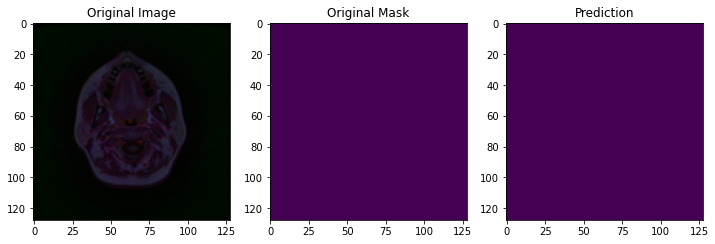

1/1 [==============================] - 0s 41ms/step


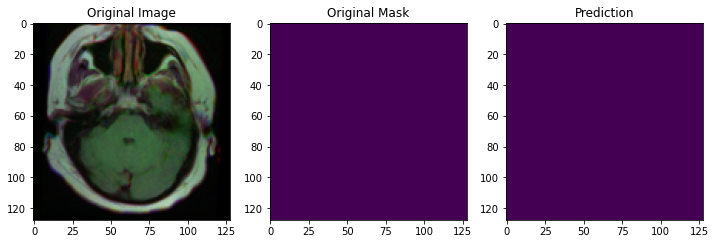

1/1 [==============================] - 0s 35ms/step


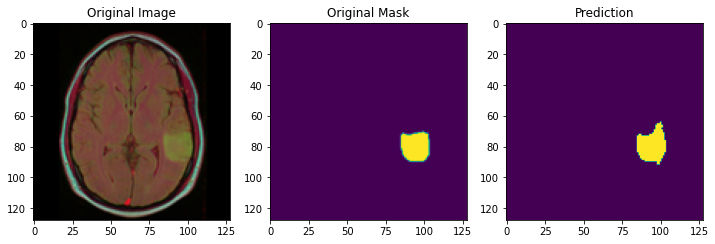

1/1 [==============================] - 0s 36ms/step


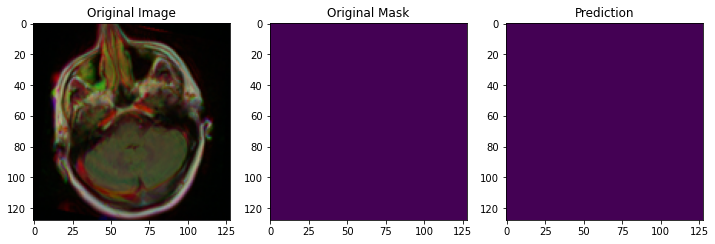

1/1 [==============================] - 0s 35ms/step


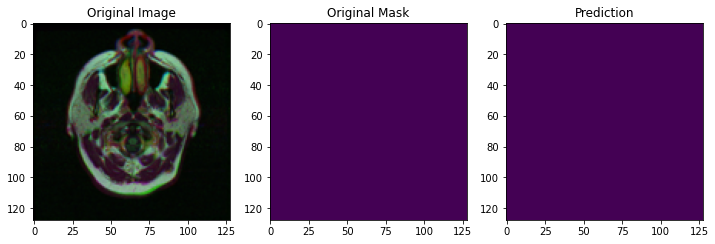

1/1 [==============================] - 0s 37ms/step


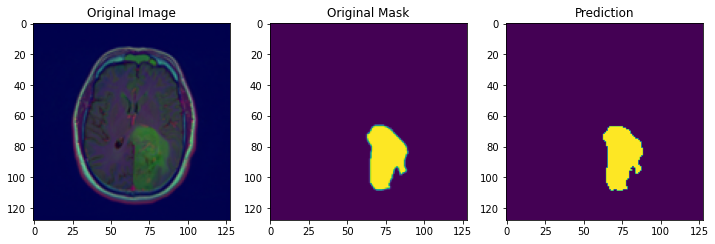

In [46]:
for i in range(6):
    index=np.random.randint(1,len(X_test))
    temp_img = X_test[index]
    ground_truth=y_test[index]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.75).astype(np.uint8)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(temp_img_input))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(ground_truth))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(prediction)
    plt.title('Prediction')
    plt.show()